In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

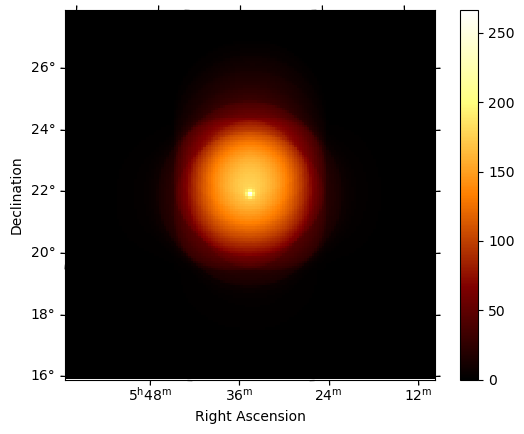

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Varying the Exposure

In [4]:
shift = 0.10 #+0.085
tilt = 0.015

N = 800 #831
sigma_a = shift
sigma_i = tilt

save = True
save_flux = True

In [5]:
%%time
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        #print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit_cor.backend = "minuit"
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'lambda_', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        #print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass

0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1333001946416883 1.1976618445622234
norm 0.6201047149463523 0.42029203933953996
norm 0.9050923778003734 0.21328822165314235
norm 1.0015841152741924 0.18825169503731146
norm 1.428280797154464 0.20723966067723204
norm 0.7809422235814782 0.1942450338781287
norm 1.0173632310811644 0.2294724970891288
norm 0.623287689181192 0.2462575837630544
norm 1.0202197479560335 0.2980744163217464
norm 0.9494250491236443 0.377567054682846
norm 1.0944498485132685 0.4768287286902854
norm 2.294807261535658 0.7761218403270573
norm 0.5154643667795491 0.8709263727527929
norm 0.34359056303684465 1.4706087294951165
norm -0.5484288882488827 2.3743865284931966
norm -2.082661378231648 4.604408776162901
norm -43.87368448660475 36.69708477349711
norm 18.993890256618332 53.62024995429021
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


1
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9864904705507147 1.447154759207003
norm 1.0310666030306948 0.4743886262266872
norm 0.6908431005460651 0.22267872494365865
norm 1.0866346885655045 0.1927832113343197
norm 1.1631922255932723 0.19089862530760116
norm 1.0834801963219294 0.20126876731944304
norm 0.903502645017834 0.21870315286432648
norm 0.9844799623257321 0.266203045980398
norm 0.5429695189925422 0.3003921530709707
norm 1.4356666404719973 0.5178653718717102
norm 0.9820920622995475 0.7850700281795008
norm 2.381671671335997 1.7270017451810533
norm 0.5051643468841824 3.538400800453328
norm -3.227032550719366 9.004005192922216
norm 29.301816025342635 44.81205743317391
norm -276.61044926242295 525.449354338855
norm 240.21451941448603 908.8395135236397
norm -104563.96531558539 12367.826263842844
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


2
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.391959083791363 1.300837660742458
norm 0.9023242749360315 0.441507798522923
norm 0.8738383081834568 0.22671576851591396
norm 1.1180896335334325 0.21252788586750282
norm 0.8700508732973039 0.20964148645503966
norm 0.9299143752410421 0.22767643757008396
norm 1.0109149789482939 0.2568526346627692
norm 1.2851821970805712 0.30858114510316687
norm 0.9121215445624589 0.3398579943316859
norm 0.8730859296721243 0.4122919357744111
norm 1.3002659617786998 0.6062561825217059
norm 0.4827196100260207 0.6875023125214998
norm 1.1098779864488066 1.108225911472049
norm 2.928152966361489 1.9846001082432572
norm -0.8597941621451802 2.4898406537286166
norm -2.5504182562568265 3.8070329845805984
norm -14.437850300609131 7.239257328975806
norm 19.098615312973234 48.74137930357956
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


3
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4677062682430504 0.9845326781818987
norm 0.7465365008340101 0.3882642898488537
norm 1.2126821298651334 0.2267248504692645
norm 0.8932467200684621 0.19677415343310858
norm 0.9472479295240003 0.21089092855222769
norm 1.0205308820695667 0.24334087243524183
norm 0.813343367976095 0.2610647135831292
norm 1.4482119755644383 0.3467252792328026
norm 0.8276466203528319 0.3689303423891808
norm 0.6785179180603069 0.4676907602099708
norm 2.000258333310712 0.7305995439982392
norm -0.1333328641586442 0.7011046835578992
norm 1.1696690999203518 1.1682773342486439
norm 1.074102889198739 1.6784866606178965
norm 1.8379919683056465 2.263128348369442
norm 3.9455148118550243 5.324377855588095
norm -7.950032439668195 1.4016100759688308
norm -76.78026384953846 19.298087988744708
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


4
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.721869645322169 0.8097527391571075
norm 0.6002559595437164 0.34734625101315736
norm 1.0642367834905893 0.20837366164949606
norm 1.227637327623607 0.1954474929501617
norm 0.6550303975776333 0.19803848287376213
norm 1.2207181987619067 0.24058006380537222
norm 1.2759460244721066 0.27322737388852114
norm 0.7525137022760817 0.3041381490363553
norm 0.857034915770632 0.35570477523087624
norm 0.8324449141276412 0.40935299022575894
norm 0.4338202415117545 0.45413460349788126
norm 1.3205610496665947 0.6436913795840806
norm 1.690758528359019 0.8468635937364972
norm 0.5983947869715298 0.7484110020959771
norm 2.259763150618559 1.2073697116159554
norm 0.43222967758323216 0.9352450757797092
norm -0.8420788179894028 0.15968256396727826
norm 2.0742793996283595 1.8824479181765612
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


5
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.6177378432961327 2.3776092772023922
norm 0.925512167015782 0.7714874272213336
norm 1.3593848581989667 0.36906963390426323
norm 1.2900215675454758 0.27609013808606786
norm 0.6197857299005516 0.23732032418222412
norm 0.6452123977808389 0.2307743634778766
norm 1.1049471091010883 0.2545022289421915
norm 1.1308977368532862 0.28681317781410876
norm 1.3661963321556019 0.36973045316534286
norm 1.4663630917466013 0.500962140264869
norm -0.3701917082563481 0.634456097585272
norm -0.2751747255538296 1.125667690102465
norm 3.8510542937893426 3.353941025802223
norm -6.213681861330171 6.491146183685006
norm -2.0301302483467243 26.22813476216686
norm 170.29844862322568 165.82924850291155
norm 971.7507776965651 884.1904528363488
norm 5626.456635848791 7173.832900168551
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


6
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.0367682498333657 1.101715080300831
norm 1.5315089355329168 0.4661991626597906
norm 0.8960919469582537 0.21937753695123635
norm 1.0368741796581702 0.18826588606316363
norm 1.1836557280951816 0.19663460303915364
norm 0.7069696964744979 0.19574991169669562
norm 0.8710560374635218 0.23687655140915248
norm 1.1308916237272693 0.3028899002605541
norm 1.4162373439736569 0.4294779727395845
norm 1.2680048986021966 0.621857047761487
norm 0.35417507691521805 0.9474960006424521
norm -0.3708285930178724 1.8481082669132876
norm -1.7389540769604768 4.520445620326363
norm -13.750600133089355 11.892035770249517
norm 107.25609364171996 83.55900063858431
norm -42.72455958729689 233.2890024160357
norm -1484.108278953794 310.73593550422106
norm 10046.556304193888 13355.177067003176
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


7
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8487345544408121 1.436196594085021
norm 1.9038361667771997 0.5654465499593534
norm 0.929821296140323 0.24537032505364603
norm 0.871680569534226 0.20470852511094642
norm 1.1228177257486383 0.2082091659023238
norm 0.6910955289898808 0.2040423242306853
norm 1.2196246979274488 0.23979570301019568
norm 1.3199359020391537 0.2835254086934634
norm 0.5541003009117939 0.2930808316395906
norm 1.5956076934754686 0.48029505051495264
norm 0.03626584818487079 0.5417733958177245
norm 1.2858642499927193 1.064911892891764
norm 0.49202637140625327 1.7766309202078383
norm 2.6596557410539248 4.457417358939198
norm 16.82290603217636 14.906938695166758
norm 20.35305952881433 40.62080244042279
norm 98.78459916839897 236.74166316242022
norm -618.4694048609628 167.30313321408912
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


8
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6874908616094315 1.2245761267940416
norm 1.1075493226151196 0.44892408341491286
norm 0.9053177428280942 0.22982059654402434
norm 1.1422025357333065 0.20720967054235973
norm 0.9255579615076112 0.20851741249849548
norm 0.8516688315998929 0.22145727670379933
norm 1.0250029079784624 0.2613626047766315
norm 0.8186535795748806 0.28849068628858876
norm 1.6004159889523528 0.37925275555351157
norm 0.7084018387942852 0.41381320556666995
norm 1.2829814749972872 0.6147956066755791
norm 0.24854116487466454 0.7559751837489993
norm 1.4112825181235737 1.3339832317061853
norm 1.0695724459570988 2.227750487917111
norm 0.9513052616989076 3.9442660002454772
norm -1.7623540101957724 10.363763084628145
norm -32.165447979089045 10.915466054534155
norm -90.83228052878215 19.742736793385983
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


9
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2701062802674928 1.2006217981342
norm 0.8882916503343766 0.45882126348610963
norm 1.0015483480690146 0.23422610112294742
norm 1.0686150495872542 0.1992402926461528
norm 0.9464120916945687 0.19808031234961848
norm 1.1542173990505664 0.20804707829142802
norm 0.7944777771131345 0.21569155299622159
norm 1.098491358837213 0.25196857470820067
norm 0.9313452323333175 0.28212432294299905
norm 0.6057157796144805 0.32864230078536144
norm 1.5050105768396729 0.4721752343438306
norm 1.337809871835649 0.5920785880821736
norm 1.1205714382489171 0.8551624719243597
norm -0.1443913368165858 1.0492221839399987
norm -2.1394006010919275 1.1522275623519667
norm 11.15684620898059 6.743392116444514
norm -30.453613586860552 29.620468455424486
norm 26.133951321692493 49.3852283749054
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


10
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5747627027885717 1.0943503469945706
norm 0.9201626898107643 0.46691122221540576
norm 1.1588804647807305 0.261539281232798
norm 0.9082681667634823 0.22859915640619893
norm 0.9298878890753591 0.23599126568293063
norm 1.0988262622304965 0.25807427905473995
norm 1.0868378470236142 0.28409376448329104
norm 1.1709347160681853 0.3390030000309681
norm 0.6722437431790662 0.3577655404549475
norm 0.7549844992775276 0.4229772682323897
norm 1.5248396481911595 0.5897516104617986
norm 1.0671525577533676 0.7077993396628023
norm 1.1961532189299142 0.8530332702197867
norm -0.6718632422450057 0.7664638910902994
norm 1.1158456520903193 1.6476118837111757
norm 0.9777315516462427 2.8233503097555133
norm 5.105876645131043 5.399369310254613
norm 4.302493523852194 9.188013503283903
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


11
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 6.063097099557991 2.6886759390546784
norm 1.7993859178524234 0.7415366440466606
norm 0.9518118549693444 0.27651480027222936
norm 0.723592763669217 0.19662198525716465
norm 1.116081915785311 0.18715287193605915
norm 0.9694742518168736 0.18206906855784263
norm 1.050404070532245 0.19937399364307018
norm 1.1048726028106264 0.23935099216279304
norm 0.9733142521446931 0.3206934615284637
norm 0.8648985598260914 0.48761914232229087
norm 0.7472509933459365 0.9657537217497797
norm 0.1535677756889421 2.1961453509872806
norm 8.603394500734248 8.25510341744974
norm -30.894335054506683 19.134158318330893
norm 16.434897688155555 116.72164780938002
norm 87.87918498704373 723.9351884786229
norm -9734.96701730746 16045.345225237646
norm 11489.268362540746 77605.21342405472
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


12
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2466084136414666 1.4098891903359114
norm 1.596299508714711 0.46208479663919205
norm 0.9963609721372547 0.2229285630163782
norm 0.692390498858393 0.1773894530293113
norm 1.0546797514967847 0.18863961342517166
norm 0.9686771828696815 0.19682132071756395
norm 1.0716620414328397 0.23032575848605663
norm 1.644553453328111 0.3047195546042524
norm 0.5597709847948927 0.3206687802443503
norm 0.41605922094689973 0.49069016700085455
norm 0.6101509142645314 0.790077693011525
norm 3.652817003225393 2.0573257414403536
norm 0.12304316158652334 3.947291244415214
norm 7.292523187643492 12.972625254355785
norm -30.873196375262005 24.130301014120693
norm 159.89104152745756 208.50019750999132
norm -37.31374375486452 900.6091656586109
norm -25351.17637090826 27124.05107958424
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


13
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5322942474371293 0.8302111718624575
norm 0.8100532397322445 0.3107333670005924
norm 1.2508892755141043 0.18554955289030092
norm 0.874438615206155 0.16078248536803316
norm 1.0739984024662477 0.17771770726363081
norm 0.8172565013993994 0.18289485022450233
norm 0.8224515727552076 0.2188313260551551
norm 1.274046076491153 0.273647213763837
norm 0.6663272006340772 0.280373667970453
norm 1.0100614354502562 0.36479098571736646
norm 1.1870594617098889 0.44762975926459975
norm 1.8635326290311829 0.6352384842050371
norm 1.3579794081315455 0.7504673513015113
norm 0.2808630924045139 0.9368353615391544
norm 1.9979217503256115 1.6515907601572837
norm 0.32570067271988135 1.564908150042125
norm -2.9202339749499786 0.979837280430227
norm -4.182033353639217 2.604399783528636
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


14
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.259344621057558 1.294899774122075
norm 1.256161505979539 0.4858135697583946
norm 0.9528578644003944 0.2447161703493702
norm 0.9515148844850263 0.2148363156802173
norm 1.0813654301857332 0.22430466741087174
norm 0.9843138683202435 0.24282391451104293
norm 0.942233791173356 0.2717281540541999
norm 0.5995500940524889 0.31032571984944024
norm 1.3078201980928426 0.4057838834834042
norm 1.7097612011955974 0.5865114207821566
norm 1.1007004791343904 0.7173549880513159
norm -0.4761161094404675 0.8634644962054375
norm -0.06384043045221079 1.64199222321231
norm 5.432539488928706 4.368564791212495
norm 0.6977179290431808 7.392527022521065
norm -23.847424790299367 3.2140489951584668
norm -67.76172583236597 9.935826850497508
norm 361.88928998299525 382.70138657614564
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


15
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2479640668002523 1.2596501273926075
norm 1.2395829795202904 0.47976041417419507
norm 1.0581738507237322 0.23382522015173066
norm 0.8836322174741772 0.19553278010968458
norm 0.7361400114034866 0.1970031099243135
norm 1.3371082660241127 0.22574396714281322
norm 1.154014014557485 0.2472749510737765
norm 0.7967288996701624 0.27711515106358914
norm 0.9059718321709073 0.33544146477495884
norm 1.037965569896918 0.46793134078710735
norm 1.0533810412439635 0.6219407050895825
norm 1.0651592068590874 0.9220489219017437
norm -0.18440269734248688 1.2759411245133028
norm 3.292768124016852 3.1476311641137817
norm 2.767549461139306 6.012539737826371
norm 5.767269521254122 15.522015067242688
norm -54.573789487878805 7.501198922503248
norm -1181.3346903501406 2092.8879153454795
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


16
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5122045376107605 1.2967044230744569
norm 1.2539723169224093 0.5071305622548051
norm 0.5582767513511093 0.23136617626243788
norm 1.2435895108306294 0.22039231874036205
norm 0.9533789435929725 0.21406690584901947
norm 1.274075429862017 0.23209695600842664
norm 0.9015897990762525 0.23891129786740098
norm 1.2272707637173563 0.27522840035389334
norm 0.4794834431423748 0.2647952714718864
norm 0.9698045471976251 0.3489583224785405
norm 0.7072403526973201 0.3979484273622382
norm 0.9493635540664662 0.53486452363963
norm 2.031336043619781 0.7903992756083665
norm 1.459279558659803 1.0238933006475355
norm 1.973324696144428 1.7612975941224522
norm -0.5764469165996383 1.9243170325828314
norm -12.698315343492546 12.511408113681313
norm -51.185411801917525 13.204900564718354
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


17
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 4.07950555853588 1.9270095259959354
norm 0.9910418029735746 0.5816168985897593
norm 0.7216700939589491 0.2569598141614223
norm 1.1727858097430102 0.2190835459314999
norm 0.989902650895458 0.20724607251744012
norm 0.8154230017751207 0.21409934516108128
norm 1.337521419768467 0.25640061823869886
norm 0.8261506219940308 0.2913729014081191
norm 0.8744001471713869 0.3745577095307729
norm 1.0941544609947849 0.5777704756391105
norm 0.7982861462997946 1.0312357403948171
norm 1.025174625487187 2.071956452532468
norm 5.0465477407453925 6.135916090310737
norm -0.501126446451305 17.227445727734413
norm 119.69253445816808 95.5215443903126
norm -163.44083125260062 211.41028583116494
norm -237.06183718778988 1492.9844046356022
norm -12034.48140248044 4792.315723358312
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


18
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.988738945203748 1.7993763215790102
norm 0.8546106889613883 0.5842971443500627
norm 0.8545512674478725 0.26787040122474287
norm 1.1559264549281825 0.22124322840057384
norm 1.027327833820109 0.21133304594651897
norm 0.9726579634451454 0.20654507257458005
norm 0.7016809719915446 0.20951602097556268
norm 1.4715550202028442 0.27632762800256394
norm 0.8293008103397552 0.30140910419825856
norm 0.8308907559588465 0.4157925557783488
norm 1.0998430153276455 0.6140046247795913
norm 1.0309842225027455 1.0854891159874704
norm 1.3541506209338174 2.1757921181032245
norm 1.604526046948689 5.8974609240353155
norm -14.203564391804996 11.465307712351803
norm -40.19157871333512 47.97203743178969
norm 528.1018875140652 449.40889517134644
norm -1489.028241337395 427.1136006634994
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


19
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5279390765389462 0.8796043414698225
norm 0.8054019670010967 0.39751862417828737
norm 1.3223542208023082 0.22531453628149145
norm 0.7293877931554813 0.1852106438501109
norm 0.9156347437915521 0.20245533558122705
norm 1.1643337829340696 0.22735819594278814
norm 1.1618788214396663 0.2567173337419323
norm 1.3481586750057082 0.30523400904596115
norm 0.8360025250017747 0.3176292169634972
norm 0.653698721132744 0.37054528919168866
norm 0.30334319832472734 0.4171911786932528
norm 2.0839459629564985 0.6931901976008993
norm 0.1888770114045839 0.6110664133491842
norm 1.6360041096583886 1.0483101897360125
norm -0.7388841519948761 0.5752704836121584
norm 2.4434502581120316 1.865753731197857
norm 2.506278238352625 2.902914005943698
norm 1.493198420357347 4.083534534739277
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


20
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3291322367147004 1.2047399535472567
norm 1.2603294808814738 0.4687006335030827
norm 0.8800873964162751 0.24287859672036538
norm 0.9248808794432717 0.2098744569213565
norm 1.16197768092132 0.21900533060204724
norm 1.0521883335142732 0.22877811840556816
norm 0.7609357401230302 0.24210719264345243
norm 1.2075904532410753 0.30457973993041154
norm 1.2448087285671885 0.34879002450896496
norm 0.717841900014902 0.4024936350535834
norm 0.590536597747622 0.4959915938775661
norm 0.6051852327915634 0.6597492655352196
norm 2.2616210275641664 1.1743114650696977
norm 0.729581641765132 1.752532074631833
norm 2.8209579035975527 3.3960533698409634
norm -1.5043236626210854 5.215832517164424
norm -0.049642219529428155 11.985293465973312
norm -605.595172733472 403.0135666750297
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


21
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7161866928907707 1.2719527797118648
norm 0.5026519282008372 0.4113026981267836
norm 0.9539661341458243 0.22288572744815524
norm 1.2163180101531081 0.18940493814251785
norm 0.7151274910532769 0.18285627631024298
norm 1.4140425379608998 0.21371730374131487
norm 0.7341010909487362 0.2122231175908936
norm 0.9351285480792213 0.2600935808320564
norm 1.1057795584470755 0.3226168224574787
norm 0.6730150815639654 0.39764449127577156
norm 1.1897459679418116 0.6170619254529215
norm 1.6099967320025599 0.9936549305179198
norm 0.6747325603864923 1.645354936432617
norm 4.615773477616259 4.380444054457209
norm -17.89735403253337 1.3723937732278269
norm -38.52371457953197 6.770876348664509
norm -116.24268305198508 76.70269485519184
norm -436.989647788807 184.2846100327214
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


22
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.1234594455724025 1.2767831302894956
norm 1.5223414783094995 0.51600221652124
norm 0.9690385767487528 0.24259648541757892
norm 0.9888754540300533 0.20700270764911086
norm 1.0415331099924976 0.20869708120694613
norm 0.8638947255780914 0.20797432563844173
norm 0.8671997256815399 0.23201001122147055
norm 1.2699887052272358 0.2851205804209355
norm 0.8270361902568842 0.3022907758831184
norm 1.1809818586404037 0.44062411651813027
norm 1.3962253878133173 0.5839839975618092
norm 0.7041735161582192 0.7934600460846376
norm 1.6653257304223112 1.415926220198631
norm -2.951698929806784 1.8040940652804405
norm -5.839700788026659 5.213689026379945
norm -4.5169661983961475 13.350085314912288
norm 65.82754084344305 82.28648338961457
norm 357.84884019176036 458.7406176189997
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


23
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3459070903653396 0.9917854443414601
norm 1.425659286333228 0.4540868091070274
norm 1.009661420041932 0.22892324515731918
norm 0.8553526114359885 0.1967991269678787
norm 0.9458468902400459 0.20903284202277012
norm 1.2594555675687293 0.23249432663119637
norm 0.982659189514464 0.25329349254077527
norm 1.1007734422696904 0.2853050510041143
norm 0.4686080935998279 0.29544257055745393
norm 1.0344300312936796 0.3912662397930672
norm 1.6347428807311857 0.5456740378598065
norm 0.9429987187476084 0.6432416254305603
norm 1.266881731285946 0.8226276496785114
norm -1.1673026040135623 0.6390493339696093
norm 2.15714070320051 1.9253085407749468
norm 4.13819465264708 3.3749634320940842
norm -15.337722749506272 23.73015394435052
norm 2.9755713526839904 10.033270221043288
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


24
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0222838940992078 1.0573602199921959
norm 1.277040718116174 0.42952180039115895
norm 0.7104937567330637 0.21326749452668634
norm 1.249186348200797 0.20170056797634153
norm 0.9851490925167714 0.20821225513529307
norm 0.9557632993015783 0.2215742672410357
norm 0.7828697766696707 0.25421992957987716
norm 1.1254592608416312 0.3217843802483712
norm 0.8955657518152894 0.38297091489933094
norm 1.311154585191184 0.5471645278181844
norm 1.5013393713045198 0.7596262654795549
norm 0.6835512589029543 1.0768436422747565
norm -0.5832277808298275 1.6772978105998115
norm 2.633482555852523 4.628175966027272
norm 0.10742864537062236 8.155444552517132
norm -38.82587924167737 4.516495582976748
norm -93.2614045752095 19.51018842232161
norm 235.1240219766628 494.02370448656023
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


25
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2973198239578172 1.0684649019631465
norm 0.30895729981817754 0.37945072345357367
norm 0.9145549490685103 0.20763679801749504
norm 1.08500170978964 0.19208111317139107
norm 1.3778400121812424 0.20599173454532982
norm 0.877585123185686 0.21049531504984664
norm 1.0430424824856521 0.24703357681079127
norm 0.8846664824351602 0.2849652233932264
norm 0.13025508121419904 0.29870583917435706
norm 1.4300364488123078 0.5042608736367176
norm 1.5622073644811896 0.7292394850650127
norm 1.62037565453991 1.105538863437494
norm -0.5467407157787075 1.6856279549073103
norm 5.8644810363602184 4.445957773741547
norm -4.38077125785853 5.542723995718092
norm -12.561676804312183 14.693417645972174
norm 74.99513247032205 121.40271045096058
norm 771.6797199887055 637.5153332485404
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


26
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9894802302241731 0.8402717738806607
norm 1.227375286384464 0.3607874911810256
norm 1.1311787315571165 0.20495300343990955
norm 0.9483179583305966 0.183988080185037
norm 0.7383945199783145 0.1963533608661008
norm 0.9908749014539642 0.22188451684657193
norm 1.032516531117126 0.26216445992698834
norm 0.9553192076098026 0.3036452796928511
norm 1.2377890785160723 0.3702281918762143
norm 1.4673211108102915 0.4793515041196495
norm 1.0888924253081977 0.5348856227837565
norm 0.1706741602107085 0.5461996445979851
norm 1.5123238238453065 0.8530491826593377
norm 1.047713046087859 0.9296860679948303
norm 0.3254265342957897 1.0611510017121095
norm -0.46328487871254154 0.8989956670673213
norm 2.958020590891224 2.2563147298847253
norm 0.8008824788213194 2.014982879425526
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


27
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.20492957287885766 1.0843266490320165
norm 0.9811659834787441 0.42375434555271163
norm 1.0559000175559297 0.22033103180219799
norm 1.1471039499394593 0.19116959145167095
norm 0.9094563031098997 0.1876721007511955
norm 0.8021337346017472 0.191102981956474
norm 0.9503891568851338 0.2191963472937519
norm 1.3795627882797683 0.2750229699286061
norm 0.8087887289001559 0.29414325504009314
norm 1.3329118387324448 0.4358814800024313
norm 0.9354284187875354 0.5689931711099453
norm -0.5452350457865063 0.7288199936883452
norm 0.7084771427638862 1.7553376371622058
norm 5.702865165641037 4.211540125946214
norm 9.984521763749456 11.800624488070456
norm -0.4846033785606638 28.24292387637067
norm 205.93814177574095 172.7801980748453
norm -354.29551096538694 132.02535543693804
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


28
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.45332432775693315 1.5611599432243952
norm 1.5686943654445644 0.5548846827706403
norm 0.7830569074308655 0.2576005848268765
norm 0.8013595307744855 0.2115289752908907
norm 1.3145509192755884 0.22124081237592774
norm 1.2032383761140024 0.2233325106946294
norm 0.7296311203686616 0.2220538672231576
norm 0.8478987806666818 0.2612696164096014
norm 0.7569278549524171 0.30471091598353167
norm 1.822317054249031 0.4709187565792408
norm 0.6554816374552526 0.520349856270945
norm 1.4367722182279035 0.8829277803244138
norm -0.31198146114603414 1.3478464702011645
norm -2.3430936169987437 2.6363018066296977
norm 10.147732580182355 9.914551940463532
norm 14.77969301763616 27.449296407465805
norm -6.9026947492203075 79.5895302746014
norm -323.864220462288 96.07947057442485
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


29
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.0270128376384564 1.0957440338278057
norm 0.8744470919281324 0.40009164205429737
norm 1.0283016500797175 0.2190663669829199
norm 1.2115705001712036 0.20190174518624435
norm 0.658712291792978 0.19985037498799346
norm 0.948972921681525 0.22509459327965486
norm 0.8362812195645725 0.24494674829200797
norm 0.8895853037571123 0.2917432657971041
norm 1.154427346657441 0.34926051726240237
norm 1.3916315665859413 0.4511962232571475
norm 1.4278086281839761 0.5552497498571354
norm 1.2941657970758418 0.7122214220884934
norm 0.4977197627979517 0.7972533306269901
norm 2.1864808802864295 1.3375867121299636
norm -0.3666450933933035 1.2742410030704596
norm -0.6189335152500627 1.7917257233425556
norm -11.161187786319783 15.335152678045008
norm 5.286726880591871 11.637370242394415
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


30
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7590410952832906 1.0245206409879173
norm 1.0487432569913975 0.44436674127114684
norm 1.3287033368387435 0.2509476474912052
norm 0.7291734615115246 0.2065727362722149
norm 1.127845314535505 0.22479214620850713
norm 0.8847213890591087 0.23527602165655395
norm 0.9338550977184545 0.25965095979459324
norm 1.06748653498206 0.30630909024768727
norm 1.1237496173380552 0.36323284358790964
norm 1.4609927740498454 0.430785410528475
norm 0.23328394431094557 0.4260323932972768
norm 0.8634097850558342 0.5878216588209407
norm 0.9949902655680218 0.8009794039548199
norm 1.0392489472423778 1.07087785367462
norm 1.889935935614554 1.5328685453341504
norm 1.6150136389308578 2.439339311858701
norm 0.41298119182298254 2.56063755800495
norm -3.744012212146207 1.0581002952773577
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


31
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0649005895368318 1.1980793698074066
norm 1.356023880291554 0.5130453197092062
norm 0.7530146436795223 0.2471381108010594
norm 1.1847550994518723 0.23241724530105792
norm 0.8497957414084775 0.2339454855802847
norm 1.1365717551451173 0.26165832162699
norm 1.0581178505904747 0.29332345797613024
norm 0.7044447333720157 0.30900811674397827
norm 1.0718132678409569 0.37607184674902683
norm 1.1761853951484178 0.44456996970670193
norm 0.895305110871832 0.5243592228302234
norm 1.979782769673366 0.7663334128550744
norm -0.8128401418395426 0.5660852170531944
norm 1.4846348586639104 1.2104429291501964
norm 1.2055030875996204 1.542601005885853
norm 0.3935233840607531 1.8610881919414506
norm 1.4771955711914633 4.09437874893763
norm 5.048734343344054 8.888981192051164
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


32
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5157540176289611 0.694423586609495
norm 1.2194414657155057 0.35696375536490427
norm 0.9535503415190688 0.19495425329504634
norm 1.0178127407671729 0.18473324755746034
norm 1.1147494016755415 0.20170354243281396
norm 1.1346069694975092 0.2291632755945189
norm 0.7995557576808859 0.25609440087966817
norm 0.8228875780991469 0.3228512262979271
norm 1.1167745163633478 0.406807322767226
norm 0.17981532294305114 0.4262904724522433
norm 2.376277429936834 0.7837727930061765
norm 0.6915100914175216 0.8365340394293977
norm 1.1241598725822834 1.2350877206090374
norm 1.2048210906243555 2.030090384202351
norm -2.1943716097409496 1.8054707873600964
norm 2.346152544659563 4.817723020551363
norm 8.272821612074559 13.271541175652217
norm 29.28702270980576 39.361637253781424
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


33
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6320279484149458 1.4567436443410093
norm -0.027244420754515324 0.435318089328863
norm 1.1326233510114907 0.23641623189984198
norm 1.0510376970776902 0.19791076391165316
norm 0.8955712701817481 0.1841397612662311
norm 1.2945588339837406 0.2065337417618275
norm 1.0101275296319758 0.20624073639705742
norm 0.8318542909089299 0.22697795229768353
norm 0.9922826080902124 0.2848317816650559
norm 0.6816534059087643 0.32650745409967985
norm 0.8965403170805604 0.48054249605182625
norm 1.693052627786848 0.8337113869180816
norm 1.4927798994587151 1.416298723981477
norm 1.1640352263039155 2.910193367190104
norm 7.231750411765033 8.507412608558523
norm -7.514283776334244 14.270717023307085
norm -77.70003683265766 16.198779369607472
norm -346.96968522916063 405.208109895531
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


34
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1510274080034706 1.2459668929577024
norm 1.3056863532931258 0.49413005894164097
norm 1.1110679275821864 0.24500475547575343
norm 1.098078146290231 0.20907599289512613
norm 0.7219425451140511 0.2065230676064387
norm 0.727654395173482 0.21306529659642742
norm 1.1720660656288833 0.2550575949104111
norm 0.9438107933970049 0.2716885190566417
norm 1.2478233705850337 0.33106698615707414
norm 1.5483823241690096 0.4020657934841712
norm 0.5135027761982837 0.39277797794704405
norm 1.1769641514603952 0.5747705047496618
norm 0.865882909434621 0.7205983925399506
norm -0.13731365477662055 0.7883091538417114
norm 2.199401302871577 1.820265103696242
norm 2.1638348932438176 2.8112896582188633
norm -4.5165376713078365 1.0149968191547027
norm 7.729993503478435 15.60761229723794
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


35
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3466954195309082 0.8288008818651781
norm 1.1329697278673585 0.36348689584128957
norm 1.1876072870047807 0.19373132914768187
norm 0.9340581726613059 0.16952762320362363
norm 0.96920027747438 0.18114832108082496
norm 0.7540821141706314 0.1905098266783675
norm 0.9147339690202205 0.22121515546672926
norm 1.021004355636186 0.26196189413130466
norm 1.6424296169704466 0.34689743382661675
norm 1.0439550417179726 0.39166191305609155
norm 1.0135243057237426 0.48790297383580816
norm 0.5116913395017153 0.613459713058126
norm 0.2762741666742435 0.7427067861323512
norm 1.2904491509552514 1.235545338086889
norm 1.16338193518355 2.07790250657226
norm 3.88994491134347 3.8092280369115357
norm -0.4671006070898843 4.416257852096767
norm -82.00327937948157 42.62568798199632
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


36
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 10.437969778981726 3.6419699465327975
norm 1.5384778911537198 0.900490427457183
norm 1.1695926838864061 0.33772425301694947
norm 0.7388829235454253 0.2353406670485207
norm 0.7224026893662385 0.19423680943177113
norm 1.1160697811524836 0.19906045251325735
norm 1.301172373357202 0.2139951121940898
norm 1.0323071516867453 0.2383708178877415
norm 0.7613454394381332 0.2794672651247154
norm 1.1035266162206037 0.4407861405361375
norm 0.15681676330110167 0.7283710528165316
norm 1.055714241562236 1.9962290673660763
norm 12.179347516740055 6.940942121185959
norm 14.006114052606664 21.11910789506985
norm 86.41523420010863 91.82758761720441
norm 208.6518134402496 447.9802192436415
norm 3914.4687118531733 5124.077464774505
norm 17239.31927150759 43510.07948145229
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


37
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5588793253854819 0.7968177660017447
norm 0.8478820152354772 0.3537419794765802
norm 1.2117225215585035 0.21034583524421183
norm 0.671539695317454 0.18410444041631638
norm 1.2498679486663644 0.22325210110293028
norm 1.2006262579958218 0.25127835483401295
norm 0.8376979694660869 0.28341054276263417
norm 0.896075671809497 0.3522646402216549
norm 1.0570200514545498 0.4474567248829965
norm 0.5463776421195486 0.5346145929656334
norm 1.0783034531243405 0.7851491228474587
norm 1.6171317908770535 1.0877797566274592
norm 1.1087774577146037 1.309921159535276
norm -0.393813024926071 1.8335387049690537
norm 3.5991441036842913 4.1120607321293905
norm -2.3146267195739254 4.177010337752776
norm 11.328492107254428 13.473095196136002
norm -18.221229297716203 4.327335609346338
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


38
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4255153162768015 0.9228821090968568
norm 1.2450339115347782 0.3443513481116902
norm 1.0119115295889647 0.17864688756833902
norm 0.6808465169730974 0.15136136266254333
norm 1.2282385688524817 0.17881641538429266
norm 1.0071412799225092 0.1923062542658416
norm 1.002097317488241 0.21942659404991144
norm 0.8030226264347892 0.24880798921003455
norm 1.1248214577329414 0.33043260588853657
norm 0.8901206370344485 0.3984926716130001
norm 1.7129343128123204 0.6326978894843541
norm 2.18692750281415 0.9579418459306906
norm -0.6927042237148959 0.9829626033757929
norm 0.17401702796866111 1.8850064995213656
norm -3.0650607744427423 2.337926140336175
norm -13.249545915615876 1.1507120356810079
norm 22.757550992665475 38.96310040855196
norm -417.9232522858871 129.9775724630845
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


39
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.3724566593986227 1.0084478176467422
norm 0.5325312026808159 0.4254111684412591
norm 0.974232668429021 0.21881470296464123
norm 1.2873962422292786 0.1887859009413394
norm 1.0368906559941335 0.185626062980375
norm 0.9113496393592538 0.18682740524488375
norm 0.8796759579259418 0.21304992439848328
norm 0.93045727302532 0.25094174255735996
norm 1.2069441526619837 0.33632035492491297
norm 0.6070713784662976 0.39646700910298255
norm 0.7715090087323678 0.6716580733805928
norm 2.527795044795338 1.3442656292207782
norm 3.965783795593508 2.8409968576283826
norm -9.385937760305351 3.199083459450984
norm 5.765645466191803 18.72615976799967
norm 63.10827696724829 77.61403928949046
norm -678.5872988388576 711.8271782224637
norm -1423.7042271315988 1286.2045923992093
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


40
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.853087043796241 1.504497952282376
norm 0.7851590655988911 0.47009119786959824
norm 1.0238326352496152 0.24756107370150793
norm 1.1270825206035764 0.21309696297448644
norm 1.055675214248566 0.2138809888682037
norm 0.9659161649497527 0.21881049118378632
norm 0.6783234625209899 0.22815022415079714
norm 0.7553776123265202 0.2524567777048479
norm 0.8556429935633884 0.30178003964488526
norm 1.739694344286703 0.42716200850505437
norm 1.3679755833808867 0.5269488185353881
norm 1.7200944296954912 0.7509815808452474
norm 0.9134534378882083 1.0205047394462592
norm -1.1366627060816616 0.9352723901739366
norm -0.794560369949663 1.9793289598433415
norm -2.33501492826395 4.229497625305974
norm -0.55448383863519 12.343572396255011
norm -1125.7051591690229 596.792250707109
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


41
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5158153751944076 1.328258125635606
norm 1.4810030509480114 0.5242649541704353
norm 0.8602949573475004 0.24332026433284096
norm 1.0421057518904875 0.2092626388815388
norm 1.2975489189520253 0.21041024696167568
norm 0.75716419700389 0.2001552418541806
norm 0.7495242447169701 0.2134534984120031
norm 0.71993079317759 0.22387274408769314
norm 1.331826746357286 0.289113500865232
norm 1.4677174811093143 0.3584032861698527
norm 1.3725241568720739 0.4303491544575511
norm -0.36374674384052136 0.377559670975392
norm 1.558949329823316 0.8289117855849081
norm 1.7105255630471132 1.372227526133755
norm 0.6421512187474078 2.0004171219048716
norm -5.325225945314406 0.7717894629592831
norm -26.548706078622438 41.074565343487066
norm -33.08250904373543 18.03042446704862
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


42
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.2860928594906675 1.3522191268479948
norm 1.1520780730362512 0.4829556650345387
norm 0.7920644441355753 0.23367156434502862
norm 1.136297317332575 0.21524989329365907
norm 0.82135924801885 0.2136291237493114
norm 0.9483618015868472 0.22827803578213832
norm 1.1122107847615044 0.25770529835247885
norm 0.9230731514709308 0.2995077591736292
norm 1.4518904130182397 0.3747029508045484
norm 0.7460274080846528 0.4428982539486946
norm 0.96618960490235 0.5949308665735972
norm 1.2069268748449682 0.9561733802449024
norm -0.2653175650248481 1.3169367089009036
norm 0.27974325815215983 2.5184990212109106
norm 2.6326509967844016 5.581795382283487
norm 1.422659006635623 13.288499562821665
norm 40.58293093657953 69.7679629534213
norm 440.8720229275422 309.7904750315268
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


43
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5789727898814867 1.2717200910642625
norm 1.1083061449802822 0.46442899047732666
norm 1.082528371004138 0.23030518221830712
norm 0.8556829508201833 0.19421580109914016
norm 1.0432305909428918 0.19403398558235763
norm 0.9050672146845319 0.20281142203192704
norm 0.9466478913152789 0.22841266712022346
norm 1.5088738253701062 0.28970365563453476
norm 0.4141719650173421 0.2895845278958829
norm 1.3866640091166846 0.44742681456159544
norm 0.8725393298459432 0.5754677124158237
norm 1.0869893057413784 0.8844251718970326
norm -0.2670311608890381 1.4283241472398769
norm 1.9150654584247657 3.660882630760608
norm 5.638436903184526 9.115078711463582
norm 3.8771472452929565 22.88891308458983
norm -591.0612039186342 88.93638911473376
norm -324.13312209966233 132.65734129231424
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


44
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2950414727716926 2.603345495780648
norm 1.3798790628849649 0.8187499502282672
norm 0.6631280606309798 0.33050864597065976
norm 1.2233159975956671 0.2627975729767133
norm 1.0570919577779867 0.2308079791310693
norm 0.9097800863658868 0.22043631731210345
norm 0.9388758466749114 0.22835963755899372
norm 0.876482224050581 0.25532267380724716
norm 1.229496256917089 0.32339812310509797
norm 1.2731162789708634 0.42799312169948545
norm 0.31457408445260016 0.5787827289793936
norm 1.371898900031977 1.2383624852471493
norm -1.4481688554106373 2.2406373059458056
norm 11.609824648405628 9.195456794316156
norm -4.424524167628179 19.24303506910931
norm -5.65506135929097 92.25729632069795
norm -1751.580535937457 1526.945852105141
norm 2431.7580745263463 4857.39024890869
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


45
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.1789541233224266 1.6857510032320768
norm 1.1531499765676725 0.5199999749962119
norm 1.0114280593753757 0.2560081675282375
norm 0.6627603297517565 0.20692247081939838
norm 1.0934977880867156 0.20879830685382064
norm 1.3943084477142746 0.22782956930696602
norm 0.8575188110965666 0.22804332747746958
norm 0.6674749769748457 0.25338540115005953
norm 1.0465492619393457 0.3175965622756107
norm 1.01287523050208 0.42116335457497145
norm 1.9616415791039377 0.681301180760249
norm 0.34141439253537076 0.841784058497469
norm 0.041021294430025765 1.5346467825172905
norm -1.2675044547780003 3.468066108055399
norm 2.5801019887711396 10.554744827140881
norm -13.43013713095266 27.461702797284165
norm 256.4116263199036 277.5667830529647
norm -7046.17864785311 6073.490881036626
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


46
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9204581421950448 1.0859375658466868
norm 1.4003277452089276 0.4406222931567824
norm 0.8456932720446102 0.22590131247668038
norm 0.9957394823079624 0.20071786462738667
norm 0.9781242967021085 0.21005870452393272
norm 0.97957096139762 0.22665656930710118
norm 0.8733309780040514 0.2513307468817639
norm 1.3847680427948477 0.30473173682506355
norm 1.3251281871883276 0.35036590905893733
norm 0.6514406978229045 0.37702805379693993
norm 0.47460545956953354 0.4655166516468866
norm 0.546970234649625 0.6026544085816149
norm 1.3354202601429752 0.9242696415572215
norm 1.9713280105223643 1.404581303429337
norm 2.4051116923475524 2.0205317248241403
norm -4.317932471166488 0.7539831193742809
norm 3.2904628604815316 8.194727581110978
norm 12.67324780559754 23.284432299883704
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


47
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.720475275554738 0.8292041804886512
norm 0.702705586377655 0.3689092245780661
norm 1.1535089448940818 0.2193157652989567
norm 0.9910308623325091 0.2064499255370522
norm 0.7585294556856405 0.2234234664868474
norm 1.2875460112258441 0.26784377821566807
norm 0.9788887819386923 0.3019024037872977
norm 1.3313913678681146 0.38764558741449656
norm 0.8547689949399229 0.43606148658498545
norm 0.4772376762378375 0.48695359756344797
norm 1.2933630694044616 0.6668535774108463
norm 0.8945151151013008 0.7649747413636345
norm -0.5166630174068556 0.6785135248606834
norm 1.665882050829794 1.3240579934031274
norm 1.290736932745343 1.4875196091682314
norm 3.2867894913113544 2.3273633906747646
norm 2.1962347797873134 2.441872010810808
norm -1.9683388991784128 7.002866783018479
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


48
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2196286047013016 1.3411547216021946
norm 0.8820498858209886 0.4691486817240637
norm 1.0693844466630165 0.2328415796662952
norm 0.7580133604431669 0.18997897742273057
norm 1.1353591005239307 0.19945783709204765
norm 0.8190343296428562 0.19266357986514787
norm 1.432153431179824 0.23231538794530218
norm 0.9801654015218455 0.24377800478867687
norm 0.9830184345342681 0.29579546767315484
norm 0.4732212023944319 0.32976057225752214
norm 1.2517641380049735 0.5521616377618169
norm 0.6133006589558433 0.7223229256159461
norm 0.779398275280895 1.2973417452467781
norm 5.103566855247562 3.527110730606423
norm 12.096804292253541 9.803199641702705
norm -5.309083316257127 12.772713907945267
norm 14.130262409609271 63.43788859429371
norm -164.56692006967097 633.5536587925791
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


49
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1653808475788217 1.4208527286805317
norm 1.0632907715910607 0.47351893418527474
norm 1.083606171678002 0.2286633623805547
norm 0.8686813988463743 0.1814903710721517
norm 1.0974517158295924 0.18319481039577523
norm 0.9490569415956245 0.18886633093403768
norm 0.9890547906520322 0.20939701751758233
norm 0.8874428310181741 0.24187674968150072
norm 1.2964761696497153 0.3384420342332885
norm 0.8866387640891679 0.42084793944281723
norm 1.3223862965743027 0.7547219769271926
norm 0.19586307461075866 1.134226479995523
norm 1.3066054807729395 2.701000344437841
norm -4.589953121633116 6.676886954310696
norm -25.65728797014379 12.580770726083868
norm 277.71273585485454 152.56421109240048
norm -23.826223808021947 391.7480349207113
norm -2984.9899940839696 8471.473811087772
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


50
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3253800237431737 1.4464880562721387
norm 1.6204034833145156 0.5043634365479823
norm 0.691463167313648 0.23025071183553913
norm 1.1372076648027551 0.20736467078587
norm 0.9039718122057715 0.20097329525854024
norm 1.0483663544673474 0.22152305628446664
norm 0.701618004807447 0.24628699303023238
norm 1.4725007579306162 0.3357986107934729
norm 0.9252470109434696 0.4098068829782628
norm 1.259192106607169 0.6061073154388356
norm 0.8231716104594522 0.9176314762403665
norm -0.8866082643659595 1.5520114823577051
norm 1.911960141066835 4.3644638001808564
norm -4.26653127625513 10.254618563347139
norm -2.682277063590696 35.22622741443248
norm -412.84373388963013 507.12988181163286
norm 1180.1371260985093 1246.0669966986486
norm 1135.8646465861482 5727.373695146662
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


51
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3957443732017942 1.2150376049620373
norm 1.4170519641441768 0.5092170787688006
norm 0.8012150870875981 0.24255122421871056
norm 1.3813622885092833 0.21557712879545884
norm 0.549583078599381 0.19434962225335503
norm 1.0773464736181844 0.21709084868624576
norm 1.1014834000473095 0.23864483129238545
norm 0.9094128747846313 0.26430732649238925
norm 0.995673989177641 0.30069627348641004
norm 0.9518566656887694 0.3485440973138287
norm 1.0749675761644573 0.4708597044612455
norm 1.8161563439098338 0.7027873686963603
norm 0.2314244222565698 0.7990202295260335
norm 1.3352366851533248 1.5556043075549046
norm -0.40846576506161203 1.972589133874995
norm -2.1795754358392925 4.2923258616115945
norm 4.117016477593403 18.2238810537623
norm -312.4548278753773 608.4858955483048
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


52
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.13587723954637781 1.1011693052778526
norm 1.0222843127034382 0.45818689143489394
norm 1.0065217644768278 0.22449800679923015
norm 1.0093769990717034 0.19009154989125687
norm 0.9859589906026602 0.19058862798841214
norm 1.0491992081064652 0.20755079368715085
norm 0.8787278937472006 0.2211868379649713
norm 1.1672093681556832 0.26511848547806427
norm 0.9861956263358491 0.31903761496524624
norm 0.7837038234037859 0.3989758322615
norm 1.1890131722818786 0.583136668567667
norm 1.4455348642603965 0.9411151701784028
norm -1.359848264211625 1.2406525516916622
norm -0.15611812701494546 3.1185352009556064
norm 32.37508724120109 15.07561689022869
norm -117.2440371870596 78.4004407527306
norm 131.93667418844248 153.45660693533281
norm 69.78008680891726 461.6089580287773
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


53
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.058938115489765 0.7910824402070269
norm 0.9164140364674077 0.3862927159381865
norm 1.1394014841141236 0.21157218200072897
norm 1.182870219667026 0.19031186224846394
norm 0.7278911154630252 0.18709639213365245
norm 1.131261340481911 0.22186598318227854
norm 0.7853675898521394 0.23305679888296732
norm 1.3401601091304425 0.31099498997811353
norm 0.8989178445771818 0.3370077230404686
norm 0.6832341543690139 0.4118489450001011
norm 1.097645034377519 0.5534306103850744
norm 1.5051982623276097 0.7722960059055999
norm 0.11913856481672974 0.9166785921922672
norm 1.3483285226147521 1.6201548180182865
norm 2.4019332223566567 2.7796588969214273
norm -0.8205336273748386 4.2095668021407935
norm 7.612951983962955 13.95721931925069
norm -57.12002309780172 163.3712473852625
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


54
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6425440932348775 1.12546141159826
norm 1.2673655260510803 0.4359436432359373
norm 1.247610241194194 0.22464809234402508
norm 0.7961730062779957 0.1883229106493053
norm 0.704620428162473 0.19116403209647656
norm 1.2925335012997836 0.2277057965897488
norm 0.8113731786897649 0.2360488516514505
norm 1.0637644482165605 0.2931650339552561
norm 1.5757273725840426 0.398810901945912
norm 0.6630321877256481 0.4509003696970526
norm 1.2959662882150684 0.7042855037026375
norm -0.12140679473513395 0.8968826639960286
norm 3.4386778513813314 2.460636912694123
norm -4.056049356159991 2.6908192623640628
norm -5.076708969610458 8.341790323597024
norm 4.579605549985304 28.479750997344695
norm 100.40861347271077 140.60508713954277
norm -386.1381043384728 148.29424362445738
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


55
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7745859416654282 0.9621759876831486
norm 1.2611250830965164 0.38923808372120483
norm 0.873534356817125 0.20012613041020713
norm 0.9691759567693542 0.1895945077862319
norm 1.0569257965509806 0.2101831144766357
norm 0.9883404227565548 0.23335227816289644
norm 0.9263392756465997 0.27727130707101916
norm 1.138377842673414 0.33474170277148085
norm 0.8860579907744803 0.39159689207049336
norm 0.6909670374419756 0.4549198540793844
norm 1.088608273698342 0.6351125026712159
norm 1.4981933475429874 0.8970036899719456
norm 1.830534506140336 1.367464251750784
norm 2.877272477705092 2.0023363184476413
norm 0.3029142783569217 2.4383902048917965
norm -14.325622162843363 10.684792651048006
norm -0.9807202858785177 5.60577115617227
norm -19.25579116754003 61.032544273833764
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


56


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.258794573638407 0.6300607589619664
norm 1.1806290052890849 0.3715829013089175
norm 1.3218072684963835 0.21023443430031652
norm 0.8929849139790262 0.1900018765791479
norm 0.9443800236330301 0.20615826201367088
norm 0.8662987917005078 0.22873079591987278
norm 1.0810934408891115 0.2750332527927309
norm 0.9647848739163718 0.31401599176546413
norm 1.0021852855793056 0.3768825933158628
norm 0.2015824963165964 0.3814989294608678
norm 2.030680146744113 0.5956450570752893
norm 0.6148733482852871 0.587190106391068
norm 1.4492785244825332 0.8369944097918869
norm 0.08008265589611503 0.748308214820427
norm 1.9805220580487215 1.3847116771891055
norm 2.7214553086708513 1.681649956770694
norm 0.8664633324992208 1.4769082116607561
norm -8.748106755277881 2.6338344496501294
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


57
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.527341042786325 1.5326220438746165
norm 0.9797615266988638 0.5369661754150324
norm 0.7545512615777569 0.25165492983524845
norm 1.068153379176405 0.21645662871645244
norm 1.2194655909140684 0.21631827304005566
norm 0.9687810731500558 0.2227705253263648
norm 0.8448160534352682 0.24251140382710012
norm 1.145867050498905 0.2918667936140094
norm 0.5480464376490435 0.315570091357833
norm 1.2600059759731759 0.48003174619824057
norm 1.4323536816464884 0.741368646876529
norm 1.7540099018206858 1.2516008973601163
norm -1.6238522632582852 1.8669821456903597
norm 3.1257035236854716 6.669087106698324
norm -16.586525070485852 10.72810420668734
norm -84.66722090929466 24.511566991421706
norm -66.98983189326998 182.49196186917106
norm 1704.8997576041693 2461.71932611435
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


58
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.4645133617204023 1.3943980628677617
norm 0.7984985333144489 0.5213155690087029
norm 0.7850881443580358 0.22167715429339427
norm 1.2279662734241399 0.1968207610733095
norm 1.1445477490761868 0.18162588076966452
norm 0.9964316286232048 0.18238407929005654
norm 0.8751767230278074 0.1939704077427209
norm 0.8193647113028151 0.2226962037575135
norm 1.1389617408562407 0.28697676998813004
norm 0.5591910499036393 0.3694455251934124
norm 2.1289544882632567 0.7518042850828138
norm 1.001804162427413 1.180541097988505
norm 0.5351491684780295 2.285735729951399
norm 1.7863212770824242 6.915371792527464
norm -11.06798235272007 21.13812361638931
norm -114.97415231976758 17.738784658868116
norm 881.7346048472956 796.7755494006805
norm -2397.9997832293952 828.1445176820611
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


59
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.013356781827028 0.9210070912441338
norm 1.0824078469740872 0.35834992346593164
norm 1.0422986541888142 0.18916654916363793
norm 0.8371015004095028 0.16789521297134524
norm 0.9336160558893053 0.18216383044774992
norm 1.254343519236076 0.20700790113958256
norm 0.9597252975549054 0.23131329900560527
norm 0.780473787896097 0.2646271694114131
norm 0.6836937222783933 0.31620531210002856
norm 1.8057838952689638 0.4866458775974952
norm 1.083029767793778 0.5856084212857842
norm 1.1581221213913782 0.8591316007380692
norm 1.0758285951514102 1.3381555542706243
norm -2.251003152636836 1.6289970843020098
norm 0.8887829208292591 3.752169710814999
norm -5.743784229237682 5.530719900080325
norm 7.120997111409036 26.233736329317356
norm -56.30807011005289 19.094840932402516
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


60
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9489511483733323 0.9559117028116612
norm 1.0354282723147157 0.4052728266041676
norm 1.218318413686125 0.2215023477784882
norm 0.9297565357544261 0.18906901390824624
norm 1.0069553651429999 0.20353848646068107
norm 0.6117184589576422 0.21122868405995043
norm 0.9410691713034868 0.25081833408733806
norm 1.206480501312165 0.30787162315716765
norm 1.0364231369476231 0.3406464986292719
norm 1.6261201813715687 0.4405668936161788
norm 1.1572178367639818 0.4826955079390223
norm 0.975305421620196 0.5962123809399745
norm 0.3897243237914827 0.6369479738271917
norm 0.7069597999582294 0.8627235908099768
norm 0.6302234992431512 1.0869925500799027
norm -0.6403725414534736 1.1059970207731091
norm 2.206592418059495 2.8348305895115393
norm 5.490489808157049 5.651300410589132
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


61
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.274419081618311 1.3313148628155997
norm 0.8226970648308848 0.4353055957654761
norm 1.2600196671448194 0.23076321526257693
norm 0.8259623903759743 0.18868504963079946
norm 0.9406710233599497 0.19361032048841825
norm 0.7760597927554885 0.20479108205998814
norm 1.0530867886848125 0.2288949644733231
norm 1.4525867235189867 0.2864856366088652
norm 1.150279008589993 0.3337360745405204
norm 0.5445438280545545 0.38262642394448665
norm 1.096311315337488 0.5956014566944556
norm 0.7604669165148734 0.8285130967290905
norm 0.4835431660231253 1.4925854298590884
norm -1.7966248270829426 2.229081433138833
norm 13.030594858176753 9.126547158498937
norm 35.702715435999735 30.228425718431048
norm -19.55684518098714 53.2619864580765
norm -222.88176027802325 66.742052427078
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


62
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1377336763330397 1.1653325139824136
norm 0.9712125868187309 0.4267324583548086
norm 0.9029764604810727 0.20408901307234711
norm 1.0474846581978816 0.1799065130532607
norm 1.0182560312983393 0.18071287997647043
norm 1.0585047753895345 0.19138033224686282
norm 1.0623489878743788 0.21104480435237072
norm 0.617817451112951 0.23147172708388805
norm 1.5301759447627696 0.32216332336305453
norm 0.6023892487920003 0.37589419882531705
norm 0.684333831431117 0.5554910804885679
norm 0.9346537884010129 0.8773408164342517
norm 2.0453710013546775 1.6846121466562152
norm 0.8959134490933345 3.0718896260755364
norm 4.827903009112426 8.816389246950026
norm 29.869988120779894 32.82408793973507
norm -4.788906063839156 84.10163475685302
norm -2619.8709147420896 5211.690287508447
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


63
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.047022462035574 1.3168754175163764
norm 1.3345072862471907 0.5035423992428819
norm 0.8785357596423535 0.2503819398562068
norm 1.0500119571397737 0.22817129008016276
norm 0.8794422943624829 0.23404620974652948
norm 0.9446394442931412 0.2532089377806131
norm 1.0781037905813122 0.29086401885194135
norm 1.1588692246956522 0.3480458455582641
norm 0.8273670702875434 0.36376194179720117
norm 1.0351453013690235 0.44010989297050973
norm 1.0664315179714803 0.5820621366867949
norm 1.013644110449213 0.6706694635407519
norm 1.284313819531045 1.0150958350254073
norm 1.4376367167349766 1.3509764860039866
norm 1.7873668547319816 2.2828869684057795
norm -9.370809632755764 8.979225995879398
norm 1.0748669917431002 6.2358284868589795
norm 8.666612096678996 16.309280284663075
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


64
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.04376277494034335 1.0221746857966854
norm 1.3439394513512424 0.4465723999747506
norm 0.9950026459990089 0.22792628123853492
norm 0.910265333618662 0.20670164317580156
norm 1.0530398451732428 0.22446451186507713
norm 1.0281551916134821 0.24974330261132724
norm 0.8092435007501345 0.270146241893038
norm 1.3537719683119094 0.34541024278123317
norm 0.8327540152683818 0.391189108181192
norm 0.9895082243931319 0.5136818622046804
norm 0.9325696164485839 0.6290035679912975
norm 0.28345646631487664 0.7916697764073706
norm 1.1418585134908676 1.326585542133942
norm 5.725451074257848 2.7651374039940984
norm -0.7096786263798148 3.70014598309076
norm -13.217864010324156 22.652079314912488
norm -17.60012078310265 3.7462633578158053
norm -38.62530772993583 147.59849232772544
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


65
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8753992374343966 1.1179949487744436
norm 0.9040546557315171 0.417508279455699
norm 0.9599778896740657 0.212950370612916
norm 0.8955586279502024 0.18414615976538115
norm 1.167625456434405 0.19732485155116813
norm 0.9287936710784189 0.20399239872415217
norm 1.0161387432376439 0.2324914079551208
norm 1.127257984621766 0.2722052921753164
norm 0.8558072904482941 0.3085860681504675
norm 0.9830566113178285 0.41773219994462496
norm 1.042076410572478 0.5740904430308359
norm 0.7351570705885053 0.7620634569170324
norm 1.9783207663840985 1.465757102821317
norm 0.6593700433567762 2.3283267008948236
norm -1.1992219846124605 4.200616137037481
norm 10.186653664958174 15.059520124479983
norm -47.41020918956544 10.676229912268347
norm -926.4041576185294 242.96633669319638
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


66
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.9295727081140863 0.9667011693628887
norm 0.5010413169760523 0.3539253640832823
norm 0.9987123236297252 0.2115395249506748
norm 0.7371517699553448 0.19577871825004778
norm 1.2959144983078368 0.22758380886810284
norm 1.152103468373826 0.2529354279535793
norm 1.0126751531730103 0.2943720987463742
norm 0.6665928239218114 0.3385388219886626
norm 1.3684573632231882 0.43861565073206155
norm 1.2637820798062533 0.5131159162013842
norm 0.6502745183842323 0.5846352891510451
norm -0.3261100710315922 0.6354712945232261
norm 1.054042214794426 0.9003081850866621
norm 0.5638672469353597 1.1807904034937504
norm 1.5495352849413258 1.5508727436924659
norm 1.5999023002014034 1.6647948999405187
norm 3.879418099731957 2.7947895563812746
norm -8.485703356181817 2.311605854538385
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


67
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6883128829174776 1.1750362900871323
norm 1.443846113968307 0.48959191301000293
norm 0.9225470132634803 0.23276096464419252
norm 1.0377879088592175 0.20451285825671417
norm 0.939082061400868 0.20170579757677243
norm 0.7181329163416258 0.2082012916421671
norm 1.3620397524076762 0.2529247658964278
norm 0.9217876752981656 0.2689766676526125
norm 1.4985236707094471 0.35362615470556086
norm 0.23527520645147165 0.3361992398741745
norm 1.0498641158214836 0.5480442402190197
norm 0.7727278268049491 0.7246846010904456
norm 2.984733700716951 1.5231219730073595
norm 2.473188873733941 2.3568848164289613
norm -8.452801708635944 0.7085115364891144
norm -16.72855241018908 2.2761217015315425
norm -34.417650264976196 16.660530486068946
norm -99.3203203660975 34.76760578780613
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


68
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4981155282711278 0.9569419140689904
norm 1.213391199775064 0.38582192108876245
norm 0.9499194243013079 0.20016514972378244
norm 1.0356045090979027 0.18002623649132365
norm 0.839628067850667 0.18452985943175768
norm 1.0877534463064766 0.21341345912387386
norm 1.2249398692268858 0.24583209378215273
norm 1.2135902703089858 0.2928490540832068
norm 0.29566858298723936 0.3060386011355311
norm 0.8062956806928107 0.4325537172056081
norm 1.4242518411345857 0.6492873845741338
norm 1.198800116928073 0.9163316904908727
norm 1.855159547812264 1.5797419197606677
norm -0.5584270147158333 2.216097180230784
norm 1.9713330583305182 5.507589013242741
norm 1.7812853891943492 12.343151871988125
norm -3.73429152594702 25.268880880732606
norm -99.28566578939461 25.53019303428202
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


69
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2135067952126994 1.6839731090507066
norm 0.507717731678209 0.5125534972903646
norm 1.135711136078649 0.26705111603399845
norm 0.7874061657037709 0.2100856597596058
norm 1.061574558970169 0.21402704734092143
norm 1.3677512248577055 0.2355672607418133
norm 0.9073695030551763 0.230477567729252
norm 0.7596095684054017 0.250115802200888
norm 0.6968784868907317 0.28218303260689526
norm 1.6227966717604065 0.41753001422130737
norm 1.0137767751266653 0.4763611291209672
norm 0.7270928425354667 0.6802146602254725
norm 0.008869649296160794 0.9624504373618991
norm 2.8340218829465607 2.3675226633336393
norm 4.712498018044912 5.174152296889842
norm -168.85427206418555 105.25059519127963
norm 90.7469652214068 84.2457592051026
norm 92.29747284101678 197.86334082297688
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


70
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.2123196280851145 0.6791969031899165
norm 0.7466589845181543 0.340308797838038
norm 1.1962286952243673 0.20515572733935739
norm 1.1978700188934566 0.1886556069860377
norm 0.8022500078346274 0.1954774222307125
norm 1.1604559305040436 0.22907018933972292
norm 0.6769308575674764 0.2483293270927883
norm 0.7909159366296591 0.30681352616824875
norm 0.9348915274749648 0.3754234196326428
norm 0.8467457377751796 0.44558427135338396
norm 1.673436072859039 0.6410856108212614
norm 1.4965166014005276 0.826723348356189
norm 0.5347046830322317 0.9529578154373056
norm 2.4540471979102896 1.5645472786795112
norm 1.5262489926675051 1.9650195991368051
norm -1.307113534687994 1.9838636200494997
norm -0.668253151181761 2.9715096637602505
norm -5.891882108332173 1.22639558531739
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


71
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.21283279852101 1.1955699334675405
norm 0.3317758323936208 0.4468296551182612
norm 1.1353093283839735 0.25829768742343634
norm 1.0127620886876865 0.22868288139871676
norm 0.9636643512106791 0.2361234519203944
norm 1.1131855789891363 0.2637698934057923
norm 1.0494677601534204 0.29129880001325115
norm 1.0424890534385547 0.3393944919774266
norm 0.7559135391745563 0.38318092399483455
norm 1.5228602701650011 0.5018150861323996
norm 0.16114588855336748 0.4951392287122258
norm 0.9583998105526584 0.763003193629598
norm -0.1049723901986075 0.8384147405661567
norm 2.841457160844739 1.870706207141073
norm 3.9509211847040664 2.889656808406391
norm -4.866994615419723 0.6816189364734728
norm 5.465471827044483 8.298109716338836
norm 9.22441738424256 19.128891236327316
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


72
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7905435190292986 0.9712351472001759
norm 0.8667331377717584 0.36432932506863414
norm 0.9459741196802993 0.200748580484876
norm 1.045892694087483 0.18503879439442456
norm 1.2542655673324268 0.20401423305449679
norm 0.7132547487656038 0.20531314044717658
norm 0.7590618217532884 0.23343210949510085
norm 1.3288917893613386 0.30606719362130314
norm 0.7934489879027121 0.33604374566635964
norm 1.0469158971245065 0.43566838705474314
norm 1.1711159620643674 0.5680031060426315
norm 1.5926436793902687 0.8033707689769958
norm 1.5112018744331097 1.0069833982132166
norm -0.9999263741409383 0.9403055623840004
norm 0.3382678797940315 2.285115895733828
norm 1.883898680775627 4.446934554886628
norm 3.7273104878719328 9.50671447129081
norm -15.509986449023145 5.329183364573807
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


73
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.662382018129625 0.8995957580630315
norm 0.7771538255047248 0.37217218055924706
norm 0.9779874516316189 0.2091860666990771
norm 1.3452189609578673 0.20147812402978152
norm 1.0384450031692047 0.2050442420643506
norm 0.6239697464828529 0.21463656437500478
norm 0.5950003793938243 0.24578835176789307
norm 1.2059050712449602 0.32437144089593556
norm 1.1303025445661488 0.3861231202445701
norm 1.3715067246402655 0.5141967903093053
norm 1.699120913548904 0.7151631922888557
norm 1.1225748944432823 0.8909299897968955
norm -1.089763146703668 1.0591150038089612
norm 1.9713313680485314 2.1476364202244445
norm -2.809874017789351 2.491078021223076
norm 4.220819238374943 7.610979192071481
norm -16.432992399267693 3.8342795985905997
norm -37.54198134252301 14.766384281878146
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


74
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6158836852868796 1.0429799109005056
norm 1.416449299825312 0.41205202752789793
norm 0.9366600784093464 0.21091057451021206
norm 0.8062884118597698 0.18540182315866172
norm 1.0516322800298123 0.19952907038046588
norm 1.1209951050606832 0.22315041658457294
norm 0.9164624837801403 0.2572074220281324
norm 0.9825168645521805 0.3013611365807695
norm 0.9413658557429357 0.36234192572132845
norm 1.2994482050534089 0.48540890987745394
norm 1.2155173724223698 0.6715792365111675
norm 0.34936463290516434 0.8545889556571774
norm 1.9986998178199678 1.6843974454414132
norm 1.8192374401708267 2.7590256625856826
norm -3.626944119563347 3.1888790668621096
norm -54.76961347113735 31.373796674389926
norm -34.3461238005988 8.141969080102664
norm 61.1611207260918 166.77843257440705
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


75
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6892254044155421 1.7045414806258663
norm 0.6827399836827894 0.5328433437395292
norm 0.5922330320278424 0.25028404991049763
norm 1.0226293937755466 0.2157002494823266
norm 1.2029378048505148 0.21093071112348782
norm 1.4947942616877845 0.2270853080829459
norm 0.9083185239271578 0.2227309514448833
norm 0.5009211812798685 0.23661686351852057
norm 0.8376815695445279 0.298726329876093
norm 0.9915283281387733 0.4259510770159863
norm 1.0060230846502334 0.5910413118259485
norm 1.4314840346754427 1.0270295630585256
norm 3.3418152143143667 2.248581482142467
norm 6.440843210467061 6.052151289616568
norm -11.87241760753841 9.803679925122458
norm 9.13139329802071 51.19607646438231
norm -1321.5161801603278 304.20863177202557
norm 1736.737348816036 1773.109257760807
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


76
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8630963989474911 1.4581677559966182
norm 1.110008258528219 0.5336020926005711
norm 1.1676064004350082 0.28072208400370713
norm 1.1078706423884344 0.24173934487695067
norm 0.5824337487043041 0.23338484473057064
norm 0.8755693186986363 0.25158717611279807
norm 1.1133767476131409 0.27591535891964536
norm 1.0194021717183297 0.3228020006227426
norm 1.171353985495999 0.3643015618803522
norm 1.34117387515324 0.46124652225530466
norm 0.791826495192961 0.48366847038241917
norm 0.47639185419794927 0.5746178272092111
norm 1.9096358131696987 1.063170224472159
norm 2.371980657286983 1.5227137893499172
norm -1.6200679563551534 1.1238329218485474
norm -1.0651016721067679 2.8607324968160803
norm 4.362244283353512 6.9861186508247215
norm -236.8391426329427 265.9052750975879
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


77
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3454166359507683 1.2515360466124428
norm 1.0453402528935893 0.507841004281077
norm 1.2628158417157582 0.26109029933961325
norm 1.044397366613084 0.21234881061621247
norm 0.5797647404139842 0.19138226675105396
norm 1.1099023028281805 0.21657020282259326
norm 1.20916818677843 0.23439446259971286
norm 0.9681049250229432 0.2596969979438244
norm 1.0745601902314652 0.298739933768409
norm 1.0629513808913162 0.35656145579495846
norm 0.35211775238840726 0.3943035802980634
norm 0.9319785184996645 0.6075556334113453
norm 2.083538493860945 1.0295310073281219
norm 1.0979800365831207 1.438712623344786
norm 1.7968766157351292 2.736446423894143
norm -7.072415613840835 0.931276560222272
norm -15.208961169941801 2.0276481008150062
norm -115.0650689958142 141.71111359511053
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


78
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.41682259019761275 1.2982477468390348
norm 0.702823938083251 0.46617755172834613
norm 0.8430622590604242 0.22756080697859662
norm 1.3025995298291397 0.20568326500601983
norm 1.0094521703584542 0.19436949712909463
norm 0.9336224741932415 0.20672480611462676
norm 0.8832264223721369 0.2229678801949336
norm 1.1016412942780258 0.2849641939260599
norm 0.7565068066332785 0.34842367931607193
norm 0.9603144619117867 0.5273731294913647
norm 1.2362637346838934 0.8395344248240408
norm 3.040915708409088 1.74955079950925
norm -3.7780538968363198 2.6331203002713837
norm 4.408411730090425 10.346823968346305
norm 16.28277530432544 36.24551424841032
norm 43.96627101228969 144.9553947794662
norm -3898.2960392388522 1622.264276124911
norm -3737.681264825397 4679.05071463768
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


79
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9888654299088497 1.2572156857995336
norm 0.6099639809207383 0.42252957875926234
norm 1.026498952144087 0.22393362315703352
norm 1.068309538879851 0.18818502784435848
norm 0.8555746023310166 0.18614640642538904
norm 1.0289809845343998 0.19814089964299658
norm 1.2154366635240983 0.2187133060455685
norm 0.9519682197695045 0.24351777355650311
norm 0.9862251162049267 0.2830393033789262
norm 0.7819070984864168 0.35459224868580086
norm 0.26536332606530155 0.42222365405608053
norm 2.700261978203551 0.8629160433792706
norm 0.3395614227500987 1.0048971691856727
norm -1.6769600342920654 1.3425908205838595
norm 8.570138511538284 6.210350117692833
norm 18.188907681823515 16.32869330724458
norm -42.11723290905446 38.428271064974666
norm -128.32913952670276 49.75427733957603
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


80
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8120825314935934 0.9393226509885557
norm 0.758711997065359 0.4140310794539156
norm 0.9993500627330366 0.21662240295093543
norm 1.0814425407481332 0.19085023422679412
norm 0.8822426255757039 0.1877048289463617
norm 1.3418110754236323 0.20983983899296907
norm 1.0989016363023931 0.22844365062127459
norm 0.6862669073058844 0.2606097992440999
norm 0.6374855531677903 0.30173368450997473
norm 0.9191653527590833 0.3915114445959511
norm 1.089290840614402 0.5945148035709891
norm 1.5376867494606463 0.8687768593448324
norm 0.5850704169290487 1.3474107861166529
norm 3.478033941643581 3.182495444034137
norm 5.0175548225446365 6.398607687579444
norm -4.215423402007685 12.456674696741432
norm -70.83619033752396 155.64258999991267
norm -169.07672306972344 39.23580339343597
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


81
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.1637265366198184 1.30797889019171
norm 1.015857963557559 0.5547694370358812
norm 1.2701696305838068 0.2789932702025043
norm 0.9907406378112897 0.22610155868395443
norm 1.0807358233755762 0.22753994765997335
norm 0.7570833473972888 0.2249729670007701
norm 0.6337120677201785 0.24039690282216086
norm 1.421199577212272 0.3046342626139559
norm 0.9171066713902944 0.3101933888718534
norm 1.0587400249649455 0.3980896047936022
norm 1.4923688706221871 0.5738463254230795
norm 1.4789682430519644 0.7381536154749349
norm -0.08083079316395936 0.7725225611007681
norm -0.644203119940505 1.2961429364151251
norm 1.1635345063599742 3.2060586517646197
norm 10.336980938444919 9.741866941917936
norm -15.347820080980421 2.751980102173585
norm -308.28578821946553 135.74642134864456
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


82
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.9077195859316597 1.044953120037529
norm 1.807138101893279 0.4936855450323502
norm 0.9844625571068006 0.23651113709963312
norm 0.8381124098719791 0.20738253515201843
norm 1.1325788853072452 0.21900810921347716
norm 0.891075503696714 0.22950877623105642
norm 0.9041033983288124 0.26593139536837085
norm 0.9237858084599634 0.3320890273944797
norm 1.599045605261934 0.45540576782790376
norm 0.6456552190739299 0.5555194329165098
norm 1.4881576705623625 0.9086762633095081
norm 0.1783024859475229 1.4196010726148656
norm -0.6412986359166408 2.8750006826751444
norm -3.880181912243408 6.467169286958499
norm 3.2457769882036525 23.367768145560543
norm 60.597229159869286 85.2971270391366
norm -342.9123252459472 83.65872583863275
norm -1277.941085513906 409.45197170114096
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


83
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1874004373238884 1.3111252497233488
norm 0.74924879383144 0.41364642197602497
norm 0.720227079928458 0.20089412755052138
norm 1.3850551261156159 0.18342477444508454
norm 0.8494112256247969 0.16911476644120668
norm 1.0453245571169454 0.18690491316381366
norm 0.7971247885514914 0.20289446410525178
norm 1.160771036366432 0.2570978863528989
norm 1.3376716157085908 0.3530549276502895
norm 0.09559507539071649 0.4294825644781298
norm 0.5561769883394964 0.7787470863054271
norm 2.625162582989811 1.7269424295369864
norm 8.193468007737753 4.605521707450283
norm -9.402726982021273 7.050330781043234
norm 49.8016677818568 54.33570379956891
norm -184.15135782890138 31.196286137397305
norm -804.17011018656 194.74298646639633
norm 10653.393291268803 10157.582276511892
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


84
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1264470332854692 1.0481094636651567
norm 1.4929694680941563 0.40598735505337646
norm 1.0197456151460815 0.2011792287825095
norm 0.8490235718317272 0.176017516542664
norm 0.8269869962318018 0.18944571950971698
norm 0.9901961497101438 0.21329123835701905
norm 1.133310173729825 0.24787502172198345
norm 1.023181485125612 0.3009973186746061
norm 0.8559750117499012 0.3526767943789944
norm 1.88172372868518 0.5585344795055757
norm 1.7213073635809752 0.764199576744346
norm -0.8664642267522227 0.7819683417091753
norm 0.8482866814868697 1.7725322682920432
norm -0.9938997242031969 3.1070675288589817
norm -10.794109236230879 4.5363762759371955
norm -41.03041352056162 67.14274358284223
norm 0.3753065808613004 72.02368391246402
norm 535.2775340249358 553.9310639424194
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


85
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9464083638594875 1.1107365265669464
norm 0.8721785570999756 0.434163176402623
norm 1.0118701071105936 0.22265431482029013
norm 1.0333704149990013 0.19413575752049997
norm 0.8348352529645359 0.19353808147873222
norm 1.3165949133614592 0.22008394239152745
norm 1.122500318506054 0.2374426677530185
norm 0.4295144459796221 0.24492438458291527
norm 1.0656177307183112 0.31896536007466414
norm 1.0983513207201916 0.4134290165736439
norm 0.7127435935158056 0.5070795446027561
norm 2.5566038446038437 0.9447052518197269
norm -0.14684087558095452 1.1338089947771737
norm 0.579487853704798 2.1342784416278313
norm 0.2132573577756498 3.6885402675261845
norm -3.4831621083218103 9.238992713515179
norm -34.97816621587241 5.932161570889224
norm 42.12249950851049 143.33272712989984
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


86
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2666978441269792 0.9361030134040167
norm 1.2511381924533609 0.41200154091894603
norm 0.6515879220000915 0.21209421782496643
norm 1.1434477875766043 0.20727234943350142
norm 0.9906009107542092 0.21714845225874946
norm 1.0436848246698476 0.2450726157142426
norm 1.1422706460545107 0.2870495427460141
norm 0.8925157508964903 0.32468816715011684
norm 1.0316071593407012 0.3966804348602143
norm 1.8833491711559283 0.516580044345958
norm 0.7119401851566876 0.505825274389076
norm -0.1074317914137484 0.4959591989665547
norm 0.9198115765781675 0.695714501836508
norm 0.5296277661974997 0.8293218468195
norm 1.200898370923615 1.082923243723305
norm 0.2363966318725964 1.197015397909761
norm 0.5253040565384266 1.4656180441672813
norm 2.3807686131937076 1.896233703997695
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


87
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6851547435745778 1.0078696830306093
norm 1.3364516014999008 0.41150160952469844
norm 1.1502127011343213 0.21668972128133498
norm 0.8368091481370382 0.1871298030082836
norm 0.9473319953319916 0.1976822901436846
norm 0.7950123698661699 0.2110502774416291
norm 1.1025170479547985 0.2513673972551979
norm 1.1482982309705707 0.291242826403527
norm 1.302551139052593 0.3645273133592102
norm 1.0906795002245522 0.44780861850114695
norm 0.3786087820053737 0.5076832716039835
norm 1.5917671022483146 0.8291190991461324
norm -0.07955956770792405 1.013058431084968
norm 1.9672769319086656 2.1222555848168736
norm -2.6975244096762077 2.7861967548257454
norm 7.369183272041332 10.078878940172832
norm 2.7297391693900765 20.218119658611403
norm -50.050898013259655 21.144933565501734
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


88
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1344482422147224 1.0968251418534933
norm 0.9099934968982382 0.43931376030027697
norm 0.8991302373538912 0.230340029049102
norm 1.1908744891447858 0.2134172046562441
norm 0.9531262247864956 0.21325959663979865
norm 0.9578952501165444 0.22421888840881526
norm 1.159311674479601 0.2578635351068748
norm 0.3141020350891388 0.26626742645440743
norm 1.607908078422734 0.39186401055960934
norm 1.0269989484164805 0.44799166647101335
norm 1.1799861990399467 0.577370767419627
norm -0.08458339851980202 0.645340649463782
norm 1.805233728201305 1.2837551364927313
norm 2.9765572251173142 2.061635360541836
norm 0.28518475846205904 3.231218970569174
norm -7.795640309180198 1.0229518170566878
norm -88.38758959784862 32.47507671566821
norm -33.13830573669512 13.606829473986927
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


89
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.14861855623669873 1.0414884923475218
norm 1.1718454370629798 0.44231247382948274
norm 0.8946880943879854 0.2188519205259904
norm 0.8169109376258017 0.19065044239205467
norm 1.1041375204555168 0.20142905137802855
norm 1.44887415336113 0.2235696336022299
norm 0.8934134196903903 0.22254533589731454
norm 1.0409420330362615 0.2731453175396973
norm 0.5599484731032183 0.28929859084497966
norm 1.0420216148091703 0.3911052632875565
norm 0.6233477601726765 0.45632971749161205
norm 1.161094583700931 0.7127790191947396
norm 1.1007729926224836 1.0922202022685936
norm 1.8743585880236329 1.8717517850283016
norm 2.810369657332924 3.9172808749926875
norm 4.990424797029888 7.280120231139929
norm 0.1315428475679018 16.84669673432945
norm 70.61390929215828 102.1463128245695
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


90
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.9301345638673485 0.9432745424802826
norm 1.4910717193368275 0.4559289561866421
norm 1.05147598157093 0.2188995028894744
norm 1.0444535206550973 0.19176661731165856
norm 0.8633248162711255 0.19259081426426247
norm 0.9281491009092372 0.21416962633519543
norm 0.9251570937431535 0.23803936471839757
norm 0.9423802049222222 0.2861614978809687
norm 1.5621384122490478 0.3857176635682838
norm 1.1446099041344773 0.4764528189276563
norm 0.6079489991914683 0.6216098612492754
norm 0.7466290270738724 1.0530480581416433
norm -0.6964233296829867 1.4348202277276727
norm -1.174207317078378 2.9864382564512657
norm 34.91340878238579 16.229304373467873
norm -16.794936524687554 19.858281414841855
norm 8.676093210410926 92.5210794319325
norm -363.3159561884006 120.74793498887009
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


91
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4992741787867794 1.2491701811270395
norm 0.4298811347065819 0.43737374118103806
norm 0.6689173175348527 0.22913077637520787
norm 1.366197400802586 0.2180148269386238
norm 1.1546004949356004 0.21310089346827363
norm 1.0399682035353641 0.23222588055748777
norm 0.8581349537178592 0.24569113124567016
norm 0.9191428937224577 0.2881990513701331
norm 0.6413318704067551 0.3112664922126055
norm 1.181574679151245 0.43608355666994025
norm 1.0632101769685574 0.558757101333837
norm 1.3116136388594684 0.8126387665815551
norm 1.1805604711051252 1.2457966273452559
norm -0.9628646402726502 1.6520401585484206
norm 5.419164064717972 4.7270988882720815
norm 0.3504378502765265 9.64075964776731
norm 3.1289548078621143 24.963496849066093
norm 49.25787359475281 109.16688203838143
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


92
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.945666143930244 1.041798846474244
norm 0.44227495055298827 0.35196648527536084
norm 1.1335826107067883 0.19635494295483258
norm 1.0181547039564918 0.17078814525573555
norm 1.1120945881984774 0.1824974870164447
norm 0.918596810946169 0.19174796740019948
norm 0.6858983570349606 0.21193566250853416
norm 0.9285600150638774 0.26428533963135653
norm 1.742315649194822 0.39535581233255895
norm 0.9681285384206796 0.4636808322363551
norm 0.649347972086947 0.617190221618821
norm 0.273297924646673 1.0150862121080755
norm 1.5923081246267825 1.9850059793734396
norm 1.0014039802114731 4.338610588882335
norm 1.908113124930232 9.466329935638699
norm 23.540539216582125 43.43669456848728
norm 78.27308681393274 130.04362668535072
norm -1320.6922733756837 1513.3983083147166
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


93
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.0017012619229838238 1.0256996587749907
norm 1.0747186013817969 0.459059592153468
norm 1.0969526068187898 0.24710777880613194
norm 0.855475020292849 0.21600673455056324
norm 1.1487814152773026 0.2375819074045677
norm 0.8100234239703116 0.24344028293191605
norm 1.3308745566671247 0.28787861069137455
norm 0.9562055622979136 0.30528195676315084
norm 0.7915249552092448 0.3603137045183063
norm 0.7770733542283716 0.38746971014541526
norm 1.2067670570959226 0.5250784396701289
norm 0.4086325486531728 0.5304805855404864
norm 1.4970509804178842 0.8041289379554768
norm 1.481248191922477 0.9429037137598412
norm 2.0636908818582285 1.2598596851134003
norm 0.8449481038084821 1.36958744999618
norm -1.3933927783858862 0.3128060490113912
norm 1.4259594869643573 2.865929118180737
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


94
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1713033921156493 1.3389228453107809
norm -0.07933915446691997 0.4242588450695606
norm 1.2174253629749119 0.2396749950608809
norm 1.2062601440469194 0.2096352417709097
norm 0.8967502212209292 0.20799087822120882
norm 0.6970392512732002 0.21521706191106318
norm 1.259696902411269 0.2693623854980421
norm 0.8122667044043653 0.2961200455418536
norm 1.1160772784896171 0.37722815166593593
norm 1.3080554545450376 0.527704316505812
norm 0.6845823655508022 0.6437780273842029
norm 1.0698033477814248 1.0498370053777173
norm 1.220986449150589 1.864770496426048
norm 1.558060492141843 3.596738211574704
norm -0.6498466965090826 7.143997772396141
norm -32.566558301962274 7.158473332724253
norm -105.34581788101279 312.9282318700859
norm 379.68075110585994 534.8542923315841
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


95
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.05450973883385607 1.0187009698062766
norm 0.557877992359161 0.4035232377586455
norm 0.9914553164858773 0.22483307429027993
norm 1.184051995738399 0.20823791335215155
norm 1.1245169873125913 0.2156104039326977
norm 0.91552047526204 0.22725398301916802
norm 0.9130010092613557 0.25454583996380853
norm 1.0530352556466758 0.2937817627246364
norm 0.592023359443476 0.32386363831806636
norm 1.4282071476668203 0.45386136741898375
norm 0.15890648395230036 0.4808647254526822
norm 1.7240236213533888 0.7383366178915034
norm 1.5362928583565165 1.0014039654592575
norm -0.035999126773633455 1.2033719812118817
norm 2.713425458905807 2.6747814044739675
norm 1.4338952589422203 4.100054658409567
norm -7.965312517584829 1.702068657803322
norm -12.430217169380754 21.111717977389258
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


96
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8760532372045163 0.8787711980598011
norm 0.9323011481977772 0.36558918419487746
norm 1.1531938857470483 0.20814880972045596
norm 1.0747279542649473 0.19120250622595697
norm 0.9971153817169581 0.205553345917674
norm 0.6304172483687464 0.21727993624354378
norm 1.0138396175171709 0.2696824224699544
norm 0.7187906225890971 0.3141717822450028
norm 1.1656217406206384 0.4327700592808951
norm 1.5690816020203342 0.5703942648124015
norm 1.7008327884068821 0.7479340159802625
norm 2.3051507177517174 1.1432731223748263
norm -0.7812309473840721 1.0686864388362296
norm -0.7158069795880811 1.9327203887148519
norm -3.016915190654029 3.145470098824699
norm -11.855476148549418 1.7106545688483221
norm 16.57230188053629 23.996894442002148
norm -106.29452240760355 224.3484188678516
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


97
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4201057119593243 1.1576848671137085
norm 1.0487980974953899 0.3998001580579144
norm 1.1697456704599796 0.21318017353874363
norm 0.793750989212979 0.18025808677555266
norm 0.8958247849402063 0.1857283782060089
norm 0.970296990890752 0.20179886527407714
norm 1.2308109627801604 0.23270919487130612
norm 0.7991168285301443 0.2443879990074013
norm 1.1711343054614145 0.2991310459144719
norm 1.3419194182316803 0.37503721239965143
norm 0.5324282102976602 0.40279793727113977
norm 1.1989056615572484 0.5947831407783971
norm 0.6119730335861847 0.7250890495025919
norm 2.273319544747975 1.44020701819654
norm -1.7404350304396072 0.8940795373921766
norm 3.75880236366974 4.088562998101775
norm -0.8899988924174196 5.658313321289539
norm 18.060905077713933 32.28553427093616
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


98
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.65458665832454 1.0895602886379545
norm 1.2924056420611023 0.41874560634766445
norm 1.209327558150746 0.21579367500045094
norm 0.7743656439632585 0.17797295499853913
norm 1.0506409960978815 0.19172785636180376
norm 0.6021895567264742 0.19099114399567882
norm 1.2160980510251937 0.23974536500654145
norm 0.8951585614673787 0.26970522710508593
norm 1.627630329544832 0.36919826830560093
norm 1.1124846631133298 0.45190704631835044
norm 0.8308623361291418 0.5644462221638359
norm 1.0419226767003795 0.8582251847409976
norm 0.4103331610323091 1.1950580071189358
norm -0.4240479908051083 2.2009227969929017
norm -2.7904822476689537 3.5956128206960454
norm 5.963251173589052 13.861346587553323
norm -38.74607410942331 9.529775100541336
norm 151.2225752413538 201.91168726363375
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


99
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.0768342823342556 1.0443364951578695
norm 1.593559467722532 0.4727518750020197
norm 0.9697284825373419 0.23189792402609707
norm 0.9513765328712432 0.2106367931608729
norm 1.0520885345729636 0.22040079642362634
norm 0.7259288730681994 0.22659727207797473
norm 1.1470181348280877 0.26768361013900516
norm 1.0272373173898413 0.30708149686999575
norm 0.9531691399304825 0.3618304942523238
norm 0.686018242911432 0.4089853901862919
norm 1.7661400753571261 0.6118208707887028
norm 1.4699280485929764 0.7916830589185921
norm 1.54510171692605 1.1640711920308704
norm -0.9871345594811063 1.0731994315434308
norm 0.41178470203765544 2.218022023243424
norm -1.4681666144116712 3.7158733636524093
norm -1.062040905939163 8.670351486008052
norm 10.189552173572833 30.876816231588084
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


100
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.8200671307896314 1.4348438110250505
norm 1.1994623849171626 0.49148557440226315
norm 0.7539289981249289 0.24244353855091041
norm 1.1572970955170117 0.23030158046466273
norm 1.0992704231008879 0.2327752902723108
norm 0.5547617658181223 0.23012614994433808
norm 0.9009704651654618 0.26252664186881414
norm 1.1640189919746955 0.3104572031503722
norm 1.4693487185361906 0.38217758836613225
norm 1.1212191634933133 0.3876663295549653
norm 0.8247728090291283 0.4737772892115231
norm 1.0911657248859625 0.5885415179536213
norm 1.1388514866763817 0.6948864785406598
norm -0.3499394913316498 0.6055844041757915
norm 1.6090735614863716 1.2119013064152686
norm 0.5618365179072415 1.2067517517176867
norm 3.912376375855653 2.9530387948503463
norm -2.082238724756701 0.7152741461947496
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


101
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3948171019376923 1.4101920331753246
norm 1.2567028408627825 0.5348245939094961
norm 0.6824539263497794 0.25340137611002467
norm 1.139254688395996 0.23293826704075643
norm 1.1568945690793504 0.2351417847077956
norm 0.9427061380284465 0.2401419764453961
norm 0.800499229266659 0.25599033344978794
norm 1.1098713269119487 0.3145768625823898
norm 1.2361638516154687 0.36605210961902923
norm 0.8023175184810342 0.4475892984718039
norm 1.2399316589757063 0.60099351887244
norm -0.10705063792464278 0.615120081954213
norm 1.5778481881858364 1.2761459928341907
norm 1.9501375058741726 2.156008910810576
norm 3.7635096921858207 4.359670810399543
norm -5.8971176039007736 5.608268421870687
norm 24.296199619453194 31.485977295396037
norm -60.95616706194222 13.455344455230017
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


102
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7366957420539089 1.2363716124110307
norm 1.3848510709093358 0.47730087007212435
norm 1.1248080202294384 0.23627714781831635
norm 0.7494441486373425 0.19247446085463324
norm 1.0605657646967621 0.1960103758048052
norm 1.0326193282838578 0.2100844981183617
norm 0.8337441590167403 0.2186121181226474
norm 1.0993988508235553 0.2719120313104836
norm 1.141161384916778 0.3262209433963466
norm 1.24939711028293 0.40781996137054505
norm 0.6067834692941694 0.5036473009710694
norm 1.6582998820606303 0.9293256923698927
norm -0.32112642523182805 1.0984607654297334
norm 0.254881037672934 2.428586909527422
norm 7.449175305220533 8.560463749947079
norm -11.695945922719828 12.818506428578457
norm -356.85967083118516 80.1601187481892
norm 116.09140769826841 333.7106350617245
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


103
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8779619917451266 0.8037175003743697
norm 1.1649696468274031 0.41130256707217294
norm 1.1467773290477477 0.2227724127588806
norm 1.107369564093806 0.20115323423021267
norm 0.7808701277298605 0.2086480620368663
norm 1.068779352528875 0.23538226105253574
norm 0.7541096126565329 0.259632660890579
norm 1.2023503567559952 0.3203605002194867
norm 0.7825812943260131 0.3559574838814967
norm 0.9057249224676583 0.46543058828381884
norm 1.7622401424990932 0.645543127529391
norm 1.7528139748770923 0.828321938774802
norm -0.7486812130499354 0.668342599778725
norm 1.387854170144846 1.5048224196452213
norm 1.8436420743768092 2.3931777783483996
norm 1.0387752960008394 3.1234879990337894
norm -22.530011711273715 13.013825865137123
norm 12.615559388725295 14.414835023764388
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


104
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.350807906090615 1.1729450984486636
norm 0.9080029596370534 0.4384922014238948
norm 1.1645427746269166 0.2325344394935355
norm 1.0733676636448441 0.1983684942955861
norm 0.5090176240144353 0.18054822249838592
norm 1.2561487842032706 0.21368154599760486
norm 1.1017966773991874 0.23720730578114688
norm 1.0226050247381884 0.2687599617387468
norm 0.9549824762792395 0.32193443664716886
norm 1.4499704824095874 0.4399889233184646
norm 0.0459676592885228 0.4355776229528472
norm 0.7985463005679078 0.7715020030126134
norm 2.9090156143943338 1.555206324528522
norm 1.5743799735275248 2.5226824177610623
norm -4.766786149111774 3.1229093886579875
norm 7.051346707197283 15.204903564276067
norm -39.87621789810035 8.369990411859083
norm 93.06506069045732 196.8728961690574
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


105
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4310503550975617 1.1978290516121906
norm 1.2073279467294185 0.428165735523093
norm 0.9877332937407844 0.20733916388040668
norm 0.7623992814202204 0.17115468589341126
norm 1.15515288944668 0.18409060336653507
norm 1.0450333836147274 0.19115292945681328
norm 1.2026808476480495 0.21817832392007885
norm 0.8291092573513725 0.23366743330184597
norm 0.8647189535048969 0.2897690153864935
norm 0.9839169024324458 0.36179804183729297
norm 0.7653769186286227 0.4792288278742434
norm 1.8334701749123088 0.8446564852389644
norm 0.7241957654121712 1.151338428947467
norm 1.6293672729004964 2.380850344909225
norm -1.9046603871741488 4.125925660117078
norm -5.140580349610708 14.26378505092961
norm 84.97116765090962 82.28677695135875
norm -878.4021802343733 267.19346649311535
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


106
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.4551989121591697 1.7022633835333978
norm 0.8688190351830065 0.5693485078491352
norm 1.2483404595163041 0.2850851007816696
norm 0.6580831191323699 0.22822877686515622
norm 0.9787987569572885 0.22913118905879346
norm 1.0603372622730243 0.2361986151333949
norm 1.137411161751392 0.25219383497409176
norm 0.9065660831879885 0.2707257881555015
norm 0.8860395259387086 0.29766244278478005
norm 0.9935086130223028 0.36037104591167424
norm 1.522182119912031 0.4945589647366348
norm 1.1952189250395753 0.6116791707646884
norm 0.11097218179381893 0.7362490283487111
norm -0.431959127515249 1.1409012253787396
norm 3.9193294838834194 3.1054256959282074
norm -2.2023565985012215 3.331430644211605
norm 8.868946050603105 19.691754909951776
norm 59.61477724423352 75.03553382799217
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


107
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3385131353335993 1.4356959912238278
norm 1.6202899309137246 0.577932697314872
norm 0.9717162958563167 0.25993965611731745
norm 0.8810204173108505 0.21588336929234947
norm 1.1137148714606901 0.2165244081589699
norm 0.9263231815165621 0.21649409366002176
norm 0.7930637430256402 0.23439124583950496
norm 1.262310824763498 0.2912831278116606
norm 1.051945639917141 0.3339015465943499
norm 0.7066461484863517 0.3983444424003569
norm 1.8617206790301575 0.7113346084666181
norm 0.8247099311283279 0.9503426311196176
norm 1.065276824915862 1.9755958751752094
norm -5.446067792936626 2.5405261076307646
norm -11.801783493910213 6.040103353001636
norm -3.3263888289341557 42.50638801004195
norm -2014.4380487046424 1997.8040803658484
norm 817.2745699985952 1324.3250655714353
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


108
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.16306822000965415 0.9848686522908227
norm 1.5728272926679994 0.4515546686195354
norm 0.959361244492299 0.22398826743848121
norm 1.145288758710984 0.20342519931304245
norm 0.7183152558172341 0.2013988775218652
norm 1.064065737904594 0.22292768234251528
norm 0.6982726660182227 0.23507307476764736
norm 1.0523871489165137 0.29879003894819756
norm 1.8112678484077263 0.3894873097667745
norm 0.8124774492937242 0.40188852477560705
norm 0.14588539893660557 0.4396339978214486
norm 0.6501170979780851 0.6743095541977122
norm 4.077139832009803 1.3873311451915153
norm 0.876231710123363 1.3653351681586499
norm -0.9867771571939616 1.7796477989012325
norm -9.685425677949205 14.445326185970083
norm 5.841725841238539 8.463433959539296
norm -811.0963939216504 430.479613344252
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


109
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.19100856145032136 1.0442343002456458
norm 1.6687607268236442 0.4670032875419231
norm 1.2952970366785808 0.24484987795105131
norm 0.6556583858350519 0.19394816554399674
norm 0.795453750863607 0.20161191592900463
norm 1.1321855846137934 0.22425528153418137
norm 1.0217633706860212 0.2477062436880509
norm 0.8306105048393518 0.27815877406065154
norm 1.6159288085445287 0.37166911972778766
norm 0.9348190699769761 0.4064442658841161
norm 0.7123464903658399 0.5024485816965647
norm 1.7749053206757819 0.8074729695325215
norm -1.1539066295428613 0.8261753643002584
norm 1.8522833979729982 2.0548598015851134
norm 0.25217943467464987 3.378764519508939
norm 1.3614586026901192 6.918430705116582
norm 5.269360577298121 21.091141775295945
norm -891.8407212230702 597.207366084583
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


110
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.28162023243086004 1.0141861931970102
norm 1.4183640482440265 0.44315105677744754
norm 0.9866654998054192 0.22127145558610217
norm 0.9801944587539011 0.1943503743643208
norm 0.8870099643281301 0.1986743916074913
norm 1.0683017225812264 0.21505337658159984
norm 0.9800076629120472 0.23249865542515008
norm 1.0395662390900002 0.2787102545944118
norm 1.3411920690824572 0.32735915837074236
norm 0.4319083202974967 0.3365590684526975
norm 1.3659252217608562 0.4940908761526494
norm 0.4164521681298683 0.5371234838724485
norm 1.4779112248462474 0.8546236947741771
norm 1.1925371935974227 1.1142045286157356
norm 0.6126247108853793 1.7254488431818813
norm 0.46952532325011387 2.7771093665540842
norm -37.06832274720639 8.630131968774176
norm 43.5874649555999 28.963559128535234
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


111
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2477669713869322 1.20199218929876
norm 1.3972989261173971 0.46080987863922224
norm 1.1643400991756934 0.2328098867137218
norm 0.827809660479335 0.1950562714961426
norm 0.804564126206379 0.20076513181741745
norm 1.1729617084490918 0.2242400057643595
norm 0.8340447111986796 0.23567500700953395
norm 1.0218691163774352 0.2749407577494139
norm 0.9591458367162048 0.33298855283332796
norm 1.567487024671316 0.45705758661775786
norm 0.8880464820449656 0.5078769836738962
norm 1.8798967930153507 0.8863497484737981
norm -0.9296768651202577 0.8335298959527252
norm 0.5608824826728264 1.6385772090017119
norm 4.404497972132955 4.326474353704381
norm -10.072905516339043 1.1666252436147921
norm -20.95229000585987 26.512810608035995
norm -99.68001368478102 255.9934174658297
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


112
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.3516623223381783 0.7260258626022231
norm 1.4291426523552164 0.4002977307634033
norm 0.8121003104030227 0.19673082534305292
norm 1.1555055110680852 0.19436638668017614
norm 1.197364071796027 0.2008234053404195
norm 1.0542657297380649 0.21576885033825655
norm 0.6122379860477081 0.23362959450735105
norm 1.003535452082443 0.2981627321508048
norm 0.734239373911787 0.3419541313978143
norm 0.9747546205154434 0.4277386195120987
norm 1.5285978031360572 0.6347823136131221
norm 1.319784778627114 0.8508710048787858
norm 2.0406747199220305 1.2500332740160396
norm -1.1409812389881475 1.341887182248347
norm 0.0939510172185298 2.848188422213051
norm -1.4352200626361014 5.188447403370457
norm 1.6442838225224925 14.561756820735539
norm 23.978484840621906 48.958972883285064
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


113


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8212826499344573 0.650664962517805
norm 1.1182723770233804 0.3071669168175193
norm 0.7477087271805105 0.17074992552355991
norm 1.101933340520656 0.17528308371060478
norm 1.1573066658111664 0.19974033435918503
norm 0.9996356021917059 0.2232550588329505
norm 1.1193424050166925 0.2783347227231305
norm 0.8416237940789748 0.3280357252622981
norm 1.4269722258860633 0.43956663400719714
norm 0.435551942035405 0.48569396366061524
norm 1.0326810271281914 0.6019440474895429
norm 1.007808430611883 0.7569025195831369
norm 0.3052810025652696 0.7784041916495553
norm -0.7862420130758582 0.7214013097559372
norm 1.5973192420001703 1.4070425104088824
norm 1.256452966871912 1.338452945533713
norm 2.5916436384442196 2.1462308780180157
norm 0.9345266086546352 1.7531578759191695
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


114
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1215361264329735 0.8168181776713913
norm 0.8033442617482208 0.34778049887216567
norm 0.9298551799090077 0.20678109376450984
norm 1.3315824806609666 0.20916398316638288
norm 0.8846925095063775 0.2236916635600576
norm 0.8504851001882487 0.25112328125167405
norm 0.7911695915199042 0.30178391145636574
norm 1.1696531616772952 0.3894316297954997
norm 1.0103104722924343 0.473378992983621
norm 0.7562681227191378 0.5731408905033082
norm 1.6860241002562892 0.7797711320245203
norm 0.9738416481039348 0.8815122715218653
norm -0.1542651752223983 1.003228940005669
norm -0.25536524063836363 1.0932044281587965
norm 3.037797917433136 2.25399336305347
norm 5.551634394886568 3.124103885907754
norm -0.13552164505063605 1.9665355704479899
norm -16.53978499848371 6.453406306533605
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


115
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.38372164933821573 0.9078043637796411
norm 1.3385358404702379 0.3851660308692719
norm 0.9776882845480168 0.19160205272687503
norm 0.933909838225043 0.16935927756427205
norm 1.1454877291825183 0.18255313857116717
norm 0.6302570958968896 0.18157129896151458
norm 1.3695115709392593 0.23422158245586572
norm 0.7621636001517139 0.25589235861551496
norm 1.2949750820955535 0.3325990434893263
norm 0.7115019073348842 0.3937187437857575
norm 1.294249902289465 0.6102918081913992
norm 0.4500476063180465 0.8170491110660774
norm 3.7009597571117374 1.871552987595894
norm -3.367013561066379 1.826490658754877
norm -2.776611701535279 5.67984130897913
norm -24.977259539478784 4.35518569247527
norm -57.79463791299941 15.049434345460392
norm 161.8249533861606 349.93128909211407
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


116
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8293426455798985 1.511019752542628
norm 1.1788558077434552 0.5441193247549114
norm 1.1552122155295665 0.26804442506418125
norm 0.9496140841554093 0.2207343010292156
norm 0.7753038126992536 0.21282614997375857
norm 1.013951804880088 0.23013455687603937
norm 1.0160548349450607 0.24967955813818002
norm 0.992991880569173 0.28892067528182575
norm 1.0231522550158965 0.33066537521035916
norm 1.6725067535548777 0.47895733789946027
norm 0.3225663491290244 0.5057840668576775
norm 1.4364610852631472 0.9120663901984137
norm 0.9701132664278425 1.4252828586887403
norm -0.6280633649508827 2.2574146846701995
norm -6.784764121815362 3.922327307111099
norm 7.7985361693771305 18.883140383727987
norm -2.985458269576283 55.6568635095097
norm -202.8747016881982 62.76875197571103
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


117
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8649421345842485 1.5143909120112915
norm 1.5651822507472224 0.578577334592506
norm 1.0878801477841185 0.25992573083605897
norm 0.9200474888459313 0.19907593888968497
norm 0.7596867874884004 0.18477956017435093
norm 1.0525766323051093 0.19378343550106736
norm 1.351092854121974 0.21708042487175883
norm 0.9345494057274746 0.22826398491945693
norm 0.8763853318728596 0.2667784498247438
norm 1.010256850832144 0.3574299367206716
norm 0.07358679334053303 0.42794284198340965
norm 2.685705902030587 1.0662450758889552
norm 1.39018573346445 1.5899031514226283
norm -1.7430027118028857 3.3636490583663483
norm 12.692727108692287 13.950139355455564
norm 6.630500447812561 43.745783324050265
norm 22.266016763848043 180.1853407591205
norm -665.5270260991691 187.68464989719257
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


118
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2562033616160413 1.533922047282898
norm 1.5158164309159365 0.5374541654603708
norm 1.1204472033113808 0.2369498410371382
norm 0.7385991976772359 0.18376366741509112
norm 0.9973563649903286 0.1847279763293849
norm 1.090699639276712 0.19638582972924887
norm 0.8368809085722825 0.204226355495712
norm 1.4222423498814727 0.26914418370170556
norm 0.704567013564665 0.29303445544929896
norm 1.287693818314169 0.44377430678308816
norm 0.6589029979729035 0.6286250085134264
norm 0.47421179354464704 1.1303908098098971
norm 2.7453989067233175 2.897132670256257
norm -5.558355466650877 5.549416704679619
norm 11.151663748679406 22.545232535841368
norm -47.75965841151305 79.76500923271186
norm 20.626643188814285 487.13999475394894
norm 2177.575555056538 3855.3412289863786
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


119


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.09615749142161 0.8805403677441157
norm 1.2454471313228364 0.40821387079073784
norm 0.9494013432279935 0.2215716341060068
norm 0.8077764971522041 0.20661967774948728
norm 1.2118249408368256 0.2406718719831095
norm 1.206748237910104 0.2774069206772575
norm 1.0742761432990835 0.31575957426522744
norm 0.4845194210724472 0.3419644871482651
norm 0.5602097596933157 0.40132251569799243
norm 0.6938694511673597 0.48181042244875527
norm 2.1928299853515014 0.7312938676633971
norm 0.7915184883203101 0.7259513783712427
norm 1.131809995110089 0.8785346745553503
norm 1.2015502133131957 1.0959783293553598
norm 1.7985627691946207 1.3638703451563654
norm 1.996747838919796 1.527473016258354
norm 0.6003382531325057 1.0862531224960477
norm 0.3294972611576118 0.9973856223898853
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


120
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6399012304804974 1.384735640142732
norm 0.9105187854737369 0.47000101737602085
norm 1.096612915050108 0.23017333115545505
norm 1.003830182318722 0.18597424938642268
norm 0.9481376565744613 0.18624844688466252
norm 0.6889000262271464 0.18111485474145236
norm 1.341814767737799 0.22561097463367594
norm 1.197874005072229 0.250506037304244
norm 0.7985750754613199 0.28225818232184524
norm 0.9281944742363896 0.37467517497709424
norm 0.966946452655119 0.5364985761699416
norm 1.0673463285554452 0.8724843041765712
norm 0.5888260255446676 1.4166840626730524
norm 0.658143450496468 3.4503688414931153
norm 13.036657522242702 12.042197656660774
norm 1.2367515573107186 23.88558128475436
norm -211.95132231182268 320.07327436040543
norm 85.13374763079872 499.7035757962377
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


121
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6968295760068288 0.8607974621730451
norm 1.3424010220833564 0.353897120768678
norm 0.646355803602941 0.17019998228851016
norm 1.1511563783092233 0.17219904822075383
norm 0.9893501442677773 0.1792477315875035
norm 1.0507255539222358 0.2023462261202137
norm 1.2010986653680757 0.23691707088525613
norm 0.6985290268139206 0.25827201604877165
norm 1.2440822886875589 0.32932113270559693
norm 1.105575669106725 0.4025678098735773
norm 0.5319531738245481 0.4358701967140052
norm 1.0441059254595366 0.6449017838166159
norm 0.2869403669222191 0.7419933716871778
norm 0.6768765351979261 1.0243411766755355
norm 1.5334310431773022 1.6597914349914429
norm 3.591761276306682 2.63886349501491
norm 1.9396822453364506 3.7708432520753807
norm -43.21431589834938 74.58202020614179
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


122
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.615428842301812 1.5371991686231847
norm 0.9650098938379202 0.5192976396495301
norm 0.9743815155190182 0.26116296903536135
norm 0.7430620797227198 0.21942717974732098
norm 1.1415642176926126 0.22921002578499794
norm 1.144223539472436 0.2484612588066784
norm 1.0731407459830185 0.2722328183177115
norm 0.7489373355990586 0.3039639431459438
norm 0.7080664215685281 0.3553646643245761
norm 1.2378006524202028 0.49559939478863996
norm 1.8233021058126626 0.7556009196538538
norm 1.3080932425156462 1.0390569970837396
norm -0.6928928296529763 1.3510359947921302
norm 2.2293541104769092 3.7618240991569736
norm -9.21980518876077 3.8864373813876436
norm -6.523750594907199 16.94405567915454
norm -75.0214591229054 20.193195064355876
norm -319.33606190647157 329.728634496386
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


123
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0342802357034928 1.1087301235416824
norm 0.7175206886792244 0.42575220803606434
norm 0.7222717167588134 0.221174256669644
norm 1.3171878499799674 0.21293301351157434
norm 1.107056623812424 0.21964431861152678
norm 1.193361485884931 0.24166589581455222
norm 0.8954048359807807 0.25542641096731933
norm 0.3028750695080414 0.2658791748753408
norm 1.1198776367321752 0.3661317492358405
norm 0.7428991215982162 0.4201725291276979
norm 1.6683926607959492 0.5924194438298872
norm 1.2910082333001747 0.7525719761700754
norm 1.276642498951429 1.0827674798555742
norm 1.1056755307053512 1.5041016250032495
norm 1.3277292717713833 2.3091692599497744
norm -1.2800554224199459 2.8928484693323084
norm -21.6127041483533 24.301803467588016
norm 1.7525151076620462 22.336372323005417
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


124
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.6320611323767861 1.7357115912599217
norm 1.514209175288695 0.6349311951082296
norm 0.9220415688663065 0.2829140319182716
norm 1.122451682010764 0.23286747919260695
norm 1.1463913825646888 0.22455113378244665
norm 0.7763236469765041 0.2149131229752582
norm 0.6393913203523613 0.2186161998030534
norm 1.2807510184567892 0.2740904026567625
norm 0.8430232368452707 0.2952538315017606
norm 1.4475247622191938 0.41224257652884055
norm 1.5419288973171117 0.571614206161887
norm 0.4893202565511879 0.7036396239292536
norm 0.4708763909555785 1.2241071620145698
norm 0.11504796894839656 2.350937482431256
norm -33.076502713958256 14.874805215596611
norm 8.393635586697279 20.85745853440797
norm 32.71610644658808 73.07454614166603
norm -233.0498426050626 79.35931895726716
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


125
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4640655926542374 0.96744316299167
norm 0.8471478881872807 0.3808087914350827
norm 1.0147982129880562 0.2129962731050849
norm 1.1001532419805056 0.2012654338796605
norm 0.9976543852954395 0.21729615484823475
norm 0.6488172765591003 0.22446319491726713
norm 1.450011122240196 0.2989483149589432
norm 0.7773953203544163 0.3242612741402052
norm 0.9831348175428619 0.38721969493897157
norm 0.6593464735412325 0.46477665917565325
norm 1.7778020848908165 0.6882753064063738
norm 1.0392786002726446 0.8404011049253957
norm 0.40044674262421515 1.0064082044923601
norm 1.8797507078632845 1.8468354191851377
norm 2.3805733410103764 3.287702422555619
norm -2.1767567905679828 3.001533161102877
norm -1.0368453457260878 8.639928454513074
norm -72.10206368313122 174.78634678927037
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


126
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.15464380937250444 1.176847898167406
norm 1.4123100792238996 0.4758625961798011
norm 0.789887874925111 0.21691891560914983
norm 0.9626656795529304 0.18352491099357127
norm 1.153881247120968 0.1878118225369894
norm 1.0828707385598402 0.19896689647077376
norm 1.0658926924928613 0.21872645531245688
norm 0.9418051043267045 0.2388885962948439
norm 0.6058053107897576 0.2658477906687991
norm 0.7462096170220167 0.3535823259774357
norm 1.9690536518168562 0.5973720925392498
norm 1.2524944556620645 0.8101110910676252
norm -0.4633529565980031 1.187612389542385
norm 2.7733948702580777 3.0322984363805454
norm -7.375565876640211 3.8291008207560546
norm 21.64195672512105 26.109762433251873
norm -244.88234936412377 224.5323303625155
norm 182.33268465233277 434.7026529982223
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


127
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.610462797798078 0.7349089978366081
norm 0.8849525209359961 0.3169773945764265
norm 1.0592929939209343 0.18632767924769236
norm 0.9967681190763085 0.1742106090659302
norm 0.9263336802704265 0.1871271995348074
norm 1.160138023751243 0.22496463594827415
norm 1.054277339552284 0.26494477825274676
norm 0.9878850792254396 0.3299402846180804
norm 0.28432377146499827 0.38709085191492104
norm 1.6871941071531336 0.6375494985118433
norm 0.48459224553041536 0.8294563796393507
norm 2.065183377436451 1.776751792876861
norm 2.7231933661792738 2.9326503659893306
norm -1.2928304348303299 5.199153622837516
norm -5.269872688328362 12.42293286851301
norm -15.854784395257635 35.020389605817186
norm 61.17647744538783 189.45318805446792
norm 256.69572443191726 668.2291612099774
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


128
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2980678888313334 0.8967147524400834
norm 1.4221625170528172 0.39316104708969674
norm 0.854698557832005 0.19776847625538696
norm 1.1115412100973219 0.1846874791423712
norm 0.8792908058700148 0.18907755356140787
norm 0.8021861148348224 0.2025458528668459
norm 1.3567853287865186 0.24752886286399983
norm 1.2149645372695925 0.28501959075481426
norm 1.012076453455099 0.33049307604858613
norm -0.18845692224865657 0.2890443459489519
norm 1.3667209471783237 0.5599985169405457
norm 1.906299685103267 0.7511107530321164
norm 1.0121075766521073 0.9951210927820227
norm 3.1797413266370107 1.6031457385425527
norm -2.038403098950343 1.1989647689315504
norm -6.608966118222137 11.334194078979962
norm -0.563768664563919 7.651753850752531
norm 10.459761599194826 23.023808249537915
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


129
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9673145093947852 1.4738889828006339
norm 2.43356063711409 0.6006288425500196
norm 0.7704304890470314 0.26440328031446014
norm 0.6869767374558944 0.21643273136666352
norm 1.1758936911039206 0.23429577169461574
norm 0.8435162820358337 0.24027858257261814
norm 1.2293118054448562 0.2801343118163628
norm 0.9288581884296085 0.31655956200852914
norm 1.289247244755348 0.43201401812918544
norm 1.5359842475972771 0.610655148925366
norm -0.37840930382541266 0.7007056304380185
norm -0.2788238655407198 1.2489515264847197
norm 1.9513343442330326 3.0699437221847075
norm 10.92239807977438 8.856105496434093
norm 6.6600673155356835 20.84441380619376
norm 35.40122757199724 86.3511882302228
norm -346.43636612747594 79.55046295557418
norm -5744.818632434949 10161.362658249205
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


130
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.915203548478675 1.0592018108180141
norm 1.2137370999071335 0.4244200594948779
norm 1.0328571715559423 0.21563128290953928
norm 0.9493613532241203 0.19298150602738826
norm 0.9348212349682851 0.20305457062683974
norm 0.713321644755172 0.21124500696705725
norm 1.5628540351543918 0.2721475647790964
norm 1.0093258261676765 0.2899008789916973
norm 0.7877331679523591 0.3390478102417868
norm 0.8581844236752582 0.410266945369769
norm 0.8929903227986922 0.5451147780506755
norm 0.7828841851000403 0.6770063128364516
norm 2.316845614108536 1.1685422361750484
norm 0.9641562081553727 1.458101020502371
norm -0.6163873649600359 2.05340397832886
norm 1.0043152715072656 4.58494045237575
norm 0.08527712661470166 10.024048182139925
norm -27.30563270461983 8.591321609461804
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


131
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8810755462483226 1.008919941308277
norm 0.8842334999859764 0.37071355957553853
norm 0.799627734479814 0.20171508235987612
norm 1.0841180332471572 0.19044547376679508
norm 1.2359501697755404 0.2054915390569977
norm 0.8739725775856192 0.2137722540090388
norm 0.9009609975619222 0.24180714927135322
norm 1.2197416713727052 0.3001068763823904
norm 0.7666908482961844 0.3329008013109013
norm 0.9923938815711786 0.3980344739065444
norm 0.9749520531667603 0.48463560254186594
norm 0.491162212095223 0.5438229680087938
norm 1.813917233099491 0.8907028792137844
norm 0.4844225365735114 0.8978097589971924
norm 1.819277384471219 1.3931606767990583
norm 1.1047027501388902 1.9114015160545241
norm 1.3420270235803688 2.2955027457280246
norm -3.0891711645487385 1.018983910114971
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


132
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4899956138355009 0.8272028648540648
norm 1.3097702979617807 0.38731657228280564
norm 0.7549473515136129 0.20211144244642792
norm 1.1402969712726652 0.19776928707917688
norm 1.0655803021235046 0.21671091936373726
norm 1.0668227727732382 0.23963900138768235
norm 0.9616892707302339 0.2775892965942559
norm 0.9663411440759004 0.34743253885065295
norm 0.10325921003017897 0.3465766722275659
norm 1.5040577658786718 0.5739160732287495
norm 2.219486468601485 0.8694622541981472
norm 1.8418673577099132 1.1023336851199208
norm -0.15436954744923997 1.1935747663082024
norm 0.6520504112586161 2.1879711355246805
norm -1.17731598945806 2.9079048254441697
norm 0.9402963630767106 8.056743344125936
norm 4.958243738356347 16.134990977682072
norm -83.55470524225406 120.1680625789573
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


133
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8486679266292302 0.9503940377761625
norm 0.38776029826147346 0.35895875638578806
norm 1.2679245001399047 0.21563286442881963
norm 1.245558821769335 0.19605713662070878
norm 0.4547284294025057 0.18114212528134363
norm 1.1972819872091705 0.2262153674940239
norm 1.1035850279417176 0.257359221016562
norm 1.052675024282862 0.30925070176951125
norm 0.9762511777597725 0.367807491940525
norm 0.3932108334941725 0.4276766884159824
norm 1.232010357340457 0.6800848185109301
norm 2.158642172528875 1.0081301921369834
norm 1.852516330503926 1.5415635833769994
norm -2.85987867820183 1.2695799055529295
norm -1.2070289794188391 3.444351215682104
norm 12.762005088557064 11.605769869273955
norm -2.519580430031035 20.86171167597342
norm -444.9507034110083 123.12911460607165
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


134
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.2767423920225418 1.6062111186108932
norm 0.9982110272127691 0.6352941170215098
norm 1.212997623476109 0.3121825515527894
norm 1.0450399046932992 0.2549876395143375
norm 0.8654800937211459 0.23874686535780415
norm 1.0991885001781019 0.25231929429161604
norm 0.8835728290276383 0.261190221179696
norm 0.8914427701552635 0.2788494742774667
norm 0.9304970408247496 0.31024893995430564
norm 1.21530225318135 0.37846644356802356
norm 0.9985315553109632 0.43733036669539654
norm 0.878033864373896 0.5259811849059431
norm 1.517474090433237 0.7638961439925047
norm 1.248068455674951 1.0957712915821636
norm 1.9581461983343793 2.055513671547914
norm -11.074330286921283 9.022755674184989
norm -7.244549693511945 1.248639882260638
norm 4.072746699675232 20.453862033216193
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


135
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2141654538242428 2.088669366754889
norm 1.349903952326359 0.6464681981774265
norm 0.8615312531541196 0.27729625377232114
norm 1.0043826173249362 0.22268561766040754
norm 0.8655672948163554 0.2033265543009482
norm 1.3185339658280262 0.22219430431641554
norm 1.1542983570924321 0.2430824092191873
norm 0.22791029486068443 0.25139681266399605
norm 1.3313987647763947 0.3875249418852394
norm 1.2836570040643034 0.6014859139621841
norm 0.43683123600719503 0.9714962440094833
norm 3.5289359168339955 2.474629179045585
norm -2.1549128130954127 5.437955814852804
norm 10.745463614904192 20.31701742715006
norm -65.9557502393756 41.64447265944807
norm -147.5080994716345 300.3677108293443
norm 58.20825219923018 2106.3992041158053
norm 6498.138872473644 25495.16237916661
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


136
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7175258306589632 1.1289893262039326
norm 1.145922257972145 0.47110397915864993
norm 1.2061845587268618 0.23696462945180077
norm 0.7236183624958331 0.19552726967589837
norm 1.0072453237143149 0.21001978111618416
norm 1.0806439976694637 0.22762703426377562
norm 1.2485679207564995 0.25861598735380276
norm 0.5396638593049199 0.2579253231225644
norm 1.3412565111090053 0.33652996920483846
norm 0.6471755825782357 0.36027053478407695
norm 1.0636245931016968 0.5009451479765066
norm 1.6617301644251319 0.7101429482502357
norm 0.5317732728804568 0.7483121818933183
norm 1.950782171060031 1.464220741680472
norm 0.3941103888788046 1.796814089449399
norm -1.0879109546980956 2.903161824469611
norm 2.189513281901567 8.941408365773443
norm -188.9741276594326 192.4460809624899
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


137
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.6864334745947454 0.9452108142041229
norm 0.7491307849431927 0.34448585585044494
norm 1.1357970337206011 0.20615430464404896
norm 0.8912488005209214 0.1874347606273632
norm 1.011435440508238 0.21145854011418563
norm 1.087025973366383 0.24288498884110118
norm 0.8805478564206511 0.27230072271675526
norm 0.7727497367762947 0.3208292199122595
norm 0.5019918646789395 0.3590875953413788
norm 1.215657522996549 0.48479879204261905
norm 1.3372996185071 0.5660033929190477
norm 1.7374181158945052 0.7232695857917247
norm 1.5090492448029824 0.8298300401663997
norm 0.8714390958284627 0.8914722343418704
norm 0.6687844774273276 1.0423255314106161
norm 0.8535078771191594 1.1443410229886548
norm 2.8892571559084246 2.053571182634696
norm -7.031208497604248 3.614542142818895
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


138
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.626675101947735 1.4006255875180507
norm 0.6637182517330252 0.436826320333505
norm 1.1053690460908931 0.22442834516307755
norm 0.9679003994832539 0.1755954903538014
norm 0.9911227995960988 0.17618188084555358
norm 1.0735644737027787 0.18140439550941087
norm 1.0489289417654681 0.20215219068420076
norm 0.7071075458222356 0.21745123475578085
norm 1.0682115427945633 0.28205582190017525
norm 1.2175324533276872 0.4075332905717707
norm 0.9742914430590154 0.5776904606743538
norm 1.614215535867617 1.0548136067670482
norm 0.2912181169113934 2.0841778350875826
norm -8.29730207348959 2.4067617094781024
norm 13.032380420795281 22.523793672292026
norm -5.893844928437899 57.001801312362176
norm -99.0625499324467 220.69145542908376
norm 70.56986519416792 1605.9579248702512
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


139
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4969037916717431 1.0879277691807165
norm 0.9567893985617292 0.4164841479156738
norm 0.916846695132424 0.20981680440146566
norm 1.0138487472304913 0.19041065233975002
norm 1.0241931194194018 0.2013372054532991
norm 1.1574119858945464 0.22490745360358408
norm 0.7958393588806246 0.2428322020720106
norm 0.917283739714628 0.3018516693532192
norm 1.3143716974026562 0.399708749444025
norm 0.6276382936911855 0.49757796994404074
norm 1.5305175603092493 0.830624440843591
norm 0.33546270689295626 1.1811183685847235
norm 1.8098090421522661 2.4934941372877546
norm 0.6455377031482773 4.804684197131947
norm -1.4581454720553904 12.700468912585972
norm 23.444631510021818 64.3832514266006
norm -155.44864488683555 27.456310741897806
norm -508.76113439233876 223.02280866899258
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


140
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5914210386530022 0.8444705167894779
norm 1.0400523280853209 0.40282723051818964
norm 0.9808120029604083 0.21952167063279832
norm 1.1275238322819945 0.2058065822321435
norm 0.8321516744403216 0.20941834219544808
norm 1.2306587459739118 0.24694439925727218
norm 0.7814343838377816 0.2642148618967704
norm 1.3637698646896785 0.3360744415099068
norm 1.0625503797703453 0.3905525201537387
norm 0.563073980965959 0.42093912957537094
norm 0.2157097339128168 0.5573643434811955
norm 1.8091181300240533 0.9039858017318686
norm 0.6582925559280515 1.1500101600021921
norm 0.46763151679064846 1.6362737575105535
norm 4.4562639863256805 3.520783384708403
norm -6.350751580809713 0.9991603231081224
norm 7.4200378100238105 11.58344849754815
norm 43.685427584910855 44.76431770815098
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


141
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.11776148205912615 1.191185247190091
norm 0.8128764952063973 0.46256972906830524
norm 1.0224282986143587 0.2443985704459
norm 1.2854260259466224 0.22249103809482937
norm 0.7688002398321155 0.21360080205518284
norm 1.1656827920428392 0.23921176171781997
norm 0.7892159385729639 0.24548143524996438
norm 0.7794761219548255 0.2847776210377661
norm 1.0023803450541093 0.3509509103701511
norm 1.3373358693991368 0.4434163546090129
norm 1.3037545839238103 0.5992844006172203
norm 0.11371497177567469 0.6198114667476072
norm 2.664424506616226 1.3091551011608842
norm 1.6820370695837539 1.9316030728243554
norm -3.191164140055273 1.9771530017229664
norm -9.577318651677535 7.809121701532758
norm -0.41328068647300475 16.362433821161876
norm -47.05815552496377 19.493874769872885
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


142
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9153117043196142 1.5768498957210488
norm 1.4646373304938598 0.5592555623257838
norm 0.8168692542671637 0.24916479502108185
norm 0.9742107136132439 0.20603914455986314
norm 0.9831689323374061 0.20204825268363963
norm 0.7613807234895293 0.19623213419511243
norm 1.3960248041601342 0.23269735620605195
norm 1.2097235392870662 0.2508032199284813
norm 1.0441595835549493 0.2697035095522112
norm 0.461154721078559 0.2796716403666486
norm 1.019984074759445 0.42351121086459564
norm 0.6947613349006825 0.5455363632789495
norm 1.8716266946241775 0.9558839801957104
norm -0.7781222387428954 1.076855845420505
norm 6.479572257709861 4.023580274447135
norm 5.611299407092064 8.864390615470503
norm -21.086078232531378 6.3050555137190925
norm 118.71416901332265 159.62936258017342
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


143
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3742686025341893 0.9515452834618291
norm 0.9783911339716435 0.3896151493293461
norm 0.9505016744583072 0.20132961792937903
norm 1.2715997177106957 0.18784507151968
norm 0.8532248898589355 0.1827614778888142
norm 0.8865167189838822 0.20105633330119238
norm 1.1317742510390802 0.2389590561672252
norm 0.680173841064485 0.25995908769571463
norm 1.0197607526968686 0.3202615375316816
norm 1.039046755622149 0.41366348762214467
norm 1.042258230738889 0.555885065134857
norm 2.6087248124169697 0.9277393188698035
norm 1.0830871363632377 1.1373131750542718
norm -0.5645957740830128 1.418670042599352
norm -3.9295114697011813 1.8819472559337644
norm 0.58017773800074 6.417597984898669
norm -20.173082820897495 6.01656367302067
norm -695.3397148830504 236.73559286448338
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


144
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2945607711028657 0.9526676570769467
norm 0.5281930806538138 0.33805362639726827
norm 0.9862054896930817 0.19067479229147843
norm 1.0926032815270927 0.17715294151206445
norm 1.0478429024011395 0.18038585283178232
norm 0.7682976989774184 0.1900805043133181
norm 1.2117094531853643 0.23487300601489802
norm 1.1332943591458697 0.277931546088659
norm 0.701961338444455 0.3112461034150057
norm 1.3210141687185593 0.4193025270567301
norm 0.15718700512733377 0.4637974488874759
norm 1.4882750249291317 0.8198141496734646
norm 1.1755822769553441 1.252784773390147
norm 2.8856553834451426 2.6105874008053074
norm 1.245394092167388 4.205054822622532
norm -12.830462237091002 2.041867792868142
norm -23.519557892404446 6.545825494859279
norm 100.21121149923897 147.336158791346
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


145
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.1947544024802434 1.2046427184290438
norm 1.8181357596977723 0.5355080171278463
norm 0.9257616282057668 0.24675767232794152
norm 0.9173022137811615 0.21357535451448245
norm 1.1018804038080487 0.22085070617866562
norm 1.0093770522411534 0.23321481391652943
norm 0.7731192051129714 0.2594812938599378
norm 1.1582124706200183 0.3347011077015172
norm 0.9395353384086778 0.4273275617029227
norm 1.194941063705715 0.5871129433574592
norm 1.301785221370566 0.9687036248581112
norm 0.9602318644367978 1.7004313763293482
norm 0.44139000854212707 3.2553493915076217
norm -13.739387917119268 5.554935543904243
norm 8.68497551000264 28.78015058383018
norm -42.71266199404037 77.0568034571607
norm -516.0068651436375 123.40518400385098
norm 1847.5766434939565 3686.9099369338446
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


146
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.0902417603679242 1.0212607295972036
norm 0.9763560885189299 0.426860728580967
norm 1.1517226177658733 0.22584936749898263
norm 0.6579034586685206 0.18282009676317942
norm 1.3557917396852994 0.20284895616383158
norm 1.11575306342116 0.20645543584738466
norm 1.0365579288832738 0.2309994296110395
norm 0.8260727255864229 0.25555401573677644
norm 0.4218410951896372 0.2882357514829997
norm 0.9247479216785996 0.414031152434978
norm 2.092414276852984 0.6630732294346214
norm 1.2273212269335074 0.871085579091013
norm -1.2970428217148433 1.031422346325506
norm 4.401718626605283 3.4695100342726004
norm 4.608041850263982 7.542982252746115
norm -12.81697940056955 10.68708833422411
norm -40.493910889940345 118.5336519658122
norm 129.93706814352743 281.95310274364283
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


147
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.654138865833292 1.5533962404351118
norm 1.524245212643879 0.5447941504085692
norm 0.7474241603624173 0.24941893469202786
norm 1.088785048747932 0.22056200822004068
norm 0.8261358614125951 0.21250645083774644
norm 0.9240611864518476 0.22912813337483084
norm 1.3322574683403365 0.26668068106109016
norm 1.0352975435950913 0.3042181142474455
norm 0.8118188445244636 0.3722989313234276
norm 1.0177354441753157 0.524629033809445
norm 0.9255642490969196 0.7725891745835988
norm 0.7567653316850039 1.2323451593899533
norm 2.407297419349711 3.002936292770782
norm -2.4250165616248327 5.994305538342761
norm 3.8521318452032642 17.675809033323276
norm -25.835256059765694 55.90356977550943
norm -282.0956825579714 91.98880275893697
norm 2432.072504814441 3108.669993240646
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


148
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7889167869711352 0.8330424522529257
norm 1.5749827700159014 0.37873455924031196
norm 0.7413483382622996 0.19324156779688834
norm 1.087677578201038 0.18286327338877306
norm 1.0433539096586615 0.19298187759844537
norm 0.7371351409600534 0.20879610632329718
norm 1.12746607814702 0.2507597386379552
norm 1.168972446846729 0.29776266703271564
norm 1.0665487075497757 0.34755272040907514
norm 0.7548971052544596 0.4173628067938673
norm 1.286129645573214 0.5525263301033547
norm 0.4825236124850545 0.6255813819668613
norm 1.3698564573150813 1.053119830853971
norm 1.4198109937671755 1.3620271691277877
norm -0.6727318248317439 1.7269910353884501
norm 2.3708794967591955 3.2280585255690277
norm 1.191155650143887 5.743238628440353
norm -10.10231147459802 2.2169457530479266
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


149
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.8561052668724916 1.0164087130628479
norm 0.3388972838326049 0.33858755505037613
norm 0.9320355505906008 0.20392523688047365
norm 1.1968646143813022 0.19421330164660694
norm 1.040361240869896 0.20327584380461183
norm 0.8076210985426258 0.2157852863187491
norm 0.9734748259733945 0.25009579725841785
norm 1.2074027948267714 0.3053192534284844
norm 1.1436005600944419 0.35011187332382254
norm 0.7582623096048711 0.37694717677129924
norm 1.1728386464028808 0.5146527449959519
norm 0.939638942483711 0.5922408584228065
norm 0.6990233556367722 0.7261586877397364
norm 0.2627649397836257 0.8038140674664133
norm 2.0093752291909603 1.3816237540211895
norm -0.2566250769993283 1.1848180898977358
norm 2.1676252360183987 2.2714477061174865
norm 1.6961461100287596 3.3432597274125984
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


150
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3231965195378725 2.098647114184795
norm 0.8653751290376182 0.6249190143688684
norm 0.9717353538987891 0.27443831887380304
norm 0.968606324646687 0.21639292460952123
norm 1.0725599038603297 0.21070154915785483
norm 0.9627301361295856 0.20922806387745604
norm 0.9745328789002928 0.23265247767304165
norm 1.1442658938877162 0.3037312394474205
norm 0.8206892538683549 0.3737750572238493
norm 0.9995662699519439 0.5941651216946278
norm 1.5491280057414059 1.2945767809189077
norm 0.502270224677595 2.820670806754842
norm -2.3387281080899585 7.236626403827575
norm 22.958687770664547 32.97787710684128
norm 198.01091104549613 171.60043704479557
norm -886.7351612709654 147.18424716014582
norm 16491.040073443757 9111.071565700644
norm -40786.10622781072 7060.315182086719
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


151
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5269949225498765 1.1079029535054248
norm 0.5367814870691038 0.4023319748088767
norm 1.209298773646228 0.22673725959435218
norm 0.9416791706507903 0.19893196265067142
norm 0.7370408594843436 0.20980477083817017
norm 1.276975646523491 0.24471860383921137
norm 1.049219096243151 0.28046343194648127
norm 1.1864767106482172 0.34981202268251765
norm 0.7565383386067013 0.4122982713345782
norm 0.34344180415941095 0.5631431226411934
norm 0.485374215064132 0.8990041439440617
norm 2.4026298812032914 1.6019169321726154
norm 5.073849637900949 3.357198419788242
norm -1.3992632856095777 5.552547142331282
norm -15.584869513539042 9.522934293593213
norm 6.87534461527993 63.77717923774529
norm 27.547176468672397 230.10001149039797
norm 1157.8903909338142 1291.3252097478887
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


152
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0486459572897413 1.9044805225586703
norm 1.9801549987901121 0.6951488632738022
norm 0.7428758492979921 0.29832293164179297
norm 1.0669620456700484 0.2531764330050957
norm 0.9990305433964094 0.24486021772565236
norm 0.976402828868676 0.2498955554927059
norm 0.8286502233162778 0.26116753693947586
norm 1.027858339565192 0.28998096860228756
norm 0.7975750574348871 0.32206585248362873
norm 1.4209447432905713 0.41665977387547304
norm 1.2591921621500988 0.5200736808767827
norm 1.2588835329921555 0.691595652639511
norm -0.11353326393346158 0.8651363281480481
norm 2.14718212359827 1.8104996290581301
norm -5.6110452324922155 0.4700514605445002
norm 2.1856135840858792 7.193159832011715
norm -22.922092347367396 9.082509487194704
norm 210.87287008104312 163.3528893211005
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


153
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -3.9413823239600387 1.7160022126837222
norm 2.027987876115753 0.7454575274522455
norm 1.4260295367864129 0.32897614046108736
norm 0.8529879617592279 0.23749349665536254
norm 0.8256269186007141 0.21962858353035322
norm 0.9870339389059553 0.2179761112261239
norm 0.5879296406155586 0.2154538140554346
norm 1.414836379691189 0.2735825878363272
norm 1.3793454470913242 0.3440658155983324
norm 0.8210608975837901 0.39962767814291966
norm 1.432061022842527 0.663155240029923
norm -0.2384379902703154 0.9375828381230704
norm -0.27419700777939526 2.023194598355462
norm -10.381442220439945 0.7205475981695088
norm 2.2754827080276376 17.546146179813718
norm -20.06043585275463 52.68165100859975
norm 607.7345455504482 508.09545446689674
norm 1230.1044642641864 2713.8386436331566
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


154
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2634268088659035 1.090948200523495
norm 0.3518893342859177 0.3748756587645337
norm 1.065424692053266 0.20860745427121777
norm 1.145273404838964 0.1901712239651554
norm 1.1136253165053878 0.19763019342235563
norm 0.8823653887942353 0.20748769256704402
norm 0.6443758196294588 0.2227249636745478
norm 0.925708574834303 0.27300676869051266
norm 1.0416618612982758 0.3154403745674572
norm 1.3971051916760362 0.4026098831003208
norm 0.8551502033074848 0.4460268511038907
norm 1.71022509908764 0.6833709477213746
norm 1.152101690881257 0.8057177349612685
norm 0.9957344584435693 1.0368837600972953
norm -0.9618969910188591 0.8288954163195399
norm 1.6618590300862004 2.7553735067827483
norm -10.60249384303486 15.05373632885768
norm 20.911652840964372 17.64013167533128
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


155
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7747423394978257 0.9356886805189196
norm 0.5781354424917228 0.3320308045755334
norm 1.0409305634315664 0.19466229427534143
norm 0.9728161609600604 0.18101212582056644
norm 0.8963573588110423 0.19678487843454937
norm 1.1181342630571551 0.22592525882781198
norm 1.2840065645872054 0.2568620236679759
norm 0.9306467979889036 0.2979643681024415
norm 1.379356016114742 0.3708434136518087
norm 0.7890659275552524 0.38094217905845384
norm 0.3301100362752414 0.4005510490792583
norm 0.8426835285369987 0.5644057230055829
norm 0.867491349901731 0.667336222348795
norm 1.367459190291669 0.8159792137745099
norm 0.6721468903351381 0.7952330948967584
norm 0.623315576929475 0.924054807565278
norm 1.765632765446629 1.4729125122533318
norm 1.340310812654296 1.5302719640923557
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


156
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9548029877265444 1.2598319042019672
norm 0.767893558617451 0.4678172706650102
norm 1.1326403518027504 0.24688308634482678
norm 1.1199364172052353 0.20507515850650895
norm 0.9324524309202797 0.1959392695099287
norm 0.8620923371275738 0.19725172450496153
norm 1.0002257082090795 0.21607117507166174
norm 0.9352711227441431 0.23676001565033494
norm 0.9856868216669891 0.2800703189022287
norm 1.0604569427792632 0.34672279125282734
norm 1.4259490892818194 0.446865220382537
norm 0.7848760507048115 0.5538051548310684
norm 0.7517019433344216 0.760423343560887
norm 3.240842938100738 1.7330674087491238
norm -11.701079735039634 5.4177392926767824
norm -2.250662537353901 4.432893916347951
norm -16.87583957430616 2.5450266676029396
norm 155.48610329105094 121.00526404603787
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


157
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6177996538384187 1.6701663036161531
norm 1.5303357130040232 0.6347257263868126
norm 0.4346555891072574 0.2743303682326291
norm 1.5768143187593835 0.2587863098124781
norm 0.8099443674369784 0.23085499585228397
norm 1.0571828519895188 0.247024823965007
norm 0.7435714136021037 0.2555183681999424
norm 1.0075725073301545 0.3131730191941578
norm 1.0353699993455165 0.3795909865026159
norm 1.2575351875795602 0.5143556089717014
norm 1.5251557430567726 0.7798331669611995
norm 0.8199595511774778 1.1474418046519368
norm -3.00780308590726 1.5369551421919765
norm 3.897412088618466 5.438636173675559
norm -0.10099332405367756 12.685469919989519
norm 25.30619467534021 56.92700710943852
norm -218.97669734569735 59.50397902523156
norm 274.5302662855041 1066.50822982436
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


158
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.202007166343986 1.1673148777527138
norm 1.2100303946931485 0.5388260528486103
norm 1.0599256876614653 0.26904070331137253
norm 1.20717889392997 0.23017781873183996
norm 0.789556865565684 0.21317001322748558
norm 1.041330951969798 0.2294504932859805
norm 0.8932538367319429 0.24594339770301638
norm 0.7737430340532874 0.26213726163042106
norm 1.4043426804419927 0.33782041669373836
norm 1.3541870658502522 0.4037941687760534
norm 0.6344825894901397 0.4875874845227048
norm 0.29425679111697395 0.5442677136599898
norm 0.8975795634324331 0.9564295517829502
norm 3.8681394242062495 2.2709185246152
norm 1.1106089261768683 3.011956272678998
norm -1.848505256906304 5.455174608162324
norm -3.5397036650023193 15.766855723867685
norm -277.5964483443773 78.12420380801254
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


159
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3279211029569977 1.0423768273721987
norm -0.36149669488514036 0.3488608998685749
norm 1.481426195862966 0.23604571305862168
norm 1.0733657108407335 0.2028184286147803
norm 0.9741293479935864 0.20757964049997013
norm 0.6528002386108854 0.21990546299743732
norm 1.1841836193850381 0.27310583233825575
norm 1.0427777609138156 0.3131916936245998
norm 1.210754516646431 0.3787864817736123
norm 0.8877196421815309 0.47386726615061286
norm 0.4401739657679415 0.555152014712248
norm 0.5295400129946868 0.7499991173468559
norm 2.585135279160983 1.5441782712422696
norm 1.623954317194187 2.3144833031298333
norm 2.664680201217532 4.062596155873752
norm -6.039246920001058 5.500963541499012
norm 11.081650603836815 23.4181937563378
norm 3.936400633750301 65.36360064704576
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


160
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.44755936416763126 0.741253864298777
norm 0.9980765444097861 0.3451759483594925
norm 0.9237038303324244 0.20123060908534332
norm 1.0629547824482501 0.20115967867764814
norm 1.0254125986490543 0.22628000724687872
norm 1.1210025713488376 0.26546741755899517
norm 1.3652179248109388 0.3335848873030973
norm 0.30752179090056236 0.35388360472164043
norm 1.1044941703464783 0.4760129272887057
norm 1.3236116181228927 0.5885174944442829
norm -0.2962290115404886 0.5848444297615161
norm -0.3858679423694368 0.6951669683691354
norm 4.027723227138731 1.406963665741493
norm 1.185132228969853 1.37577617814516
norm 0.2822879314578326 1.2114994907274617
norm 0.4120366332850583 1.3130102179511987
norm 1.8443454043788938 1.7441623471296264
norm 0.7092346114080406 1.4264693847786878
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


161
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 4.260585194418322 2.4197240018837554
norm -0.4066868639639542 0.6516986757794139
norm 0.9468182556236133 0.321844217487824
norm 1.180828966561157 0.25614817595292705
norm 1.0216591783512379 0.2383101623736608
norm 0.8892384643747628 0.2265634568530845
norm 1.3637735255127605 0.2576886805219356
norm 0.8076720993469919 0.2569059712474564
norm 0.593526431017334 0.28120832266658974
norm 1.1792503379214163 0.405719712750448
norm 1.4723129280312488 0.5661752654450432
norm 0.568615825112686 0.7890255580153385
norm 0.9790688633325447 1.362634049022063
norm -2.5521380832493374 1.897494088746008
norm 19.344708252663736 11.292683735101798
norm 54.0811718407409 39.13994317894002
norm -190.98690038685564 384.88228367856567
norm -380.83074601482673 217.74519954309392
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


162
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3123769836996813 1.3854655646740837
norm 0.958878781168267 0.5243702511656779
norm 1.1541425282165911 0.250359939575245
norm 1.0837762629767154 0.20233233285387964
norm 0.7100794273222405 0.18886928834628341
norm 1.2046807641597745 0.2099462266195655
norm 0.8652853279429791 0.2181641034629465
norm 0.9459232664690972 0.2537560231350628
norm 1.272399548898097 0.3299460506016796
norm 0.7685457498214117 0.3809927732662624
norm 1.3829023238462341 0.6094010525553925
norm 0.8883818626454119 0.9659225483219093
norm 1.4729164325493351 1.823586910731047
norm -7.281581905973389 0.47529069938305274
norm 0.19880387851106052 11.936024643578545
norm 25.701778555035037 46.25078541808772
norm 16.45415485280043 185.46872891529446
norm 429.9026628314687 967.1602241237247
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


163
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5133798458692722 0.8063995011157599
norm 0.7583489133012656 0.32141057942742346
norm 1.1387451602498913 0.1844019723792292
norm 0.8834747020704583 0.168475221813883
norm 0.9028049175375269 0.18404195520571764
norm 1.19728658353935 0.2154320122503886
norm 0.858675453917965 0.2369647023578297
norm 1.3019024269439226 0.3048707340278861
norm 0.767586042888886 0.3200399830669754
norm 1.0190920007438287 0.41671513538955285
norm 1.529870692290347 0.5550471579074315
norm 0.8280233874806394 0.5860027939061849
norm -0.030516472231199604 0.6186794670705881
norm 0.13111307157264523 0.7746409472866682
norm 2.156121873008674 1.4374109769326473
norm 2.802092374267243 1.908153081090713
norm -1.6900357292889387 0.3174823399170292
norm 2.0239014176246357 2.6180516416786994
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


164
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5616416015796496 1.3328357411518934
norm 0.5933577457164969 0.4681894755522211
norm 1.2943438235034108 0.2620695077074076
norm 0.9644983200996027 0.2120719307032762
norm 0.8871849798965551 0.211300378762009
norm 1.0310670667876838 0.2282035662240884
norm 1.1647820670289168 0.2566997385793321
norm 0.5970878267086304 0.2803799241902429
norm 1.0345522843805366 0.35275605177394376
norm 0.9175943001588993 0.4520512013822558
norm 1.7558065943077472 0.6781035626086728
norm 1.8934074334090976 1.0486220114269171
norm -0.3957032922147856 1.3435170769835099
norm -2.8556949794487334 1.7405116140644237
norm 0.6676860898919066 6.373703829926478
norm -9.136287085393317 14.162809303274681
norm 116.734390981168 116.38200476031551
norm -197.3994093958819 62.80034625465141
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


165
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4377586096251354 1.12558796841148
norm 0.25039432161140945 0.40085846582887874
norm 1.2211862488568903 0.23395779495973493
norm 0.9557037491588195 0.20722787455315442
norm 1.1068259124498074 0.22603722810896076
norm 0.849707106332213 0.2416336802089364
norm 1.1306286578186684 0.27886376457596795
norm 1.1039787222041213 0.3223588570677452
norm 0.39945579121624847 0.3492533150506647
norm 1.6729566676690915 0.5131759168535183
norm 0.13922232795894326 0.5328733368082518
norm 1.3455499311933927 0.9170218459247557
norm 1.3506910103999061 1.2211971072249987
norm 1.8729473346374395 2.0112561893002003
norm 0.6292293923691524 2.606217933356312
norm 1.225261899447469 5.912782082042665
norm 0.6980028122995159 12.364604767404156
norm -1247.8809331006607 409.92007827077293
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


166
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.457008632770725 1.4015350715480928
norm 1.913295710709145 0.5348574050041077
norm 0.8965947794357276 0.23910497410620127
norm 0.9887351231875154 0.20336519135676384
norm 1.0233581663134834 0.20332885401758413
norm 0.6827181442841609 0.19693654811183223
norm 1.1944054538739597 0.24058401422105458
norm 0.9303060985418452 0.26313522170238884
norm 0.8117331355678459 0.29413242733247746
norm 1.8499780622650424 0.4690536228716108
norm 1.3217816626903554 0.5714064699102819
norm 0.2947472831867115 0.7664922212315587
norm -0.7641036986574195 1.1030550387288773
norm 1.3347742188340428 2.855030061499096
norm -2.218728435535276 6.054937936614571
norm -95.19478743599839 32.276886660071895
norm 15.75867901488194 80.79191284644426
norm 429.7136547882603 576.0636437468997
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


167
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8734402818021677 0.7632612807461756
norm 0.7925122060033655 0.3143945151534484
norm 1.1190812029458626 0.18063983237337058
norm 0.8652594391621007 0.16522550983272546
norm 1.2041947250324834 0.19154475356242276
norm 0.8682804212016952 0.2097445141810369
norm 1.1880022076559342 0.25714176197894706
norm 0.5249990488474187 0.2893972109901097
norm 1.22191212141027 0.4174429560989967
norm 1.155223773531095 0.5166094537746002
norm 0.9708225626740346 0.6824043813195095
norm 1.003794968472305 0.9455620322725891
norm 0.7693898077310779 1.4522426134114332
norm -0.7032244228182888 2.2671684107837735
norm 9.260172964380269 6.213208557963783
norm -3.2828778303594928 7.154201143703529
norm -24.811777794678683 3.855929958774203
norm -53.54258754939825 16.399428394896773
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


168
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9348404359722434 1.6611546706545837
norm 1.402319899909557 0.5911163455449646
norm 0.9712152554694223 0.2787615446491867
norm 1.088965064159462 0.2405830446099062
norm 1.1149807931002156 0.23942542239344725
norm 0.614335939517896 0.2245647208485767
norm 0.5950645299501648 0.24734523856833623
norm 1.4404680620238337 0.31421616635209104
norm 1.3350278124708508 0.37330283306333384
norm 1.3975951204737993 0.46069534537784756
norm 1.0009463917953358 0.5788380155590309
norm 0.20527002500538472 0.7025365108793451
norm -0.6332569587874948 0.9603831500803136
norm 4.303646178540899 3.154228424667374
norm 0.67553616510425 5.976853356238596
norm -7.538158646151702 9.32839978548937
norm 51.48955387622797 62.910823520985396
norm 635.440612249072 412.2627925374587
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


169
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9318931496535965 0.8276963719260167
norm 1.1745189639098093 0.3292769525569334
norm 0.875493614426813 0.1830795497435132
norm 0.8579640657348399 0.1704577895339633
norm 1.016131939458087 0.19456556117718654
norm 1.4328654281675097 0.23938601093390682
norm 0.9336912624280828 0.2513381682531345
norm 0.943599607528735 0.3115213899544255
norm 0.6195846571554026 0.3473348640749079
norm 0.7324308727494939 0.43936312460934235
norm 0.6814051774211513 0.5222307165019897
norm 2.8517703591748793 0.8921333725307291
norm 0.23633820060852376 0.7162888963359801
norm 0.37682425083519533 1.044544881036884
norm 3.3296383545020913 1.6800283439017136
norm -0.24258783832818517 1.3700821063874054
norm -0.3981404151159917 1.3142539543592922
norm 1.3726188178209116 3.210793876589201
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


170
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.0877307095196844 2.088769862071918
norm 1.1220573407197625 0.6335638374018191
norm 1.1587320875729477 0.27613466409616716
norm 1.0063225805072702 0.2133828137389492
norm 0.9318833041811119 0.1950665011149884
norm 0.8494694184065895 0.19341024923959976
norm 1.0425007391046268 0.20302872236385752
norm 0.8016946204565613 0.21287560022930954
norm 1.0630847639909173 0.25462658712209396
norm 1.3378546586111784 0.323948167785631
norm 1.5960448665261489 0.4724139050610133
norm 0.6623559170417262 0.6211202022802701
norm -0.8292441259614919 0.7460227147095189
norm -0.7507804478180549 2.2027216736776283
norm -2.642812879630463 5.031820368018524
norm -5.925167589378456 13.622242500357512
norm 134.57531856410495 125.23012297906094
norm -587.8999109842434 1162.9728055202472
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


171
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7592877514161571 1.3295699260851246
norm 1.2279430325422205 0.48979572747573336
norm 0.9645162711107961 0.23308163433364076
norm 1.0272296327947743 0.20052148971038497
norm 0.7863298742330143 0.19472911337664095
norm 1.2018461346669045 0.21735382685473675
norm 1.0830886787618001 0.23778752129730557
norm 1.171079619048199 0.29450121949583397
norm 0.19794100050179644 0.30860868115606
norm 1.5899970969281685 0.5807621970649541
norm 1.0828504598288469 0.8498608229321237
norm 1.4448985017535179 1.6465310237458834
norm 2.2822144969333222 3.5078058334038342
norm -7.95779357887667 6.346669192368933
norm 10.216443627397915 31.3175432204049
norm -686.1613272879812 272.3070826978398
norm -586.1481424055678 114.9958538702473
norm 1668.8041702894084 4577.975067073937
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


172
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7592043360984697 1.28195860781833
norm 1.1738460211243251 0.47589896068395043
norm 1.0886094545505705 0.24880114016765445
norm 0.7802559898282495 0.21452546664068037
norm 1.0425440963525605 0.23290175877555566
norm 1.0361082768045402 0.2519162563569897
norm 0.7813489998405614 0.2784783755302346
norm 1.359086195267678 0.346270665459586
norm 0.8567757606505692 0.39379979060658377
norm 0.9505651655273031 0.48515997051557197
norm 1.786836471319124 0.7307389243083442
norm 0.5846125633470417 0.9369347966613844
norm -0.2686859861235385 1.2971799806660163
norm -0.29945046765497885 2.2030302488678686
norm 3.364120541652492 5.814863668832805
norm 10.712979289031535 13.581401475648898
norm -32.631061292649036 5.762587026247663
norm -507.5282679553497 148.86737793541096
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


173
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.766936920773817 2.485812199407067
norm 0.653976533375494 0.6727435926733192
norm 0.8569638970643132 0.29535692436698274
norm 1.3561592654266352 0.23678400438095953
norm 0.7457120597114798 0.1996825747701481
norm 0.8190090092606386 0.201822175456255
norm 1.2768420706949002 0.23947749168829788
norm 1.177505750105969 0.283255381558165
norm 0.7451091743295928 0.35251241267731354
norm 0.7236805034417149 0.5234518119094785
norm 0.35806781186122244 1.0170258432883839
norm 4.378289285110483 2.816347651105542
norm 1.8364772623061651 6.865014424987006
norm 43.78117894565502 30.035255420221926
norm 94.2725734515396 106.06787361266699
norm -628.6967436270057 163.7151269357878
norm -8977.825296109182 7349.188148861937
norm 38619.39392050955 64196.20488787549
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


174
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9946164308405976 1.0184189994556645
norm 1.2120113242563295 0.4078003573525618
norm 0.6626606313644422 0.20587351350438338
norm 1.1193127015994015 0.19506972971841888
norm 0.9911153407601382 0.2049396319578839
norm 1.1314138626492916 0.2255118346618571
norm 1.341597619499883 0.26661730368910297
norm 0.48710169949520643 0.27537724398316127
norm 0.6466651266840048 0.33745145619123457
norm 1.4044779175633642 0.4893140255756421
norm 1.0679805929014776 0.5640902302930272
norm 1.2268884437256407 0.8533869408495431
norm 1.0601351925956828 1.1856528747655506
norm -1.4187711300949426 1.1135050021940343
norm 6.602272223782581 4.039710952654012
norm -3.1964876118113246 4.766386206031609
norm -13.108012325838182 3.027692936147403
norm 60.90604382290213 62.25624939239897
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


175
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.37247717137018055 1.8754298817420842
norm 0.6152734209095483 0.5918784116199511
norm 1.0709501836274369 0.2645411200730787
norm 0.9619480737400365 0.20209782306247276
norm 1.1473272267309047 0.18959549637727136
norm 1.0365036672273766 0.18681043100398947
norm 0.8619219243077677 0.19459193434512845
norm 0.6574552805251678 0.2161047263885241
norm 1.5726426926500985 0.3213763913500072
norm 0.8727205221239022 0.42442808588155745
norm 0.9346632759910455 0.7441325982089679
norm 0.6433980579441978 1.6792566833183025
norm -2.8607568410159603 3.3368714372933757
norm 13.753717999653635 16.445007723784272
norm 80.4704960488032 68.47892556873568
norm -135.70817601942986 180.1044178481383
norm -1590.4913532602884 406.46138797491614
norm -27126.241291139908 46410.133433366
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


176
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0066482428871995 1.2024389704250096
norm 1.0591231618999175 0.4477968148418655
norm 1.020029229088201 0.2457696180978304
norm 1.016109194645889 0.22378098760638346
norm 0.9083889172087783 0.23613322294709438
norm 0.8922455118526913 0.25637942425443483
norm 0.8190137504243384 0.2874392364692176
norm 1.2365712444007988 0.37145385836406575
norm 1.2578278393060964 0.42134975132380786
norm 1.0428764241934523 0.5266761028352607
norm 1.2711589860127084 0.7324175123157338
norm 1.1787787608858518 1.029937710659169
norm 0.6100948712149252 1.3703887382927136
norm -2.065721910058171 1.3842961873596031
norm 1.8806827924861933 3.8916530647564316
norm 8.34899780852747 9.869551074052112
norm -18.699205932368205 3.9623576088246595
norm -38.7245789927049 13.88881721872621
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


177
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4170098963986983 1.5749320072236355
norm 1.5606858079435955 0.5683077764324886
norm 0.9764203108813037 0.2654974924650289
norm 0.8718764662288278 0.21575403535420887
norm 0.911868831399336 0.21470936355035974
norm 0.9487943661492005 0.21787178181302888
norm 1.272523202091057 0.251994527461398
norm 1.1122814538995718 0.2781347670547688
norm 0.8441430517228223 0.30424864656288453
norm 0.4598223874920054 0.3640414626480186
norm 1.6647489853832482 0.588709836936895
norm 1.1861388041768044 0.8479288205253872
norm 1.9317977015369983 1.4980719945951866
norm -0.9567190465266557 2.1327396467473907
norm -11.340032051294815 0.8286704957360217
norm -22.22929323733413 5.049980865322264
norm 97.47738065268446 98.11528837158316
norm 157.88109229008757 328.9931682860573
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


178
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.1880908276538618 1.7003969263877678
norm 1.539689579677859 0.6824622948413781
norm 0.8832585661532488 0.2968827289657391
norm 0.5544422170863428 0.23088830284345144
norm 1.487141228334685 0.2408658031455274
norm 1.3163463196952034 0.23437505705163417
norm 0.8817668677858584 0.22547986243497248
norm 0.5502303195074305 0.23522600888104564
norm 1.0636817357743242 0.2717889759877242
norm 0.9787304677621338 0.32188215744368104
norm 0.8028688788279453 0.3938090796896402
norm 1.7999420320122672 0.5829679247881511
norm 0.5139430494063126 0.6853882382722171
norm 0.7373460462271921 1.223628483091567
norm 1.8009501777364858 2.5819507305476743
norm -1.6897212817879796 4.1347218972966475
norm 4.917496059227981 19.764261475912907
norm -32.43003767746305 113.28436801786458
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


179
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9020972611832797 1.0573222187722342
norm 1.1048544984207793 0.45221271854157663
norm 0.9778257306708246 0.22103638543352055
norm 0.9776487319418411 0.19262305302210325
norm 1.0091602069412846 0.1970308179151274
norm 1.110933231951019 0.21618638694273165
norm 0.9214926585345379 0.23139078942577185
norm 0.7909525784034614 0.2538928432136429
norm 0.8193458310337343 0.2944304204205133
norm 1.6149577059186437 0.4074147045111964
norm 1.2052565272369289 0.47094283036069295
norm 0.3808186723055559 0.5718447017898206
norm 1.8391002600733692 0.9728111706741135
norm -0.5848397011658202 0.9940625305508706
norm -0.540316589415274 1.6634085742318068
norm 0.622793747362502 3.726992599641583
norm 16.041177616051773 13.420960069095422
norm 6.33895217009222 22.606447487480565
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


180
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8265830639696454 0.9108970947500498
norm 0.657896635340494 0.36340374916073176
norm 0.9702774252401452 0.20738162900721882
norm 1.1045917899680533 0.1915803724540141
norm 1.3085943515859595 0.20581143585509173
norm 0.9930774754557167 0.21164448760017623
norm 0.6783684130917907 0.2257679902435134
norm 0.8768670651424543 0.26916025568734814
norm 0.3826799285171645 0.2795854150207089
norm 1.3014609710312905 0.4080735025429226
norm 1.176219433521023 0.4797284012530767
norm 2.2340252467995936 0.6839722434308217
norm 1.1101505285599798 0.7569785643718533
norm 1.3696422164537858 1.0574689181869197
norm -1.2478299885445332 0.676412494422078
norm 1.1278261223693027 1.9365349325813936
norm 0.10494814321975149 2.470010022197915
norm 1.1284831337025518 4.175377940446123
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


181
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3843430649349975 0.9314702163796544
norm 0.8907546121322811 0.34828589974617385
norm 0.8131828208101406 0.17989515330626077
norm 1.047228490485804 0.16813713749040668
norm 1.4703156308127912 0.19073899753390536
norm 0.7437744027959339 0.18721214337029382
norm 0.9667917945597024 0.22298557939724095
norm 0.5349353506319057 0.24936527072477538
norm 1.0004766825515061 0.3177972030929255
norm 1.5216637750144473 0.4781324453106109
norm 0.6191813521664914 0.5445218554681834
norm 2.189620602133602 0.9974138358611054
norm 1.4677273338269106 1.4559512239100882
norm 1.3735242576900768 2.4580481903555187
norm -15.027416188719066 14.593593040353431
norm -16.55062992541115 1.4626865048162605
norm 9.286462941659622 40.89096248272236
norm 125.455478796835 203.29916283132252
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


182
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.9218736642121244 0.8070237574508835
norm 1.270714419161416 0.4013127330084707
norm 1.4089405830914998 0.2129689330517902
norm 0.6406538523774085 0.16455302539653388
norm 0.9157258592696141 0.1759187057563153
norm 1.2155417718591404 0.20021981257805
norm 1.1435849944242684 0.22334466889877935
norm 0.4607780517832762 0.22692657725276508
norm 1.3898715872983771 0.3362899039342202
norm 1.0975239991220593 0.3840098239200923
norm 0.6834179486458758 0.49017614828524747
norm 1.5952853796495243 0.8381182474649851
norm 1.6979457759758596 1.2906413156002883
norm -0.7292057782052761 1.7042502799423758
norm -0.8540803658218046 3.8718017979062203
norm -15.497547191615109 2.2327491813739915
norm 10.848475787041146 31.76854834031304
norm -603.1234615517265 275.982460214886
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


183
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.183354988503701 0.9275644836038796
norm 0.8314967883088075 0.37088786141178676
norm 1.007392302018667 0.20855231053371587
norm 1.1059833759043856 0.1962067023638157
norm 0.8779686532630229 0.20353873707726777
norm 1.0326779347717345 0.2308598920622572
norm 1.213265993397119 0.27545706331384723
norm 0.7115110247168592 0.30842443537003145
norm 1.082336368546518 0.3779287516918485
norm 0.7149427744086593 0.4399237237616664
norm 1.180173241827755 0.6194616327810123
norm 1.0278795924854838 0.7963448569919546
norm 0.7747586419028117 0.9633373274102397
norm 1.9546191561807071 1.5915764532619983
norm 2.4273740919972306 2.6245457920076314
norm -1.0004373883204212 2.176122713041929
norm -4.359755541335494 0.8351086939709969
norm 8.860065055257158 14.705374040720395
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


184
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.6239456557267196 1.4260302671954828
norm 0.918309797774927 0.6497537000242924
norm 0.8801584554103226 0.26951203014733394
norm 1.3299629062721898 0.22751664913608666
norm 1.0128741210375471 0.20684351366437273
norm 0.8732474378782956 0.2043675042016865
norm 0.750265974633277 0.21473304615116656
norm 1.3239387491335877 0.27432991248990546
norm 0.6614992295674216 0.3050881349584299
norm 1.2863297020346698 0.47013101323116746
norm 1.8485623023689577 0.8315071995993113
norm -0.1337840637892566 1.3693445293652693
norm -2.692825351400643 2.399465828455962
norm -1.2188508628136465 9.48693102332796
norm -12.745690327749344 26.849436523465606
norm 114.96235136757973 174.53240189163142
norm 272.96426922934285 912.4017404855639
norm 903.5216681539268 5152.177012481401
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


185
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6202875466435941 0.8586170871580372
norm 1.334112947298405 0.37649145920362254
norm 1.0065767191182518 0.2005114226234918
norm 0.9886925557171083 0.17787964731000283
norm 1.0048918277174448 0.1872996327401805
norm 0.6695516870495705 0.20100180068492884
norm 1.1500381537968032 0.2428981503990099
norm 0.9079248735400415 0.27136296143609745
norm 1.7402297478782105 0.38257368084520754
norm 0.8159830153124662 0.40232844793036937
norm 0.5049742772637622 0.4875144507890057
norm 1.0533583026748292 0.6932627307793078
norm 1.495685964465845 1.139861555998392
norm 0.9279054393720634 1.6338353927254152
norm 1.3093307570757613 3.2578316297047163
norm -2.0080968049698193 4.299170402789802
norm -13.365572115746694 2.377135058078127
norm 70.43795646205035 72.99656868749227
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


186
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2263673914104127 1.1063746107719004
norm 0.7182275301852714 0.39106255037258264
norm 0.9931641061997535 0.20494469612904545
norm 0.9887198551437242 0.18451733303740434
norm 1.2225726847826304 0.19523674587837705
norm 0.9234489224057008 0.2100135165055105
norm 0.8993355794856444 0.240017802913309
norm 0.6925217136511892 0.2803958169324627
norm 1.4866233446651318 0.427876725554123
norm 0.9890469979973651 0.5572563838478067
norm 0.6599365007390142 0.898422591604407
norm 0.7199768081545656 1.5886565871905873
norm -0.4904806090702876 3.8041889578211627
norm 24.626037502843637 13.505029189172497
norm 23.161302664577033 35.42900498034054
norm -406.1779929866631 394.7858274649156
norm -475.68270501041314 88.96477233096422
norm -2362.838236592987 1165.9295032548514
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


187
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6993585096945236 1.6628474247521774
norm 0.8362066067453516 0.5204110676477445
norm 1.2671312660652985 0.25626491054355915
norm 0.6803721843360925 0.19547904516033437
norm 1.0609996465118523 0.1912280190952698
norm 0.9801590193145577 0.19937783346266527
norm 1.2445688947565343 0.22479348994651585
norm 0.814137728124972 0.23989978012851165
norm 1.3189792226246908 0.33358344318304434
norm 0.4579819281771428 0.3731486383674167
norm 0.7353258623187406 0.6651019869589321
norm 1.5353697129888 1.2742593780367895
norm 0.9655197963360852 2.4956536500351976
norm 12.559264671142095 8.573778034572852
norm 29.379950763271165 25.901962825279238
norm 50.110886421717765 100.15955608561471
norm 453.6935522140651 485.5440154343914
norm 876.925150560982 2636.6200745667006
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


188
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.236560364484052 1.2408546470336943
norm 0.7840632422821248 0.4108268912087326
norm 0.9332748198370204 0.2150449636646551
norm 0.9519375808178393 0.1833106624400934
norm 1.1443437523570943 0.18882078202036104
norm 1.094518554096161 0.19749022489601029
norm 0.7761476206199166 0.21087200566396375
norm 1.070611481953583 0.254032106103459
norm 0.9272264872112411 0.28505348332782904
norm 0.9374947605647799 0.3627781046704767
norm 1.1247533688952445 0.5147366825486921
norm 1.12544584064708 0.6731703203291369
norm 1.587156182056077 1.1554076464690937
norm 1.9730336443656111 2.0285611272725315
norm -3.9247900745866318 2.491282122180744
norm -12.246496853737309 1.584105249494298
norm -24.414743019668993 4.888208523611347
norm -162.15973968701098 604.5468942921318
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


189
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0849843924069111 1.2150067004744414
norm 0.5870596321552859 0.40635111038937194
norm 1.0432767795522138 0.2182994141087685
norm 1.1509032823444296 0.1910076958571717
norm 1.1109088541616585 0.19400423524871532
norm 0.9021567842615226 0.20163382059289414
norm 0.6379589063914864 0.21353016659312246
norm 0.7411665203848161 0.26168902022143453
norm 1.4639185658800806 0.353339170958994
norm 1.6017462120325965 0.4778254085644513
norm 1.2906514121530916 0.6810524371036374
norm 0.17294020564726137 1.0059526682948803
norm -1.3559126186180455 1.448975035857284
norm -6.289443397147161 1.9357606137551917
norm 21.086576616777915 15.609828961214324
norm 57.55667472492253 53.156396279592194
norm 98.29506863855222 147.9719778594468
norm 43.709208053357564 625.169987623949
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


190
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.221693560078841 2.8230187275334715
norm 0.9263163623425372 0.8040087040155782
norm 0.964327736457639 0.32810408709877026
norm 0.9314167880098237 0.23893495538869605
norm 1.1450646392691453 0.22506721489971845
norm 0.9712077576170745 0.21524255840596881
norm 0.928760979812022 0.22634168072491756
norm 0.8437847755468891 0.26388029973192445
norm 1.3801715386002784 0.37917828964845524
norm 0.937620010348869 0.5381350623538784
norm 0.8756317162279466 0.9504462729246481
norm -0.5392231016299237 1.924639250646556
norm 5.174290966569721 7.037536599474033
norm 2.2791814520921303 23.686943430389793
norm 50.315074245530596 100.81115273546486
norm 931.5925054333229 782.2055964045909
norm -37060.420822617976 25682.630152249498
norm 12105.167648285831 38711.208878585625
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


191


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.0160371450277574 0.8731167661800758
norm 0.8520866897723486 0.4488887890723352
norm 1.1487270692290477 0.23787710635873177
norm 1.0230316755002549 0.21305725828780858
norm 0.8478872968510106 0.21948333943654325
norm 0.7714104380973057 0.23556286227497736
norm 1.6163083367137399 0.2952052878752341
norm 1.248181296523194 0.3228263792188308
norm 1.0554723907607086 0.3627285859559424
norm 0.3355779055280911 0.35316999133757127
norm 0.6994907979082128 0.449022344418923
norm 1.5707944766633628 0.5974414452107605
norm -0.029586932031418864 0.41539184198165646
norm 0.8284848544135358 0.6280124079451656
norm 1.7855644569915303 0.9260979867945194
norm 2.0607512413671873 1.080635524072194
norm 0.038843121623617305 0.5195054777616774
norm 1.4188786479711586 1.0885488814199924
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


192
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.11891534465430675 0.7280499319298671
norm 0.6850757864817336 0.33245001005164104
norm 1.192809054390308 0.19453349117036628
norm 0.9963171410768956 0.17684171172125399
norm 0.9367786553592552 0.19367155426647334
norm 1.092110292513441 0.22890570288362455
norm 1.0644750396692229 0.26190979711473306
norm 0.9979836779324024 0.31565630599788075
norm 0.46772008323089626 0.358269685424836
norm 0.7652346728216239 0.46474753080129877
norm 1.3570522371970715 0.6541221805527403
norm 1.0158758890118702 0.8175640011055639
norm 2.8489545290209453 1.2957558742479571
norm 0.5917417793926493 1.4296814416511667
norm -1.8107233490496901 1.6045886898472523
norm 7.083924714325757 5.799259117652954
norm -7.092405968404409 1.7621584949877669
norm -70.19290536702967 17.682225362532485
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


193
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.2301628841415244 1.4429032324736784
norm 0.18039219026186126 0.4771231456324414
norm 1.354644615456306 0.28054457083647255
norm 0.7330195847036801 0.2266717258376172
norm 0.9342350201574501 0.2359078832463067
norm 1.1820191868238719 0.2670789599783755
norm 1.1490525687383946 0.28934137732033777
norm 1.0938275814733758 0.3154438656225119
norm 0.3520340741050265 0.30485658228342166
norm 1.1500256667090583 0.43525909834258275
norm 1.30997391669808 0.5255488289227038
norm 1.756656275885495 0.6937312862119704
norm 0.2723336598606406 0.6212610779082227
norm 1.45633738941683 1.0293078407722303
norm 0.9719983705211708 1.3076249007076914
norm -0.825328342850738 1.1553380049744237
norm 0.4600974044778261 2.9968494283600764
norm 7.135532352126922 8.153075912993467
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


194
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.9679095263709865 1.904306672108669
norm 1.094085706925125 0.5577717821104989
norm 0.9745404290036451 0.2572606630786016
norm 0.9970272551932924 0.20596056300861013
norm 0.7873710254554397 0.18792529914093542
norm 1.2113907623868103 0.20470903101205404
norm 0.9133334422110572 0.21415520948866673
norm 1.0364639814595658 0.2548105874003509
norm 0.9798572226719933 0.3130742856235944
norm 1.457908240052023 0.4508879175808104
norm 0.1552108687690614 0.6109386960383864
norm 0.5487432476722803 1.2665046413034753
norm 1.9683011993486184 2.8659540211228287
norm 3.232641987532328 8.479228369758248
norm 2.1905181183729567 22.883390183255937
norm -28.948841036764783 72.35299841425365
norm 223.77676167190003 636.890022502992
norm -32828.65157742365 9133.34705969583
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


195
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7936917717628705 0.8483309970363492
norm 0.4878540333613578 0.3417715169560723
norm 1.1453266319086106 0.20604475594012087
norm 1.1306767992432367 0.18330040465488834
norm 1.0033735924941096 0.19137998645162754
norm 0.9454182563369868 0.2086240897727414
norm 0.9239185469677078 0.24265632383240243
norm 0.7957344760747793 0.26621826817663125
norm 0.93962946518386 0.3347576022687025
norm 1.2054120523465055 0.4238119048705084
norm 1.20057486242709 0.5237541089983383
norm 1.019275760336481 0.671577386129485
norm -0.5246160567257201 0.6118913439416628
norm 4.303825129974089 1.6734119517482426
norm 2.131315275771685 2.063165878614469
norm -1.840554493149163 1.5875824743135094
norm -4.022496463120872 0.4898730565479082
norm -81.686823011123 102.47914321577494
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


196
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5021028549200688 0.9128553167903648
norm 0.40686246705740003 0.3521238364680951
norm 1.0899152718583744 0.20294826839170832
norm 0.9963845585256418 0.18078342727488408
norm 1.1933146412214553 0.19652143809724132
norm 1.1266253448143038 0.21238112194365552
norm 0.9618060582197591 0.2374717204876857
norm 0.6425141575805585 0.2596083499279062
norm 0.6507240453598726 0.3039114321507582
norm 1.7650091692926315 0.45945703164547447
norm 0.4881657113214934 0.4416447532409854
norm 1.1800568245363694 0.6947370784941297
norm 0.41704851364807627 0.8394688782979473
norm 2.0516927424043705 1.517905382693558
norm 2.0708984796015475 2.221481959314121
norm 2.49548925802566 3.726622483898332
norm -15.256327376352779 23.94787895318331
norm -13.414162411386759 3.722102908269034
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


197
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6747592537955267 0.8030676961521379
norm 1.2397876281416045 0.3325289317821882
norm 0.847177972152985 0.182078646768916
norm 1.1727370332068419 0.18197264291402412
norm 0.7378739708967006 0.19106327865595388
norm 1.0172895685242422 0.22629151262758282
norm 0.8390534783386303 0.2619377318952342
norm 1.0968438311574507 0.3334331187410436
norm 1.5916893226882352 0.44798001328113246
norm 0.8743360246311006 0.4978492704511014
norm 1.516512781320236 0.7007569829967744
norm 0.5949832606243045 0.7654114151870367
norm -0.2571213177619285 1.0262464445608166
norm 0.63408539453975 1.4178992302060986
norm 3.506692756282877 2.6581938328109547
norm 3.829347338737036 4.048980093506124
norm -19.195739336616708 11.879332402743632
norm -6.551531900214709 1.7068160192316417
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


198
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.049632259442574 1.3081526135338404
norm 1.4586718518927317 0.5397677857376117
norm 0.8131015346374844 0.2562749248485321
norm 1.0316281681597088 0.230277015565738
norm 0.9052628819472107 0.22866198119200223
norm 1.215253549959144 0.2579546739887328
norm 1.1574237016078157 0.2783597508599358
norm 0.8939613473888395 0.30985752156255386
norm 0.5053458776974904 0.3322903212127424
norm 1.2605008239186901 0.4742488549698816
norm 1.0781440732643361 0.5446887234587308
norm 1.520855044147306 0.8267811415158668
norm 0.6687928488956029 1.0318622509616409
norm 0.32692112760831105 1.446905996567091
norm 0.3740657467414037 2.6071937099857423
norm 9.625453720186318 9.564684753533312
norm 1.743937034233865 14.312559137563573
norm -252.6109052594002 517.3002934366997
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


199
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2507172272421296 0.7881047608445253
norm 1.236487429800307 0.34354040713987366
norm 0.9027955027041777 0.17268118841502028
norm 0.89062782881693 0.1534782624880884
norm 1.2003921863801397 0.1690433017872089
norm 1.1015365033799842 0.18525112658430615
norm 0.915955112989623 0.2080907363018468
norm 0.8690985483293447 0.25750297656522186
norm 1.0649959658668084 0.3277077674069024
norm 0.636570771794283 0.4272067304497162
norm 1.2110125669741092 0.7484156611171631
norm 1.6301509286521494 1.2604706291225514
norm -0.5462016995745689 2.1016948790406857
norm 5.882816424119681 6.0682574985146465
norm 19.443027593086533 19.188367605016186
norm 27.144535825429518 53.33081580902727
norm -576.0631180383712 572.3150796492396
norm -7197.72117176839 9736.300530770664
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


200
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8198851405423215 1.421664851031994
norm 1.3536386838733787 0.4912484546406142
norm 0.9307720101573733 0.22586306656506822
norm 1.0078447464205698 0.18386691870345553
norm 0.9298015173935804 0.17440474125344216
norm 0.8349152265485578 0.17695155532971463
norm 1.3603854152729227 0.21418436408560168
norm 0.8268232616453719 0.221429209432782
norm 1.0585048928569358 0.285496528130643
norm 1.0415540639623904 0.3735480445338246
norm 1.2352455229298065 0.5949388303313716
norm -0.12488833416401224 0.8372588263086942
norm 0.9979747590943338 1.9923652106847571
norm 8.534463555236204 6.395083669806998
norm -59.35270192034842 48.67614423441811
norm -78.88594853106105 7.351043641730547
norm -277.95274103165497 49.014012063965815
norm -4066.550218361857 3570.804254270006
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


201
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8447921005315303 1.025541984312612
norm 0.5526864133605297 0.38548099287596166
norm 1.0219993665260931 0.2122028341831199
norm 1.0306628534060995 0.19075113669434043
norm 1.1528186135880394 0.2032513064636219
norm 0.9893221752004607 0.2116401829454373
norm 1.1201563703728454 0.24544592800324658
norm 0.6516672838626733 0.2620622279795803
norm 0.8461896523346707 0.31655098708143065
norm 1.4634318644507889 0.4449296739666409
norm 0.7332349407506089 0.5034078214120675
norm 0.5372281457620944 0.6382690711744121
norm 1.4761958760299065 1.122522896261054
norm 2.2405757401089392 1.9058899892256922
norm 3.1844492791012584 3.2868110120122744
norm -3.8095086871300055 4.106439737398019
norm -15.878688333681453 9.457886122575125
norm 16.374637916020742 49.41013528058558
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


202
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5487366286934193 1.054736308382255
norm 0.4153319432881516 0.4083104184160698
norm 1.4546791736396312 0.24628638603826966
norm 0.7356793433503712 0.19754789372310358
norm 1.2404031621048017 0.2262657432059063
norm 0.7357350663054643 0.22859202118086172
norm 0.9572746989661336 0.26440534250586994
norm 1.2499862097185366 0.31604034322293456
norm 0.6685336988901137 0.32335526009423
norm 1.2963744168182028 0.4305648572944822
norm 1.2327404523874885 0.5222142375906244
norm 0.5592836983099466 0.5790113596160595
norm 1.2760715481204943 0.8298135341870481
norm 0.493413705024499 0.9599294500933225
norm 1.3868572141149755 2.126037787926789
norm 1.3638961243037513 2.4762190047831445
norm 3.8450163079790087 5.008192629057749
norm -8.519804945084333 24.39395059769473
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


203
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7626026561564165 1.7412751933650323
norm 1.132025564299021 0.6008356533985911
norm 0.9526927745757142 0.26138358734160155
norm 1.0709123043416773 0.20463063630677608
norm 0.9566218830818519 0.1939678401182499
norm 0.9032888016882835 0.19038814560667483
norm 1.0651627573860012 0.20161641511453032
norm 1.091430457036574 0.23621728090592525
norm 0.9681309955131366 0.2675716523987839
norm 0.9091322416648807 0.3681107878143436
norm 0.9183402882234237 0.5323092064190383
norm 1.5590167712831087 0.9837020810805596
norm -0.41005357027156186 1.826093275760937
norm 1.0514397244932547 5.187082962231498
norm 14.904990331900311 19.085902844902492
norm 32.20482877945081 65.52500710540338
norm 44.92335966547976 276.60725973702307
norm 404.0361883774141 1488.6735716042595
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


204
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.9761912138262243 1.6263919183557933
norm 0.6282488785339261 0.5149205502306897
norm 1.1532072018919783 0.26002942160184234
norm 1.012056433858265 0.21490429857026183
norm 1.1333164875612787 0.21477864147538042
norm 0.662262808278457 0.2048763564465367
norm 0.9194516891072876 0.22941445013029388
norm 0.822907240303395 0.25408952019410175
norm 1.5191442031093187 0.3255627309233055
norm 1.0217860015489677 0.34997209777422356
norm 1.3501081564328854 0.49810768876351297
norm 0.6753916345654989 0.6088584081841302
norm 0.5658036967173036 0.9458775274877124
norm -1.0438481984066414 1.3527443768528387
norm 5.7159807593955705 4.55906296581385
norm -28.04622422241699 24.992332511000175
norm 6.426432388703204 29.170122067410006
norm -84.2370843514209 29.33702323453908
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


205
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.838756177974977 1.5854637088753623
norm 0.902744183442137 0.5205378819939654
norm 1.0371284212805232 0.24946875291280882
norm 1.115397382617491 0.20455512804758563
norm 0.9958231565671882 0.19072944359784821
norm 0.6824828341864505 0.18578470826919827
norm 0.9581819554952394 0.20567665992799877
norm 1.1782480529487362 0.24448080167779523
norm 1.1648185866131895 0.27486142896545607
norm 0.5161791509211681 0.3042013754942997
norm 2.3068379038039417 0.5401624266122973
norm 0.28324457192379787 0.5860457284864629
norm 0.32436284805771143 1.0686597401309463
norm -0.5049357255482972 1.9935144556397186
norm -9.373349442554426 0.9647463535660853
norm 4.677868127599931 16.685939248819786
norm -283.4387051703235 304.0556987270881
norm 54.772239986981496 238.53763210145678
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


206
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.398321591394868 1.4000145271656383
norm 0.614462189686932 0.4903986786188584
norm 0.9210590443141521 0.2470026425232448
norm 1.2218328855836493 0.2233059374692041
norm 0.8029925824203924 0.21221529421986515
norm 1.2024629901590962 0.241607631150777
norm 0.7446036787622471 0.24721752706618644
norm 1.159511236476498 0.31226429903031755
norm 0.7187972310683999 0.3382672949321932
norm 1.3585036031090745 0.5157002990421651
norm 1.426024700347625 0.6805814573126943
norm 1.101110704282514 0.956184453880426
norm -0.4113303791128691 1.2541547686150654
norm 0.695198712846025 2.8445369324776224
norm 1.7328612774159948 6.107730861679444
norm -2.208740381511076 14.371473345540673
norm 28.42985964324733 77.9758690545353
norm 181.4754428716943 334.4626780653731
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


207
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.9249364778113147 1.2954637682719448
norm 0.7534876425720086 0.4153491621295664
norm 1.1163740451504487 0.2252614718829549
norm 1.0439043056173816 0.1961856727655223
norm 0.8606452273189467 0.1978156215744791
norm 1.1083676419531991 0.22039321131529102
norm 0.6111405073065695 0.21956022303648368
norm 1.241210815960039 0.27585169235761126
norm 0.7543827080441257 0.2787244193385394
norm 1.3386593640467186 0.3764851876939567
norm 1.3320779224911186 0.4488942646159207
norm 0.9027491481859791 0.4789473525131721
norm 1.2504713940707601 0.6364209690417191
norm 0.4223579600558278 0.689736711094565
norm 1.7078764716957229 1.1193880191261032
norm -0.5598542502686132 0.8519584050348387
norm 1.4150834158151073 1.8728075838078067
norm 1.1643065364339158 2.961978108548516
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


208
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8544101098767317 1.03459718568967
norm 1.9929935134583696 0.5123536435709598
norm 1.1642904490246297 0.2536655495187436
norm 0.6564273068768367 0.21532309947596115
norm 0.7321573382753657 0.2235104476802577
norm 1.1641091274995488 0.2535009911664589
norm 1.1955628997708803 0.28828701523162764
norm 0.8766579905164217 0.3085422293850458
norm 1.2689905502072694 0.3763340363110384
norm 1.448590566705661 0.4309294321872621
norm 0.5593343006637053 0.43765797749265656
norm 0.627601635749994 0.49984273797371637
norm 0.973521477365226 0.641967838932526
norm 1.7050120955611912 0.7874430709207582
norm 0.3669969693629211 0.7516907714832448
norm 0.6690050811596022 0.9701234551633771
norm -0.05942721396961573 0.6811544465887757
norm 2.5356421553002244 1.7717925926099565
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


209
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.146705961954272 0.8404944418969549
norm 1.0278125740888444 0.368713532580697
norm 1.1700995916593577 0.21226175083844387
norm 0.9048571853727008 0.18882530783626225
norm 0.9154666801629064 0.20572874350499262
norm 1.2638870237740956 0.24054581539880554
norm 0.643989916975505 0.24937758732444215
norm 0.9337865430221588 0.2978147458313195
norm 1.2039841196088128 0.37886974501006254
norm 1.3192712984079822 0.4326679642373953
norm 0.7456808356691718 0.4802037245026109
norm 1.26896296329491 0.6329374747259802
norm 0.8787715911787954 0.7049477586063938
norm 0.770538971560994 0.7958773421582057
norm 0.8907296753601297 0.95161213817482
norm 0.9177196840813209 1.0357924082482601
norm 0.23875498556897767 1.1249360759333524
norm 1.783342248751599 1.6962687829688774
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


210
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5806774429556725 1.3177768421044316
norm 1.1476025218331656 0.48760626037106464
norm 0.9431750277030618 0.22730352413670263
norm 0.9878700388393508 0.19204041102890013
norm 1.0867651175009743 0.1956256647272325
norm 0.7505406180417604 0.19749174815600493
norm 1.2314789861940088 0.24549227141648325
norm 1.0189315584023917 0.2905776034281765
norm 0.8267784599188587 0.37404371453404955
norm 1.6461717980139603 0.6489518521748572
norm 0.17975911618604584 0.9339391076441541
norm -0.3173861668638 2.0633508776208997
norm -1.5990479730652978 4.590113304804948
norm 22.000613973413298 18.89837205680445
norm 109.51400219289513 80.03627288440141
norm -328.17667685627123 45.26261722534949
norm -2119.866745730244 4894.885443025693
norm 17660.892982022193 18548.808403696657
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


211
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6358032568046146 1.0732627395219598
norm 1.6921427349255918 0.4449522717186149
norm 0.9505355401831127 0.21874547445968706
norm 0.7704640498463469 0.1895887219803282
norm 0.9297573415991021 0.2091513357435053
norm 0.956682721685335 0.2340500678591891
norm 1.2704674559577918 0.2632202201317695
norm 0.8940423817373082 0.30061884922047616
norm 1.5011654994393642 0.39458092178170995
norm 1.1022572749511588 0.46537795923156694
norm -0.19903943248263367 0.5057207690024121
norm 0.6294712769601043 0.8736011961236625
norm 2.18603000710148 1.4842228487211127
norm 1.1553728700396606 2.3194089461415675
norm 2.646225017944137 4.840292209623017
norm -1.953596448142337 8.928231342855362
norm -27.095038817608497 4.336650268223537
norm 142.40750100841615 145.15483909523655
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


212
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9141380858039847 1.1391615273594258
norm 0.7641958768391807 0.4210474847595999
norm 1.215326065268293 0.22804508166841378
norm 1.2152519755545528 0.2013704269579942
norm 0.8552204119159259 0.20224490648853422
norm 0.3505861683664253 0.20111872820551444
norm 0.999552526611437 0.24756317293572158
norm 1.473651239430306 0.3063217580016475
norm 0.5225594726316666 0.30089761458421144
norm 1.4415554199524834 0.42924523252198743
norm 2.0437557158859896 0.6099604018928045
norm 0.6680739431887891 0.6409304212205826
norm 1.4235152160737983 0.9842759566035658
norm -0.15717098203839597 1.2514411366647762
norm 0.0346817803780152 2.058553764808333
norm -4.6535739429384115 0.40674110765119015
norm -51.04475675664145 19.681054271820862
norm -428.06015775964573 337.80538820464557
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


213
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4892037456401219 0.9290466836647729
norm 0.9186704512937641 0.3740581190912659
norm 1.1004239291649616 0.20076516446381326
norm 1.1043369072040288 0.18046576359295247
norm 0.7185942953245741 0.18395715948347485
norm 1.046735969695423 0.21006732836641637
norm 1.1310271592778545 0.24109545412727063
norm 0.9047092930814741 0.2828770525374918
norm 0.9835341071589284 0.3503729320464939
norm 1.3389078559363092 0.5317039329041736
norm 0.8979311158205939 0.6772027528976555
norm 1.2341106671806317 1.0838887640741388
norm -1.6145328527461806 1.2611027653064757
norm 1.8047248340437951 3.78032243935818
norm 14.646204025144923 12.106116033672544
norm 10.790162877156785 28.905121783675053
norm 3.9496258907387105 72.58666973891809
norm -283.3777922112494 80.667713460022
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


214
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4496624603340128 1.1497715689397963
norm 0.8285043758293613 0.4117969023605953
norm 1.1083956078493036 0.2135790205826951
norm 1.036425130490335 0.18846218392877517
norm 0.8746586280802328 0.186396893243416
norm 0.9213065824868956 0.1973333627697962
norm 1.2709389851333681 0.2293609985046816
norm 0.920762156311958 0.2527724915309916
norm 0.7924075712049464 0.28509052231409665
norm 1.1769946515785779 0.3794294146904059
norm 1.1866769927576764 0.5009393533892132
norm -0.1821865861449291 0.5173403081768749
norm 2.6612683078693635 1.2621358351801362
norm 3.4247769277986118 2.13647848788419
norm -3.777655358126091 2.143091806300014
norm -24.340417346459297 24.07310490062096
norm -114.39858479289354 25.161828935595935
norm 65.63222078700524 109.89226790824098
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


215
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.2582195128073743 1.634502550123694
norm 1.0265113928313687 0.5289034032623986
norm 1.079722960019682 0.25279207398559883
norm 1.0619088669664725 0.20969207476344437
norm 1.013573110223311 0.1989300485038163
norm 0.5189155571546922 0.18459928955894475
norm 1.0594097104489806 0.2219636923329547
norm 1.3019664355371754 0.256908890781074
norm 0.9402651981521142 0.2828976840296745
norm 1.6988132721823566 0.4123458391979956
norm 0.40103980778958975 0.45719047728729034
norm 1.0366929342998323 0.7912142099855684
norm -1.375907324653544 1.0017026688880755
norm 0.33691267827960325 2.9707519205910478
norm 4.558175984672097 8.184335648790563
norm 35.31328982054725 32.90509113787687
norm -8.965032575288632 81.97628748918564
norm 296.42594131792305 657.4547994048917
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


216
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.807700439931418 1.147432550803996
norm 1.2623285377669848 0.44182547568263575
norm 0.7467954944590254 0.2151033212655375
norm 1.1666395735996067 0.2016547093737491
norm 1.0453848733155144 0.208393757528654
norm 1.0572746742393584 0.2305099119934961
norm 0.7490025017131415 0.24851910684845147
norm 1.1879327702943159 0.33526946271581354
norm 0.9442489489199659 0.4088789494148457
norm 0.2534915886051532 0.4946354243924471
norm 2.751678281393712 1.0551766737865587
norm 2.175449335101066 1.7487171176529916
norm -5.1423694499539705 2.031070697121917
norm 1.4305654622767658 8.015960558975069
norm -16.28035966432483 24.14295390006187
norm -48.94140788881242 51.256547433490304
norm -318.1324857852366 126.4916757825575
norm 1130.2267136426317 2495.60729494165
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


217
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4177667410302086 1.4670828373152478
norm 1.232491440816168 0.5222919919240266
norm 0.8126113184862517 0.25445805466716837
norm 0.8304732029943869 0.22441093060070733
norm 1.319691298537261 0.2343741765422649
norm 0.9225375509416417 0.24597132442473882
norm 0.7870880179546613 0.26540322844936737
norm 1.2765729105478814 0.33323542438366244
norm 1.0937344079231996 0.3834672838284456
norm 0.5654107083322979 0.4524556986233241
norm 1.255243734280686 0.6697309969406161
norm 0.3986376038749999 0.9027866328183661
norm 2.1706744045686697 1.7735552893163342
norm 3.39023964661912 3.2812145098282683
norm -5.574840321042844 4.5957388034514155
norm -23.211212123478074 3.273425414044884
norm 1.9534824722743647 49.37930840037695
norm -159.99575547985933 88.10251864886845
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


218
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.010329332349240536 1.0450662029089623
norm 1.217766032403638 0.44199128015692823
norm 0.970263862673755 0.22841170621310083
norm 0.9198905166171616 0.20118358932273828
norm 1.2548203993201237 0.21674257236673752
norm 0.6531886131518561 0.21729591326569686
norm 1.1397058240452766 0.2620896484324681
norm 1.2126912292505887 0.31353490794298416
norm 0.7500459624560091 0.3410620858034966
norm 1.333585743988577 0.4850597281997336
norm 0.506351271587551 0.5850264050950624
norm 1.105059673647843 0.8745081562449215
norm 0.4130853920813863 1.3372375279188007
norm 2.430989313559481 2.8538343081120225
norm -0.6742665812013923 4.00362244233208
norm 11.854345508723538 12.61517419781974
norm 2.3857855034215767 26.268238819795588
norm -229.91770130820458 584.6952682456822
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


219
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.686749416034515 1.21129639990522
norm 1.3263214035571655 0.4752123285825926
norm 1.0027832134853596 0.23016413723116003
norm 1.0254984877776874 0.1998543498689714
norm 0.9179246060311624 0.19396774599347127
norm 1.16861541265701 0.21738451047290333
norm 0.5714340159166368 0.2105167042045981
norm 1.0400280166252136 0.26026189231630303
norm 1.0199339645303218 0.30466061271172523
norm 1.2314789528413261 0.36590362890823336
norm 2.0550311907523566 0.5157504153161105
norm 0.37775030891050504 0.4924307169596137
norm 0.3583753006180477 0.6116378255971223
norm 0.42484284896337415 1.0556809311910376
norm -0.8666566444048931 1.4884770773246416
norm 4.437183712710809 4.618745451937748
norm 10.914260325872736 10.20104096578021
norm -15.774465633774893 3.113867943548122
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


220
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7598398899613042 1.3559829644154395
norm 0.6130790212922078 0.4733275509766779
norm 1.3097828935806437 0.2372175993029263
norm 0.7546977474019205 0.18683019460045808
norm 1.2097021924194409 0.1934516027417323
norm 0.788768857594788 0.19190178511970604
norm 1.0006639611995916 0.22540698553076016
norm 0.9624550685061917 0.263405864342771
norm 1.5312509617736294 0.37284433322041954
norm 0.4484296307659835 0.40457720521661794
norm 1.61105551451882 0.8080850443656168
norm -0.6332044581834004 1.1474864200906125
norm 4.349937031208216 3.899636130496091
norm -3.726550355166873 7.744976104590678
norm 2.87815484751833 26.054744274389513
norm 1.8396626779390952 92.4621695343276
norm -1413.4027406181117 1361.9836294569864
norm 5445.116848268805 5610.943432192786
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


221
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.018613274025959213 1.0958758726768683
norm 1.4159096207441633 0.46594138587592887
norm 1.1445830308937852 0.23981787934117887
norm 0.7535364539436553 0.19842759814130223
norm 1.1433453882526752 0.213382848698024
norm 0.8075760439617458 0.20960001254020438
norm 0.9728059214813658 0.24068233969559524
norm 1.5540358197776558 0.29294100646826743
norm 0.5855122887343799 0.2863818502545419
norm 0.5084563600111084 0.33216231069499774
norm 1.945956128059854 0.5394615554687611
norm 0.2549077643973063 0.5229417937832622
norm 1.4513834586473708 0.8632855678801025
norm 2.9471566942335317 1.5503053059414236
norm -3.1134265093240856 0.40443511766622914
norm -1.2856995705023828 3.651171805556551
norm -8.088996027289234 1.5875227310745983
norm 19.337716103549162 33.82834423536702
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


222
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.10009965885304867 1.1408962359713262
norm 1.7253945939137494 0.4827997413544398
norm 0.8693717946653757 0.22366988764770893
norm 1.0713915924812853 0.19840086708816007
norm 0.8262741991146753 0.19564778094276936
norm 1.0029209176077238 0.21693853609259847
norm 1.0793212198881381 0.24082221530619718
norm 0.8107588071280595 0.2816870015946523
norm 1.2333629798278083 0.36510003194574175
norm 1.5303188060900157 0.4951509149073829
norm 0.35212713631354725 0.5771751751905144
norm 1.0524547690586241 1.028728017526944
norm 0.8558424872518691 1.6734367688947296
norm -1.274328121728796 3.9838715105027727
norm -0.41719320847957886 8.073591826868535
norm -17.3976328683784 24.795075886016296
norm 16.284501227408132 106.4373902025961
norm -456.1618827897448 129.1167887609018
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


223
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6935560410829811 0.9315854859552883
norm 0.7316305197980623 0.36631468595606426
norm 1.013600137135963 0.20948838623156266
norm 1.1328994791040186 0.19867319214507392
norm 0.9502262524342869 0.21264469285274148
norm 0.970067795409734 0.2390052851164901
norm 0.9061767852863732 0.2703871653126379
norm 1.4346185403264713 0.3489598902371906
norm 0.6319837284121493 0.35882373692428304
norm 1.180495870752647 0.49931973572779476
norm 1.1694343701831134 0.5970260465173078
norm 0.43057593392599836 0.6469955358099361
norm -0.7293809435083124 0.5884596745264463
norm 1.4383693136241478 1.1984294271028975
norm 4.307183206582263 2.124956656995681
norm 1.9669185471058666 2.184363013973621
norm -0.3900897662527195 1.9904694033367654
norm -2.940172233496567 0.9203090054378487
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


224
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.060091920172445 0.8452556166057889
norm 0.891232254820475 0.3640450536411378
norm 1.1541770275336483 0.21142710792311736
norm 1.0274548215235446 0.19916293164322685
norm 0.8578432591892984 0.21039010161049815
norm 0.9031506230079992 0.23796925821645165
norm 0.7703876048223252 0.2713545534874837
norm 1.2589992694999035 0.35295555801048123
norm 1.1945584521061297 0.40562312793011623
norm 1.3242637725066848 0.48163131474981513
norm 0.592699279413839 0.5359449162762835
norm 1.3683094699795635 0.7356745672739188
norm 0.9023365220925517 0.8537872700781666
norm 0.8050357130738506 0.9593903990315308
norm -0.059013943251486733 0.9789173179798341
norm 0.5334313413290065 1.3695137935325197
norm 4.7585109177687315 2.7210464910452283
norm -24.470136859844526 18.03076111423795
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


225
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.530064856371115 1.3761468726256953
norm 0.20465140513569974 0.46361939928823825
norm 1.0221245674340218 0.24615251800321247
norm 1.0869036421907687 0.20999415629658286
norm 1.1338392254998975 0.21211749719899536
norm 0.8107157312418773 0.2083590272353054
norm 0.9650609785324792 0.2349047495600494
norm 1.3195145041323653 0.27780070697510034
norm 1.2181088434117842 0.3085584043322244
norm 0.7260584122365629 0.343230620575679
norm -0.18098192636023136 0.3382011483217728
norm 1.316051647114345 0.6902766210020485
norm 1.883743516346876 1.0503846259587808
norm 2.8787267780037706 1.8859210332949432
norm 1.701195303197637 3.1038821494178785
norm -2.4596287650126616 4.447481119106202
norm 2.7046292912396748 17.193423756779858
norm -295.65583081092416 75.80179241220905
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


226
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.564433858273151 1.1559607918495491
norm 0.40391269912089417 0.40816595386230214
norm 1.0619028227211516 0.2271896404303848
norm 0.993379241591687 0.19673321697610333
norm 1.2003412530406776 0.2086522975152564
norm 0.8382844976685954 0.21341947802738784
norm 1.1465883094150775 0.24302053340034677
norm 0.7374005357968967 0.26276662360471864
norm 1.1173953790863962 0.3272198954668795
norm 1.1268460373107092 0.3858620128165137
norm 0.6591791361934246 0.45977271233827005
norm 0.8917217989274708 0.6143063282061569
norm 2.0607644602650996 1.0083015385777572
norm 0.1460555413970568 0.9867466311708502
norm -0.8489308685907191 1.4756098656412342
norm 1.433494617044785 3.1937369633333272
norm 10.176861896297504 9.322527375248368
norm 17.69309558539035 29.278740314928243
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


227
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -4.203327153278703 1.8475374441843821
norm -0.7943031592953891 0.6425021963757415
norm 1.5703332962632726 0.3521015389988409
norm 0.8968413906455733 0.2674461390807544
norm 1.1235667211903362 0.2551557101709699
norm 0.9916751354253698 0.2478870611775726
norm 0.7692673748780195 0.23651772821663636
norm 1.0352684771012741 0.2664456833711
norm 1.598001699073132 0.31827187234460025
norm 0.4270946831223606 0.28178582453596723
norm 1.3461914126235592 0.43550928132746447
norm 0.3401895152448839 0.4078423070178662
norm 0.600622714851635 0.6412187933955947
norm 2.6765638358153185 1.2957740250311616
norm 1.8206523292346035 2.1134023106791946
norm -1.2466115578204613 3.1969009784565072
norm -1.230602055859414 9.424447833582047
norm 51.243040366663706 53.078229936744854
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


228
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.20176613450213127 0.8289564929234752
norm 1.0360493689869457 0.37821500814322906
norm 1.2203170796786669 0.2096446088891289
norm 0.840263789430245 0.17698276108372524
norm 0.7771389838623977 0.18936899027321602
norm 1.2100225514664 0.21895398654300413
norm 1.3569519638934586 0.2616300547392797
norm 0.880147373752781 0.2768204970522199
norm 0.9616517746536585 0.3411347148266892
norm 0.6490345406772022 0.41300483428965407
norm 0.6654816436428216 0.5533728708054398
norm 0.9158902736797774 0.7757677319768979
norm 1.2885257666527812 1.2165436339922593
norm 1.7600920246746345 1.8634897220045918
norm 2.8391151352274546 3.3278910372602195
norm 1.7751079989647263 5.932261190009557
norm 2.0463366592613483 13.502665902165655
norm -139.7512344885193 277.2750952878698
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


229
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6206493122670791 1.050520431122415
norm 0.981952606327663 0.4403689505800848
norm 1.0478562564812595 0.2352616248065582
norm 0.9831034435475339 0.20374606821012223
norm 1.191105809853445 0.2186513931747886
norm 0.9255386905329953 0.22333089564334346
norm 1.0182132820401872 0.24809026277609345
norm 0.4982011786594096 0.25120751948011544
norm 1.2026703739844986 0.3231712755443072
norm 0.6065581611186872 0.33722691983827296
norm 1.2597732959169674 0.44675063190571057
norm 1.8299386427609483 0.6111529315425829
norm 1.4245265702899441 0.7506725528835146
norm 1.259920357729642 0.8503375932955715
norm -0.01998658031051292 0.7170582142669202
norm 0.3912212616578141 1.1332332483959897
norm 2.026180891875569 2.427553443228524
norm -1.8036897378144883 0.831125699730988
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


230
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3910685910365554 1.3192332692621578
norm 0.45234732163873453 0.4550920001796609
norm 1.0102507835046604 0.2274803604889171
norm 1.1233290152148547 0.20311332058938766
norm 0.9906480638921155 0.19924942030531992
norm 0.9135784844161663 0.20265980040103465
norm 0.963944384315973 0.22118930238073756
norm 1.4597083485239901 0.2808914141867171
norm 0.7346588253491576 0.2790723801467444
norm 0.6713105578069406 0.3496744894031719
norm 0.7910936117323093 0.48328477273813547
norm 1.533419605476284 0.7868222372117395
norm 0.7459841140262728 1.1721598610879225
norm 3.232769191552952 2.6496346679152576
norm 0.6772696228934123 4.2496552679198425
norm 5.938285352276064 13.894736818949037
norm -36.53168216754828 8.496084464242543
norm 41.99016689313062 159.30265479278336
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


231
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1953411851969429 1.1335316389496142
norm 0.8641215479723656 0.42158367359636223
norm 0.8887532900957436 0.21593747209118866
norm 0.995039897126276 0.19004874776043396
norm 1.2768261717639644 0.2055064486894162
norm 0.723215510465942 0.20051463032614886
norm 1.2816449134367818 0.24257199112101252
norm 0.8942641493122175 0.2660267821965807
norm 1.0034091275258834 0.32715681902461086
norm 0.5829976095923113 0.38197868641448324
norm 1.1454052375173696 0.5724437780840349
norm 1.185065266263973 0.8744463834008612
norm 0.2928120582542279 1.295070663307188
norm 2.371759995207615 2.860958834527324
norm 8.724836891850739 7.925600302606669
norm -6.852311263075475 12.155544038821848
norm 112.15339586560503 86.35166792640797
norm 186.12919839355416 329.76978308725495
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


232
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.0765135668259063 1.3179063070282724
norm 1.1870570569755061 0.5668331504369157
norm 0.7785416726832289 0.25884598972256456
norm 1.109581350882707 0.22664264002132853
norm 1.2265124617895728 0.22147377985821048
norm 1.1308744248111209 0.22552078378657803
norm 0.7230086378222915 0.22449397467612606
norm 0.8778487113433151 0.2582467695893195
norm 0.8724439806968781 0.2878957030763773
norm 0.7586650002858973 0.35359968350047355
norm 1.5743144081356082 0.4981669126818687
norm 1.5152711714410347 0.6836836000512355
norm 1.3398572471973134 0.9711046108004294
norm -0.6976086395364055 1.0571309990565896
norm 0.8880153222965834 2.7640109314334356
norm -1.51055230226175 5.109539688304267
norm -18.583504649563633 4.034297194895499
norm 32.67732546658853 78.85370201307583
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


233
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4970561477878864 0.859727807974634
norm 0.7171902052826696 0.3748333929876417
norm 1.301473613224296 0.22292461082863818
norm 0.9801524768668175 0.19800135205119979
norm 0.9699601567425669 0.2190358361471243
norm 0.9125767912138054 0.2335616990173135
norm 0.846465854469571 0.27334164986321796
norm 0.6396987762787023 0.3129759306369183
norm 1.6075516025780745 0.4235272986595558
norm 0.057319115613188074 0.39583947992930185
norm 1.9729472708254858 0.6443424365503095
norm 1.2642853585881837 0.7263784949025803
norm 1.5839492578258973 0.9913203768284956
norm 1.3642635501670668 1.1597110347521888
norm -0.5671868127284996 0.9480787844658286
norm 3.209007910073403 2.5659361534794347
norm 0.7001442591736803 2.200582696470389
norm -2.4600248076625717 0.7861850902060291
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


234


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encounte

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6166157230953773 1.369427704256832
norm 1.5576766084427351 0.5367116695137538
norm 0.7481480977335085 0.24910837475623732
norm 0.9233615422452623 0.2161760620607179
norm 1.0523746914054366 0.22189497504297004
norm 1.1776157681223558 0.23903474763744634
norm 1.0419596653599816 0.24772767991470898
norm 0.912308823405035 0.2691095548875529
norm 0.9657407824078594 0.3026573351919982
norm 1.0404813097733066 0.352783186732426
norm 0.6517165602456791 0.36300928625651047
norm 0.4343425944728474 0.43176073178805574
norm 1.7481612654810141 0.6910293573291276
norm 1.9576532549229395 0.8855740939589022
norm 1.8396529562327075 1.2080167487682272
norm 0.4697812299657264 1.1910841584762875
norm -0.4889192160696098 1.3298530310064771
norm -4.389853457006323 15.162578780343066
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


235
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 5.545123378792259 1.5919427829027835
norm 1.5326441339072512 0.5126153531413826
norm 0.5476220886549339 0.23591724204520056
norm 0.9632568102359064 0.2108356387943159
norm 1.127952731019378 0.2207251224835811
norm 1.078844336123213 0.22674140204188298
norm 0.9000020215033423 0.2501925131709451
norm 0.8095000672413013 0.2738715689713964
norm 1.2895522066940344 0.3554636058925456
norm 0.9973576699676067 0.4209671759574618
norm 1.065778124967381 0.5199008317630787
norm 0.9978972388880835 0.7582051751842647
norm 1.5054797935359718 1.2111483421612093
norm 0.4460682848358346 1.8822573531405289
norm -0.7929839356321781 3.3518604729942783
norm -15.103259374138055 32.04344265004525
norm 21.440227069450444 36.54232368650693
norm -370.0836353287297 100.17744596963371
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


236
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.69936755673487 1.052499621072816
norm 1.5096973281068404 0.4200557128180242
norm 0.9399039647172243 0.20837514245036112
norm 1.0840736541715863 0.19479379757106424
norm 0.7206595792352951 0.18794776649818987
norm 1.094875517809564 0.21592244995853305
norm 0.6993906362221259 0.22318286482560198
norm 0.9193424587377194 0.27157689992972806
norm 1.3716441265417518 0.32787064891311407
norm 1.4931687575156616 0.39644983836598724
norm 1.1772926799688703 0.4699879658759584
norm 1.3742048399371085 0.6165322137079791
norm -0.47513291179389844 0.5240393979865802
norm 0.2787590680274777 0.8302064229574352
norm 0.7419895599550884 1.5004734627385115
norm 1.8247085846943052 2.2371446919924605
norm 6.1268694033652995 5.988567386134878
norm -6.187260930138092 1.8577647525528038
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


237
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8162557926761917 1.1651643258194475
norm 1.6592326564969708 0.5452495955932467
norm 0.7572495118556435 0.25242438961719416
norm 1.2068714227223731 0.23567473242891657
norm 1.1632828783569285 0.23731911160224525
norm 0.690865126106375 0.2390201550254641
norm 0.9551914650186718 0.2780889214059691
norm 0.9852496085706411 0.3127867399285965
norm 0.762945058075787 0.346829923168003
norm 1.6808850631280754 0.478883383920331
norm 0.5312713074328879 0.4994114114086211
norm 1.07057015661473 0.7219380794264697
norm 1.656310264202979 1.056443069340707
norm 1.2578252946452442 1.6457446275772933
norm -1.0094047539512914 1.6588843070477721
norm 5.125825700018565 5.241188565821996
norm -24.610376644250636 43.52615782231395
norm -21.95843449974751 62.76528683757333
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


238
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1075902010877705 1.1959032710063313
norm 0.801438920656174 0.43287987612042944
norm 1.0426365256294252 0.2361934958757213
norm 1.1663859234676681 0.21623926260490134
norm 0.8727273964686095 0.21550328703280863
norm 0.7880016276810604 0.23182472803817444
norm 0.9120330174776514 0.26661195495768414
norm 1.0513599136342346 0.30744587661214945
norm 1.2368552932782704 0.3632455173303277
norm 1.0087068066711167 0.40830061285547403
norm 0.854253117772634 0.49309537327453384
norm 1.8691533869283288 0.7333442956729372
norm 0.20806632515401377 0.6459134664593595
norm 2.03077583755694 1.2912910059320253
norm 0.8959500221145598 1.3238423151235705
norm 0.8568205118201148 1.9162681460358046
norm -3.1658697931188056 1.136420900028781
norm 2.56766263503623 7.013442674324079
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


239
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.6463516179019178 1.4281916288058114
norm 0.8632243989762485 0.484592694396651
norm 1.011697370454862 0.2478094397871508
norm 0.7755230755512307 0.20018327438668443
norm 1.1427171791307433 0.20680197836440506
norm 1.0292250375719552 0.21369212794380466
norm 1.2751777224119767 0.2442126499607806
norm 0.6744285402530675 0.25291852691261807
norm 0.9704242921421642 0.2954182071240623
norm 0.8233093867892972 0.36281915255997876
norm 1.4311206657402946 0.528145144660561
norm 0.5791938581732843 0.6541071343820266
norm 2.765095293312328 1.4509650347752576
norm -0.8692282637941937 1.6114903589188299
norm 1.2145144713072331 4.30220183774631
norm -4.976093320070304 7.397818937903696
norm -56.90347353682064 119.64771783837932
norm 196.10528649230028 209.51430254999397
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


240
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.23151792766357177 0.92974781667613
norm 1.0988726038187884 0.4029520042547842
norm 1.2585645652020745 0.2262209542135308
norm 0.6982643170615841 0.18928503758680734
norm 1.1457547887774902 0.21286794159896705
norm 0.8478901733675642 0.22618723800169818
norm 0.8005447318894063 0.2465249592669327
norm 1.5374727172151967 0.32326640089035
norm 1.4342092407738156 0.3665247785087085
norm 0.42710183475000374 0.3771617916554648
norm 0.22938876992151022 0.4054941931263705
norm 0.863203582661605 0.5513180235474321
norm 1.7767799832554645 0.8651257816890748
norm 1.6865253758488334 1.0389821461285564
norm 1.5914160746984853 1.2063149830697366
norm 1.6904713567409928 1.7500262933259356
norm -8.037691397753155 4.748871763385215
norm 1.1123360728262595 3.2377069820862014
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


241
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4701686316559949 1.3370082642763963
norm 1.8767346266669802 0.5339319517063151
norm 1.0545289609853339 0.24611840590744932
norm 0.6422256608772422 0.193107250797732
norm 1.041191626926299 0.20240842315972746
norm 1.0481924841457544 0.21170064234229946
norm 0.961261423275639 0.22891902098612021
norm 1.4993352423229682 0.29640579085521396
norm 0.9209588171369602 0.33063854970347273
norm 0.36284628245395195 0.3887177540840971
norm 1.5081750161968672 0.7092357155156198
norm -0.7034477620585837 0.7498558677589687
norm 3.963749308268869 2.5594198612920187
norm 5.535001515134069 5.609057686531201
norm 15.359575489226552 17.697717247096076
norm 13.145419227051821 50.620827547947634
norm 41.94929978935465 237.40036806270666
norm -781.109038707411 251.59130819432932
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


242
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9922374457668253 1.0148180851548447
norm 0.49008005245613434 0.34986557348145025
norm 1.1448832006928313 0.19926984503957654
norm 0.9226534959337002 0.17267465393540238
norm 1.160785392046679 0.19415672528434966
norm 0.8967971085826354 0.20288520549801795
norm 0.8190586084231589 0.23882072754404415
norm 1.064334715990712 0.299713618194804
norm 1.2093548023865763 0.3879196099098521
norm 1.3744569474560988 0.5527284758807729
norm -0.19643319000450266 0.638155825340367
norm 2.772558988605208 1.4408615332059806
norm -3.0690920621588966 1.368407715761685
norm 5.756061536923079 5.397436999128918
norm 0.3712726248878293 11.552881055585503
norm 0.8799289760865041 37.04352806601097
norm 29.631144375792825 138.68798950324555
norm 1197.005852574064 966.3202062728193
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


243
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.982281806663963 1.1336154409841932
norm 1.1844651831754736 0.4322809286795226
norm 0.6904933232426207 0.20772895625365528
norm 1.2407818469848761 0.19577196118204676
norm 0.8269888068994219 0.1899887617346462
norm 0.8285986164052855 0.20695246481836665
norm 1.5910466163681356 0.26563454372378814
norm 0.9638830088780079 0.29043641937748926
norm 1.0198109405505869 0.3589366337134848
norm 0.29281298055186594 0.4047665578554569
norm 0.24561376185631978 0.5663062647063597
norm 1.8659265093338986 1.0951092450771112
norm 2.982376069434886 1.9966292745638945
norm 2.380688468909071 3.633844594788653
norm 1.280040375591022 7.949317499820732
norm 19.476571878740298 29.24110590123228
norm -26.30853054221097 62.3099590147122
norm 142.9894299483195 429.34628870789595
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


244
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6696662312065917 1.0663633807138668
norm 1.14905241346082 0.408324309619317
norm 0.9895428564645096 0.19416672048132388
norm 0.9918152347028254 0.16228524726366017
norm 0.9606074477595189 0.16764657876417294
norm 1.0690000131759836 0.17910715769789334
norm 0.9025820178805813 0.2064552954383979
norm 1.1835627117088043 0.27681404650252706
norm 0.9406845509437314 0.3760304088596673
norm 0.6507359015116632 0.566638595390737
norm 0.6106557521769552 1.0888778658465106
norm 3.711678958936555 2.826040525589795
norm 2.604057961610131 6.86562654127269
norm 16.06364567154344 27.777942301957715
norm -11.104378235226365 88.82292359322123
norm 694.1438514514135 651.9245179424307
norm 2690.606207414868 3829.193575364596
norm 10841.366866886981 32918.78929107826
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


245
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6471302192873801 1.0830540017530332
norm 0.8482317871970844 0.41633174091390723
norm 1.2505038132953303 0.22221673935177758
norm 0.8886094987799743 0.1839921411268721
norm 0.7758904557466872 0.1845449290182438
norm 1.1188324322752121 0.21724559112676609
norm 1.1815853249090413 0.24734081921863868
norm 1.0007649556802476 0.30211014763479077
norm 1.0409659647253011 0.37165685017845435
norm 0.7369267808139458 0.5106269267074214
norm 0.8518833586827874 0.72086005181674
norm 0.9961812055912287 1.3441042280920703
norm 0.6119765320172662 2.4108361053452314
norm 6.609579482537372 7.013106286255994
norm 17.385805056118382 23.29264843586383
norm -32.65903187654075 47.42517963461141
norm 651.8068628754884 453.66577648188195
norm 1782.751309513562 2222.7624837734766
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


246
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0444067001887203 1.1849430405112744
norm 0.6530352609294762 0.4288472221313027
norm 1.1457574636344605 0.2171220889877037
norm 0.8616709274505897 0.1803820005453412
norm 1.1960541832883549 0.1927025279999095
norm 0.8804010343130493 0.19531454762417064
norm 1.0164307851219903 0.22640348737174454
norm 0.9769488682941758 0.2759053500398888
norm 1.042084318015484 0.35301183647514905
norm 0.8139077606506996 0.4822275549843175
norm 0.7424617546372734 0.725031046833033
norm 3.613667010529525 1.7230654987231393
norm -4.882702164985087 1.9247572298903652
norm 6.022253014891565 9.377108127376031
norm 30.212703528314183 34.957426761058365
norm 139.20831003312378 124.29269157925171
norm -497.435771355045 70.14347238675134
norm -2812.0543976915187 9204.642729133582
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


247
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.202664255803116 1.1772643540296646
norm 0.6630938709988391 0.4141165201492137
norm 1.3561364722308997 0.22827228949305192
norm 0.6631331649219347 0.1814460205440581
norm 0.9597166031241349 0.19510202525956552
norm 1.033039306942102 0.21102799546379958
norm 1.125300553312795 0.2433776161772185
norm 1.2234113747227229 0.2778346661477746
norm 0.8712942307032783 0.3007062861753399
norm 1.0898342162899533 0.3849377050926785
norm 0.5919043665297193 0.4462601000483676
norm 0.33032942141843674 0.5963690790303275
norm 2.3120727737195974 1.1373353912426643
norm 1.100671955651573 1.5344493148503504
norm 1.093097087886531 2.62333771896931
norm 4.539326062041646 6.640364637238136
norm -13.320260932069965 3.231316206058014
norm -30.32740431411581 23.8118055762144
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


248
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.426534771427411 0.9423408803922096
norm 1.00673349941803 0.3457515471864384
norm 1.0426903939058394 0.19095928402810106
norm 0.9718674203308096 0.17511348028514093
norm 0.8380624237271203 0.18941075436750432
norm 0.8524661709662003 0.21188721229101934
norm 1.0231609322576596 0.2592074522125309
norm 1.7759266467956358 0.34422055223808773
norm 0.47684690107021366 0.35500746029624936
norm 0.49004195999211925 0.4632906821448719
norm 1.8319623479778617 0.7465781927513148
norm 2.30696663181919 1.1493452546315601
norm -0.5786798024768192 1.2880708044218232
norm 0.5091665708814114 2.4835026891658574
norm -3.149818145949857 2.699856860954487
norm -10.731776032689064 1.6198538538535519
norm 9.815932615141273 26.898859005862032
norm -358.31947890040135 106.67454357548274
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


249
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1771724150963996 0.8364851366472812
norm 0.9551299081427309 0.32036689691766573
norm 0.9969298552021582 0.1824457333704842
norm 0.9493771940401606 0.1711662841116625
norm 1.2262472354190992 0.19758706052681027
norm 0.7687935868274739 0.20965565184441806
norm 0.5872028814075355 0.23167728922529646
norm 1.6626873701432126 0.33936884115517213
norm 0.07264635010984988 0.31125745809348976
norm 2.1835391387358905 0.5647353845680158
norm 0.7841191551590955 0.5570164764550519
norm 0.8774503858876891 0.7092500873786225
norm 1.890526360326373 1.1231203350813455
norm 3.1546380205030093 1.7584947583865986
norm -0.4823542311638842 1.1336354213134059
norm 1.835744264871566 2.492380558729845
norm -3.1779087562872825 0.6052987180981372
norm -29.571003762573124 8.763225353062358
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


250
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.6538228192465567 1.0977092527933556
norm 1.3087084762293428 0.4087155107856371
norm 0.8582831033117583 0.20886046292886884
norm 0.8560541186006603 0.18978508375890493
norm 0.9278844112381749 0.20543291119137622
norm 1.3547288062645069 0.23773681490012688
norm 0.7526384381019474 0.24857676305440285
norm 1.1073599709532969 0.30932901760298503
norm 1.295905964083023 0.3709219599523547
norm 0.9002073643364288 0.4129160991460898
norm 1.355974277917246 0.5623840570538637
norm 0.24949195405959923 0.5658132769699572
norm -0.6466168601781127 0.5362311423797815
norm 1.7633227291085434 1.2520456099488162
norm 2.8629583485119388 1.841456579276199
norm 2.7871384827785914 2.8852919514590454
norm 0.32232442656825416 2.959645517996714
norm -5.410612876504881 2.238957223714601
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


251
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5061544327594482 1.212298236791451
norm 0.6278756813938712 0.4752372610336598
norm 1.1757632174741899 0.26621559522652744
norm 1.1891586840889974 0.230109724694899
norm 0.9853376328341003 0.22239170668068506
norm 0.62938954929383 0.22840057313814105
norm 1.2142986462784673 0.2769630638510777
norm 0.8924295948744169 0.3039393913204986
norm 0.9422252524378285 0.3407723197517095
norm 1.018394273607677 0.44734129162787334
norm 1.7817563117824444 0.6457426391199461
norm 0.7619470262505751 0.8441456404789417
norm -0.7418691403228753 0.8467347873869869
norm 3.1142739351306545 2.4202439428626885
norm 2.9414933576157827 4.260585498887158
norm -12.987783082893676 4.481494585973758
norm -25.865239884126822 6.999409942760674
norm 175.24427823531983 165.7669116019174
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


252
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.33977707838267096 1.1730725577123966
norm 0.22327896913094644 0.42805941542590364
norm 1.2271430745795753 0.2483916697204063
norm 1.07088454782319 0.20609679791963137
norm 0.8774945619560086 0.20165924478729017
norm 1.1539915590870786 0.21558758999842806
norm 1.2117797984163563 0.23714866167421877
norm 0.3939790644573854 0.22161894448546604
norm 1.4698060149479397 0.3072383399951531
norm 0.7176064204943371 0.3049629316574621
norm 0.6715252920409907 0.3710715937811882
norm 1.0566631062633935 0.4895959363589273
norm 2.180130018526535 0.7305405223155292
norm 0.4872530055182932 0.7718320659015471
norm -0.5434710659531855 0.8083425842686232
norm 2.730723121521148 2.358317441738484
norm 1.828976387434699 4.479087333384509
norm -5.985782199004578 2.1283678316064534
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


253
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.0531460978527405 0.7409008285105145
norm 1.1308314493798006 0.35267200896691475
norm 0.778583445995273 0.18876749446250438
norm 1.020950628223385 0.18490498041897702
norm 1.0888844305673204 0.20212359856830614
norm 1.4272587266030152 0.2371364353149298
norm 1.0926274060689882 0.2589689840932419
norm 0.6753721215745768 0.2930482623598178
norm 0.8026509166234868 0.3468544482261814
norm 0.8300902952407597 0.43055080159914394
norm 1.4039783832055526 0.5770366063794037
norm 0.03944236034652312 0.5858908148640914
norm -0.44405914419117565 0.5761757379885988
norm 1.2995592655176467 1.0890700475146826
norm 1.9017269837575457 1.5957353750167027
norm 6.534791701834291 2.82231565729176
norm -2.3669420158702623 2.348263282313019
norm -2.5747785222930544 1.1002778650726226
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


254
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.046499311145554 1.186387145584969
norm 0.7410735766444441 0.4423525123026919
norm 1.0858291363316017 0.2287340693376905
norm 1.0162102279562366 0.19695481851564905
norm 1.001332452295262 0.194443477740863
norm 0.958695099271856 0.20238838186011587
norm 0.974919209290359 0.22102412699855478
norm 0.9039456931041855 0.2532884215347514
norm 1.313649571821119 0.31261821948533913
norm 1.0604333868950664 0.36204082262414594
norm 0.5873148032601132 0.4032447086959889
norm 0.3266463778593457 0.5470857482960603
norm 2.2915614487083222 1.0517534337567604
norm 1.119786483705729 1.5164083060441196
norm 2.6872063609600976 3.540473392368064
norm -1.6588365474144997 5.710865701519976
norm -195.02011750185585 137.373176291133
norm -51.419663563054954 24.391246507190075
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


255
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4930795080746355 1.4410227834272824
norm 0.4420694906863203 0.47657197001711615
norm 1.1180981302734625 0.24983893186806036
norm 0.8985046327457042 0.20178381785146846
norm 1.011409567233284 0.21442983744439154
norm 1.087258107027194 0.23269121911000504
norm 1.1426007037756936 0.26942033210738303
norm 0.8392118647790362 0.3160775713572809
norm 0.8815270152054249 0.4114257299161506
norm 0.8904625293126186 0.6092287998493165
norm 1.3509770627964035 1.0574108086658933
norm -0.3844478641000826 1.827878290816732
norm 8.852875979986685 5.92869386406041
norm 6.456528289880206 16.085736840995448
norm -16.33412597067116 39.623153513469326
norm 342.76205423740214 293.0807960141459
norm -6925.56053354067 2805.5565213505297
norm -6188.156189556908 2531.3893762540356
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


256
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4744039437278336 1.0814882040943121
norm 1.1352963936178058 0.4203554425836438
norm 1.2458980307623935 0.2207418910963166
norm 0.8782892108630295 0.1815691978972921
norm 0.848826324737786 0.1859671969300594
norm 0.9224300177765782 0.19847360132925562
norm 1.0387109272854156 0.2257087429016007
norm 0.8265346834124182 0.24817760392436275
norm 1.4016793126044198 0.3093489098967022
norm 0.8795966626157462 0.3470972377145352
norm 1.1297187924017882 0.45264767880699003
norm 1.720740753660899 0.646183420480569
norm 0.08024543811915241 0.6903318673947502
norm 0.8838379216049872 1.2083139199939728
norm 0.3012143841799084 1.9570961534716926
norm -73.30429979856633 10.825477177613529
norm 13.17551297435352 13.912154590658826
norm 53.58098219814457 46.573665726656024
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


257
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.34345972607499603 1.3153865082987657
norm 1.3017150639903146 0.494964027532227
norm 1.1618607706458184 0.23690932421025337
norm 0.7752761080715318 0.18554024928704532
norm 1.0505714159216755 0.1989577880708925
norm 0.8995372178039213 0.21213088486926654
norm 1.1166407485636782 0.25343533542973407
norm 1.2348755681186354 0.3401768344675796
norm 0.7617618098668206 0.44148175005350426
norm 1.4222727691479498 0.8118779818160086
norm -0.28218060695858727 1.361805583513377
norm 0.1663574736308218 3.9882743704580546
norm 3.3186504615878945 9.75917856053933
norm -107.038257593733 108.8121341495128
norm 169.37046949252215 179.3245185897448
norm -1085.778194280055 2043.583748199895
norm -31340.010819959632 4290.178282360789
norm 114443.96071602326 104092.1307756287
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


258
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1953012774315637 1.2040276912636518
norm 1.4846802165062607 0.4860957007819966
norm 0.9689203546145759 0.24238217816421706
norm 0.9321403551363314 0.21450499780243765
norm 0.981078108725535 0.21949437540593425
norm 0.9173779159963161 0.23526470567995297
norm 1.1422069214702435 0.2628071813521159
norm 0.83731611813232 0.27985408735417666
norm 0.9371918724818542 0.3475432406556332
norm 1.1904909945558224 0.4200030475985767
norm 0.8139520905993116 0.4617421635971638
norm 1.1728223132284268 0.6372992809603466
norm 1.7050986653141014 0.8817513857135565
norm 1.7211743625314901 1.318530430912824
norm 0.16087843342372635 1.305805237324662
norm -0.9173391588402565 2.274369970934143
norm 0.21316772433723147 4.1781543531376695
norm -56.199053562327435 25.33205274235692
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


259
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7033156286269661 1.123244169480021
norm 1.6207170179386097 0.4749509242035918
norm 1.031264404190452 0.23463333486475313
norm 0.7610799292209284 0.1989174364665978
norm 0.9505403556837854 0.20821135480306827
norm 1.0652066502290471 0.228356267519133
norm 1.0189036582958972 0.24771496150207584
norm 1.0548037185616275 0.2864988550640054
norm 1.218705404225248 0.33865991319579886
norm 0.9681373464474227 0.4111053119544475
norm 1.3968836073338802 0.5539368791764367
norm -0.5943068658407815 0.4919185163418473
norm 1.6972342582239377 1.0111172530000627
norm 0.6259675778250527 1.4339620881675659
norm 0.05210359838996906 1.9431925617679535
norm 6.755080848415626 5.238845185495314
norm -0.3261080493482511 8.387929415450213
norm -117.13330213488491 47.06352264152498
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


260
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3415115375520432 1.4508519725093876
norm 0.672517545005648 0.5504163553713538
norm 1.1251997156431806 0.2719257430899889
norm 1.0317829672526242 0.2251141701041526
norm 0.7532420525225568 0.21256736745774382
norm 1.2537722277720589 0.2344446752775016
norm 1.0599640241238744 0.2482933714044014
norm 0.9925314122956275 0.2906596452357065
norm 0.6957185680503515 0.3287776739034662
norm 0.997526874705181 0.4600569337090667
norm 1.3728012433909422 0.7351592697737516
norm 0.9126399069528298 1.1272410807287252
norm -1.214374665726037 2.175994514960773
norm 11.897997720526305 7.917664220983822
norm 11.335928821768103 19.461057501507128
norm -18.374210906073596 44.91023068147976
norm 180.77025155537234 356.0379668692584
norm 1863.8725741082997 2622.8754409628923
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


261
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.8716980695550198 1.2122439397556934
norm 0.7601715347553967 0.5274738735798794
norm 0.7984063978631353 0.23728307351768585
norm 1.3235705075094917 0.20151245470134105
norm 1.0179810864512044 0.18655962054472033
norm 0.9670770551528366 0.18751822230842827
norm 1.0935399904587677 0.21149156262293142
norm 0.5919321362272019 0.21560468950183315
norm 1.1510288974224654 0.2857027410428615
norm 0.8944052839284932 0.351065934621599
norm 1.2924454091532864 0.5825526206068163
norm 1.630760955710932 0.9419206207412494
norm 0.1856469602396056 1.6360298439146468
norm 0.03231420285180353 4.0753654794971474
norm -3.448452943063029 10.508069770375581
norm -7.387864661201476 35.725381096141405
norm 143.96912575147132 204.57858481993446
norm 851.7169988154889 1510.753771056811
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


262
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.408324403400757 2.2077002050325842
norm -0.0815999313989079 0.6321307045507045
norm 1.2027957880506763 0.3087712885443642
norm 0.9089777310420333 0.240405128068339
norm 1.0425686244293662 0.2293951207774993
norm 0.9279433870119287 0.22746873777347176
norm 1.2553644147671539 0.2530618699250281
norm 1.1600521731752538 0.27643788954125764
norm 0.5428166222132002 0.2834494161266945
norm 0.7717014381272983 0.3915229663703461
norm 1.0300271601710473 0.5998182521558878
norm 2.518523301714265 1.1971228165828718
norm 0.6336323078961521 1.8554414896906188
norm -0.6730745598627927 4.169224280202151
norm 2.4054306484853556 11.860412113058274
norm 59.909937756861545 63.89347865898867
norm 167.60610526156117 283.2250246626729
norm 652.598288174801 1329.6365398470355
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


263
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1917034836875469 1.3422797679223166
norm 1.109834572117195 0.5407442620294203
norm 0.7423037000477133 0.2498133234886508
norm 1.1195803146226189 0.22732394887004725
norm 1.1220355377833957 0.22983847831392373
norm 1.0839299106086207 0.2434989341257615
norm 0.8557692364671021 0.2633023220085297
norm 0.9356831252386741 0.31031257597172146
norm 0.7800913306275723 0.35455672240192737
norm 0.8836416518273815 0.442707428295001
norm 2.0587267833575322 0.717767927453105
norm -0.23212322642055983 0.7093879300211062
norm 3.8267860599889247 1.7364378200582076
norm -3.5415611783231635 1.2730291883925313
norm 4.320543023342606 6.240507457681
norm -25.253375482337965 40.95071136796217
norm -39.56847052304926 6.644406013114303
norm -122.92622573755588 26.45647752982446
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


264
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1972631306349566 1.5737260187054545
norm 1.1077485600364698 0.5282174931242433
norm 1.2306350454718877 0.2569959341401973
norm 1.0638565619929083 0.20587670765257166
norm 0.5982488654657679 0.1805456391187044
norm 0.9365253058300845 0.18991578992745634
norm 1.2436265464861431 0.22043522837851567
norm 1.1848087243268812 0.24540008159159338
norm 0.9548813722525892 0.27581279487147414
norm 0.7238349658155316 0.35595198483768953
norm 1.0494706164062004 0.5180576305309906
norm 1.6584652560986026 0.8461707144727174
norm -0.03810502016223663 1.3493826546268772
norm -0.7975539952148656 2.6247211306053857
norm 1.9011295685209064 8.13655239740922
norm -41.80618426867701 9.782315758950599
norm -289.36580867960737 344.14736251208967
norm 225.33879468515528 739.211648485594
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


265
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.24763326326534862 1.2907591506570872
norm 1.442905717844928 0.5215927711566148
norm 0.8831811539001053 0.23102955774957462
norm 0.9925465387143036 0.19541592709732375
norm 1.1152849384354304 0.19624392292805612
norm 0.7138880665508693 0.1970929807191008
norm 1.5786094552394712 0.2589541278255548
norm 0.5728533413107085 0.2554190909200573
norm 0.9164408627073763 0.35410767776487234
norm 1.080952196877166 0.5352605512560925
norm 1.7366501292385212 0.9684202953989441
norm -0.5259568946683528 1.4543519294595981
norm 2.0610399501155627 4.346573766087871
norm 13.789282093842369 16.905015088327602
norm 29.25366734659628 54.157349570424216
norm -265.0659012378276 37.490205365410255
norm -983.2949737022111 209.03068856540258
norm -6549.571156978188 1436.561212477226
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


266
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4114026721522084 1.2265144056559356
norm 0.566562351609491 0.4427796694675523
norm 1.1351126205681485 0.23698345509161484
norm 1.0006405447981923 0.20309794622326663
norm 1.283292023250973 0.21873337025949763
norm 0.6022198805338828 0.2030572106215788
norm 0.7660263829534005 0.2337382656681248
norm 1.4109322095207986 0.3005388242359502
norm 0.6044013907122453 0.3193599611791634
norm 1.672833173712391 0.46807996019627157
norm 0.9193694274422467 0.5475236700661122
norm 1.3545619415965444 0.8530383297574592
norm 1.086906039359765 1.3488238186518973
norm -1.3168970578999288 1.6896269279745812
norm -3.5014201132007865 2.8396173846100385
norm 9.614778564298833 15.1066750346845
norm -260.99634584336394 292.1606306650256
norm 187.61448991324298 258.34588179476884
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


267
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2685292515124744 1.1383522130266632
norm 0.09471342732145333 0.4039292614422973
norm 1.0664024843075177 0.2421448537528354
norm 1.0024576934762912 0.2208595513715556
norm 1.201876078618474 0.23460120816580599
norm 1.1358073308513048 0.2505657279756049
norm 0.9332100070914557 0.2751194096267113
norm 0.9025237720644028 0.3225696601102336
norm 1.074453137362979 0.3727312682761857
norm 0.7131890211919126 0.3897597068336004
norm 1.0938954612713563 0.5185857968996077
norm 0.10868618698669652 0.5508968984321967
norm 2.325995451934267 1.0260385945490045
norm 0.759817070947945 1.0051166385122832
norm -0.05347267154651689 1.054417714611182
norm 2.2876567576103746 2.4133482462098175
norm 4.196025257088309 4.448052395890778
norm -3.870178986318938 1.078175558938279
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


268
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8410363040794372 1.0092929665200718
norm 0.9135093537723985 0.39331713687747016
norm 1.1780833037433294 0.21659928786859423
norm 1.1165680775918283 0.19373502532688774
norm 0.8276709259640734 0.1942376796063753
norm 0.6702922307747283 0.20542984206478004
norm 0.9664218406975965 0.2400737937805792
norm 1.3726866196775795 0.30008850843003515
norm 0.9195045812474779 0.35132142928682186
norm 1.413712943210071 0.4810912689007078
norm 1.1403713191645106 0.5983530444259938
norm 0.6139921186570616 0.7412389251493506
norm -0.07440277288399963 1.0737747460460623
norm 3.1648136157681073 2.3738436540534327
norm -3.1090807058903023 2.6000207274198037
norm -0.1877851034515463 8.140989779805825
norm -25.39348978415943 4.871988520841823
norm 34.8258798361524 92.60318667849322
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


269
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.660039663120494 1.3767197802885196
norm 0.780702481973825 0.4897257739496081
norm 0.7376178436723995 0.24236598474397977
norm 1.0728877724797243 0.21841212744077484
norm 1.2561930397677197 0.22698495985746434
norm 1.0725699584454187 0.23406122922333172
norm 0.8471057597203562 0.24672987022078338
norm 1.001067392268348 0.2886509832628558
norm 0.9802836261334201 0.3301494586052771
norm 0.7392620163758008 0.3679542724152428
norm 1.2137916458256588 0.5134290111590468
norm 0.2860921099178784 0.5742969367640678
norm 2.5507636017906523 1.1898964414645135
norm 1.0682677164431242 1.5310025476575688
norm -2.1709080035868658 1.643144350582427
norm 9.102885300217798 7.430635205542167
norm -1.8495406133782526 10.544892333932896
norm -197.90405296860658 101.31327597568082
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


270
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.178907257785764 1.193194676739685
norm 0.6220069842953679 0.43585337223197834
norm 1.068597624137614 0.2289062923108343
norm 1.08471315524217 0.19976940106026608
norm 1.0538803476081033 0.20366088019894002
norm 0.5898012551123994 0.2064888226757407
norm 1.1095081778932634 0.2485085903865412
norm 1.0716381961764183 0.28090977419851815
norm 1.24374405967493 0.35327705248949504
norm 0.9394386903267042 0.43381076253598627
norm 1.1282420239114335 0.6138725218473361
norm 0.708846061931843 0.7843958346355961
norm 1.1345708722248138 1.3926789048881834
norm -0.49451487704447894 2.428511591116597
norm 4.284124959531139 6.016654846216042
norm -72.69110376593669 35.43700696015627
norm 17.86329833731846 60.94880031526316
norm 65.44976876826276 203.77706507168162
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


271
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.6143067361981869 0.8486960973307115
norm 1.485017081677907 0.4152811320454982
norm 0.9656367526297913 0.20247546607342706
norm 0.77537562366875 0.17439444400428902
norm 1.1054639708322043 0.19174571873589225
norm 1.118382833370116 0.20168266525245265
norm 1.2980280421676502 0.23348849928069768
norm 0.7942224284873598 0.24601136813589705
norm 0.8186835711068058 0.29403202689372226
norm 0.7061330856772823 0.34257274794974213
norm 1.3583896909131767 0.4852600548135347
norm 1.2344345963166299 0.6329060417309125
norm 0.5084613929455504 0.790104245014266
norm -0.22924563462939274 0.9637785823831273
norm 2.9292666163185865 2.441692546434004
norm 3.0800646878989526 4.173456790657964
norm 2.497377424805183 8.805336504471132
norm 38.22399924218625 44.28839082273802
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


272
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9086198013331037 0.9371310836253172
norm 0.9592789687136721 0.38017886812895646
norm 1.0457574371895835 0.19792427195742007
norm 1.0082992818858394 0.17608130364000624
norm 0.9553178296963982 0.18081299679844057
norm 1.0723337500886108 0.20011548434796816
norm 0.8473935098281369 0.2265326976535185
norm 0.9423402687826002 0.25777802093435226
norm 1.0055527191227474 0.326306449180439
norm 1.2243788318849993 0.4542640039685002
norm 1.3803143201593753 0.6030548763054896
norm 1.305170304290508 0.8718339807474773
norm 0.3858967694029301 1.2410974752484094
norm -4.292206687753028 1.7179835838065982
norm 3.086977489463017 6.024138420620343
norm -2.609334974248366 13.678741908835647
norm -51.46488609681416 10.110343805740676
norm 90.73364837102307 209.51677863857986
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


273
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.686031910658763 1.916636553799864
norm 0.11557018750938652 0.5823878892756555
norm 1.35642644108613 0.3122040974104073
norm 1.071611854455839 0.24389536250984448
norm 0.6533116336572631 0.2232987901096177
norm 1.0266579466657693 0.24373127423846788
norm 1.0538044565941918 0.26325341878444974
norm 1.2298938540148403 0.29308411161786596
norm 0.8471977357490947 0.34271615861181026
norm 1.385039010590675 0.46492181386944204
norm 0.3081754366787161 0.5183438779155409
norm 0.43251745342520365 0.8603048440638628
norm 0.9680476908022912 1.768772163589345
norm 11.694515780745752 5.287238842728799
norm -8.353406853928327 4.409162169512745
norm -10.687870468933435 19.506138809488704
norm -17.556259404301684 89.69743279125352
norm -2106.244927905303 441.69571862617454
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


274
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.1770966990088076 1.215429093475017
norm 0.6522480734064348 0.47614971545254725
norm 1.1073445994647202 0.24249359216198896
norm 1.065844184299054 0.20946197920702506
norm 1.137407844743101 0.21246148133176052
norm 0.7857412987325875 0.21295465260088042
norm 0.9324892982486629 0.26144505534421
norm 1.0350656555390951 0.3317877225711466
norm 1.3267752581273002 0.5044781661144525
norm 1.1454034757094755 0.7719646453937214
norm -1.6065792672385724 1.132015100220185
norm 6.8241204726144895 4.153937314092556
norm 8.189676720814326 10.469888904444128
norm 22.059420895533467 40.07890113482469
norm 37.4588083903286 147.12944242711754
norm -726.5796631048191 1262.434010982214
norm 6567.151069913045 6813.60345012347
norm 30328.71598056612 61375.03345629269
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


275
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.38175245161443416 0.8961915969427181
norm 0.9660366787390223 0.37879018861379393
norm 0.9876964606957759 0.18823430584882136
norm 1.0924111809635197 0.1663658457632411
norm 1.2061793005180301 0.17157974555034605
norm 0.6602042602982241 0.16813526065193618
norm 0.9908168661062299 0.20137134997815428
norm 1.2242974750868907 0.2627841863090179
norm 0.804581918900155 0.3073301237694271
norm 0.8791936444313024 0.4386208089394576
norm 1.337821245379169 0.7466411661050647
norm 1.6549412647835813 1.3718733058789518
norm -1.5200735205776439 2.4977914088873674
norm 9.429649827264063 9.99376385312952
norm -3.8103571343407703 20.927374374760742
norm -29.869164446854544 81.10046681322898
norm -462.3252388063763 271.8291835223851
norm 819.0298474785106 2766.408396732671
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


276
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2693134602514025 1.1878337899506697
norm 1.3198153352957778 0.4582330831555109
norm 0.8254097358831652 0.22687430606491926
norm 1.1036701324212748 0.20227485201755765
norm 0.7666265227938976 0.1986858195911845
norm 1.262696319152136 0.22027946900146012
norm 1.0004915337239035 0.23012422124925136
norm 0.9081743824068138 0.2547692925961703
norm 1.0260467497047063 0.2935150283251362
norm 0.9802310990159322 0.3430528073905249
norm 0.8846714648459635 0.41539396524759487
norm 0.7514159622147917 0.5008241815177359
norm 1.293281874865598 0.7828755400860098
norm 1.9750659108310766 1.1685672242078398
norm 1.0008444733818778 1.5105238334984057
norm 0.1815404822108984 2.127185093877825
norm -0.45679175593446125 4.494070400200739
norm -21.43075697245319 30.569866692972216
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


277
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.13055639331141955 2.136594561162641
norm 1.991736655686123 0.7714636081432263
norm 0.9126103114764317 0.3316323665779816
norm 0.9396526116965638 0.2580715587693701
norm 0.9183240493028793 0.23705842375047523
norm 0.9562286875421633 0.23530845283553425
norm 1.045715883874732 0.24183741276510484
norm 1.1369350326258265 0.26625989042390474
norm 0.969446460832387 0.2915628929970366
norm 1.075760208835978 0.360764073161796
norm 0.7820283735620235 0.4383687361241369
norm 0.9145859760566329 0.6850130736192351
norm 1.6220351417115835 1.219049721657231
norm -1.8869642988196058 1.388054622989178
norm 8.873203137328744 6.068199080328785
norm -5.199353176365881 9.622301950990453
norm -6.451237134784046 34.900142377933285
norm 239.0616410552729 279.03163149503825
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


278
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.11955509228308 1.1634403855092068
norm 0.9872585328304717 0.4323658915039019
norm 0.7140839116921474 0.21190169081297847
norm 1.3993910048156248 0.19699695459910746
norm 0.930967998164024 0.19168178412163556
norm 0.8714137804359854 0.20736779694953777
norm 1.0757087711952362 0.23957357492030856
norm 0.7263634142545672 0.2592323392246714
norm 0.829603097142595 0.3198144199481856
norm 1.1875433669906699 0.4378476436787399
norm 1.337137180517349 0.6322825601085761
norm 2.806533503587493 1.0370658112407116
norm -1.1921751335832984 1.0545597734765633
norm -3.429971001186785 1.83480093973273
norm 1.6098152568049757 6.3402269599559
norm -117.94508007618114 16.943100697182345
norm -60.1045783104195 19.89680183485701
norm -1208.2203976487478 352.5379562611225
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


279
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.4824818039245455 1.0569287522343835
norm 0.8065014407818474 0.3485494766165669
norm 0.9767819544892135 0.19496473793319277
norm 0.8264397474661045 0.17233499443739758
norm 1.193790803043137 0.1954764997217188
norm 0.9881868144565537 0.20193420165674947
norm 0.8190394922066605 0.2248061419041033
norm 1.159417008702802 0.27491740796070874
norm 1.068570277314821 0.3202107563435059
norm 0.8451289834208419 0.34776718558073677
norm 1.2918717277631286 0.47602674484020835
norm 1.1857395001206497 0.5553564798459922
norm 0.53200530656203 0.6327356862318794
norm 1.055627526961147 0.9122263268857528
norm 0.4321820810485374 1.0912864259474195
norm 1.353409640848066 1.6944216956083962
norm 4.021597201302848 3.9951743635432178
norm -8.006848126886 14.57414251382984
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


280
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.220683390202553 1.0162768759654819
norm 0.46536502021650955 0.35796866665319627
norm 1.105258880325289 0.20517601250706063
norm 0.911883910600896 0.1870268270401861
norm 1.2678997183929717 0.20555338656713198
norm 0.9663941968167531 0.22065760502382367
norm 0.6712745801806645 0.23937992683858453
norm 0.5044454364034853 0.27688497510763344
norm 1.8876771919577935 0.41901290753957515
norm 0.8979122551010886 0.460578856539887
norm 1.6413622943116353 0.6444416095962263
norm -0.23510946588738996 0.6566214213755724
norm 2.9477640475584987 1.5339310128895842
norm -1.5066418813686853 1.4023179468050293
norm 1.1997964516943134 3.6975771240028754
norm -1.9113941113334127 6.451938852425135
norm -1.0540479731880845 16.693704751376675
norm 14.858447806611224 58.53599909348917
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


281
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8481585074906208 0.7666714093276469
norm 1.492917817820812 0.3703186566882313
norm 0.9197600217362941 0.1987361719635785
norm 0.8492264155232857 0.1861188596454829
norm 1.0783139642421569 0.21097834785599096
norm 1.0715405906076978 0.24023647829906783
norm 1.055795957638705 0.27877323674873683
norm 0.9601814843766052 0.3396304886066431
norm 0.42482752344193175 0.360697732147979
norm 0.4689162276066691 0.4701746949291986
norm 2.212153126017122 0.7741061053731203
norm 2.854695606157231 1.0902443908155859
norm 1.4711106416744002 1.1723728922280305
norm 0.14562246004994847 1.4106832886953888
norm -0.4427690696066217 1.7978788249935316
norm -3.714999031475481 0.43113211585339534
norm 4.085959901011137 6.25748075099833
norm -13.35901037145561 31.938281327817407
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


282


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.18857145429251973 0.972108122190199
norm 0.9149594543689745 0.40008674689510293
norm 0.8212919836142955 0.20633727084532022
norm 1.0334979659034964 0.1897958515512373
norm 0.9242703789233659 0.19528469654596198
norm 1.1957362849360862 0.21688529604456178
norm 1.0415176511811555 0.24234689524819605
norm 1.5005198392973234 0.2848898933043863
norm 1.0496340457320699 0.30050156093197317
norm 0.9102666405306393 0.3265491490790989
norm 0.5737682529348133 0.3610852189762895
norm 0.3830800041318265 0.38896391198146607
norm 0.8766730720529181 0.5542822571412417
norm 1.0882750861491897 0.6783507962157033
norm 1.2450680170105786 0.7779495789650975
norm -0.8462729756436754 0.13821876404177005
norm 1.2995036287805792 1.0792745538721331
norm 2.5210914873704935 1.5430600049640821
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


283
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.6585691328685483 1.2246626225664714
norm 1.1076044689610607 0.4912024252394382
norm 0.9645601727931348 0.2315186609990707
norm 0.9445468174548923 0.19212785372110971
norm 1.0520267649783297 0.19849036106994622
norm 1.127592392364942 0.20781239138652932
norm 1.0630813237608665 0.22833578027173715
norm 1.051150842334611 0.27020110829042326
norm 0.2970619316102535 0.2899701619528368
norm 1.306867069215611 0.48058801973852217
norm 1.1624535532606604 0.7320030275038389
norm 1.4070037164265023 1.3055357516325583
norm 5.622536509383856 3.412986381960281
norm -15.892709599161128 0.8186578957015469
norm 15.391362287503524 24.10026032800482
norm 42.90474164765472 90.2070368594363
norm 456.3386661283406 603.8602800578408
norm 9004.995688322253 4817.116679501727
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


284
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.072196269058666 1.4979590947545989
norm 0.8006166525360143 0.4862479222741132
norm 0.9099953150702995 0.23926168158204938
norm 1.1432897211417654 0.2129657003255078
norm 0.7959356943266662 0.20604666692275792
norm 1.2580413366396366 0.23616627074515523
norm 0.7832496814741938 0.24021801739867446
norm 0.9392496456856393 0.2905991854900157
norm 1.30615800243179 0.37551523680667515
norm 0.7959222194251604 0.42772775578947014
norm 1.059391310749594 0.6024678727588204
norm 1.6073391567410542 0.9086489228695982
norm -0.45577016564552975 1.227316177119035
norm -1.1083327674064576 2.1779957528433638
norm 8.825688286968678 7.623286389787825
norm 16.030218123266874 22.02065004044519
norm -85.30189617156303 169.19879922252372
norm -160.39777587870054 117.3074140806664
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


285
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6727671073864838 0.7265596255019295
norm 1.240001659636926 0.34226430078258674
norm 1.0382402909158361 0.18777629539450008
norm 0.9114497131447009 0.17411545639792148
norm 0.7429396504976746 0.19004658757113846
norm 1.1316686845672002 0.23147337940458967
norm 1.4219839308996745 0.27845796376440113
norm 0.9389540646189679 0.3171741466697295
norm 0.4627301536996484 0.34300898860558693
norm 2.283724596286732 0.5441596987680506
norm 0.6648433857240881 0.5173716680312568
norm 0.029162108004333265 0.5305180628439701
norm 0.23768332398530523 0.6373460683244729
norm 2.035113432749411 1.1209269520082408
norm 0.41176808752711136 0.8839977051314835
norm 1.1258510765009215 1.0349485114835555
norm 1.1991040025080124 1.5759996888576027
norm 1.2860125795709847 1.2877646028883194
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


286
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.124237013459005 1.3248620257490613
norm 0.33709899411508004 0.45394013018435236
norm 0.9212147394853326 0.24278461777639831
norm 1.106425644693288 0.21184448006785622
norm 1.1442358938944523 0.21827005508886996
norm 0.8806242312376609 0.23224273374566978
norm 1.1570923363448147 0.25940753393076876
norm 1.0261592054400837 0.2830697764019816
norm 0.7606653107811189 0.33293037391099956
norm 0.7691907194605399 0.3882865153663561
norm 0.5749708612877585 0.5046958575357642
norm 1.3603892886740814 0.8227478631088556
norm 3.361681701857692 1.479586382629561
norm 0.4457290670666438 1.8448108252472595
norm 1.1025080363895032 3.7388323816278866
norm -8.991586710336641 1.3701556208942876
norm -47.22405799447516 63.66035882176078
norm -65.77158449296415 25.802836307079115
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


287
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9485672154936161 0.7704300171355619
norm 0.7648883653869144 0.33734374232312925
norm 1.0171438300393683 0.1939074181842011
norm 1.0659144843435517 0.17829225459372489
norm 1.0283000562302482 0.19502163453064433
norm 0.8750356826270574 0.21234038281674042
norm 1.1690827279920655 0.2607097844652222
norm 1.1381424212826747 0.3039555473925125
norm 0.8069248819770594 0.34777219806341225
norm 0.6993951211834447 0.42752034875724965
norm 0.463696471133617 0.4896774215082832
norm 1.9975042539042853 0.7487296770108468
norm -0.25074257538492134 0.6386836184655912
norm 2.08851093042682 1.2660185442024388
norm 1.715668906781917 1.5842419417759805
norm 2.3340096276237636 2.242844519375325
norm -0.42085525620258235 1.8512420579364628
norm -2.770904381842606 0.5457734326220048
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


288
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.527487775214555 0.986111519515938
norm 0.4675765429180666 0.38805086319680165
norm 1.0460620601074138 0.21445688484042869
norm 1.2001304325132143 0.1985792627860953
norm 1.1093019094225027 0.19875669460990367
norm 0.7720020517294952 0.202712241660575
norm 1.1029861163770913 0.24053503933952528
norm 0.4950082373327762 0.25373956971408285
norm 1.502304430435095 0.36494763666888275
norm 0.7258999444435091 0.431693953886424
norm 1.2758904914301357 0.5785552711277678
norm 0.9726443885132778 0.8155470169798569
norm 1.8575556453606463 1.4309181690917632
norm 0.48031337379119554 2.013187813252355
norm -0.7646235429113525 4.1590523004632995
norm -5.728553656366035 7.217841818167906
norm -93.21551613696599 81.41776928624917
norm 199.82260778742616 200.78631950593223
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


289
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2805838653965274 0.7374909619802317
norm 0.5602676777040971 0.29749309543771124
norm 1.0340385201570776 0.18167071542441152
norm 1.1875815760603794 0.1733837961352703
norm 0.8257162867256372 0.1792173342144357
norm 1.2191021776443067 0.22065609759947674
norm 0.8266973221760395 0.2378532722886106
norm 0.7399856594140305 0.28803271660692986
norm 1.550545023301652 0.3898941221230647
norm 0.534018203915855 0.40660600874409747
norm 0.9865916689131877 0.5497187511041931
norm 0.9539769063176976 0.7239476720199302
norm 0.7590618204724581 0.8452011791043119
norm 0.5186160455909246 1.0142531467750193
norm 2.6175285158070247 1.9064725373596974
norm 4.9488315106111225 3.0814644855708453
norm -2.8268419347306657 0.6042112252499067
norm -3.706984316949557 4.289035670099224
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


290
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8550850798465996 1.006300121920381
norm 0.3423196480324435 0.37171156982029546
norm 1.2118800337331868 0.2107690747223305
norm 0.9234102134581441 0.18040419112896072
norm 0.9742924790190854 0.18765515608463845
norm 1.18796920205609 0.21253526969151454
norm 1.117223265536546 0.24105874658303045
norm 0.769917732979971 0.2655558209387078
norm 1.2033180983125733 0.33508876284499095
norm 0.07974904724156091 0.34732708086933617
norm 0.7904965522630909 0.5700970437064649
norm 2.134079759657812 1.0102181512583512
norm 2.4766151166145454 1.6096235637395004
norm 3.836980729261093 3.02629847393215
norm -3.201512653909759 3.6176516699199626
norm -18.380864916640505 4.612655291706801
norm -90.94971422091204 147.33103956799349
norm -800.9986135239257 202.30811963935483
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


291
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8906251433767833 1.1340089013232717
norm 0.9720919664049401 0.4777924829261597
norm 1.09398807947926 0.2445139773962025
norm 1.1794747803270413 0.2105183244516697
norm 0.8570836755944395 0.2052359967555458
norm 0.8709044782345279 0.2259949066143858
norm 0.8568559750404992 0.2593941249379654
norm 1.0788735826946894 0.32384223663763095
norm 1.7019416123885418 0.44650901040973073
norm 0.6191779130274079 0.5565959586459304
norm -0.05291204984897222 0.835148645004877
norm 1.4469138269050854 1.8074253358281134
norm 4.035924793591814 4.415994084433318
norm -3.5592070132035256 8.12121188115026
norm 27.398289463565924 38.444116232514986
norm -163.21708402247597 17.001537180946645
norm -585.4149087389129 147.03037184829626
norm -13842.560818944892 3387.454627586991
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


292
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1728760549196806 1.0020620503541453
norm 0.6346158296941695 0.36536592747801155
norm 1.185924489450704 0.21206436491990674
norm 0.8172203394226142 0.1798780092920674
norm 1.2291289422104408 0.19587079433344964
norm 1.0582312979216528 0.2051647755348168
norm 0.7481323321073515 0.21725014634648593
norm 1.0176055856470074 0.26082184963437205
norm 0.8716851039277469 0.30725717788371915
norm 0.7911087011753624 0.3848290616053932
norm 1.86869809206897 0.5599733049060387
norm 0.815138912874956 0.6416511711683508
norm 0.44726934731215784 0.8021910486844455
norm 2.1997853899265905 1.565501427136854
norm -1.8127646719906283 1.4452602552195883
norm 0.9502002392353985 4.075987341494524
norm 2.2820377957256848 11.889460720275743
norm 9.551660630294586 27.542560241413618
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


293
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.0041141563678992535 0.8431741835960175
norm 0.8456290343825896 0.37494463071893297
norm 0.8839372541213822 0.20988780075720007
norm 1.2077534488211978 0.20163634629648852
norm 1.0519042445467532 0.21017323417985176
norm 0.9878503965070801 0.23105357964889306
norm 0.7326076702149507 0.25131897974619094
norm 1.3775192070103046 0.31893514438300136
norm 1.1849881942671028 0.3689460436038332
norm 0.824430349881589 0.4001833307282579
norm 0.17881448947285025 0.40779087936962727
norm 1.113299125869558 0.629990317140515
norm 0.6957680149330833 0.7415543133046798
norm 2.4492294745719643 1.1820619080220283
norm 0.8163457166232546 1.1159808270736893
norm -0.35578583935409663 1.294686489540285
norm 0.4765216846412395 1.972336897996282
norm 5.19693096647474 5.387369367906641
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


294
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5456319313607985 1.2373730902931566
norm 1.7591956427436084 0.4680866920062158
norm 0.9082167139191846 0.21439082625006753
norm 0.6691446090802329 0.1789446318938752
norm 1.2431858891069194 0.19796213190904824
norm 0.9797861048135252 0.2103709108662214
norm 1.0346944282177413 0.2427338658985103
norm 0.9055163481758218 0.3007011170337046
norm 1.1780474570379031 0.4136161519482617
norm 1.3871176148892768 0.6350481790351207
norm 0.0935976002822709 0.928141792580856
norm 0.3497946745017507 2.060637473652983
norm 1.8132398756561388 5.405488443169353
norm -14.55834592002195 9.95029689777481
norm -16.069540924011978 43.47396365143338
norm -92.00196621849494 185.55901059382157
norm -111.29390290282225 1005.9044464636866
norm -6728.192511052442 2847.6679927341343
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


295
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.395437804909281 1.4600531071850544
norm 1.210010000912846 0.48671252084078015
norm 1.1938406747875407 0.23924322737459439
norm 0.5946957399292908 0.18971239774606646
norm 1.0872133711695622 0.2014460273303167
norm 0.9661909402344145 0.20502644520760635
norm 1.0878880105223787 0.24054750134090122
norm 1.0164277999056417 0.27231611771841996
norm 0.682239971089849 0.31325656172296473
norm 2.0137936206406097 0.5268005129572239
norm 1.1097069794693926 0.6567996022983675
norm 0.14668151748988933 0.9846735341463589
norm 0.021483639231825308 1.7911266172072804
norm -8.62465183342663 2.793773801052688
norm -4.213538312882402 11.03026912623776
norm -8.025496530558163 42.66504252990746
norm 51.2093467269341 233.17858774884377
norm -957.6114063970912 3543.3538051573587
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


296
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.22453277662196378 1.1692688139200555
norm 0.8751695843449576 0.45723299445479615
norm 1.1760336759976568 0.2501451861973086
norm 1.0045588559378744 0.21108057624898546
norm 0.8481582089564151 0.21100020102387837
norm 0.8995321939560892 0.22892672008969592
norm 0.9782008996589499 0.25344660058341534
norm 1.3286475193140137 0.2956247182175607
norm 1.1758773174446318 0.33305704112599155
norm 1.1326777134506514 0.391561861256706
norm 0.5330975426878741 0.4216536137152618
norm 0.44920847994918556 0.49348515532116805
norm 1.0524319345204114 0.8463052146872655
norm 1.1242135406540197 1.0440200960610126
norm 0.7002783889601993 1.1941285883601926
norm 5.706217891313401 3.373339050435013
norm -3.948281981077863 1.4926810686318055
norm 1.8110635084415199 7.588276833195595
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


297
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2800657727655003 1.4215012539030474
norm 1.040467083463008 0.4797292272006488
norm 1.0516514417807712 0.2393797923346923
norm 0.8729135302109615 0.19148314593816457
norm 0.9014425240439662 0.18815649605410986
norm 1.0832360030305221 0.19117716032612667
norm 1.2033206448441789 0.20844477299432307
norm 1.0818813156495053 0.23049349719699305
norm 0.8516110758912819 0.2422096545535063
norm 0.7714762598160235 0.2916399465727256
norm 0.860124497994636 0.4045021555938823
norm 1.3238315870687205 0.5701356544661808
norm 1.048852158981383 0.842346164694161
norm 2.034529920652848 1.743570535084004
norm -1.771077151566482 2.510115207344356
norm 0.4623830792341127 7.658167955734616
norm 28.05573797769756 32.376031624353324
norm 79.60323611159151 154.40396700694257
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


298
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.7901064222049483 1.106529161914684
norm 1.443524386572374 0.5186889325176003
norm 1.1463170332190356 0.2558768138497364
norm 0.9595826740792153 0.2141559795905061
norm 0.6155711393217921 0.21071857773171895
norm 1.2856357931434896 0.250139025509731
norm 1.1851468459163168 0.2850038896911312
norm 1.1999128383982143 0.37118012395620326
norm 0.4377071017722424 0.44244272216964153
norm 0.7719007259021063 0.7147508509804598
norm -0.26500027433818585 1.102675291191441
norm 4.155522807242037 2.9397905240251525
norm 16.225426021179025 8.512142617500455
norm 11.564878827004199 20.677866637517244
norm -68.98380993098687 42.020431525562245
norm -391.59711996643813 43.53479192476382
norm -320.75639597396287 1275.4801731620228
norm 26264.13753005268 23486.072785689834
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


299
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5131674903241488 1.0979410759671828
norm 1.2350230736335703 0.441301743552687
norm 0.8892942743914869 0.21333625880110188
norm 0.9264521109506911 0.18865303376892859
norm 1.1845884891453675 0.20154759160031052
norm 1.2248753145268552 0.216679672659116
norm 0.8346731790598213 0.23001615613136545
norm 0.4946643471332809 0.26082524318688266
norm 1.0915581564605543 0.3421964527949913
norm 0.874471571825911 0.4222965860109498
norm 2.2044942162716827 0.7353395248642598
norm 1.0216046367855665 0.89052001760732
norm 0.28401396606122054 1.4398909147481684
norm -0.28827465687337445 2.7641579179536837
norm -0.5384630558609865 5.989867187846296
norm -27.07080448721783 4.079757739653611
norm -220.3408254692613 177.7131041348687
norm -242.5998676747892 78.08068882473091
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


300
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.626023762306566 1.2187358485133277
norm 0.5997683612640411 0.4769844772244141
norm 1.2580750787260557 0.2575912058571193
norm 0.8482731442613709 0.2174071459993959
norm 0.8997709078469838 0.22357755435204066
norm 1.20388300603962 0.24432082093900898
norm 1.2199933705918653 0.26705275261651895
norm 0.6351936117741079 0.2829034827277756
norm 1.1294171550406222 0.34811549300815786
norm 0.5621080424542446 0.3806780895988331
norm 0.9951702895293146 0.5543856646023979
norm 1.6034603436001988 0.7779659402299696
norm 1.3224205690160207 0.9862692828434165
norm -0.19508092113292172 1.3377746153062673
norm 3.34689461396879 2.9687909786561404
norm -0.7478660683616484 4.283122710647255
norm -3.1253786065378515 7.574499581495326
norm -74.25999624021165 80.79981251502103
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


301
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.06363413299009538 1.2483999139211808
norm 0.39132791741272127 0.4660537581360741
norm 1.163303129216902 0.24218144240789963
norm 1.0228270287927395 0.20078677785817217
norm 1.0166348716558105 0.20270747235562786
norm 1.0467425598575897 0.21811181244848354
norm 1.0151588582964106 0.243975597764285
norm 0.9153091770222203 0.2762244916628037
norm 0.7094729141023655 0.3311381294095117
norm 1.345112410425597 0.5018203028461402
norm 0.8512865022314438 0.6939260031141549
norm 0.19136966909513703 1.3009555194143712
norm 3.8662100130846864 3.1222958487773527
norm 2.278485750902728 6.138676558615156
norm 21.51776770066903 21.349074011231234
norm -23.50132257340686 47.452919703087524
norm 230.8865029982577 306.62853861989163
norm 551.7332883937086 1579.8187654695103
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


302
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2973245924995907 1.2352195198066598
norm 0.566611911084552 0.44617280498318546
norm 1.1344879817610622 0.23657847544990887
norm 1.1491510014905384 0.2000482134465338
norm 0.9157180252620444 0.19004739977535098
norm 0.9151091327369157 0.1953357240866381
norm 1.170121551679982 0.2229919542145425
norm 0.48877123928576854 0.22658215682019994
norm 1.3629456890219371 0.311963283358196
norm 1.2455257062002956 0.39540211217370874
norm 0.853402656935467 0.49125717702614546
norm 0.8735355360685716 0.7659694385069433
norm 0.45089758912273564 1.2032758397406715
norm 3.5713572271226686 3.18873253988377
norm -7.042695846689967 3.0631366910997184
norm 25.708322277161926 25.08122138081753
norm -337.1755189836049 70.52592370799128
norm 197.4934787603611 411.0937047914404
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


303
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.2253688024592386 2.2337553217525494
norm 1.1188010632011476 0.6938954216876241
norm 0.883437795857683 0.30046893871992186
norm 1.0590539750054655 0.24116810605794142
norm 0.9751605597279271 0.22546343314698036
norm 0.8167930388823573 0.22518350699828557
norm 1.283186494891048 0.2619942154364501
norm 0.9606154432641248 0.2908557043670338
norm 0.8621743590006877 0.3708112673490328
norm 1.0755365292046026 0.5596489681957436
norm 1.0204616936131983 0.9267153203046617
norm 2.2032295814427956 2.088138688406601
norm -4.9637057548883865 3.348631108254963
norm -3.4116805782685096 13.464075671123425
norm 0.8996593758478734 49.4778932881575
norm -61.89965864001761 252.02833843576607
norm 1459.834006158341 1904.7087150763775
norm 4976.341840911204 13036.144628400827
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


304
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.1926337333580543 1.2185041884229602
norm 0.6452403737641838 0.5045313251779184
norm 1.252620110302902 0.2519970568736543
norm 0.8463942319596989 0.1988391621435872
norm 1.046040876994093 0.20522990939483407
norm 1.1686079415581996 0.21469168122766058
norm 1.0318955784818968 0.23384368000789033
norm 0.7097821425530966 0.24914121902563766
norm 1.1061184941009892 0.3218428790732367
norm 0.7110162091448095 0.39210494567900434
norm 1.1916196624625655 0.6498708311468686
norm 1.2178006769791039 0.9799397408767843
norm 3.478994309571547 2.2617389152665535
norm -2.009675898900478 3.4545466169876082
norm -6.578066645327107 9.19816609842125
norm -9.45649750671047 36.692218412239924
norm -154.47093963649507 33.27932007767658
norm -3862.8278872032038 1029.8819290477195
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


305
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4936201535346362 1.2291888339439252
norm 1.6398477877497724 0.474747868903256
norm 0.774827464504739 0.21671698026004996
norm 1.2117374019966818 0.19440551159972783
norm 0.9217237211910386 0.1872293545064705
norm 0.563582222231477 0.185620022216996
norm 1.4782009763066453 0.24652004278115036
norm 0.9356898128008835 0.27497368538107775
norm 1.170003027847354 0.3449365905083543
norm 0.8968386376736589 0.4537370241962097
norm 0.3834644364666925 0.6611250377892994
norm 2.262647725007263 1.4561809426484755
norm -1.0694279208458717 2.1824884263790114
norm 3.0732846507832376 7.729468049797668
norm -1.3379281116530113 18.33265965811026
norm -47.02276139378725 52.84099659094953
norm -1794.4779816460882 454.51133111330813
norm -8639.647757815485 353.7988099132264
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


306
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.635270087736251 1.5651830337437278
norm 1.732825549776547 0.5481157296799336
norm 0.8090651582679014 0.2461624435101154
norm 1.0915279384910035 0.21225575189175705
norm 0.9654076731612609 0.20572528306859217
norm 0.7819166321061749 0.20385634025757485
norm 0.7405398345819234 0.2182696477793823
norm 1.18078662987478 0.26580684453677367
norm 1.3890309634219091 0.313631331407191
norm 0.9259585556569326 0.33988189295445853
norm 1.3955256674382515 0.4761439255137873
norm 0.8717509986721952 0.58741643598845
norm 0.8244930187598951 0.8540109873790587
norm 0.2522096891626471 1.3302209999830155
norm 0.3218627522832262 2.3561316425453707
norm -3.8577183537160225 3.9534795549173776
norm -2.653532706807862 12.340964561983458
norm -48.06349720890006 12.1508252165881
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


307
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0661328505998515 1.0242566578677381
norm 1.2851471002194015 0.3958292166531661
norm 1.0595627619904353 0.21758354707817715
norm 0.7758258861040667 0.1897466699097892
norm 0.8670703316121853 0.21270566403572763
norm 0.8552427512308375 0.23309343866559717
norm 1.5155144162847436 0.2954896246250725
norm 1.3298246907052798 0.34771053329486296
norm 0.6911227676058835 0.37528633182487353
norm 0.6201852349144069 0.4459188697525039
norm 0.9047645948417243 0.6296893767808952
norm 1.850737702849787 0.8936603012367472
norm 0.3092644603525913 0.9571839113991347
norm 2.111800260378172 1.7378463825851218
norm 0.3055947325288574 2.0408953499842606
norm 0.057523865489337966 3.0426630089525943
norm 2.7910340608462425 9.164454357385237
norm -14.152262598860572 20.769858025488087
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


308
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.272125404489276 1.0651234601496162
norm 1.3564713427645285 0.41387413929390654
norm 0.963364038655402 0.2122339110268475
norm 0.9328142349740903 0.1861052755478758
norm 0.8954913895956492 0.1975726262906315
norm 0.7983381352181159 0.20747230183840892
norm 1.4870498639515644 0.2631375798368534
norm 1.0971022767600196 0.2930150004068498
norm 0.9632210184879274 0.33855719262611256
norm 0.6024848324229196 0.40951585202240426
norm 0.965199655023044 0.5951070564663709
norm 1.4656995687920038 0.892883123966889
norm -0.9010159677049626 0.961517605850854
norm 6.378904218811658 3.0962865781426037
norm -2.909955384592056 2.8644564142543167
norm -2.9045208731236207 8.626131198864899
norm 11.84408419290705 34.000287655902696
norm 24.80944463511713 115.06854015071514
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


309
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.28176042953694036 0.8899977967974707
norm 1.0464923467407872 0.3798851829344884
norm 1.4747109830235088 0.2174169562237477
norm 0.8554396380001228 0.18327696777708874
norm 0.7308565236333356 0.18647233357963855
norm 0.81701374495308 0.20814361727632466
norm 1.1993134823773557 0.2487045607290507
norm 0.793612214344877 0.2863047611964882
norm 1.442548235205782 0.3715190312058672
norm 0.9821284039404662 0.42263072533562807
norm 0.4542137045920956 0.4886323530989059
norm 2.101939594958673 0.8103385602500373
norm 1.9662850457340317 1.1020974159705028
norm -0.0814514585973507 1.0451332917161857
norm 0.2268732119071704 1.703688149716202
norm 0.5225155625929102 3.1994419917423946
norm -9.092917576235086 19.432494366979338
norm 0.6510838413728253 13.783004331397668
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


310
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7567300985540313 0.8420058866756447
norm 1.4534298899110965 0.3774875096364673
norm 0.8749418978535072 0.19760713841979996
norm 0.9881502319082428 0.18535855421437766
norm 0.7680694128613796 0.1910272556444306
norm 1.452485555792269 0.23508900730720036
norm 1.068995026292651 0.25825272234122176
norm 0.5797641566617305 0.281742117345686
norm 0.8137260878703898 0.34921899600214074
norm 1.2622036198087585 0.44712807404177274
norm 1.0850413288774443 0.556516379158155
norm 1.0830225154155497 0.6727625786056795
norm -0.3078909228967829 0.6616743168388103
norm 3.153450605508528 1.4334480985437443
norm 1.9862728261996665 1.687150912838755
norm -2.8856235761476197 0.44309941885565995
norm 2.6880358197444334 4.724861579967911
norm -5.103903012230258 1.7959280121983976
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


311
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1466517431772267 1.0977718689692741
norm 0.8364854528776673 0.3902243495386304
norm 0.8735159851626817 0.2092150927995539
norm 1.2078930539986141 0.19012871254941696
norm 1.0278977601065902 0.1944430062057386
norm 1.0109991264641762 0.2037166262554213
norm 0.8766969801008719 0.2191260846236483
norm 0.7888495071404212 0.25120132783934196
norm 0.9409525511768981 0.2958276123787924
norm 1.1894539478084862 0.38327797167815464
norm 1.4576612014651906 0.5169486328294399
norm 0.8732918760138672 0.6170597198787806
norm 1.1932397870131766 0.9387915430800519
norm 0.3922009799484871 1.3688854248585318
norm -0.0461343774419461 2.0246555897084093
norm 0.8204034364974447 5.1779127730792425
norm -0.10528487935019903 10.352650645794181
norm 10.663991534123655 37.61154618688752
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


312
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.36679740277279 1.5537518739032572
norm 1.8158768454772931 0.6852813669941484
norm 0.9347820645368543 0.29663966587369195
norm 0.9743667588741906 0.23838146953833672
norm 1.034966949675519 0.22778514463752772
norm 0.7832534389835805 0.21652081570769927
norm 1.3143053711477364 0.2472226158832528
norm 1.0242612332082894 0.2771819889386779
norm 0.779006122400551 0.31450840241418104
norm 0.7431693157712496 0.40489565494366775
norm 1.4971556527679335 0.6447729477272791
norm 1.1469946614631426 0.9827358482089822
norm -0.38809251060342453 1.5618837311338631
norm 1.779268887629183 4.346618091065117
norm 12.524462770052502 14.098086085944722
norm 71.22620526912458 65.94027229432625
norm -198.3430993897026 44.279739362412656
norm -5637.099847519239 9129.675759246724
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


313
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1995645379955728 1.320446479385085
norm 1.5793842088773244 0.5057658326396511
norm 1.0486679913992996 0.24576977239501435
norm 0.8830347906539191 0.20065395760800547
norm 0.8548968879209473 0.20485320351297015
norm 0.9753609222323029 0.22588957556506117
norm 1.1684871809575763 0.2501440851716111
norm 0.8088314624602513 0.26478536650392687
norm 1.114355276208989 0.32371760625012086
norm 1.3708316976572936 0.40225870229997424
norm 1.0955743945030239 0.5084363372944048
norm 0.46815173854057246 0.601224380259223
norm 0.6980595653298114 0.8861929430605799
norm 1.795674484707499 1.5574600099696623
norm 0.7604170038307033 2.332300902098251
norm -1.6273802395733363 4.069639303494759
norm 2.66101160933028 13.70465200123423
norm -64.00456227914418 126.97826987025051
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


314
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.1998059332262534 0.7931593968732602
norm 1.3823718188053293 0.3995256045477265
norm 1.1869809539318354 0.2146076194829535
norm 0.9535727071273536 0.2031377039523499
norm 0.6748711253451047 0.21812405596432094
norm 0.7799571994332727 0.2581951598314421
norm 1.1809393528575611 0.3349618826429488
norm 1.175828556587414 0.4144493925728066
norm 1.5504998671459116 0.5533131537126803
norm 1.4725868796421697 0.7343731985151869
norm 0.2513983846774292 0.8800590904822477
norm 1.1797908194396307 1.4828794194832888
norm -1.6179399579132607 1.7481442223300134
norm 3.7159280085444872 4.204853887192319
norm -3.614626300731631 6.414904396094773
norm -4.133252116029594 12.963550813121408
norm 25.250142573340153 42.98752953723495
norm -594.52503492854 165.86559319639596
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


315
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.21856596308126697 0.9550950805481834
norm 1.2091834562876838 0.41630628509961365
norm 1.242733480463808 0.22302213160027212
norm 0.7460160887751943 0.18489468868006945
norm 0.8508731760979708 0.19479574666108238
norm 1.2037588639376733 0.2232424859938542
norm 1.2241081461328578 0.2548593588913559
norm 0.9345758578483983 0.27707404910862365
norm 0.8499400909909636 0.32892249661781164
norm 0.8717319343096803 0.40560467995608196
norm 0.8636794509703317 0.5580569273683597
norm 0.04237384116695206 0.7200232009647939
norm 4.5116253331222715 1.651832096336119
norm 0.42817203058257625 2.2033928897807837
norm -1.4383153958246049 2.6635949336879423
norm -10.402436401787464 6.02849912203503
norm -22.14373834729755 4.537608951903632
norm 40.73483267573737 89.99136630495255
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


316
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.15596034141476167 1.189325759965639
norm 1.779198106117718 0.5211578786330592
norm 0.728862854271629 0.2606595307578732
norm 1.0687396476755149 0.24456185089514726
norm 1.202999380065388 0.2575241305854436
norm 0.9545321576829741 0.27253844602673866
norm 0.5606089985729716 0.29487134068635606
norm 0.7807455587870611 0.3547034608748485
norm 1.5406344212302265 0.4651131459091398
norm 0.7786028015169011 0.5141022298255357
norm 1.822647691984975 0.7475656834622066
norm 0.924236352703213 0.8256867126745847
norm 1.1318810591534114 1.1733521018073265
norm -0.17875677899520998 1.4725292951986315
norm 0.17299016473269946 2.1982834653730556
norm 11.352575852916495 9.026852466447
norm -13.723737999631338 26.39729498308
norm -16.197723817790386 5.808222436425219
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


317
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4334457415127122 1.2943594080690033
norm 1.5313367413265087 0.4835304507794909
norm 0.9242876331875234 0.22338333684065126
norm 0.8601644383886631 0.18956379589701772
norm 1.0216381422836183 0.19453474092363984
norm 1.1215744907763545 0.2045171897969052
norm 1.086554311113924 0.22570148030461476
norm 0.7789564489143064 0.25638906819000506
norm 1.2121930648263006 0.32275808107719334
norm 0.6811002407072393 0.38065953496079624
norm 1.061956827294112 0.5675587752835685
norm 1.3361376577992636 0.9789726269057977
norm 0.3268774674003268 1.5189332357525898
norm 4.092069310593589 4.437809201262002
norm -0.8465376532206175 7.363921772127006
norm 16.434872420032356 30.700952474821232
norm 4.972783623656488 114.86981837193905
norm -338.88680832243296 148.9778272920246
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


318
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7583004514288544 2.083070493681535
norm 0.9677397562540545 0.6675802573984518
norm 1.2015587577084972 0.2854695068770229
norm 0.6829981639563866 0.18612781697668615
norm 1.342751222598247 0.18511657743258067
norm 0.9882957091795092 0.17211264488363218
norm 0.8303031578761569 0.17536612317452435
norm 0.8372640409525516 0.2029344963769809
norm 1.3501659645978197 0.2883278726442128
norm 1.0731187232585517 0.42572170457767766
norm 0.6658347595402551 0.6837549088030462
norm 0.3007351653225061 1.4905962603580258
norm 2.958716118687585 4.444307670443398
norm -0.04643884428670564 14.931356760798954
norm 32.04043973526511 64.01153792204141
norm -373.5303471772791 37.01604572373449
norm -1938.6691824111786 473.8918227212137
norm 8163.790685616012 25320.015994938763
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


319
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2378735701691346 1.2491347641561796
norm 1.2418222964693777 0.483641393236698
norm 1.0727476585483293 0.2494823649653226
norm 0.84108705885688 0.20754510638804774
norm 1.14471045410922 0.22424491786230255
norm 0.9066541873836026 0.23035359124905222
norm 0.910138497732932 0.25931394583781625
norm 0.9434878293388113 0.2934878131831578
norm 1.1070099296115539 0.3494075587773469
norm 0.8813486560030003 0.3850784795021119
norm 1.08361354523466 0.5211478288570118
norm 1.88339567061573 0.7268447557952283
norm 0.8432815003214171 0.8824045755051766
norm 0.4943253418644085 1.1575705428014653
norm -1.4050680292297917 1.3474870526408895
norm 1.0651521711955456 3.6075503832222378
norm 5.958843700469823 9.04652694201035
norm -14.212280124297 5.4908261033988754
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


320
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.017451442742915595 0.8803910451210005
norm 0.4420443109232082 0.3438794939706321
norm 1.3691276427435057 0.20891693151026783
norm 1.0285876421312319 0.18565663338313423
norm 0.9401671473027411 0.1972494705872709
norm 0.5718466710347571 0.2109088635250907
norm 1.2334535471732009 0.2735741097631977
norm 1.092760968095704 0.33068069804629774
norm 1.263074821309939 0.44772548130872614
norm 0.8377644124893114 0.5663674415009002
norm 1.2161276114124489 0.8339198734003576
norm -0.6577468966872164 1.1431026992191529
norm 1.447793754859045 2.2843792084967247
norm 6.109731654986444 5.931638959890564
norm -12.319809085456242 9.142945290995806
norm 10.45574280023034 34.70684918927065
norm 457.4432574755823 253.94934712961128
norm 1590.566916807998 1182.3794339287517
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


321
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.38518002043337146 1.078625591036887
norm 1.6604160343700247 0.48338478490878617
norm 0.703506569595848 0.23149847896158876
norm 1.0721639337813078 0.21581044083310114
norm 1.1677436917411215 0.2177238052063786
norm 0.9885545813000742 0.2312007570587047
norm 0.7938900724702569 0.24553250803807392
norm 1.135540028512184 0.2964416385938346
norm 0.5364541098384839 0.31251239948640974
norm 1.9426178070308204 0.4500960548153218
norm 0.6067294156581111 0.44167453162924497
norm 0.38016003986945013 0.4823552556954473
norm 0.8865223303434683 0.7118504181366798
norm 1.6005141312098645 1.0414183059051978
norm 2.2566513170270626 1.6440616776249302
norm 0.318736615407357 1.6685540294785393
norm -0.12542826957881653 1.9968111443671601
norm 1.9413452928830295 5.17728058746486
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


322
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.927619512003679 1.4648512759356531
norm 0.1606343759515848 0.5433402831498281
norm 1.0848003038446035 0.29126542801402133
norm 1.3390009717055416 0.2563758012517254
norm 0.7617639212476154 0.24478697030935467
norm 1.0753279879844233 0.26969150741210374
norm 0.6947511893036132 0.27134027063364274
norm 1.3660741496088746 0.3430979191301128
norm 0.9356875151198589 0.37149550389418123
norm 0.3737269235077178 0.38588813058838534
norm 1.2078841861137717 0.6076920293776571
norm 2.5725654148659802 0.9420519611660733
norm 0.9419841215564312 1.17587776985706
norm 0.6882210645052268 1.851634981968215
norm -3.2432677852974936 1.8792681680892316
norm -7.976453913389398 1.3571018300976725
norm -5.477764256717069 14.39219046433391
norm 102.93284400645763 100.81422065758612
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


323


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:907: RuntimeWarning: overflow encountered in multiply
  value = value * scale
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2737503232635921 1.0987456497879198
norm 1.3843739717255346 0.471188699759937
norm 0.5352359719629833 0.22462316382155006
norm 1.2534006580491033 0.2127695205559352
norm 1.1243595590556608 0.22204495742520933
norm 0.7817428150534813 0.2193901868017541
norm 1.2307419539445514 0.2580545195760568
norm 1.2363798824898038 0.290165431449215
norm 0.6405678714388643 0.2968964880185366
norm 1.02234570265912 0.3598678187383238
norm 1.4224547116236008 0.4759693051786665
norm 0.15187787878459708 0.39489812187622286
norm 0.8256676793442836 0.5899067570643178
norm 0.6114186746446498 0.6323015475316865
norm 1.5188489155074012 1.0554537451233315
norm 3.2889278121111514 1.6221630456178504
norm 0.733330214677208 1.2172659383496358
norm -1.2133199381975444 0.2641924613611579
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


324
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.15859444525208355 1.890905972697737
norm 0.9446559836146305 0.6591633821723849
norm 1.3246562813239657 0.31162558772523297
norm 0.89735413802562 0.23251628138975086
norm 0.9948817583636033 0.2291312269184743
norm 1.0894892481773302 0.22480065769801788
norm 0.548753938343852 0.21938866968657234
norm 1.155787120196241 0.2717528872635211
norm 1.082177179550198 0.30686187718928254
norm 1.3910317984222562 0.4304488113542548
norm 0.9940997961053714 0.5540044776733614
norm 1.506274364658082 0.9607963738404639
norm -3.036652535751013 0.8932784221622563
norm 1.833369857812184 3.894443850476368
norm 0.9201381831734736 10.180763917214371
norm -57.00041901081887 115.88432816279676
norm -253.4458619951386 375.7832074610702
norm -611.6177113678492 536.1539110836432
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


325
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.698632429485996 1.1056660283795567
norm 1.1171677784363256 0.43170141931350164
norm 0.9198587441964821 0.22178719655119553
norm 0.9718455337271369 0.1994365457886458
norm 0.876673737803596 0.2039466187354642
norm 1.147523589862091 0.22299887859735298
norm 1.1364163157251919 0.25612551874044015
norm 1.029228956064495 0.28364304217594666
norm 0.7841524608911661 0.31802686589737317
norm 1.0673978541920242 0.39521010662668266
norm 0.8325489783398392 0.4802746803560038
norm 1.1016050462662934 0.6686763289985536
norm 1.4999225410585666 0.9696552063630584
norm -0.854596437361542 0.8371130322025657
norm 3.334156580589831 2.497878614314337
norm 5.059511627312689 4.44517603699632
norm -38.3619042572684 7.29609744954758
norm -12.084461238543698 4.002957301984537
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


326
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2381810459539862 1.1516391289061874
norm 1.1944507583016004 0.47158358551290197
norm 0.8157430894660692 0.2207058749228138
norm 0.973670577302838 0.19547713478226827
norm 1.072266712059961 0.19610996111955453
norm 1.217018997090838 0.2133118721597635
norm 1.0501326909814173 0.22716952793733766
norm 1.0385323050730941 0.2618013251010795
norm 0.6644067786719134 0.28810271177409713
norm 0.4892803231109247 0.34603561938523153
norm 0.9357823173109813 0.5103879152986044
norm 2.3725841987903045 0.872491618139518
norm 1.3883728183634385 1.2538732627555536
norm -1.2293685736627824 1.5178756891989729
norm 4.873244714389955 5.678543389745834
norm -4.306188252122754 10.952335090593534
norm 25.302150797403968 39.345749870150144
norm -161.4854335608972 454.0854017406788
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


327
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0374532755623274 1.2744959396424782
norm 1.9638341694327468 0.5225420424368162
norm 0.8126083105788838 0.2349591938106977
norm 1.066429534759619 0.2068153238021899
norm 0.8393853682470228 0.20293984693091766
norm 0.9201343963501585 0.21873236975060434
norm 1.1766547866570591 0.25549964437331185
norm 0.5710750320381809 0.2767205168635834
norm 1.1735403492943897 0.3613441871514406
norm 2.0991859477345542 0.5261156220389502
norm 0.6930125071797748 0.6381307255553441
norm -0.0030226548982540853 0.9298260317147745
norm 0.47480575263969305 1.8098607186378608
norm -7.092865006984656 0.5746679848033961
norm 7.67098267916731 13.348469071463814
norm -5.676099181131338 30.309212509011147
norm -131.83464622253203 16.79715361885634
norm 418.3018253216752 788.5567874004614
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


328
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.8416019308221503 1.5585575195857562
norm 1.2052736354874396 0.5225367885296565
norm 0.3958929316359531 0.24031249224158668
norm 1.1547569490471816 0.2216043455244937
norm 1.105752990451027 0.22015844417996114
norm 1.2720072583883069 0.23251798105372534
norm 1.3058015738085667 0.2534164321477159
norm 0.7067548385544804 0.2518810116156368
norm 0.36813710066062755 0.2704264462013622
norm 0.897633040397396 0.3621646256263643
norm 0.9012146100718486 0.46185150504732053
norm 2.3806391119709467 0.7704350834166307
norm 1.2715017906969326 0.9500422568867193
norm -0.4571440405254459 1.316061780379504
norm 1.872419954018016 3.15463966212616
norm -2.662334437839528 4.312045143298855
norm -61.177727034067274 42.10121197743086
norm 42.19081286326251 82.31538719422693
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


329
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4775431755297057 1.2083646268080677
norm 1.2816860934452496 0.4841608394196556
norm 1.1253131357244732 0.23817655829595402
norm 1.0670971262276379 0.2094922002762915
norm 0.6644089967765294 0.19783134776287986
norm 0.9583814122394457 0.2307623153257363
norm 1.2114575351330776 0.26464322768535575
norm 0.9069687845290978 0.29668106641620606
norm 0.8315674513879827 0.3757737323457115
norm 1.7953515063822716 0.5418785206135132
norm 1.0710656516089903 0.7033984978751666
norm 0.6506115747554405 1.0806082780699662
norm -0.5584268478161326 1.6971376718083926
norm -3.429259281342975 3.778475476891968
norm -2.295000568709456 9.042085340363256
norm -46.210685534450455 11.804644840283663
norm 40.60864021635073 143.5384126190157
norm 464.74211614497216 868.5122992896195
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


330
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.886673079995301 1.5929006570500934
norm 0.903278816407673 0.547873973023052
norm 1.0272477782927052 0.2699706176386673
norm 0.7313193785904492 0.22100048539659986
norm 1.3446582627480377 0.24231810078271557
norm 0.8866104181733313 0.22922039901525487
norm 0.90931735428936 0.24917888823974615
norm 1.1448553396773025 0.28918420028441955
norm 0.9703258494428059 0.324541568960659
norm 0.6422117269336064 0.3669696553135774
norm 1.337195722533876 0.5251659587473048
norm 1.6279219928190412 0.7819751541238947
norm 0.38731158022363377 0.8606894671217542
norm 2.7320567030272302 1.9577874925619632
norm -2.9258163154856285 1.6674395576259229
norm -1.1906155015611979 5.0329027000867494
norm -0.8102310953365366 14.937222595534625
norm -124.93736134074884 197.73548393982696
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


331
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.31675897134451786 0.9305774936764563
norm 1.2212114196077957 0.3924410322861368
norm 1.2795912117061046 0.2100761444919657
norm 0.7366356946965472 0.17657463092114947
norm 0.9285511735743498 0.18978598919230427
norm 0.784308172160399 0.20565983286672523
norm 1.3151493488900101 0.2603962047159102
norm 1.3130368016941736 0.3046893259118224
norm 0.8529992127196256 0.33578377702485734
norm 1.0290252396821278 0.44883189276440827
norm 0.40057674089145245 0.5333727525469327
norm 1.547702269464209 0.8619144832264146
norm 1.142240955913243 1.1992378803587846
norm 0.7006755040242104 1.9319361595012006
norm 2.448233002581154 3.770852393671016
norm -2.274052662081058 6.115914773098567
norm -20.591933562786974 3.1427061363331172
norm -157.32393989873077 171.0470068220182
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


332
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.1583036544783054 1.4014874311696595
norm 1.4681158208995095 0.5132754405879442
norm 1.314792685740256 0.252168517434668
norm 0.5857558325326175 0.19665006877187258
norm 0.9197987350754574 0.20883211617768083
norm 1.0665051177136329 0.22463002110698033
norm 0.6263431103062065 0.22679399856468985
norm 1.3826999728085854 0.2886485058061407
norm 1.3132544786859295 0.3221206320526131
norm 0.9302379070186311 0.35968053098490055
norm 1.184804387728955 0.45448096886869466
norm 0.47831570084350533 0.538956338038756
norm 1.1275797681152773 0.7909962384022307
norm 1.2253532630560486 1.2783370523630848
norm 0.6841918560572922 1.604931079793403
norm 0.8579990925503587 3.4812885429821248
norm -5.53978080994723 1.125960884344446
norm -365.036853290979 218.68410430268588
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


333
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7239795282234311 1.3122859136868044
norm 1.2015136506163717 0.48883068146465175
norm 1.003934932414705 0.24305479490633516
norm 1.0415563142456106 0.20718331198619183
norm 0.766070917886431 0.20358065721418392
norm 0.9955844495298758 0.22528136108305974
norm 1.0475679977617274 0.24046696756609898
norm 0.9480670529003525 0.27879699625065685
norm 1.603173165551908 0.35008818078518433
norm 0.8626218309893946 0.38240802559427517
norm 0.6974258638523387 0.4510319260427703
norm 0.6668059678191484 0.548515223078516
norm 0.7117445002741097 0.8719034079281726
norm -0.04216813799331531 1.2095804548728724
norm 6.091299601932569 3.598214942820705
norm 1.2970404267728501 4.6171173638481555
norm 8.291363267434924 12.788876950252755
norm -27.817018801166075 6.76726513675527
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


334
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3856228549375004 1.2296346210580351
norm 0.8435607558914366 0.4823184885715053
norm 1.0529326972198056 0.24545361199933124
norm 0.8333998531935723 0.2038287864459052
norm 1.2374868851332819 0.2162800709140342
norm 1.127889502581013 0.2244621937208351
norm 0.8736294130073881 0.24476834518942667
norm 0.9972342979686786 0.29179514030209397
norm 0.835375131529947 0.347351019169832
norm 0.8365525413497965 0.4422618021122617
norm 0.40089021265022506 0.5885361529171724
norm 3.046292699434886 1.218991993143916
norm -0.43445583814090766 1.6229255831699765
norm 2.837456014375636 4.020098410006599
norm 0.20640814859970624 9.810204561101122
norm -1.0575998056713463 38.963245244638934
norm 198.8755709674236 176.49383201398882
norm -7462.1836189099 4919.8597529221515
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


335
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3045978868799351 1.2438231355008562
norm 1.5631714771780594 0.5024796819553544
norm 1.0785811418024824 0.2439296721260427
norm 0.8640814402647342 0.2065173308176639
norm 0.8745159099581805 0.20902852414001727
norm 1.1206895215486081 0.2282992173257765
norm 0.9524352462319743 0.246870054971245
norm 1.2253867263524634 0.308445152666313
norm 0.474060257400663 0.31563317390871015
norm 1.5845241004921418 0.5050824575046323
norm 1.1584816631615777 0.6568003984161765
norm 1.2864577123211816 1.0245281206047325
norm -0.04321372514876893 1.6801941054475242
norm 0.043834013293318715 3.481509826826188
norm -13.60677989155657 1.1514957686009741
norm -0.5792060552149341 25.727111317155174
norm -277.23426948761175 260.6191638746724
norm -1610.949134470454 380.1603178410172
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


336
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4482339025007283 1.1044861911441142
norm 0.7393878034920619 0.4186952953802642
norm 1.0765423253517536 0.22803144577957163
norm 0.8728461744469151 0.19918458729100313
norm 1.0374477690292145 0.21583684288386748
norm 0.9811585968285688 0.2293146162644122
norm 1.3641165730182208 0.27607158466457266
norm 0.9586032043995529 0.2941485883305343
norm 0.7625687515601826 0.32285640654847747
norm 0.5430531697010437 0.40128488024550973
norm 1.791057940554567 0.6218835886502928
norm 0.4711183529546674 0.6383030645218731
norm 1.804584780104643 1.102924452113865
norm -0.6337933269400016 0.8813893755037392
norm 2.7871567682064753 2.403176839322862
norm -1.164293043916408 2.786021387668251
norm 7.308933090680575 8.851714404425937
norm 11.008241328423287 20.92837036698498
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


337
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.344298166066943 1.440758397863314
norm 1.6010670640617026 0.533176695421151
norm 0.9217908711370314 0.24310696614858793
norm 0.9210682952083747 0.21219433553475672
norm 1.1837327016376646 0.22133117288728615
norm 0.7585529932374312 0.2199332197924697
norm 0.6802350233371444 0.23222120979936217
norm 1.1504209435233779 0.27577589432810345
norm 1.3158996145756008 0.33147211156346074
norm 0.7107172505732163 0.355214301866383
norm 2.0766553254808837 0.5436698834577148
norm -0.17527877193474908 0.43986528352749565
norm 1.647661566726651 0.8421565759265782
norm 1.5018589138327476 1.1696806645601037
norm -0.14634821123542396 1.450691976384368
norm 0.3903049087516385 2.845342970395553
norm -6.587677192896936 1.274519919897302
norm -22.210040854688096 47.15715073512511
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


338
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.15669427629062735 1.1999077867746186
norm 1.329050402846816 0.5202970858996832
norm 0.9690065581470753 0.2574526991919253
norm 1.0029099952726603 0.226366110619152
norm 1.0471592014371938 0.22591821394245298
norm 1.0301562087471519 0.2359386266206849
norm 0.6242473724447085 0.23822678585546
norm 0.9422382399998335 0.27399605949952704
norm 1.3599192658435817 0.32727079841238166
norm 1.2019040071804463 0.3841067542321838
norm 1.5992445157292956 0.4385230318723999
norm 0.6656327192044791 0.4418670232521942
norm 0.2357524674601935 0.4264576428089748
norm 0.5411630645198144 0.6584111259927643
norm 0.8856103275883782 0.8672295887096941
norm 0.865502690332492 0.940166384892669
norm 2.453324907184522 1.7876991313189656
norm 1.2881350119880701 2.2622188846005065
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


339
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8062965089445668 1.9780501151408623
norm 1.224205558519922 0.6392410958357135
norm 0.9578883721637309 0.2718128123683327
norm 0.9290907536581636 0.21527388111638027
norm 1.1535693305969952 0.20127167047683805
norm 0.9301424803495982 0.1967650820675421
norm 0.9315310810625492 0.20795853300212214
norm 0.7911147107500673 0.2341634713863196
norm 1.2141653439613058 0.31475604639408356
norm 1.3928095163128058 0.44209079042065597
norm 1.6151167435159277 0.6973092143618439
norm -2.3064346426500504 0.6355792830674967
norm 3.9223611550548765 3.0818611131533142
norm -12.413347660565101 0.6287959319336374
norm 28.382157835032345 31.967257787264618
norm 23.473805477337038 96.39042932840457
norm 95.61040922092512 511.7061461994455
norm -2401.3882773977507 699.781119368843
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


340


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encounte

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.06794575412329747 1.6257553868882129
norm 2.1018256880120876 0.6483595760550439
norm 0.9897279397406445 0.3026166529656392
norm 0.6887704189541323 0.24101833516820065
norm 0.919875048353928 0.24237903965404137
norm 1.1747971758391398 0.24685699830955082
norm 0.8882719148627015 0.24515677040917525
norm 1.081714433705387 0.2727658724662889
norm 1.2142263613436195 0.2976120958765702
norm 1.117220835653761 0.3338256876552843
norm 1.0774714052283845 0.3796942212150443
norm 0.43537223236649486 0.36512180711775033
norm 0.8732009922142862 0.4968736960618685
norm 0.410841160266777 0.5737037389017948
norm 2.8592840383338327 1.2025029070565108
norm -0.292483438905084 1.0464160465022585
norm 2.7889144509034245 2.4574565851216366
norm -17.217291622618372 4.012107277427889
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


341
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4158950000551662 0.8408634463330406
norm 1.0802919485558067 0.3431661090111053
norm 0.9881729455506759 0.19694432026006392
norm 0.9134930151004856 0.1854294605922619
norm 1.087655937482721 0.2065309219912662
norm 0.7137608165672606 0.22670323962275762
norm 1.173721946831669 0.2867496590618771
norm 1.7538719211537315 0.3701555430758097
norm 0.7717615787780614 0.39395091264005627
norm -0.4840914196191648 0.39660289508381835
norm 1.5591493473196025 0.764541180191467
norm 0.8253632577728534 0.9548156021590658
norm 3.186052367169363 1.7824644935913383
norm 4.242526985682844 2.7681381415762014
norm -2.584066549933815 1.7771304969115975
norm -3.0350668360049053 4.971782024159034
norm -11.617850634082982 2.191471935450662
norm 10.381786565871094 32.49313407728572
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


342
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.42464270713442914 0.826371615236614
norm 0.81267676033573 0.37399236683372794
norm 1.245354461911449 0.2110011555666517
norm 1.0589842411663035 0.19010925771163054
norm 0.9342232537812903 0.20424839506173267
norm 0.6892979864088625 0.22264094215344785
norm 0.690767779969434 0.2734463313620883
norm 1.285188501962882 0.3497792077417324
norm 1.2128274711932194 0.4458091765412702
norm 1.0878049914292909 0.5660959835732771
norm 3.0743055106984003 0.9647875379097564
norm -0.13931904605337925 0.9730380625324552
norm 0.011874438880662412 1.6410112563332253
norm -3.0791687275830957 1.9720991186053591
norm -11.497093798947953 1.015807779782515
norm 11.263688602066464 18.535555169052476
norm 10.918900575631614 45.271940424360324
norm 229.40301833300074 221.9972821761199
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


343
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.44743297131229354 1.124943168233697
norm 1.8966844645216479 0.49493014305712885
norm 0.8169550042478524 0.2215011162337864
norm 1.1359474233889815 0.20324772364017935
norm 0.6178762593258258 0.1912163331186109
norm 1.0639142343182184 0.21925365981018594
norm 1.3435712503212658 0.24936246543380364
norm 0.9748415731498371 0.27229963116743794
norm 0.7327987358361433 0.3108006162978096
norm 0.6841582579304498 0.376528591804023
norm 1.4616319465435976 0.553774319834614
norm 2.07095559395303 0.8413824880550261
norm 1.1243109182863058 1.17110793340955
norm -1.9217011753226227 1.1679989595265956
norm -3.359591919701105 2.4920688874543595
norm 6.801063889809165 10.632063941634595
norm -10.514885119592742 16.688884727889704
norm -516.4465942874006 865.5748024104133
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


344
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1665364446182156 1.0159845501809879
norm 0.5627119305264933 0.3870048110675271
norm 0.9906671398965847 0.22845809912800655
norm 1.1320561903799766 0.2046897700882331
norm 1.1133546504776748 0.21677238726665105
norm 0.9305622515407662 0.22733038305842726
norm 0.7565610986623355 0.2536300369609573
norm 1.175259665827246 0.31591796235368846
norm 0.7587183801481789 0.34481781323969
norm 1.6020035133951087 0.4577783031428501
norm 1.1473688939112272 0.5263433618145671
norm 0.3994073876859862 0.5373060559764846
norm 0.08050378328951996 0.7130914962203154
norm 1.2241519288074367 1.0788526191212682
norm 1.182839299972383 1.4849022928355058
norm 1.0695931988249106 1.7792936092440819
norm 2.1927738923983715 3.109640527940359
norm 2.7911952869865804 5.668664070453321
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


345
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.06219403720736636 1.1083593525468056
norm 0.5139560193437706 0.41564248247333563
norm 1.2502570149363201 0.22512095143898478
norm 1.2018766767448357 0.19770544146791477
norm 0.5690746988399636 0.18045823387214638
norm 1.0826183924345107 0.2068166454752775
norm 1.2037261623307165 0.23804791845042644
norm 0.7200396388478926 0.25896537494528293
norm 1.284217441386299 0.3534583270228492
norm 0.8739742086559851 0.4256787932074014
norm 0.6941404348753779 0.5616047603815686
norm 2.498872683749832 1.1483732665355078
norm -0.21283884456160476 1.5524805477707135
norm -1.5896488720073603 3.2813010233691977
norm 2.4645890125797782 8.984393338101553
norm -1.8696693123487962 29.019472875037724
norm -117.22979997784711 30.972920734326856
norm -431.4142120696518 91.16187288332625
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


346
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4597597321365385 0.8605710463792129
norm 0.7323127560913718 0.33214984084797966
norm 1.190520532871495 0.2009181875521295
norm 1.0394595092991992 0.1857565191942022
norm 0.7274041485601112 0.18909196091618852
norm 0.8619012346141608 0.2228030418761003
norm 1.310769433633208 0.2655921363848317
norm 1.196545129061825 0.3136375129484663
norm 0.6871280871655089 0.3381031343707189
norm 0.7819392754687846 0.3939309356151973
norm 1.0754881369929705 0.5370443779721622
norm 2.072342672330643 0.7297818655180585
norm 0.09560596389145289 0.6458972869389165
norm 1.6032443927101272 1.1345286954754605
norm 1.2761155397629007 1.3764315216131107
norm -0.4200216591156491 1.046292363180662
norm 2.0206300348805923 2.2356337516527174
norm 0.5674409945532558 1.9364993616986192
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


347
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0066266080722945 1.0207238502071057
norm 1.0815820387941488 0.42872052162390917
norm 1.1090548003882448 0.23166996721092886
norm 1.0122958335498877 0.20761341317644977
norm 1.0210426898976075 0.21587922795561645
norm 0.6036242590140859 0.21826188750668685
norm 1.2210784272568787 0.2701157534227287
norm 1.0368777508969598 0.30463102005608345
norm 1.1463180355718978 0.358641274815907
norm 0.6864192047495815 0.38080048472992045
norm 0.7723307261117396 0.48323140322225494
norm 1.1978800711505857 0.6185512547757069
norm 1.4144325992108453 0.7867197354484801
norm 1.6700458977976769 0.9600086513498165
norm 1.6796869669616423 1.2777096896446034
norm -0.6141917776931038 0.9291520294789155
norm 2.5019100707861583 2.715864417746799
norm -64.73450917152212 32.86045302278337
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


348
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5181223110901478 1.6352472502744941
norm 0.7601367030585813 0.5464742448306918
norm 1.1487055706340579 0.26272970352765784
norm 0.9985188896780877 0.20934428146093312
norm 0.9718771613395063 0.2116678571498582
norm 0.9234416426089426 0.2119798735134952
norm 0.8842536411911999 0.23216672942735375
norm 1.0650723242712437 0.27996899556921484
norm 1.2524157285877646 0.35142805330164306
norm 0.9517514738421772 0.48172159938684683
norm 1.1987432191604117 0.7073880698047735
norm 0.10037606209992524 1.1838657199076223
norm 1.310637006693997 2.4948123046561292
norm -5.518521936804609 4.569387208395275
norm 11.874308615376275 21.401732990912027
norm -89.60680334998973 11.171764512352322
norm 310.12469096368335 427.9668785349461
norm 782.914454380837 2169.908145512177
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


349
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.2307482146812072 1.3830975405565717
norm 1.0778284581511244 0.5362544808069587
norm 1.2022393930420654 0.2636314841871796
norm 0.9869486142752868 0.21147995697024108
norm 1.0319903799959937 0.2091357306386439
norm 0.7131242594810678 0.20446276412571224
norm 1.10191320360318 0.24151074742537598
norm 1.0458644575966798 0.2903206640729786
norm 0.9214394390614898 0.360490456993784
norm 1.8483973333574386 0.5608310709933461
norm 0.24207926936406074 0.724682347151122
norm -0.4002987364674557 1.252883664247255
norm -0.746232095613606 3.006694361188338
norm 11.982358673679716 10.380666074382471
norm 16.40599339005975 31.4685071674601
norm 48.69351820266138 119.07859467527548
norm -568.912411962801 109.84557361659083
norm 12798.586051757258 7603.679849967898
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


350
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.17300284623676193 0.8917847683868753
norm 1.0004594927187067 0.39626428911933137
norm 1.1752336635294849 0.21541458457889803
norm 0.9480530518338239 0.18283265520325345
norm 1.000526813558904 0.19393083237607475
norm 0.959729281462427 0.20687137797127284
norm 0.9445941427686985 0.24192536232381176
norm 0.793009368266707 0.2814888637716932
norm 1.4227268632998566 0.38594379440288895
norm 0.8245449325599964 0.46963097988975216
norm 1.5594171007095647 0.7280041299203951
norm 0.23155973846130848 0.9354522424893468
norm 1.9065613890135433 1.9989927908626266
norm -2.41924108897962 2.6215281477292502
norm 5.1386051177752385 9.872070050219108
norm -9.618186110125494 17.757503622609057
norm -12.031503534964786 63.344471936212265
norm -1563.6463272830067 599.5697885109537
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


351
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.003372703613692 1.0499180227971632
norm 1.0722392488786132 0.4499460309841842
norm 1.0974104296660145 0.23050710417187362
norm 0.9757488736882672 0.19404573906752803
norm 1.044897457132224 0.19775595171525492
norm 0.9495901170999342 0.211732665330238
norm 0.9742520206356893 0.23089043130524983
norm 1.0420764035546577 0.2649278552316652
norm 0.9148222681109938 0.3051065312933682
norm 0.9901453198331294 0.4132639690792268
norm 0.942382920000961 0.5776089354140775
norm 1.9180713650707566 0.9370661199416147
norm -1.5409293714544887 0.9276679146883912
norm 6.515236838283524 3.773121069905164
norm -3.0968659530646803 3.8972069805902265
norm -9.063786008496207 10.141971732414525
norm -52.981375822098954 27.434023543313696
norm 125.03553111173771 290.8266971532341
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


352
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8958822848249575 1.1570081908048517
norm 1.5893991413463926 0.455048767638342
norm 1.1341056010101165 0.22491463810325538
norm 0.716417900233185 0.18406193178535807
norm 0.836001713203134 0.19380114004616136
norm 1.1725913694476877 0.2205397595652953
norm 1.0372733715551155 0.229335131820523
norm 0.7949139471666075 0.2532568057365837
norm 1.083571013361365 0.3142060919228032
norm 1.4466111885693393 0.3897187452337157
norm 0.9621809375477133 0.4865200437928546
norm 0.8501867484092952 0.6066734460017806
norm 1.7602963752461873 0.9301247715252285
norm -0.3289410445793423 1.1003104015475274
norm -0.21312960230851907 2.1172833425928945
norm -26.404244512060576 9.399477505300657
norm 12.864351209689735 14.552028861473524
norm 17.81222684338513 39.682356217532025
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


353
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4937000314525788 0.9302300204863652
norm 1.3345517744281268 0.37686258797492256
norm 0.6264224220973768 0.1835601128130157
norm 1.0702438357244772 0.176454029250266
norm 1.1746621366946426 0.19073285076397
norm 1.2647190444455907 0.21584312939474348
norm 0.7325109138444823 0.22871655886456707
norm 0.705832485300258 0.2803692995264737
norm 1.0893215174779145 0.3864409694363517
norm 1.2179759205344438 0.5486800871723077
norm 0.5607474995862847 0.7652457959971926
norm 1.634418944122449 1.3333326314380294
norm 1.507228113827523 2.448153160967933
norm -0.6071395950977753 4.322831116352982
norm 14.961437669795798 15.017774216278005
norm -11.678754283448157 27.670400355447562
norm -508.66668360058065 316.30930778700065
norm 1286.3312033210095 1168.2437403597655
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


354
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0600290366884937 1.0201258436575322
norm 1.6062901234777531 0.398653379335881
norm 0.7853464821328351 0.19304463695728202
norm 0.7595330202672743 0.17493717587681712
norm 1.0180368070366317 0.18818434116044014
norm 1.3973641314506426 0.22221745427803802
norm 0.9684014725246867 0.23360760249067627
norm 0.8773502630363634 0.2768102960535194
norm 1.231512417122363 0.35988071222307433
norm 0.1679219794103055 0.3960255286286908
norm 2.3258873444456762 0.7843655270712351
norm -0.06897425944758845 0.8357784908027818
norm -2.117198282726969 1.1205553104111698
norm 12.016740710786959 5.457026576801999
norm 0.8970250417873692 9.370499327223726
norm 3.9395632538694745 25.35735393470881
norm 64.01657036603879 101.42325483014558
norm 762.6756464670985 675.4811937703574
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


355
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8763313355468977 0.8884256148127156
norm 1.2261292894897513 0.45699430898407206
norm 0.8334855203375668 0.22994626084119366
norm 1.1188693448669547 0.2174071343775239
norm 1.0708413845829772 0.22345400304704374
norm 1.1662201146345097 0.24110021090508965
norm 1.118854967493387 0.27475322235634964
norm 0.3689794593126807 0.29389885171699315
norm 1.2660092143492727 0.38926432921187093
norm 0.5563333299391395 0.419213019382739
norm 1.4257006154630254 0.6066753646048936
norm 0.2658771508598183 0.6304226972244538
norm 2.5553378833216227 1.2746014769798766
norm 0.5074203693150534 1.3605485473381749
norm 1.4320247848041723 2.571958233521348
norm 0.2589464006807919 3.5865825841743146
norm 7.249411513082403 9.866364114626585
norm -196.4964407894591 207.36300484582938
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


356
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8075258048128999 1.6968839768957664
norm 0.9107120517124081 0.5823306372688803
norm 1.0784632681698347 0.2656711236615702
norm 1.0517081843199432 0.21168303004507066
norm 0.873435219518222 0.1927859637183046
norm 1.0433114570180322 0.20227318670981248
norm 0.9240306602201799 0.20534490097304814
norm 1.1390672839818972 0.23874975997128897
norm 0.8826863864077539 0.26665306847789755
norm 1.3543452797809394 0.36971266088412363
norm 0.3541727237393449 0.4058617367026577
norm 1.3179635498748363 0.83732202906458
norm 2.2093319999014476 1.4926515498954316
norm -2.3837178751847725 2.3138544118397926
norm 2.073217741036597 6.8908608464234264
norm 0.6963290002602682 20.523977733508325
norm -11.646270624903977 77.262958408157
norm 620.5149971021382 852.9499397178822
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


357
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9331659358321589 1.4040118476512482
norm 0.9706119533277406 0.5123887349249524
norm 1.0893435766754929 0.2549010957019586
norm 1.1926694011444767 0.21364507916700046
norm 0.6670810626430952 0.19789176252994845
norm 0.8738361696144374 0.2059079172115022
norm 1.2186784755926965 0.23974078608586155
norm 1.2467234019083704 0.27997790415518187
norm 0.5908291054747429 0.288643043121237
norm 1.21085871165719 0.41787665165967763
norm 0.6692191134951523 0.49744530237952533
norm 2.255456376967781 0.9660827162444957
norm 1.934938052601736 1.4928354263171004
norm -4.448924436230093 1.2199024862082248
norm -5.030236984095672 3.54722245311062
norm -10.52814201324768 11.274278943422862
norm 14.651711251615026 66.38753891247902
norm 95.79695503487268 290.59335682615296
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


358
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4207256855998111 1.2248203802844475
norm 1.422366612088048 0.4897752670124208
norm 0.5514532636773366 0.22930270360869182
norm 1.321490505553916 0.2132313489025871
norm 0.9089214923145356 0.20707941260559007
norm 0.9200059847326587 0.2153868992519683
norm 1.2812320094608298 0.2576752361082287
norm 1.1939083785633362 0.2871986917809395
norm 0.7636094154772428 0.3175337669024611
norm 0.34684789192905474 0.36472262656780663
norm 1.0313375578920716 0.5518908517559562
norm 1.0301104568054227 0.7315387769297093
norm 1.8354371163747334 1.2695668862423777
norm 0.5398681145662685 2.0886500850210408
norm 3.5173937321546167 4.4797963784228525
norm 5.657042482640286 11.096224177513527
norm 46.15075360115917 44.413685081896766
norm -89.64220510887426 45.71840470119616
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


359
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2898555484753476 1.2979739306992517
norm 0.8580416283891181 0.4734315101944921
norm 1.1597412795199118 0.2523306694376237
norm 0.8924199952803072 0.21682627141534153
norm 1.01193421142724 0.22491467105444074
norm 0.7251441904632551 0.23339461857194355
norm 1.1444724291604258 0.2796389817453705
norm 1.0893559956825645 0.3252079773618058
norm 1.2120937272980936 0.39482649965600164
norm 0.8181754303289273 0.46868750283933014
norm 1.2037536031930272 0.6336829644470918
norm 1.0821046555841356 0.8104163990776122
norm 0.6510739528810872 1.2682061838255152
norm -0.4303200435491913 1.6732435597895174
norm 2.432809766944872 3.9448304913857366
norm -3.464743150438476 4.298143157874776
norm 13.189682002571189 19.795586336327545
norm 82.47131594777979 83.65039015715139
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


360
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.746498234332679 1.7786988762749243
norm 1.0399362086563664 0.5796699787519464
norm 0.9361212449388786 0.2711663090420598
norm 1.059533704646103 0.219866190742285
norm 0.711754632948582 0.20536333266936677
norm 1.3330559141397853 0.226630439460304
norm 1.1092748442989768 0.2339821416498416
norm 0.8874887104974244 0.2533144253440986
norm 0.5599753212926486 0.2836774725673156
norm 1.3803088599608293 0.42386150203014455
norm 0.8441744788480635 0.5316151019774895
norm 2.0691426056794557 0.9930382832994881
norm -0.8320051505306119 1.1682918890902079
norm 2.5628280189065897 3.2901927704639817
norm -7.783760817684145 5.566624478399617
norm 33.45142621553881 38.45865355653632
norm 1.4460837504299948 104.14737160005367
norm -2302.5415326801476 621.7278853749921
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


361
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.19601275087955172 1.296442261078737
norm 0.7485385217957368 0.47801461440258136
norm 1.2081898558020205 0.26472920521453774
norm 0.9665145600931505 0.2218720664403597
norm 1.1379766774417983 0.2347941486842516
norm 0.6346434758160053 0.233391945736019
norm 1.1260685977387588 0.2863684933046778
norm 1.1822222413591137 0.34188451725233443
norm 0.8432255056677237 0.43899753187768453
norm 0.9231493142675931 0.5683296318218898
norm 0.8042618630845609 0.8795273090294832
norm 2.8943901130606986 1.8599925229965304
norm -0.48313625503215685 2.5898509827065355
norm -5.278235375063142 6.526801224032976
norm 14.228138246477869 22.74519871512806
norm -82.71552234461703 12.187570745811678
norm -2039.8442801624942 3018.9761394665384
norm 248.1558194994588 1293.830836991359
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


362
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7116994658644911 1.4154087193318496
norm 0.9653615449978371 0.5497700945751719
norm 1.1008417671830781 0.2788607261957018
norm 1.102108184286594 0.23994793163793773
norm 0.9163467234417413 0.2345763174567297
norm 0.9921713736016922 0.2557982763909883
norm 0.8241562900731477 0.26178004030375657
norm 0.706535446579738 0.2933761552629468
norm 1.2774137298973471 0.35871989682538313
norm 1.3847633580480905 0.4219053012224047
norm 0.9166495408558154 0.4857125018655283
norm 0.8680514724430588 0.5899332555594587
norm 1.1476797465660087 0.8279761096904781
norm 1.1541036350820102 1.288450153706814
norm 0.27805141181575654 1.7642612944924918
norm 1.050811416409185 2.651575397202025
norm 0.5013669066662259 4.442851731928204
norm -9.209537982595863 6.8796940553275725
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


363
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.041918720424843 1.1653463203948227
norm 0.22232668154018248 0.41939801558959233
norm 1.130030040273708 0.2376353328499857
norm 1.2897875799293672 0.2147103120705432
norm 0.7439623967691606 0.20641481316319135
norm 0.8783592021327068 0.22492122896289968
norm 1.1004084051334548 0.2577841091024835
norm 1.3877990493581018 0.3073602577311375
norm 0.4876304299936343 0.3043677599752923
norm 1.2627523013508102 0.4317110764126686
norm 0.8118461417462712 0.4995097660744789
norm 0.8283684336155183 0.6497193436782345
norm 1.2964560547011765 0.97031144241623
norm 1.233405536219886 1.4387065453606602
norm -0.8309800291671426 1.5672389058065168
norm 3.9964642993707282 4.418152508106409
norm 5.854724997271311 8.705480865395563
norm -17.42065146644477 6.7360209773170325
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


364
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.633692197589346 0.8185001690265015
norm 1.3648935815869823 0.365590427299869
norm 0.8709927198056656 0.1975350930699605
norm 1.0305810610184378 0.19192309190295967
norm 0.8528563847760686 0.21043833672606047
norm 1.3037429587104912 0.2614369913166136
norm 0.7933283755305186 0.29795781346742123
norm 1.2315813166329272 0.4061316490527323
norm 0.772681664057803 0.5002205450904269
norm 0.02457733524984023 0.6385162541787301
norm 3.404980090917039 1.3361326845503587
norm 0.6752081368823148 1.7182336434860952
norm -0.4514489970503308 3.023277994973238
norm -2.589399845437953 5.7819472273127674
norm -3.7035376980049204 15.784123776486872
norm 10.87354024956977 45.412045847424444
norm 142.98960308208763 234.40844737088372
norm -503.97021720730436 151.2909381764052
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


365
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.39554343815899595 0.8790611742654025
norm 1.2093743387843128 0.3915015696716323
norm 0.8667382245237601 0.208332695573718
norm 1.2544000672832214 0.20556816591381546
norm 0.9410575217882285 0.2165843349177731
norm 0.7576832894827299 0.23306606708362831
norm 0.7729201623310982 0.2676335629935789
norm 1.1577705039006954 0.34118924042111776
norm 1.884204404436186 0.4604588825375232
norm 0.5411950135542303 0.46770648655642033
norm 0.7954755579053706 0.6266948352346675
norm -0.020193150016603347 0.7312021787978282
norm 1.9696274137935463 1.3473358349308688
norm 1.8736721878712324 1.8896494188710458
norm 4.934428690389508 3.741669626526078
norm -2.333368583504862 3.2057494796952994
norm -60.03287703486375 12.340825631501374
norm -27.73060578939997 97.60735339024245
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


366
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8539693319256128 1.0472287065550994
norm 1.4198255177086803 0.41393499187233335
norm 0.9386809024939586 0.20425330140947473
norm 0.9405242390430884 0.17849634045076643
norm 0.8375113738735681 0.18201696327433178
norm 0.9297372465227685 0.1999172557705003
norm 1.286056604145727 0.24023677277032135
norm 1.2327337573333603 0.2835475165376838
norm 0.8170303788352647 0.3263908840629715
norm 0.7055888444528085 0.4245526861817955
norm 1.344527257101724 0.665057638728309
norm 0.669755278433805 1.0027864434283955
norm 0.7977841920587676 1.7037590361090038
norm 3.535974592186982 3.9347266587445557
norm -7.432549728861736 5.721004788650611
norm -83.7706144399366 73.69069396930666
norm -88.48220211789636 62.12552490120783
norm -317.7548670246397 252.06664138922548
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


367
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.207343990134963 1.2849809176825857
norm 1.1246743115534161 0.45335980247408836
norm 1.034239155085692 0.22861210267585055
norm 0.9551805650472915 0.19357288055221908
norm 0.9689416247859926 0.19659111937482227
norm 0.7760083833908246 0.20129608376632288
norm 1.152246965786895 0.24359236637591145
norm 1.099443394779837 0.27311763189239124
norm 1.2114252637825254 0.3282309884415684
norm 0.8062973517496091 0.37129429630740973
norm 1.004100143898469 0.5053798556804721
norm 0.8765518624339447 0.6924335483264522
norm 1.4906891695525015 1.1358359153980782
norm 2.0452221453027164 2.137185146907644
norm -4.180286480519578 2.082732630123093
norm -1.9617747405821113 7.775293086482569
norm -2.700297714803881 19.071407883938054
norm 50.939786162699676 111.82572785209943
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


368
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8098392912913452 0.9482227601746489
norm 0.4805233010099301 0.36047718584948424
norm 1.0192519491993206 0.2063320933227414
norm 0.9470142635933085 0.19259156862310983
norm 1.2425591348919645 0.21815492798521013
norm 1.0171682126634818 0.24193587251837995
norm 1.0069614780293294 0.27989061888070865
norm 0.7425223915420339 0.333298392010665
norm 1.2291940152150165 0.4290252617156367
norm 0.08868557579280822 0.4219852127442282
norm 0.8439949633457264 0.6408006857086542
norm 2.656224554201543 1.0469281175897887
norm 2.400689695212308 1.4136045012436311
norm -1.9137336458034053 1.4493469981306981
norm 2.111419749100018 2.994682917593591
norm 0.3342076338506602 4.55064823494936
norm -56.72577340871842 24.949325849410116
norm 2.4078369391991594 19.780924683823336
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


369
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5700498997819465 1.075015504880526
norm 0.8375489828230618 0.42542284414094206
norm 0.7964771416313248 0.22029934845609306
norm 1.2578507342515832 0.20459789856521146
norm 0.9683636419623599 0.20391833340084867
norm 1.0421926019694052 0.21690548403876334
norm 0.9354591716231626 0.24305668545196152
norm 0.9249443697459562 0.2779158941821882
norm 1.0672537370052682 0.323162703355401
norm 1.3048430011134582 0.40905817789780874
norm 0.6425970452694107 0.4660702031732856
norm 0.03464600608785222 0.5497762984534669
norm 2.203732421592427 1.2116175826888804
norm -1.3645803783522434 0.9908762914955183
norm 11.2605859884235 4.591861672782284
norm -21.005072634913986 19.31820730823247
norm -13.41044915461427 3.618810759115673
norm -34.51248008953108 9.511016603610873
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


370
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.2572569212067334 1.2104656496293356
norm 1.4027916700941743 0.5018843561690285
norm 1.431738011652327 0.24443655904961248
norm 0.7703047353712621 0.18929720126920357
norm 0.7867639050486008 0.1867893802840149
norm 0.9120156784318497 0.1977977361094593
norm 0.9496686744807702 0.21611127717576725
norm 1.0178369758579089 0.2608945393317985
norm 1.7106192354581107 0.34843678175558135
norm 1.0787831205434795 0.3938447507451732
norm 0.4644318571791901 0.5160633571898527
norm 1.2739130800019187 0.9229350877588905
norm -0.15494568935778438 1.5376783257462034
norm -6.837689095840362 0.5088942624193565
norm -11.824609883570178 7.666710385349848
norm 19.998817827334975 38.78786550698588
norm 66.59796169089088 171.2798866804812
norm -578.6737078208353 430.50447097693547
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


371
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.04624841444163551 0.7870969482196407
norm 0.9560804304850972 0.36105535839663455
norm 1.201658772681694 0.21429189884276417
norm 0.8301463776918809 0.19087483690061824
norm 1.1532916488878118 0.22271058641161168
norm 0.7343780671199377 0.2346187430311739
norm 1.4565762257437491 0.2952005603455546
norm 0.5718973652475948 0.3244526744044783
norm 0.8809275700363784 0.3980366840384757
norm 1.1074780777183038 0.5048527509590848
norm 1.7497713606979999 0.6824637445307296
norm 0.38144540201037425 0.7226821505851653
norm 1.257482852834583 0.9895266322591394
norm -0.5914322521589647 0.9154039375863368
norm 1.4634739182519079 1.7276484665987204
norm 1.125323906323365 2.189790776104919
norm 1.106518100645143 2.477601317843697
norm 3.883415906013945 5.844529865322542
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


372
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.823173561552531 1.252389335681036
norm 0.8048253820338698 0.4316009922487878
norm 0.773683517635631 0.22077961693288667
norm 1.4555067043026382 0.2190969391017459
norm 0.7479082234733299 0.20844915797755736
norm 0.869013173524404 0.23068063474998426
norm 0.8145889467194736 0.25121963813003384
norm 1.1419147276713109 0.30130902871494586
norm 1.3584768647421552 0.3508953796256017
norm 0.649839971268249 0.36995556026731913
norm 1.0867149175820479 0.4491496214216582
norm 1.541957645921708 0.5912348840118925
norm 1.0640129328151686 0.6805471673048968
norm 0.4614086981128819 0.7726960541492138
norm 0.1498749948545447 0.8475845129547835
norm 1.1978930470290505 1.416092278654196
norm -0.18142192782916283 1.2183219299227084
norm 5.269301483268674 4.65701301000308
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


373
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.944711085784828 1.457922330362537
norm 0.8685881273775871 0.5106367790608412
norm 1.0654813186968244 0.2530447832608485
norm 1.0 0.2146427102427329
norm 1.1116460291777641 0.21596650406836104
norm 0.7266155172339573 0.20924119937582616
norm 1.1059618095655317 0.24798382805365507
norm 0.7705821016283 0.26258130146876196
norm 1.0951787162376714 0.3241482519588997
norm 1.6257731514818037 0.44231846802135116
norm 0.9474679457513053 0.5115536361626569
norm 0.523976925871283 0.6899892267106702
norm 1.3951081898137443 1.262152658403584
norm -2.3687770312414975 1.1528222227424383
norm 3.045117487029188 5.023938954410969
norm 8.390176681037053 11.733395588027102
norm 68.25972406727662 54.279930810170605
norm -192.48963037039405 421.6224935621342
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


374
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.173815284549532 1.579269280235822
norm 1.5354063397009952 0.6903836361689275
norm 0.3643212257229179 0.29235973512006064
norm 1.177592144141136 0.25863594027789477
norm 1.2986665117423548 0.2544454361744268
norm 1.3093370244234368 0.2623843013894586
norm 0.8309175127704238 0.2487924468172309
norm 0.755014649339328 0.27897686827001283
norm 0.5589483287253417 0.2822265272956382
norm 1.587288737493361 0.3974106324558837
norm 1.0447010271976709 0.4120993747276417
norm 0.763146702947894 0.5142950274447488
norm 0.7056603702047415 0.7349558883031997
norm 0.1598257001393576 0.9534142976695177
norm 3.764287241161528 2.4979824357074394
norm 0.15184454866555253 4.1969421849209345
norm 10.5007987887234 10.445910391856522
norm -129.8440363231586 37.12558042181636
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


375
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2206968842398054 0.9317262714807248
norm 1.2134934378599647 0.38274352559737773
norm 0.6676653171792147 0.18396853866347165
norm 1.2406945182016493 0.17587398718546535
norm 0.9106811355638077 0.17280219428431615
norm 1.0976483715029233 0.19356526048894673
norm 0.9856069081908934 0.2122381900175706
norm 0.9987320592021424 0.24425290996795634
norm 1.1186593001752572 0.2937615904769013
norm 0.8422004956584265 0.31994590079270385
norm 0.6752004915212645 0.38838711561377165
norm 0.6240731771043858 0.49363569760971693
norm 2.0289965195587043 0.9264355313264093
norm 2.635024764348093 1.2719460680245496
norm -0.07232317044462179 1.2057266058382625
norm -3.4823482424264656 0.5516880483015956
norm 5.959576478986114 7.3234522973546845
norm -9.866285303330098 2.7159464758341225
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


376
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.934189115101108 1.173927048465222
norm 1.304581236643639 0.41858486895844366
norm 1.0165938210391003 0.2161122248186431
norm 0.8785020230592965 0.18167505809231188
norm 0.8165427767215888 0.18212497931809563
norm 0.9773518974937306 0.19937660250344136
norm 1.3373077384733685 0.23444506601127413
norm 1.1661412469873005 0.25742687824116506
norm 1.0074783909698022 0.3002771136440737
norm 0.433149779655998 0.30745840113745154
norm 1.1357492877573814 0.46503896565121333
norm 0.46025484313689613 0.5576466500480927
norm 2.590361446837484 1.0419637495071177
norm 2.1074669056901802 1.6686254121297082
norm -0.36559709552898983 1.9409181022388817
norm -2.203558971726575 2.9533036751288866
norm -73.6856397889502 28.429935915937207
norm -423.7849606778333 119.30250789814725
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


377
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.45309560265912624 0.9560438281511868
norm 0.9851893290039417 0.4188183563107029
norm 1.2306292226533337 0.2218813871544061
norm 0.9510556926574276 0.19120341917667608
norm 0.8880595633381128 0.19391279224236666
norm 1.0289825387620346 0.20899269351349578
norm 1.0445613755887122 0.24564767554748768
norm 0.4521910926287282 0.2560820774166949
norm 1.888746666194393 0.4075633910343236
norm 0.8653627629847866 0.46636855828251145
norm 0.916020535811538 0.7140822201439496
norm 1.2273512723433744 1.119709534300487
norm 0.7572266334580136 1.9479859289838806
norm -4.412059311350434 3.302152427750174
norm -2.4484641677322223 9.929858736513864
norm 26.210046551464398 44.74983428013289
norm -128.1211157471791 20.967112827020497
norm -685.784319405706 2057.7864927373244
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


378
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3102632378169222 1.3132015685364382
norm 1.196780388335539 0.5002006333961517
norm 1.1021330767848354 0.23905073153578055
norm 0.900718730974598 0.20090505770999087
norm 0.9235383592960034 0.20271138884556686
norm 0.9791066562546669 0.21114966778551128
norm 1.1456511704719867 0.23425104394497603
norm 1.0931210780280018 0.2682098565243525
norm 0.7377835794379685 0.30257055617493933
norm 1.0450482103197798 0.4124155876825537
norm 1.4050093386593996 0.5986028905068734
norm 0.13450107382669255 0.8250329567835412
norm 1.5912318620464336 1.6695083618247568
norm 0.2652877369774559 3.2797659657367104
norm 4.060462789159382 8.106354211662843
norm -28.228228103457532 3.683404651680537
norm -86.68144863721605 19.010518726003497
norm 590.8191822488917 793.8196071061834
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


379
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.6484337366264232 1.3029937518984476
norm 1.071334904752602 0.5030310753875306
norm 0.7883139249230174 0.23564333577238078
norm 1.035671642926239 0.20656871100438368
norm 1.1965382725837828 0.20621588788519082
norm 1.2199964872184523 0.21672043469863733
norm 0.8539402131612908 0.22387240266803185
norm 0.720161169684097 0.26107976621520834
norm 0.8605347014507947 0.329210514034602
norm 0.9022920063134381 0.45169100685058683
norm 1.6768936404213477 0.750386486261632
norm 0.7278379864915052 1.1798147570847577
norm 2.900243895934543 2.697334395581482
norm -3.7184313448188457 4.752860780537334
norm 29.99570711397163 23.933915128590506
norm 5.65557921844694 67.96013896222358
norm -273.465980907142 46.47917254172462
norm -6702.460374642089 3162.575476629672
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


380
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2776369557740295 0.9575227386605406
norm 0.6765678880545793 0.36578990228327146
norm 1.0484822708364347 0.20662413104565838
norm 0.9720164494454364 0.18564941478098684
norm 1.2282903469209998 0.20501272211523944
norm 0.9769258245803053 0.2160417948130593
norm 0.8417217970373497 0.24090216791346317
norm 0.9165617874307573 0.287147438263709
norm 0.8383124762602029 0.3382346771145114
norm 0.4309981722109892 0.3855131629135442
norm 1.8381334522668413 0.6175975466849426
norm 2.1960737151044865 0.8518110366392232
norm 1.074125657351365 1.0596957673799876
norm -0.686072605094205 1.0848501804827
norm 1.2608260194998486 2.4000502939170945
norm -2.326362764461861 2.4057809700154404
norm 0.8831701258103208 8.21237166191835
norm 6.461592417744146 19.4356756343654
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


381
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6724904338066382 1.2860293702039374
norm 0.8804748608090507 0.4554092910469373
norm 1.0884501724914404 0.23537616424763927
norm 1.0332734084946793 0.20150335536559943
norm 0.7544070332214272 0.19412369119819148
norm 0.9349035498238659 0.2118233976154815
norm 1.2675914097322671 0.23230406601840528
norm 1.279605753191712 0.2672604952301179
norm 0.47033481117043346 0.25654127842214325
norm 1.417421681008598 0.3621053215303227
norm 0.42731562509859217 0.35740467464950604
norm 1.1021138675835886 0.5070160324391064
norm 0.7885148119218452 0.6371703054473191
norm 2.2670150707373793 1.0345833229312456
norm 1.3934343582123114 1.330896661650739
norm -0.41243589564957783 1.3850999582309962
norm 0.6427654912768541 3.529596711043371
norm -29.688633721989696 11.22662715001004
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


382
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3963607648653276 1.5853519382958934
norm 0.9047720900832236 0.5281336294425687
norm 1.1955855270431979 0.2502123255095212
norm 0.9244405859869671 0.1963696435012209
norm 0.9588100541467273 0.19078643850076274
norm 1.0128984573959778 0.19560707149230308
norm 0.9224746108168514 0.2033143162943651
norm 0.7139548329452552 0.22571800445388834
norm 1.483850832055827 0.31138608991953687
norm 1.103297782560008 0.36014278014876927
norm 1.262088935739348 0.5486503265801711
norm 0.84650400523606 0.7776149051648535
norm -1.2584908382418676 1.0928960402983796
norm 0.006044049532930921 3.1840109502682443
norm -0.9264799601531173 9.098180005617685
norm -0.02547659325140228 32.096875630501074
norm 171.48991488770594 199.60838109373276
norm 1630.4158390263535 1203.7338594028201
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


383
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.047844830927783 1.5068932317455486
norm 1.0937385149942587 0.540657841235028
norm 1.1767986861531579 0.2807606084460678
norm 0.8035383269026685 0.23285895815437277
norm 0.6367678490619061 0.2313154826427421
norm 1.4867152770306111 0.27755880869989225
norm 0.8783560883475643 0.2827766007974408
norm 1.026476878285087 0.32469861451331017
norm 0.796575081482873 0.35529229554466624
norm 1.1470523867159594 0.45687294600781747
norm 1.4309255474092777 0.557579088187593
norm 0.557243058867081 0.6426925815266626
norm 0.6775719259581185 0.8354327907408173
norm 2.097383571482272 1.4021879194122693
norm 1.090243543379886 1.9074793803174404
norm -3.6085032821408745 0.3586177247291536
norm 4.298340424552666 6.627478619210038
norm -29.973958361932443 41.93424455277729
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


384
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5789933184358061 1.2565200226670115
norm 0.14972455858886588 0.4163847131207165
norm 1.2769580986785305 0.233832382866545
norm 1.01311408211918 0.19123249987441368
norm 1.1029320383454762 0.191887917747502
norm 0.8682053547140804 0.1996788960652131
norm 0.8961998301306762 0.22765599200759867
norm 1.0517924904542977 0.2951994370833145
norm 0.8538563325191473 0.37246365729109443
norm 1.4621316348698257 0.5968559899645421
norm 0.7370494173453787 0.9478856696313347
norm 1.339527481505483 1.9203231866523527
norm -3.7510448480148306 3.7837462839934655
norm 3.7141462942428323 13.693397691735969
norm 225.78275126514993 93.5184307702715
norm -289.19996904937204 37.12629086238979
norm -24.892280582539605 978.3346669636096
norm -33483.642671419635 8037.021256289982
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


385
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.1623134802841979 1.679661420654308
norm 1.4190328456613792 0.546146964192941
norm 0.9065285257105141 0.23148278324436677
norm 1.0953765102686517 0.18388784588704354
norm 0.9292114693266493 0.17416289151614717
norm 0.9048710561426018 0.1799638480091428
norm 1.137059611264011 0.22215544757204922
norm 0.8687090862743135 0.28698186965937517
norm 1.5488226813933277 0.44875364658788164
norm 0.056275500914427436 0.6838046408100896
norm 0.36057432603178985 1.5843280411719578
norm 3.729606372287585 5.400415467309682
norm 6.3187772794569375 17.337095307733694
norm 6.166566420224312 62.4185615719149
norm 48.278569210503825 363.05433914922196
norm -433.8787098168322 1790.895369068898
norm 1932.5853753342099 18837.01940251528
norm -784034.0875758816 940560.412088274
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


386
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2324971632344992 1.08803496096649
norm 1.3427995850257435 0.43697808341338373
norm 0.7702387468032883 0.20865784958452308
norm 1.0365276557081198 0.18983299873037857
norm 1.0670890666569384 0.19795313376946277
norm 1.0246253518581934 0.21497891314607825
norm 1.0429277228353475 0.23529260571803898
norm 1.0071529110319923 0.27794326311117457
norm 1.0323656693753456 0.33380881309082316
norm 0.2460661240031606 0.3438350914467273
norm 1.3275411918573103 0.5740999459960057
norm 2.2524410956281624 0.8676237426188942
norm 1.1649500011275613 1.1263668942304403
norm -1.8566065152754048 1.090882976287475
norm 2.870821860243387 3.6678436083372743
norm 1.8991607435368059 7.259044875023894
norm -46.66849561928116 59.77466296829183
norm -819.9060535425533 283.22371619435404
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


387
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.597544505798824 1.08034117510737
norm 0.8664089162515269 0.43968982049455096
norm 0.8433895979649708 0.23070045994685273
norm 0.908009200149745 0.21225669580806353
norm 1.3640078778047153 0.23574216988472343
norm 0.8616844970065304 0.23703815898739267
norm 1.1358070584339421 0.26829549845335515
norm 1.1217927497334303 0.32355930965649604
norm 0.5362659473153851 0.3357964067799626
norm 1.103061174459687 0.45488694481458686
norm 1.0906803363951614 0.5512462608220564
norm 1.1076899927989046 0.6930671357023769
norm -0.3523718880256589 0.6366480361664262
norm 2.7716376195858077 1.4914842016631167
norm 1.515489980256313 1.8366242950341771
norm -0.63662814136775 2.1088343479595824
norm -6.473512577922907 14.583431796058548
norm 16.46193814638588 13.02446071851234
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


388
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.325823168025668 1.1823750144261393
norm 1.071997040314834 0.4221303151707161
norm 0.8309383491879176 0.2123303344964195
norm 0.9332685022303254 0.1926863719591217
norm 1.0722881188127744 0.20200859242892535
norm 1.2682533510512963 0.21698478256778003
norm 0.9041610090853822 0.22394654875988265
norm 0.5703072920468581 0.2418900298619224
norm 1.4504271803941855 0.33578857892850816
norm 0.8253187127152132 0.36716864500492974
norm 1.0004838015207003 0.4774822983600079
norm 1.0841741686544437 0.680753448327942
norm 1.8629771781038549 1.0532240489578955
norm -0.8903351189635541 0.9933102876206731
norm 1.990730003270226 2.579199194910524
norm -0.08755765957670947 4.760741659221688
norm 4.173569209830121 13.5642032836293
norm -203.5977710878158 62.7228062796675
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


389
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.8583295429038236 1.27987863123245
norm 0.19380294510537235 0.4101267872385767
norm 0.9855455873764635 0.23979819156986287
norm 1.050131965965661 0.21518374099644755
norm 1.1033213485693623 0.2281520211036298
norm 1.0721974252423785 0.246382437488155
norm 1.0789044593372217 0.28216679307324255
norm 0.5250337268797033 0.3049345501149468
norm 0.6737997579537796 0.35796357512472493
norm 0.8090663930146512 0.4461705694142502
norm 2.0140616893334826 0.6765944331926618
norm 2.393502381966197 0.9337387447328535
norm 0.2983184671035621 1.004192413655862
norm 0.36469444104483517 1.5230438412696556
norm -0.16825911243135871 2.3564496795940144
norm -6.610963796004181 1.4403453818466132
norm -8.370033744142848 1.5339026124463895
norm 7.305058409813216 30.964687160674327
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


390
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3767739554375438 0.8224718659208273
norm 1.2566931246555268 0.3404874819501374
norm 0.996932901494689 0.19388391669857324
norm 0.7646176808986458 0.1771868364772272
norm 1.0266901605813306 0.2064363745247847
norm 0.9078968232022424 0.23015554512444372
norm 0.7538277615307335 0.2674314391655081
norm 1.6257624089548017 0.3673138110379321
norm 1.0925299144896414 0.40298559974060083
norm 0.7520806226541078 0.46606981298467676
norm 1.8254904444875044 0.6847894605223941
norm 1.113816010548009 0.7545718723837012
norm 1.2450698540962364 1.0342363863803825
norm -0.6382239244095688 0.9004682014028782
norm -0.4545279273816618 0.9732859577111629
norm 1.6279817485816812 1.9203261891940118
norm 4.740407845851361 3.438191851003941
norm -2.6395450409637746 9.116752708495596
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


391
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6277583869819454 1.5236407482351388
norm 1.1678818820142867 0.5247823065657733
norm 1.1867551861972405 0.2642611166284331
norm 0.6840176927915299 0.20204806286759613
norm 1.328878741809684 0.21948977470540057
norm 0.7116929618427678 0.204201491919663
norm 1.0828860937410998 0.23047627810382995
norm 0.88913137858965 0.25592854037360596
norm 0.9546891140062193 0.3167699718764275
norm 1.4288913623915303 0.42207976423670923
norm 1.1834422467983503 0.5601139325831567
norm 1.0265187060770236 0.7901371638042797
norm 0.015636804574373803 1.1872182141701144
norm 0.09556511460425295 2.438884865409106
norm -2.126397260564795 4.758513057293141
norm -23.085600345870994 3.747941493401705
norm 0.3351113546367598 53.44014988657083
norm -227.8447911293304 49.6812320767927
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


392
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0853743042202812 0.8889298596231897
norm 1.427538002649316 0.39208112876859563
norm 1.0890185129182524 0.20623380250991702
norm 0.8680225704034626 0.18833605810062773
norm 0.7468905108877679 0.20080142445099924
norm 1.067419974078644 0.23326837595807795
norm 1.0988967943921013 0.28213322690973114
norm 1.0176869905447847 0.32842930917026664
norm 1.0268653749787082 0.39915196584529145
norm 1.4008417038944692 0.5668894131860838
norm 0.7342964937907405 0.6410374679836583
norm 1.7075901186096916 1.0060193917863767
norm 0.6292773422016449 1.2280420858838879
norm 2.3124274788372428 2.1926496719016284
norm -1.8735730172426406 2.22005616927756
norm -14.126097752491571 16.68952755490904
norm 9.29169721385892 13.732630068072233
norm -632.1457951426246 421.9745719838074
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


393
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3253156047710295 1.4570262991483935
norm 0.802164111665194 0.5156932109629068
norm 1.2028495556542909 0.2645961067327362
norm 0.9564846742580143 0.21990722134473678
norm 0.835436016190613 0.21035572963516763
norm 1.1523914793030976 0.2296382980765889
norm 0.904179231235998 0.2416567310986799
norm 0.9793913821324152 0.268508002554873
norm 0.8119739927097828 0.30386401430101173
norm 1.2198948458473349 0.40854152270478744
norm 1.4292113527011456 0.5694836331263681
norm 1.357334637971359 0.7595321179054944
norm 0.04228984485130953 1.043549404388433
norm 0.5553299788520348 1.7872489076190086
norm -2.2157757024426443 2.9412835696543946
norm -2.0232818027832162 7.886800500511622
norm 0.060814782872596784 28.485028457903862
norm 76.54272781406908 168.19502409466924
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


394
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3240729675744973 0.9299330950335488
norm 0.6776679336331941 0.39346423030893
norm 1.1505694016585652 0.22692669123734163
norm 1.2034153064100652 0.21071794813595088
norm 0.885898839389975 0.21059142357096375
norm 0.8534804041054652 0.2301871883579235
norm 1.040580782756596 0.26498736139174434
norm 0.9889387166831661 0.31281013472742647
norm 1.1425777988465484 0.37010634184203084
norm 0.6669310802080266 0.4372499467696111
norm 0.44551701659592724 0.5082568612439283
norm 1.1965608557086214 0.7958406398668711
norm 2.8562989345038923 1.336756238983685
norm 4.081325138297594 2.2401317900084043
norm -2.643160740167124 1.319542001066424
norm -3.0655580018321076 3.128258766157926
norm -9.190378567673323 1.4446243319174663
norm -19.26793542416826 5.223528217827757
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


395
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2341638380577886 1.1597110227007597
norm 1.0330394545368433 0.457448426233795
norm 0.9298092555324531 0.23728248058314705
norm 1.0356124425639501 0.21479757557012713
norm 1.1117393804287314 0.22394994922678538
norm 1.1935504776907526 0.2461246762333502
norm 0.3374135595287385 0.23580357528166912
norm 1.2162343649132186 0.32360594819807986
norm 1.376663559343112 0.37415729149151344
norm 0.4582469956971421 0.3856860513747092
norm 1.053339895793337 0.5112516819926862
norm 1.1568741164301537 0.6965385993899996
norm 2.252745908528368 1.124469383848365
norm 1.5277923065927976 1.3786561004839497
norm 0.23607402701596214 1.950010346789474
norm -4.439761036891548 10.449772312225273
norm -5.346986741560636 1.5030119556756862
norm 30.264688601366924 28.732592017771456
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


396
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.4028347589025563 1.7744852260705843
norm 1.7011930194786722 0.5975796534506586
norm 1.05288143073392 0.2696607743256708
norm 1.0176006375811582 0.21611477252796493
norm 0.848328700420988 0.2039816112556053
norm 1.0102955082567515 0.21153129692441588
norm 0.6653392541506585 0.2063953184721446
norm 1.0307861517170087 0.2479443640833436
norm 0.8653278470090633 0.26712279312570036
norm 1.5797730874246776 0.35022887700808747
norm 1.8130401509573715 0.49792193415509217
norm 0.7611243377324615 0.5535065220055837
norm 0.08393128254905333 0.6522846096375252
norm -0.4860562643204932 1.0837572180024295
norm 1.0496143971864529 2.6627991742275157
norm -1.6462636641659156 4.699068115015809
norm -38.61499019881389 61.489478933125476
norm 2.2806053115153198 64.4556370956742
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


397
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5686899399511465 1.2575186516613954
norm 0.5304604685271607 0.46504394498013696
norm 1.3798176158633886 0.24901414546966405
norm 1.1832991974096638 0.20292765960536813
norm 0.6251876205106085 0.18190069457803612
norm 0.8559400255019304 0.19855392134763417
norm 1.3073350756768054 0.22657038041965283
norm 0.7811416851160005 0.23480219054432605
norm 1.1337058850293429 0.3025454941769598
norm 1.1382294785688036 0.3675946088202966
norm 1.316241404918519 0.4983034829641843
norm 0.006814744945048957 0.5812131753380477
norm 0.42446503866304125 1.1223159138646313
norm 0.4937390967807729 1.9839996833636058
norm 8.15684438423255 6.066019684044965
norm 13.481831395834767 17.53021871514893
norm 28.289957808413437 60.362612376613036
norm 111.12788242710658 230.59833035792957
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


398
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7009858873531437 1.216353376589796
norm 0.9569614268230062 0.440782322585059
norm 0.9455650661052012 0.21415296078331508
norm 1.0492472824252244 0.18497660967267662
norm 1.0317081249544182 0.1876689137613144
norm 1.0198501785500982 0.20100181092588357
norm 0.9526448655767272 0.22142872746069636
norm 0.9360331258512331 0.26166385703349004
norm 1.122776853653072 0.3294706716376905
norm 0.8874649422844028 0.43484793440325037
norm 0.5072983566432282 0.6392752972944381
norm 2.390278696188521 1.393534696789517
norm 1.772544062557714 2.5185260175434245
norm -1.8025419622283119 5.525230646127665
norm -10.042104577213234 13.534899065256008
norm -75.75970653252288 9.639720917972
norm 743.5029609056567 524.1070509326921
norm 470.9268438124116 1660.9647483046426
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


399
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2951489317163354 0.747771301626609
norm 1.4496578888210994 0.33605578569755123
norm 0.9375138961551799 0.1697620515679615
norm 0.9336299192426313 0.15733281363470486
norm 0.9548889222160446 0.1732517097486407
norm 0.633922628732681 0.18427307700309198
norm 1.181153144041414 0.2222219917859871
norm 1.4037154700025787 0.27728092522929065
norm 1.5687743437455541 0.34391381874067706
norm 0.828480959006649 0.37654741394149427
norm 0.1528410431687906 0.38183396011603477
norm 0.9702437085758021 0.5948772589300886
norm 0.759114271237331 0.7667852474158494
norm 1.0890031627672747 1.098133208615503
norm 1.5261908374670237 1.7110716116895757
norm -0.355287481395525 1.8768118001160257
norm 6.163927171967255 5.195089011640521
norm -5.119587116490436 4.036245897358117
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


400
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.691332172862326 1.035830525827431
norm 0.7244472370826155 0.44469836003660623
norm 1.045910407321258 0.23248600898500366
norm 0.917123360467376 0.20243209739021018
norm 1.1975222870894737 0.2130477195408066
norm 1.0109522755427753 0.22398022047835567
norm 0.9338544931667386 0.24752190498286897
norm 1.070017761798371 0.27607730521706975
norm 0.6966589396103109 0.29868056571472046
norm 0.9909506114622904 0.35705539553226195
norm 1.1143951327522659 0.45786526239929054
norm 1.3116117080097307 0.6032409889154632
norm 0.38168155887527866 0.5545203870942427
norm 1.7601888434629107 1.0257551796305822
norm 1.4681726553372858 1.396393747718768
norm 0.6954227149426883 1.6936683484657387
norm 0.5242296082230419 2.437866034383513
norm -3.0935201118505806 0.5864462760006457
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


401


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.2890888670773033 0.9569599002578125
norm 1.0017322117283989 0.34307815116322576
norm 0.8383835444320261 0.19062814269707135
norm 0.9420974785114304 0.18041642600841615
norm 0.8797970701215891 0.19887057734612656
norm 1.102583920158547 0.22776047446346712
norm 1.1833924376215676 0.26738819568772093
norm 1.1870147861479807 0.31912886822746017
norm 0.7095553211440446 0.3470633057394464
norm 1.230475953423847 0.4425621483947653
norm 1.4033529303540455 0.560922605475636
norm 1.0107694278350037 0.5850100696686118
norm 1.043386599716647 0.6715459975366441
norm 0.0096961878110209 0.597746898629701
norm 0.19612814612193272 0.691025603784472
norm 1.1566114245373404 1.0184801698032377
norm 1.1023605469512447 1.074653784094925
norm 1.361558470337693 1.0145826538628098
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


402
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.800094165249669 1.096338286102138
norm 1.1218327390811544 0.40618669985104855
norm 1.1112538274412596 0.22205606366456995
norm 0.8982717159207232 0.20051791501095612
norm 0.6794530954603316 0.20740954026157832
norm 0.9753138665386181 0.23660737080519553
norm 1.4402713877477713 0.28256333112450377
norm 1.047247773488642 0.3074056957252465
norm 0.6803833094848449 0.34125119274778737
norm 1.5240095776588016 0.46412829720607074
norm 1.2406888860477228 0.5219780020042893
norm 0.3320998118731774 0.5176216656415574
norm 0.6498812421892504 0.6940981290685694
norm 0.15007285365838421 0.7603012419049681
norm 3.0750443622436867 1.4991032255131203
norm -0.3179487557304928 0.89322636956957
norm 2.3834691529091407 2.2818055334505445
norm 0.5973465693626515 1.7605434638932065
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


403
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.3419655453081625 1.0573422373788428
norm 1.4445248070307204 0.5269973010782472
norm 1.0254164052692725 0.256720010682994
norm 0.853964434528627 0.21634606325022038
norm 1.0621839474539712 0.22604845451482097
norm 1.0197649872569716 0.24181531529898886
norm 1.3054187698119963 0.2746826460000948
norm 0.8094204483776944 0.29247395828703915
norm 0.6259108802538564 0.3315086470942658
norm 1.2609104919647338 0.4456575744022845
norm 0.7481549864888857 0.5666948766067137
norm 1.0992869362072235 0.7739468259296978
norm 1.738012444278579 1.316201549532485
norm 1.6381873454227098 1.88245216964862
norm -2.686130448865317 2.7032900172654575
norm 4.454847332543581 10.038298220211853
norm -20.655903784933663 3.5542649409806675
norm 74.91571823922989 122.23753317829168
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


404
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0076975773953631 1.6336294289611297
norm 0.907559840463371 0.5420995502629408
norm 0.9140394078463702 0.2648112858618749
norm 1.1809277323626424 0.2213501056396753
norm 0.9655011995958371 0.20775620278905693
norm 0.7972762851112176 0.20624637440822544
norm 1.2486925709205734 0.24057139333594071
norm 0.8086384464944111 0.24830270406357677
norm 0.8697620156700694 0.3002046820938432
norm 1.4604053104079349 0.42120943556781737
norm 1.0886947763261747 0.5455747316271649
norm 0.7011430685008754 0.7720172094847095
norm 0.04387613135418055 1.3420433216052523
norm 1.1522276954451598 3.152369196817554
norm 3.2835384586674525 8.850614049987481
norm 1.798628179501316 23.538784696598697
norm -22.39040863512775 72.56267186315594
norm -434.00358116017793 135.76146493515785
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


405
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.21018746729436186 1.1621819563105364
norm 0.6373628771884102 0.43661450350467124
norm 1.024224060115963 0.23721296286065935
norm 1.1347006280565375 0.20782106147869536
norm 0.9212333425135995 0.19945554355494477
norm 1.0633784012130416 0.21107447047385947
norm 1.2809327713730696 0.23955949246043226
norm 0.6838510315724726 0.24263631114590817
norm 0.6410382406472093 0.2701231053006927
norm 1.2974944577879746 0.35602265636632324
norm 0.7034779263585613 0.4189550963268947
norm 1.0713750689865775 0.5133251236344377
norm 1.515074515769939 0.7423462823352226
norm 1.3336565171216925 1.0353583312853099
norm 1.7066045680713802 1.5916688410394664
norm -1.1247333600150973 1.4017898647268956
norm 0.886691784897808 4.368480451797611
norm -18.976455227012682 33.12651106576998
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


406
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1611993563403917 1.2193437995288607
norm 1.093717583821352 0.4730887878479638
norm 1.0747253626518294 0.24824221552176792
norm 1.0011815395580677 0.21667323859804444
norm 0.932790947425733 0.21351487346093814
norm 0.7927186163279112 0.22377277724983152
norm 1.148346406108063 0.26683488360094015
norm 1.1257967633147008 0.30772847136569226
norm 1.2355885657095926 0.3455589211261806
norm 0.8004917598121782 0.3778660693389456
norm 0.579138717606891 0.4358892505608818
norm 0.6227468663255689 0.5422975962655842
norm 2.2321399681573473 0.8805671258332539
norm 0.700681927384726 0.9266176230905212
norm 2.389823550415109 1.6490132137542972
norm -1.9746869881250975 0.3582662380631193
norm -5.393789848631753 8.953186327262559
norm 7.815235442034404 10.245629391290937
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


407
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5167523114556319 1.060883988041524
norm 1.4117916419931253 0.4539245806599475
norm 0.9596474540684367 0.2211789910292355
norm 0.9573446667517751 0.19357667656053026
norm 0.8583060288252544 0.20252405300537887
norm 1.1247293611168248 0.22845309384250187
norm 1.1707852473968634 0.26742195782036604
norm 0.7839139996237157 0.3039151010828167
norm 1.1160467688531908 0.3900521734082497
norm 0.829128535034971 0.4995992597297313
norm 1.6198075440002655 0.8354707632919564
norm 0.4961487106593566 1.1122968078190514
norm -0.46144677893622577 1.8264198425227383
norm 1.0594122125811574 4.65190696784238
norm 16.31436768683156 13.481720058713165
norm -10.055736712793628 27.29651437937675
norm 12.86939721528721 137.35722828557837
norm -417.14179030659676 294.906329247643
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


408
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.41773289399811 2.9852431236700046
norm 0.2878549738303318 0.836230258827508
norm 1.32311792177201 0.36936991451306744
norm 0.9986573943747622 0.2665921815356248
norm 0.8627735047271189 0.23228350087558478
norm 0.8032375677620549 0.22504791856153303
norm 1.123685450524039 0.24327990618640086
norm 1.2320071445260563 0.2738254521700744
norm 0.9392733253924684 0.2999497137251701
norm 1.096479380984386 0.42377919242838835
norm 0.11425446710528862 0.580783961649723
norm 2.1873952880818996 1.4185949103518483
norm 1.506062420414532 2.810419931172805
norm -0.13069078534973877 7.83371162637756
norm -15.69984134989809 23.106570765660422
norm -802.5523901922295 237.61972592592542
norm 136.467337589443 642.818489894935
norm -3275.1211878100717 2047.3061755328918
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


409
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.251266055543945 1.2132519513524098
norm 0.711149206431531 0.4361763083832373
norm 1.2566450583876467 0.2357604542268579
norm 1.0291781319676194 0.20534776736289886
norm 0.6391930658838768 0.19464804767011962
norm 1.1490501193639242 0.22768013031916842
norm 1.0045386545786639 0.25726762259439967
norm 0.9034497156617225 0.3023316444689507
norm 1.3304894241690768 0.3892693988435936
norm 1.3789900104644734 0.5231215619485616
norm -0.03039464473295934 0.5830109954521006
norm 0.7625247452113292 1.027317591371119
norm 2.9760181779919432 2.164142738488093
norm 1.794070169101265 3.842902496960795
norm -11.413197832150255 4.940219768291639
norm -4.500674269552154 24.4444755847857
norm 1.9346804465859129 188.50514177964223
norm -264.54432580487793 81.45224427470727
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


410
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.6767954674266647 1.4730822273060782
norm 0.8612144999037259 0.5004262989366014
norm 0.8587011398021746 0.2406802609259441
norm 0.9126488631467418 0.20049230529960121
norm 1.1226103783907075 0.20797336867712293
norm 1.2722127030368915 0.21205221590058884
norm 0.6643046238241792 0.21046836210145756
norm 1.0318893133989586 0.25235465036958926
norm 1.09681083295212 0.297712343537513
norm 1.2206167240915442 0.3796248583577359
norm 0.7384897890785797 0.45770554852030265
norm 0.5420009008040488 0.6513982849963478
norm -0.7486243466265444 0.9046288541326702
norm 4.410398500158318 2.670054812974338
norm 13.311007981203465 7.334154590781416
norm -8.162257557581697 8.242240081153916
norm -49.28788593336434 9.23457708056691
norm 79.44864619785405 216.0190680216971
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


411
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3355238720031068 1.0621120087509552
norm 1.3128277282979592 0.4369973952223824
norm 1.0048537801872508 0.21922963497011214
norm 0.964334287063366 0.19706703074568485
norm 0.8831076090778747 0.20310139887117926
norm 1.1565765022001178 0.22682002007316063
norm 0.7960969452236375 0.2424234391072578
norm 1.2746046149343768 0.3016262028810432
norm 0.5500581781726033 0.32752125725565584
norm 1.5821605127036662 0.4721741218728901
norm 1.3408049290941277 0.6674943237021861
norm 0.4046217850587841 0.7694614759826897
norm 0.3611110601867309 1.3185852749516451
norm -1.7617043346852204 2.060700220077689
norm 2.370008016057095 4.693872245734883
norm 16.39922872943604 15.211826673119527
norm 16.672000802671196 43.34968689070735
norm 54.283064892589415 145.04403835086615
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


412
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2127285557993048 0.9793627795283519
norm 0.7051211808401358 0.37367969090551467
norm 1.1037997748559254 0.21289761208535107
norm 0.9557128418384668 0.1945581026699125
norm 1.0325878581036683 0.2078263378688212
norm 1.116618980361784 0.237481754307127
norm 0.8565762783476292 0.2604493485341622
norm 0.9383809325348077 0.30837212853488594
norm 1.2501014959312085 0.38188876979815145
norm 0.2571654578109716 0.3835635826345981
norm 1.3550436860777728 0.5890866240313992
norm 1.2843658594413307 0.7308581108684625
norm 1.2135949984589016 0.9289286153466483
norm 1.4719846124874751 1.3705970253577509
norm 0.5797931091036758 1.6324950182308235
norm 1.7214077229168983 2.863182082590956
norm 0.5494630740746957 3.881519453617915
norm -8.570602721588529 21.77734306104781
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


413
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.736225167056129 1.3621606018860268
norm 1.8786752065563583 0.5211264086666225
norm 0.7811038079811929 0.24099862500421254
norm 0.8496428593028014 0.21332562980278086
norm 0.9933743651632707 0.23187365831618562
norm 1.092096863971846 0.2582192595016037
norm 0.9011186813364176 0.2799958167637804
norm 1.1284470748850628 0.33553868480808513
norm 0.8059837469754497 0.386220722555447
norm 1.5179918983284497 0.5450763448421998
norm 0.9119656374610562 0.6313673538228683
norm 1.1815439721643313 0.8746937835865614
norm 0.9169947855824734 1.2158042095961628
norm 1.993382663792207 2.155381606894912
norm -4.131298456764742 2.1792098549210075
norm -8.794345218437593 1.3955267144482701
norm 8.007753596591526 20.729138450047664
norm 11.8524726052006 53.23381377279643
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


414
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8482939121730525 0.8657953435308858
norm 0.5608683320090612 0.3719138785815153
norm 1.15144634960172 0.21723573564085316
norm 1.001053530842214 0.20045551863332128
norm 1.0715573303778663 0.22003469176927773
norm 0.8998001845526747 0.24496586803613843
norm 0.9160862109016203 0.28628365726658705
norm 0.8872443390146046 0.3317203363209905
norm 1.4580038760494303 0.4352658735144772
norm 0.9952978676216119 0.46310186925648933
norm 1.1101646993944903 0.5729935530641701
norm 1.630015373405146 0.7337364234014233
norm -0.7456523720041723 0.474682005229673
norm -0.3555042556786032 0.621711591155479
norm 2.415717417850116 1.318947540826684
norm 1.2869789099324207 1.313056185243559
norm 2.100407821743323 1.6863438486356161
norm 0.3582770194961681 1.296198993341713
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


415
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.2120396744865531 1.3431907074327114
norm 0.43160479331524343 0.5155814788526358
norm 1.083253909141121 0.271222927321657
norm 1.0838146699654363 0.2176876735194731
norm 1.3421990161384603 0.21905021225023016
norm 0.8717962960232095 0.21120737898013534
norm 0.4797650311942183 0.20918908358135796
norm 1.0558019594405332 0.26542544818202574
norm 1.3424649046714152 0.3227011994544443
norm 1.0159028250675812 0.37729979903551547
norm 1.265093719892306 0.5463895414315922
norm 0.5726226378746463 0.7109358194649861
norm 0.7226864255296649 1.2558882616425144
norm -1.9313981344364537 1.6457461706482057
norm 11.31731784490981 7.780689284064552
norm 13.982992450619776 18.107358865026505
norm -55.068525046777765 7.064323576554342
norm 9.934728789430588 197.1081591216958
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


416
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7410523510410465 0.9252462993974866
norm 1.5710634062917426 0.4139303309878973
norm 0.7778213555542597 0.19563382123045964
norm 0.9891690704853305 0.1759471370866497
norm 1.2864979847322455 0.19111582520403694
norm 0.647865544803682 0.19185011362380583
norm 1.0766697978121078 0.23575974209194847
norm 0.9680581795548671 0.27759929878202527
norm 0.8967719876805155 0.3346185872484519
norm 1.261362385044431 0.4792327220163474
norm 1.9810761675365454 0.7310481953995812
norm 0.18346111470965304 0.934570196413083
norm 0.14784140479961408 1.548342028198906
norm -8.269645265731603 0.4565962018377659
norm 7.425008513987402 10.016912678018695
norm 50.444052500592946 36.42681263657169
norm -89.25157458819547 12.00654400566865
norm 249.63049313908368 460.9041995942203
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


417
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.286480289475083 1.6283524687172837
norm 1.6023723490121144 0.6154778486804905
norm 0.6280223839735474 0.25442030108134
norm 1.1257425552195794 0.21262117422554444
norm 1.153046910794252 0.2064803174299517
norm 1.0001069886963092 0.20604832423314975
norm 0.6952818982788037 0.21020087968279083
norm 1.255601901016115 0.26515493722965794
norm 0.912926012634389 0.3128428212003942
norm 0.8839849812711911 0.4054306945143795
norm 1.5921073380279864 0.7154454152987781
norm 0.3960194799896005 1.014098081413695
norm 1.2601761452168543 2.32332788082286
norm 0.6593832677045268 6.158540348434735
norm -4.060305915721458 19.477477750127086
norm -42.9507963803787 51.63147124638048
norm -79.25594962259893 272.28601119318176
norm -4311.114766316206 6244.39024234419
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


418
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8118530095332022 2.001977707791388
norm 1.4294392260517879 0.6961101041431373
norm 1.5263282766648636 0.3017907117849679
norm 0.5181043811514118 0.2071505209079352
norm 1.0031087582669642 0.20705334411103865
norm 1.0352302622592175 0.20086133346939913
norm 0.7541858372281287 0.20180315216069572
norm 1.4832604055958252 0.24440430271156505
norm 0.8507303975757571 0.25015270225587755
norm 1.0861854647910987 0.3293630291693325
norm 1.050370728261672 0.4512216080597738
norm 0.21357388220294973 0.6434855770126697
norm 0.8732846553669025 1.310434145400103
norm 2.1837488638156413 2.958553397112658
norm 0.27379044304591094 7.411613209477156
norm 50.04794467086008 40.48887720739872
norm 130.65416243709376 153.68415463300448
norm -2768.2410415894765 810.9995869513453
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


419
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3234941053272579 0.9297177755528719
norm 1.788085371156036 0.4325037161375148
norm 0.9195951169220461 0.21087364968198916
norm 1.0146645162243144 0.196735567095228
norm 0.9606956491220117 0.20349993258843546
norm 1.001184430352616 0.23132328187228338
norm 0.8409849758547979 0.2518861445559458
norm 0.7904357774231532 0.2931233618039059
norm 0.7890137518124349 0.33636968663976596
norm 1.0641576762785574 0.4179263442473538
norm 1.5193090784982515 0.5552496605077771
norm 1.4597714458699418 0.6982225393846345
norm 1.746743949039669 0.9068920289983048
norm 2.0949848308641323 1.2600539676445914
norm 0.23927980618072192 1.308096835652229
norm -0.2227884951214332 1.946047514397288
norm -22.3093409417857 6.621883310873179
norm -65.2065858853895 66.45964646230487
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


420
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0191225569432847 1.223281729103531
norm 1.0535392285392393 0.4317691085366774
norm 0.9627843881348002 0.2236932203102415
norm 0.9715970472816018 0.19718631261090058
norm 1.02135468792109 0.20744532130052187
norm 0.8870425382901131 0.20886762695430167
norm 1.1052852267881705 0.23919801100686736
norm 1.2398736964107955 0.2888943501337929
norm 0.6243364728781552 0.28624762437497603
norm 1.0630858546861277 0.38681998544933527
norm 1.337224979943504 0.4676320550487898
norm 0.14668795976931548 0.5059211485768962
norm 2.4126727369359444 1.0027625116175576
norm 0.9129497042003601 1.1556625959500895
norm -1.1673302742087852 0.7874204543637116
norm 3.1027676972611142 3.2118928457593006
norm -0.40932000971120447 4.261404959895012
norm 9.528434842384407 16.505431080357347
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


421
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4892327279230775 0.8565304566766923
norm 0.7261966091690802 0.36072850310055343
norm 0.9752766140727056 0.2028109712856707
norm 1.0361965409406373 0.18857399786422438
norm 1.255307506600825 0.21318143794717925
norm 0.978639282508346 0.23693650364890464
norm 0.8351837120099156 0.28180474533981964
norm 0.9230372640950713 0.34845993994542707
norm 0.9655140344635023 0.459809421569995
norm 0.22821068234184905 0.5760173827749133
norm 1.383276508049088 1.0122589694507556
norm 2.146792900934612 1.704142524813733
norm 0.8788599389515869 2.6563795939382184
norm 8.319378469185866 7.230580465711367
norm 13.693561517837484 18.009662482729553
norm -303.69073793388173 46.175833043689316
norm 42.39618104289002 189.56559827082492
norm 241.86175811437954 734.1404038505111
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


422
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.0937986082531763 1.008950715677488
norm 1.5843982039917448 0.47611497458045354
norm 0.9008137760972214 0.23538964186348962
norm 0.8141883910361164 0.20209766273222113
norm 1.4448834738345335 0.21900172280092828
norm 0.7696209317945516 0.21245747468284407
norm 1.0038885033798306 0.23714448373862548
norm 0.7555514322964839 0.2636885478901094
norm 1.1621893849100098 0.3080686061075515
norm 1.1569935967464884 0.3618294829889722
norm 0.8920288856041859 0.4395036405253549
norm 0.5944374511503627 0.5169075107260644
norm 1.2787388261772419 0.7755621506540178
norm 1.3478096564593551 1.063042557944082
norm 0.7963070797836784 1.41508615155939
norm 3.1844485297807346 3.6371846447617813
norm -0.43539460482500153 3.9016190444798116
norm -20.236375529882224 33.04681014861942
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


423
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5627018782807435 1.267956776360199
norm 1.0195046395697205 0.465271905106612
norm 0.8750720935235514 0.22144192305091548
norm 1.2376764876441901 0.19427158255806712
norm 0.935704861617403 0.1842797392323149
norm 0.8204456882472548 0.18850991267924208
norm 1.222715373651815 0.22608577117564502
norm 0.656614279331049 0.24630347817101478
norm 1.2882547450546966 0.34339378893007344
norm 1.1268119458538415 0.48325291070529314
norm 0.762135945571961 0.7133824075106323
norm 1.2264099841316622 1.397277550833226
norm 0.4754067119535663 3.2442973237014474
norm -5.668465825205796 6.2381180784918815
norm -3.9116497744751078 22.625350003936344
norm -64.92648746076718 59.53950464196705
norm 819.5817695486287 818.4007519919688
norm -56069.19822051141 58115.40769235415
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


424
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.903991764094801 1.2942075394880106
norm 1.3560087568803014 0.5536675281559812
norm 1.2312678091997526 0.27083469718425013
norm 0.7424858308928952 0.21245821753289845
norm 1.1394289242894995 0.23143717287602733
norm 0.8206388651975985 0.2330879008719728
norm 1.2842054402439158 0.27550640628529116
norm 0.4155934419226399 0.2887200363402415
norm 1.5412108281211905 0.40689451196429227
norm 1.4183944315050556 0.511780165955628
norm -0.1263987202921861 0.5831446338829946
norm 0.8860885625411576 1.0730260523071224
norm 3.9491445773022047 2.3370344355257266
norm -1.554210815167368 3.1577788602111885
norm -4.902622431137221 7.748853742051715
norm -328.9329545063977 176.09301494891645
norm 163.94760782824113 149.86584753558213
norm 576.099811023834 821.6003133093285
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


425
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6614280186764516 0.825596055569484
norm 1.1026348104057417 0.37070397311336917
norm 1.0003058550077504 0.20968926984861758
norm 0.7635462586145719 0.193945705839034
norm 1.2496346056219299 0.2298961415634614
norm 1.232801886655147 0.26074903977797553
norm 1.1540886691208816 0.2999572075205946
norm 0.26459878147099375 0.3183323676426648
norm 1.0784933484850205 0.4350858873873489
norm 0.4614881060067597 0.4856832741158625
norm 2.2109414409711574 0.7731843232018693
norm 1.1605261753785607 0.7872791454279152
norm -0.5133274595391673 0.7511181160811558
norm 3.084415680964045 1.5951715930753838
norm 0.9199169952472446 1.5737954325148664
norm 0.3453302152746991 1.5655643654488887
norm -0.3150704085942028 1.454805167421268
norm 2.5659933740574603 3.226229996879596
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


426
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9129429813764078 1.1379888871715784
norm 0.5884512039001202 0.43919136993287156
norm 0.8745179497293655 0.2302346997658838
norm 1.239690958341423 0.2130742774631533
norm 0.8924291481287633 0.2095778778795375
norm 1.162522162639618 0.23675273701257124
norm 0.851086173079171 0.2535147620859071
norm 1.3196336679387564 0.31252426190425897
norm 0.7953372525750502 0.34302124639129666
norm 0.709665212864783 0.406602728596575
norm 0.7007414042791063 0.5127006168054083
norm 0.9590128283305714 0.767429906621165
norm 1.7583342146808767 1.1534841386696226
norm 0.42832188102420393 1.7761840267158466
norm 4.08548158633689 3.8744472306683786
norm 1.426408546548628 7.215390938341361
norm 10.730602237940149 26.18086567953525
norm -618.9957760882096 189.27914001689803
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


427
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.48624638194965025 1.4947518889871423
norm 1.0804316793593238 0.5664824530757009
norm 1.0568397047781668 0.2687665619702919
norm 1.0796337075566367 0.2189905992726424
norm 0.9442526258635082 0.21488149249663718
norm 0.7447935745651197 0.19952663626189635
norm 1.1443178098994373 0.22968116122887094
norm 0.9896430541876768 0.2587264057897322
norm 1.361239303678937 0.33046868067053004
norm 0.8790154254256205 0.3668585560583058
norm 0.6802180312109446 0.4780002867418848
norm 1.1070634489256852 0.7397245618893197
norm 0.7554559648608289 1.180817305376994
norm 0.2727156813952782 2.168764730598231
norm 10.192370717011473 7.694494587056447
norm -9.571861132820498 12.354012800474358
norm -116.93877570813267 209.58765292863546
norm 493.4084172900608 451.6884077238532
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


428
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.15719287450142505 1.2147041189488679
norm 0.7412730971508082 0.5130828320614084
norm 1.186041488257764 0.27102875096469736
norm 0.9508985924093212 0.2297778282023474
norm 0.8814935990218866 0.23064104898928692
norm 1.5872234047861609 0.2747672774735694
norm 0.6785317369969553 0.26673273110957874
norm 0.27810630483914545 0.28723220358981133
norm 1.183085145924866 0.3752833517763611
norm 1.1949817580007362 0.4500578045181419
norm 1.2009474570183443 0.5518839674513522
norm 1.4761527400556507 0.787813082631404
norm 1.2574450278270806 0.9620932606915173
norm 0.5096085540946522 1.3022470794137968
norm 1.525311693927214 2.2903767400035626
norm -1.0685364032208102 2.399367356017743
norm -2.074040824214405 5.721866417608282
norm -13.976575573615822 4.534283141153158
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


429
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.7146539954888955 1.4653414148699864
norm 0.9281454014367793 0.4899832299655307
norm 0.9881869548263833 0.2381247686472037
norm 0.7806498961887746 0.1940898508282685
norm 1.3233879036943474 0.2170335691963693
norm 0.8391145911739715 0.21270293729452477
norm 0.9437383867827104 0.23704174988811472
norm 1.0301692180864799 0.2864909797344273
norm 0.8888900555514914 0.3265239428791501
norm 1.2665159600755647 0.4403238711189648
norm 1.2921410336942454 0.6296540099293879
norm 1.1480345117110675 0.991448514962805
norm 0.03747717120180267 1.4603196677432866
norm -3.4783436373630585 2.550094823966256
norm 5.857546847380572 9.071829528650845
norm -112.39184632168394 44.75745409212528
norm 78.6121953735617 115.27823743694945
norm -328.88731723837685 97.34187367222296
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


430
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8341832439812553 0.8984797599438596
norm 1.0933317709965056 0.3697055429912368
norm 0.6857704816038274 0.18868525211346854
norm 1.1804855241356995 0.18171037438490587
norm 1.2564696810375007 0.1939490167160022
norm 0.854993249667579 0.20323996887581788
norm 0.9513583341380686 0.23771936930927687
norm 1.0099430886309093 0.29401816832065464
norm 0.9995190926526236 0.37067902268730996
norm 0.5237187603508026 0.4579915563406145
norm 0.10224062805977936 0.6630683176467055
norm 3.0536735274848437 1.3694212616142682
norm 3.1004879522864286 2.3604431329969437
norm 1.8884972751107443 4.608321320418846
norm -19.283438760567968 2.563161311939704
norm 15.105142532426036 31.75920072774667
norm 16.789778803863772 113.94529658281036
norm -369.245130203517 133.24997692047577
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


431
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5118642454943644 0.8857895092631615
norm 1.1505374498899892 0.39547959978213426
norm 1.1216898096005703 0.20482810926066825
norm 0.8757428228885974 0.17903600864953578
norm 0.9236813229592411 0.19155905765047687
norm 1.431524400499298 0.22141768723507949
norm 0.679667246215417 0.225148982044053
norm 0.5643463180816466 0.25637716010913286
norm 1.6056112029675043 0.3510381568770453
norm 1.0893103313802897 0.41897623451239246
norm 0.17844433546988514 0.44429064040666255
norm 1.3544016021116567 0.7552911421333718
norm 1.0134828459126057 1.10221008429121
norm 3.1038414523604754 2.1612918659690963
norm -5.255043965846017 0.44026755445636934
norm 2.3759812404355536 6.94875476803874
norm 7.271590218397525 22.82430537912628
norm 46.81309296677437 84.15269819762767
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


432
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6181421976334098 1.112049977067986
norm 1.1255661055834827 0.4885788359863718
norm 1.0517405522580818 0.26479036210832274
norm 1.0175313343134391 0.242594248634188
norm 0.7123183463397145 0.24800944486177523
norm 1.3653261512047214 0.30138122679847135
norm 1.054325887023216 0.32912452760330063
norm 0.29888328139309867 0.34248459843111384
norm 1.2317417207819366 0.44791678445641603
norm 1.5156786204995392 0.5644186784966806
norm 0.9456050312562153 0.6500745991090565
norm 1.676654346381126 0.8352209456398136
norm 0.8695846039368269 0.9384452034034031
norm -0.7572793684890191 0.876930953268217
norm -0.3116843706476276 1.3914109792818843
norm 2.3989022565701092 2.8919356093955764
norm 6.355734656764901 4.818073159875453
norm -38.51897875690281 47.176839025284394
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


433
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.0924449836908097 1.1210731954580508
norm 1.2603822433259966 0.4409219285375188
norm 1.0129106380601784 0.23687213380409827
norm 0.6353876932026108 0.20803895856845597
norm 1.2953831497748263 0.24955829533601964
norm 0.5493341871062816 0.25365160278801696
norm 1.5685124373112205 0.34418380214937616
norm 0.9213999523874356 0.3750900487562547
norm 0.8708373679305946 0.4372144462446046
norm 0.9578574581403207 0.5073231345096072
norm 0.9088024496098103 0.6518576498893579
norm 0.7531721479443169 0.7221419286201145
norm 1.4171423840081367 1.0179659203664988
norm 2.143134550743835 1.2571456564683428
norm 0.7058233388259545 1.2177254361784726
norm 2.2094920045719144 1.5939152984735667
norm 0.06020351452331435 1.4059896843897743
norm -1.0389454546780683 0.36175651545823684
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


434
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.788113971217987 1.3539463160704082
norm 1.145994362009374 0.5595545840573628
norm 1.126816848476768 0.27779852011776823
norm 1.1295308876454693 0.23708096006824447
norm 0.6595243631763372 0.22668464060203358
norm 1.1642008945669422 0.2535294753642131
norm 0.946647148926034 0.25512978856572344
norm 1.0175663577974898 0.29553391352883945
norm 1.103973159701284 0.3355400074324188
norm 0.7400307075360707 0.35684804037977497
norm 0.6993728112756505 0.4499885278501855
norm 1.990204598642483 0.7219495614856515
norm 1.121362375537977 0.8411112836244927
norm 1.8086411635208166 1.3340599664480273
norm -2.0402920422766555 0.935346391559321
norm 0.4089009604840059 2.9900788243492147
norm 4.752720917695353 10.774943354876577
norm -17.033011428434772 5.8586619046982165
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


435
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.613744277941011 1.9141614113004024
norm -0.5487519209957865 0.662626675020377
norm 1.3107013826937188 0.3202756670247005
norm 1.2593904379670176 0.24714818564810417
norm 0.998530303559891 0.22127577067409512
norm 0.8360488239318852 0.2153222162968468
norm 0.6125908227753942 0.22633355148827122
norm 1.459643782199342 0.3260672127064124
norm 1.3050557210233782 0.42513986581059265
norm 0.7091736020551839 0.6148568350723249
norm 0.43791001769206167 1.3099419567409478
norm 2.355241788476577 3.48139875273912
norm -1.3265972397204324 9.700176419012955
norm -41.117414697195095 20.668563307052416
norm -134.31328870109428 71.31560257538071
norm -2139.532981907608 2650.5203985156836
norm 12068.871809443412 9823.655610622085
norm -70866.87073010797 308932.35059996275
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


436
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6129294187106464 0.8725412603733702
norm 0.3924309041764885 0.31411671199769275
norm 1.0343221630196362 0.18960732115878234
norm 1.071094088964717 0.1745651885069498
norm 1.175804050544928 0.18640815039512332
norm 1.14620942394162 0.20493616636000755
norm 0.6933180157464597 0.2165855658156731
norm 0.6537122898244541 0.2557881909530362
norm 0.8675009234529623 0.31555322991434587
norm 1.257250509249909 0.3913984574954185
norm 1.4294491254956436 0.5290221888487341
norm 1.3948360126304353 0.658607876512976
norm 0.32088781208427286 0.7179154708453797
norm 1.3427828127081647 1.199187486306308
norm 0.15370244829142202 1.2717488099672019
norm 2.574189809010535 2.990038515875963
norm 1.1080549058292932 4.273780461712387
norm -7.292467202869682 2.9593035222916453
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


437
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8558544878248897 0.9881577981709184
norm 0.9247174726850029 0.3728553625501919
norm 1.012964989648725 0.20527721516376515
norm 0.9809103551009468 0.18744711420852217
norm 1.0178898717796268 0.20240022821029324
norm 0.8945440720776902 0.22464268350480313
norm 1.1829504163695408 0.27306264060864793
norm 0.7186368118675186 0.3049772457477562
norm 1.07878113585395 0.3873904470851728
norm 1.365635775290161 0.525743036338262
norm 0.45997040886523083 0.5745649263001883
norm 2.110502270855177 1.0318253901492276
norm 0.6501795613094519 1.2604669150734478
norm 0.08144491004312181 2.080464785626124
norm -1.5339225685699285 2.7176916930864423
norm 6.618520283614262 8.890053190030802
norm -5.209287036887734 15.061428582719985
norm -36.87300190476189 12.319747408854266
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


438


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountere

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2157831370075798 0.9706146005171048
norm 0.8657006104404655 0.38159675151753725
norm 0.9661922013219475 0.20645214717292695
norm 1.2078805027958663 0.18987215357219628
norm 0.8238311480276396 0.1884021457410141
norm 0.9726540590542544 0.20973525153069278
norm 1.014120837766011 0.23076476042184535
norm 1.0936291954302892 0.2641463997213652
norm 1.1460991648381236 0.3075287013653473
norm 0.6251025844344766 0.33902531102869704
norm 0.36428724882117136 0.3506264463464295
norm 1.548694598010461 0.5510234508225039
norm 1.4513528494859822 0.655038863117328
norm 0.8097250201603113 0.760111834081014
norm 1.4156675698424839 1.0148946235549572
norm 3.143347347661496 1.6805970278617894
norm -1.3580386695529332 0.9996053269207054
norm -8.805901709388635 2.7914085509662248
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


439
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2536017630747616 1.266063628653089
norm 1.8760305149027405 0.5566995558377466
norm 0.6934136553566866 0.2533359142549905
norm 0.9103977913369277 0.2235911091769522
norm 1.0674150820954034 0.2312501742270146
norm 1.094852971650019 0.25254771159832984
norm 0.8652310289936297 0.26594708521678717
norm 1.3909605935747542 0.3318238178130234
norm 0.8018210363898796 0.3434298343518483
norm 0.9670615208370992 0.44724571273115976
norm 0.692430554344274 0.5173108775427435
norm 1.1827914117658873 0.7711144238118319
norm 1.3520866466839243 1.067189760911874
norm 0.5484770718188883 1.4948988866392554
norm 2.3506725489501084 2.776954149468885
norm -3.4479389334253976 2.7189010340476183
norm 7.579124855579903 11.719493168229658
norm 7.686976496362688 31.80353214221335
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


440
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5847780447540478 0.9778898634409312
norm 1.0921105163259017 0.45532747692405867
norm 1.3543665826785574 0.24536251538796303
norm 0.786496568474969 0.20387219162004436
norm 0.8333839279147661 0.2145367473390435
norm 1.119332879695127 0.23803322606744462
norm 0.9895696251190955 0.2610345122842559
norm 0.9733974814399152 0.2967437751787165
norm 1.1293653699311188 0.365201137965046
norm 0.9933039676762553 0.43752043231432386
norm 1.192485701482796 0.5334848375406634
norm 0.7125961663376434 0.6383065783075721
norm 0.8982909297938824 0.8998300306088906
norm 1.6533040180179894 1.5115587155267445
norm 0.3949869922300105 1.9673083384906478
norm -2.3974605783576033 2.2335620818405664
norm 9.794498951094013 10.380538800590935
norm 3.900595312551072 16.901058305834404
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


441
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.29444259684102014 1.0452218703592364
norm 1.4456205778083806 0.45522283599609764
norm 1.0346756438901983 0.22966351795336618
norm 0.8617605210874385 0.19380263616972482
norm 1.0452806908776278 0.21281916251948238
norm 0.9185446788900887 0.22591055019132877
norm 1.2755295950635828 0.2862205471056862
norm 1.0324787683151613 0.3437908490351568
norm 0.31689511683343574 0.4132796777407608
norm 1.5681041098085737 0.7032155334772909
norm 0.9912492795889489 1.1163549904792802
norm 0.9430851747798399 2.1637426442882397
norm 0.5816888973917878 4.651393030423122
norm 4.005310623472154 14.182425294119993
norm 23.443960437487085 47.03250019701689
norm -14.081669006387335 164.70938466278778
norm 201.7187543058315 1084.592542874933
norm 5980.551586175131 7414.874348293099
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


442
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4622947076832755 1.170928745823207
norm 1.614143956461211 0.4296386493589436
norm 0.929308795167479 0.20853008297761577
norm 0.6876414621020195 0.17214955010464356
norm 0.9993268575845253 0.1871327301750647
norm 1.3976954385427534 0.21275110939423783
norm 0.8660474162278345 0.2162093363005935
norm 0.7499571866854349 0.24701882213835807
norm 1.127369556890686 0.29963382054281407
norm 1.1657607691135934 0.3862942707645092
norm 0.8728633169447348 0.4840045514537989
norm 1.4247799065937765 0.7588089183648864
norm 1.1675607084327346 1.1875056785963285
norm 0.004952004230967415 1.6755259675094467
norm 1.019781080943184 4.163499915912067
norm -12.855816164930452 4.448261667188727
norm -81.80048637031459 86.18768313995203
norm -87.98028193371054 17.118633355470923
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


443
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.0278303608163073 1.5856518463803888
norm 0.3819256638683167 0.5136839663014194
norm 0.8075056699534485 0.25950122679714566
norm 1.396776012183477 0.233991490746507
norm 0.7089051607028386 0.21550897876890257
norm 0.9511390889761557 0.22800945622840174
norm 1.3839035046760897 0.26545604504997544
norm 0.8167483786623085 0.2740688591737519
norm 1.0278697123371874 0.3257722447770039
norm 0.6042525407315804 0.35879621970324155
norm 0.7121972139358136 0.5235418988388744
norm 2.3586999368605515 0.9147998299063603
norm 0.8172533120456854 1.1233163031615658
norm 1.3841511239695639 2.0711277274029225
norm -0.36692836879458135 3.1110077636987534
norm -5.9588359486673435 7.545289165372365
norm -1.5241273606626655 30.02462493797905
norm -132.89519456149006 407.467050980082
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


444
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.034225657783715 1.9035229449237405
norm 1.0930648672480578 0.6584426254311222
norm 1.1036394657378987 0.30545005227781713
norm 1.0929650477709199 0.2518264564614025
norm 0.8843131818380929 0.2325856774137409
norm 0.7369661663784995 0.23447301104081236
norm 1.2466707812190863 0.2648482841181989
norm 0.6608558927805502 0.27104875938949335
norm 1.5477555731881691 0.3680452987272964
norm 0.8659451282495795 0.39793814935009203
norm 1.3391753095517172 0.6093708711421527
norm 0.03962766901374488 0.720033911913309
norm 1.691944870914635 1.6299657651796358
norm 1.2849793431965935 2.964771351058218
norm -1.9849130159384827 6.567701127831002
norm -27.093953804521565 4.4168688262326885
norm -557.9703364125255 104.69426058779669
norm -348.6332990393427 112.87172655741482
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


445
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.13591073176140253 0.7428877847752227
norm 1.151242160985704 0.3550725992008291
norm 1.0887985767256185 0.1949269531567741
norm 0.9904288911802227 0.18198996781565366
norm 0.8867526721730045 0.19475025353220574
norm 0.9081402812173539 0.22172037188897772
norm 1.1020504529266393 0.26581763450561846
norm 1.2916983306322716 0.3255005346935541
norm 0.9412295222794812 0.37139573907485285
norm 0.7703942553144701 0.436243140699221
norm 0.6819373855122919 0.5386468904982381
norm 0.6916012457929773 0.710839002817064
norm 0.8591835674387238 0.9130277848365724
norm 3.078507813651667 1.5488372759532212
norm 1.3795615480508119 1.5942452785300234
norm 0.7332775470619151 2.1645234613406297
norm 1.4558457861294394 3.85637510795728
norm -10.691883942331605 12.507100263921224
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


446
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.415989740286141 1.4646202658769738
norm 0.7933255144100692 0.48967397820554037
norm 1.0304441159038789 0.25588704895432396
norm 0.8704547989214856 0.2192684020127097
norm 1.2931185615 0.2320198289260707
norm 1.045336002527566 0.23835090100028655
norm 0.5755669907219084 0.24428069396189261
norm 0.8784914234810554 0.29401628066014535
norm 0.7614535404998464 0.33275678313359736
norm 2.3045134990407816 0.519659174702936
norm 0.45104001012772343 0.5186703544806074
norm 0.3749253055384577 0.676890239817992
norm 2.863258996569011 1.3369454665442986
norm -0.14602126090170547 1.6345648951296925
norm -2.871278423305116 2.296348580518001
norm -9.967983926397075 1.3222494096900834
norm 11.131441210491369 20.422951112788446
norm -297.76733418939585 62.21533368725445
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


447
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.920904998314449 1.2620997499982511
norm 0.4899480741475663 0.38569187956621775
norm 0.9746719344350442 0.19684455362176823
norm 0.943837941666511 0.16910480415762666
norm 1.0785595787745275 0.17573548056654892
norm 1.2397664854339 0.1898708483738626
norm 0.9690016703433426 0.20949822096245174
norm 0.8188751071337462 0.25195411703039877
norm 0.6452538512435534 0.3140547151309452
norm 0.5582455379846487 0.47553487735216715
norm 2.1695609250022474 0.9589684809517034
norm 3.0793105570496064 1.7404018156305117
norm -1.1436069210231437 3.4546994364072328
norm 5.360531957312548 11.552191016143892
norm 11.513980509051333 40.308688193400926
norm 111.11307194187641 230.53446429603804
norm 2240.999680225902 1684.8311704874543
norm -8122.045246784198 16626.992958943174
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


448
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4852896395420732 1.2749389091056
norm 1.3865775849506226 0.4975912086909302
norm 1.077522901231634 0.23561909115022378
norm 0.7290139605818281 0.18810154991446454
norm 1.126757152993162 0.19657185176592348
norm 1.0098081683272264 0.1986357884304579
norm 1.0997234866548191 0.21537178846024502
norm 0.7364497148341564 0.22432785734639815
norm 1.4200671530212798 0.2889580815246288
norm 0.8669494716098799 0.32384772076271995
norm 0.6880519640569017 0.35619849824514754
norm 1.0363903586529 0.5315395350927665
norm 0.9828914523455885 0.7339368435737589
norm 1.2257722728932683 1.1845704255810898
norm 2.1779635052113933 2.088327517748911
norm -1.624481437485609 3.629122413483222
norm 3.9538923949511893 12.569399002337109
norm -25.57822401266991 25.835501409410707
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


449
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6538076046401021 1.138850634706055
norm 0.8579074500145781 0.4654000875549311
norm 0.8714932943736448 0.2511112799544504
norm 0.9849534242570194 0.227384833002549
norm 1.2653177306704213 0.2446628346412893
norm 0.9932854088278895 0.2609245449736368
norm 1.2777570442351722 0.31255941400821274
norm 0.6608515364059616 0.3351534211408001
norm 0.591165852498426 0.40696152908659305
norm 0.6678903525687899 0.5018733336149646
norm 1.2888741976972247 0.7244056903546394
norm 2.0560626407898654 1.1063581048970614
norm 0.9314993327260571 1.4574785718312264
norm -1.0541883863053405 2.191471550771185
norm 4.64720594811036 5.792540952804604
norm -3.8853953692526426 6.7929412874995565
norm 31.234707323457254 34.33120840995843
norm -65.74080185063876 34.40639861307689
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


450
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2063108108799173 1.0667903030728374
norm 1.1751349682004222 0.4514668773608059
norm 0.8448544712335125 0.22813349249309067
norm 0.9363701312813824 0.19978525436497555
norm 0.9459553131609783 0.20404851838664448
norm 1.2954796200550056 0.2280142615245151
norm 1.2642116000014485 0.2561393580015572
norm 0.9141675206567368 0.2755928240789514
norm 0.7603054997569788 0.2858458055002984
norm 0.8515141410269024 0.33930048926538414
norm 1.1228598880079512 0.4305694674123733
norm 0.5755733734229812 0.45707253801578296
norm 1.3442091750758014 0.633832260949648
norm 0.42478677095333683 0.6400518460480045
norm 1.6722253897345116 1.1193937392320132
norm 1.091338196541268 1.2802164057871201
norm 1.0828498777460105 1.7104307440060709
norm 1.685967330756628 3.31829350559485
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


451
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8609228554526411 1.3710815403476067
norm 0.30504127628603367 0.4966522388863847
norm 1.3358766825851662 0.2720873979869907
norm 0.7795048809441689 0.21418829072661685
norm 1.2966151464169324 0.23087758425009317
norm 0.8822997190380455 0.23025647661657303
norm 0.76997212155447 0.24105461703345354
norm 1.0016296797769855 0.29768784382706875
norm 1.2031819357251807 0.3661687056098527
norm 1.3224063638093049 0.47789427572038323
norm 0.2751920178959325 0.5978259673064876
norm 1.1734669137216533 1.0095661311369377
norm 2.801475776015844 2.0298501376587743
norm -1.6934438239992466 2.9312232492504413
norm -5.802564120777646 7.114882469959004
norm -3.2489023206107275 27.640685383564993
norm -93.16590543835245 53.9798791604744
norm -389.1688874720359 145.6828083506722
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


452
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8900006241172216 1.4418344564801415
norm 1.5771179831443563 0.5752576057942154
norm 0.9359858400982856 0.2648298832382504
norm 0.8450946402825444 0.22633544405447723
norm 0.8686830802161984 0.22666305746109142
norm 1.1685378896360838 0.24398188157942538
norm 1.1592773854401672 0.26727305200141727
norm 1.1281453395217096 0.2883794840561002
norm 0.7302351945679576 0.2987276024170255
norm 1.121211720471398 0.3628489969891311
norm 0.902645494316094 0.41829721536628056
norm 1.2031049209926856 0.5618452544587101
norm 0.2154124683799019 0.5593349825791238
norm 1.576404721200729 1.0522026587732323
norm 1.6239606350359734 1.5650673873032366
norm -0.5761310303271022 1.4113738893418495
norm 3.715360668592926 4.416571943246435
norm 2.724939963457503 7.364839336658522
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


453
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.23246267489870664 0.81838257548975
norm 0.5554460098883871 0.36585625995464943
norm 1.2863593356251202 0.21607601517241826
norm 1.0167705888966199 0.19404353623603304
norm 1.0309731043910995 0.21111806672955136
norm 0.737166255960662 0.2245444803124196
norm 1.0259226669002495 0.2781392225399628
norm 1.3841780171111873 0.3540984157651108
norm 1.0204760847793775 0.39661039920001967
norm 0.3255723678478683 0.4029667490150642
norm 0.43830714939886695 0.5644440679931598
norm 1.2767232677955889 0.7880347832275726
norm 2.5160906835873758 1.2828108472805566
norm 2.65298336733515 1.6412645190781021
norm -0.28185005052694284 1.7248368499402298
norm 0.5088320826851369 2.6993547725913514
norm -0.12018026417051964 4.494790271354499
norm -67.30511416341574 151.3071674340296
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


454
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.47212345885247314 0.7347467247030418
norm 1.2461783088777265 0.36850187813286217
norm 0.9243758409451237 0.1865075533250251
norm 1.0522125108747804 0.17658024602767283
norm 1.023112427661723 0.18889034235620406
norm 1.123299098786447 0.21526111300515768
norm 0.811887343391356 0.24431860551018814
norm 1.0930838918133994 0.3210709039600499
norm 0.9799351257566536 0.3909641901715206
norm 1.0719503830136867 0.5149608777924832
norm -0.6523797435331018 0.5509997919452522
norm 3.106736897814534 1.3343338385963475
norm 2.245453720078915 2.076551126180947
norm -2.711464079830542 2.4271984206166755
norm 9.103811699214761 10.067529884146774
norm 13.517412757323154 24.41789849385285
norm 24.178350413189893 65.33770048017355
norm -1081.5525222755593 292.13355383652953
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


455
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5973936979211457 1.1567767332858359
norm 1.1037791867802327 0.44362887996771094
norm 1.3554085378859808 0.23523985379285076
norm 0.8253959359847481 0.19485243795938637
norm 0.696168151523826 0.19536099202480708
norm 0.940164544780868 0.21899885892104023
norm 1.1117402518519928 0.252422726917791
norm 1.4086122515942192 0.3034966830926737
norm 1.114786928430531 0.3559534722497929
norm 0.6848132204248323 0.4145154926863618
norm 1.0062719339316213 0.5852871897645493
norm -0.00232263219626019 0.7131136820243085
norm 2.5645976303839677 1.6536885751227695
norm 2.334056778965638 2.6996350896121566
norm -2.9570367218913782 3.7224814057091
norm -3.782442543622139 13.373795357421475
norm 14.396741233791984 49.45871191472475
norm 28.49372867507317 144.5480006645053
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


456
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7771477290519575 1.0091671841142589
norm 0.9014727615708196 0.4764873386061128
norm 0.9816950727450487 0.2345559444044509
norm 1.0298374138383983 0.19695991953421974
norm 1.1444928439628046 0.19875716691721015
norm 0.9561690923477616 0.20576729865681248
norm 0.9914179759847837 0.22820872128502123
norm 1.0224561957715688 0.26771507213859635
norm 1.0577987744368722 0.33212715528009606
norm 0.17177074637734957 0.3449836715170285
norm 1.5362010073046841 0.673946236989591
norm 1.87086299443246 1.0287005733861223
norm 2.571893618732424 1.9967554940841634
norm -0.4477882337660082 3.3893108568049453
norm -35.36656649844056 29.25277279394054
norm 8.923534831887892 32.776657643192934
norm -108.68677890548256 32.41610005217797
norm -477.16825091675054 299.9685093081158
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


457
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0708122932956985 1.5680977929749953
norm 1.383939757534964 0.5725690783397787
norm 1.1157960366073703 0.26745064118110184
norm 0.7897932158792236 0.2169840627578625
norm 0.8938080982402273 0.2219046371169045
norm 1.0568750502108657 0.23536513809375864
norm 1.1456294762284078 0.2532598282298104
norm 0.7271287829156707 0.28389684476065696
norm 1.2878987556186703 0.35276254707071664
norm 1.404640860460222 0.45554288165223206
norm 0.42253558649466455 0.5281886115672482
norm 0.4422307497045944 0.8386963138703845
norm 1.0381655318281018 1.427553156197638
norm 0.5255751747655926 2.8453417665812175
norm 13.254169763674922 9.855482154467602
norm -25.062239564910307 5.0102383515356985
norm 4.710438397461976 61.47684104645051
norm 37.40297794645826 307.0060059903593
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


458
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.34049912455472375 0.9758897571258686
norm 0.4257404788604152 0.3915950222403055
norm 1.2548404639577344 0.2330665147819379
norm 1.3387298712752944 0.20669531010414507
norm 0.7519801258150022 0.1972934418483642
norm 0.7740245201153554 0.21230359952419575
norm 0.7888879419234541 0.237396387750269
norm 1.3555401903613054 0.30240397622530973
norm 1.1016464175389538 0.3385123322525185
norm 0.6921117062809795 0.3688437468243113
norm 1.3680562708324884 0.5321554378961704
norm 1.515367303649355 0.6859956274912896
norm 0.07029750933651031 0.7694942292251938
norm 1.238972730207055 1.3605040003675508
norm 0.4332390220540277 2.315701014267277
norm -27.2855940340164 3.6906094815681025
norm 18.595091008088982 14.111425703735957
norm 12.077358746130416 28.198046680494294
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


459
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.802068913430121 1.4095500261842713
norm 1.0574920487582058 0.4903335457633657
norm 0.9160022851569246 0.2552626317344298
norm 0.8158186170274774 0.21731658250070388
norm 1.0312605453755426 0.22515854653491849
norm 1.0183829694330582 0.23859475459461937
norm 1.2233000646163872 0.26622672079856247
norm 1.1550534356511997 0.29600282955785107
norm 0.9828555158243163 0.3177189619922112
norm 0.7129019782827947 0.3590770669007664
norm 0.712741293905263 0.4308259184202191
norm 1.6640003294985468 0.6093230543617245
norm 0.5368893689788701 0.6118445347680996
norm -0.1173372039840344 0.6066161698333512
norm 2.1418595908097213 1.328701346374785
norm 2.352133903651556 2.0068871238342254
norm 0.5265373747543719 2.3622647508132943
norm 0.335119756802215 3.753332954459601
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


460
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7715422572444592 1.7094025433486615
norm 1.1460451554667404 0.6152267664264169
norm 1.1545750895194888 0.28973307039358964
norm 0.890809225552134 0.2312127007417216
norm 1.0678645841500218 0.23141632200469678
norm 0.8397305704031243 0.2247556708711336
norm 1.059167917205194 0.2515236290736494
norm 0.7371011585578352 0.2667221042850045
norm 1.2940280091204777 0.3383046186346738
norm 0.983662973546522 0.3865610398929402
norm 1.1473265390628713 0.4831492028518812
norm 1.2819492711782596 0.6777134027618735
norm 1.4961828673173778 1.0511261596719765
norm -2.672746491035993 0.14241968289605816
norm 1.8573766471781241 3.1458117782525483
norm 3.583816981278799 8.29470357119025
norm -23.689568872408476 6.30046250702276
norm -3037.7535438898053 2890.942894150528
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


461
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.014460443765133495 0.803390496002122
norm 1.4605495019014036 0.4057513155051223
norm 0.9056337950149496 0.21196498868470334
norm 0.9086308167103369 0.2010911585034271
norm 1.0823282316929785 0.230189359346425
norm 1.46813360764133 0.270151230687548
norm 0.3938273250740666 0.27986616993345553
norm 1.0074059452128186 0.3807285093644272
norm 0.8222811619006042 0.44313926561833844
norm 1.334018579914697 0.5792656031775101
norm 0.2684763348228458 0.6297181879912126
norm 0.843217079331827 0.9576551621420689
norm 2.732371731382622 1.371635230063804
norm 3.5365261017180303 2.186447996182234
norm -0.8580951734288677 1.8579834633083065
norm -4.169707191678705 1.9081575914522932
norm 5.046212689266387 6.312752724186675
norm -6.086669564817182 1.876670283561202
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


462
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.7487287013614754 1.8348080730848577
norm 0.9130141132711911 0.6097746922712869
norm 0.747124808695096 0.2961974388788294
norm 0.6882633425039425 0.24384436168542184
norm 1.296335539671862 0.2578667482358025
norm 1.469759810592695 0.26986000444915054
norm 0.9123624288549318 0.2637552596626989
norm 0.853429126694843 0.2939103972389038
norm 0.7959209989051161 0.3047358932166182
norm 1.404076013516129 0.4018171326870837
norm 0.3943196340266256 0.39346318398931635
norm 0.47893441829017047 0.5139788295879406
norm 1.4332313865592283 0.9248338012275387
norm 2.5231987049013167 1.3385640727203496
norm -0.48039381110228535 1.4324868904955963
norm 6.062201288970177 5.157786667814153
norm -26.25156522228974 16.972226601356102
norm 18.451933442656546 33.666851015127065
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


463
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6124700194864818 1.2471891474900378
norm 0.2118465768358072 0.46623110104397514
norm 0.9242508992743479 0.26508308765012245
norm 1.5497763955376906 0.255242144245944
norm 0.9365061964572242 0.259630694037277
norm 0.3849902806313413 0.2641966443510286
norm 1.2373023769995923 0.3369838318237634
norm 0.8836630245652314 0.37374430656483804
norm 1.3019464429114813 0.4911123960738803
norm 0.733985801224648 0.5753234543411282
norm 1.5277001753921224 0.8551160736025127
norm 0.5042418436151768 1.0768610102951406
norm 2.681890506859489 1.8264668130599946
norm -1.2586347061510081 2.226913043747299
norm 1.2695785543992597 5.1881178634963065
norm -13.125200292904045 4.641393349837147
norm -28.248751337596364 8.352831920348866
norm 150.26428593649268 154.5569770891543
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


464
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -3.7144661022095518 1.371894483734344
norm 1.8113443933043802 0.6366061858633415
norm 0.8198248628646672 0.25852689779422194
norm 0.8927615646902862 0.2015616178956705
norm 1.3115005935393136 0.1960483596304544
norm 0.8872914770544819 0.1860589856656312
norm 1.1115117074475842 0.20763385970760737
norm 0.6131661051046774 0.21327371716630167
norm 1.2918462776361699 0.30862171347293793
norm 0.7381203283727925 0.38156955599912495
norm 1.481507013536401 0.6996441001740953
norm 1.3071430953887562 1.2852355639096615
norm -0.8702816365629419 2.7106815290071586
norm 7.373766274549059 10.42721731054837
norm 10.655591691038106 33.02677543930046
norm -75.85967985736276 82.87325192021156
norm 148.3310920640945 760.7050538208942
norm 19033.751984798637 11891.731044554765
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


465
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8425828964410129 0.923474646190282
norm 1.5250490269567434 0.3848583725811947
norm 1.0042482627864329 0.1928348116214257
norm 0.929689047713343 0.16903436035024139
norm 0.8929787704830081 0.17877909012407653
norm 0.8250752510034906 0.18912180602181175
norm 1.1428686318026198 0.22328480110712962
norm 1.312358438439429 0.2699476994373177
norm 1.0581753630630049 0.2969285112567652
norm 0.811588209257605 0.353381344870625
norm 0.34860008256772707 0.3858960941228609
norm 1.6317665531235064 0.6986136092144645
norm 2.0356966218831283 0.9111078535423355
norm -0.021592127660432503 1.0099761965860092
norm 1.4649483785901662 1.9489003005964651
norm 1.313850466079208 3.6887264640238984
norm -6.444997414063382 1.943962869217906
norm -16.790532107932496 46.956436839179666
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


466
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0143337739912168 1.4222990747763353
norm -0.1381084490018054 0.46256655944817315
norm 0.9223730606204344 0.2517532111885338
norm 1.1220224546355895 0.2178812632791876
norm 1.2858466911912185 0.2206289077246542
norm 1.1616357901449137 0.22147620177083716
norm 0.8213616562869821 0.2301090051391458
norm 0.7060286609928681 0.25600751780244424
norm 0.9838571588354135 0.3083206726475949
norm 0.888750202191196 0.3742107808035754
norm 1.327723795786349 0.5540731263928147
norm -0.09983335550852895 0.6396478226113818
norm 3.8393392323366826 1.6054461671525089
norm 1.4160412630816703 2.315863599179974
norm -3.8613189340553706 2.5573904117092265
norm -1.9511511996294122 13.372207794462245
norm 68.53852832062654 60.32242664810213
norm -943.5658018223511 199.2824406562588
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


467
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3282498185187596 1.099726543518549
norm 1.2968171699118352 0.5009362973071617
norm 0.9426881548333181 0.2531182747829076
norm 0.8804700460344921 0.22373964603632704
norm 1.0495061111992214 0.23558772187529586
norm 1.4678983014533344 0.2660085279473739
norm 0.9658146018511056 0.2767667039129835
norm 0.7299583609126711 0.30062477423829337
norm 0.300916547751672 0.32989800324407587
norm 0.8621493920167413 0.4387470329861864
norm 1.5302819826779983 0.5847781164818414
norm 0.7787028516235588 0.6673461949825873
norm 3.41661983581797 1.2024895186194287
norm 0.7235602195272453 1.235633970277721
norm 0.1691155672308954 1.8271314830230412
norm -6.938453221969449 8.379519311479294
norm -4.853505676869028 3.769508813703915
norm 2.676167758437491 12.657635124807207
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


468
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.23773288013078941 1.651301167773715
norm 1.761244820885751 0.6292276973235672
norm 0.7649437306991327 0.27154983316526426
norm 0.885781708185585 0.22657176692281544
norm 1.3780620643265895 0.23589018191041597
norm 0.7847923975252348 0.2257277691240335
norm 0.9636938041775098 0.25894127374695525
norm 0.9443821911484603 0.3000028285295333
norm 1.1740143889553378 0.378692410962004
norm 1.1694019472718271 0.5163946494753013
norm -0.006688507905176756 0.6612942495400591
norm 3.069353158520289 1.6318971225353722
norm 0.6633243607895959 2.806676093503181
norm -4.412584001775107 5.4693159290037014
norm -15.289053791159551 16.830524785748842
norm 62.199813616392575 101.44447984895652
norm 710.1889690405683 674.070987353534
norm 427.1976756470617 2224.3732997683787
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


469
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4461739890265388 0.7602565750748038
norm 1.0454792412699212 0.3489147471244978
norm 0.9287241271689615 0.18843369424039508
norm 1.2677716938365535 0.1858932832451595
norm 0.8022555332610789 0.19193837486791038
norm 0.9185859751394309 0.22264033373919342
norm 0.9252536760121677 0.2621353902426287
norm 1.1441978950554124 0.33447517740241267
norm 1.0848892548678137 0.408522303025514
norm 1.0580010866144054 0.5012553138858888
norm 1.424991182671292 0.7443883351415539
norm -0.8039396772845214 0.721186739566672
norm 2.289794503877318 1.7601138462140025
norm 0.47336419243140127 2.1517017369835814
norm 4.751293217817712 4.580959866210726
norm 3.3570292809744053 8.108222587362997
norm -58.76682390285275 37.308875027104946
norm -40.19675235835616 10.565833005391472
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


470
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6981859126859251 1.1168417449734511
norm 1.4726651540688553 0.45509226688131826
norm 0.7041247095136438 0.22202600075640466
norm 1.1053968150473361 0.20698866134526647
norm 1.1452098974348577 0.2123574404342058
norm 0.9546419167035769 0.22017816922593614
norm 1.0637403092577271 0.24487399168860732
norm 0.7522561055847004 0.26058967575224057
norm 0.4699577610805857 0.27505793712003174
norm 1.7554877904655768 0.41822175897712366
norm 1.2462525036333498 0.46708588225876946
norm 1.2669596180136973 0.5640754535236739
norm -0.21415922269521676 0.49861334527292395
norm 1.902134131435761 1.0894031269609885
norm -0.22589774894815134 0.8686760239358001
norm 5.756122726726398 2.9331681049158465
norm -6.213995337803398 10.207896979441715
norm -4.23652165992985 2.0422119595192765
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


471
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5837705851121417 1.6867018235589184
norm 1.003677852767157 0.5709359582521034
norm 0.8854973827417854 0.2774077835730813
norm 0.8179997151802707 0.24041397062339803
norm 1.3156615201966955 0.2470732784226446
norm 1.2332724013869159 0.25855816449338287
norm 0.6872692894150672 0.2562912841426009
norm 1.0527761741369 0.2990833172796235
norm 0.7708174894759353 0.32289178266031365
norm 0.774654853498009 0.39091092750478246
norm 1.1305404392643266 0.5013939015834743
norm 1.404736413019652 0.7273324252443031
norm 2.310734692785242 1.069263479299594
norm 0.03556456141931465 1.231090009067703
norm -2.816151505457387 1.2743297911587474
norm 2.246305058789877 4.442898715085506
norm -10.218563466262845 1.7393135036654521
norm 47.071547922778514 49.43954445931296
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


472
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.198060066405668 1.7452385222472164
norm 1.3010452134173323 0.5585490864757129
norm 1.2125682604712473 0.2651091142319361
norm 0.6371024179012874 0.2088772731866919
norm 0.8825948832947421 0.2019038212897688
norm 0.9780504294343773 0.2060535932774323
norm 1.3915322207970866 0.2297641796339478
norm 0.9526565670799181 0.2455520548617664
norm 0.8454959542884407 0.27546668881973985
norm 0.9171855564765071 0.3399441530260709
norm 1.1723418954859968 0.45786694933662525
norm 1.0049838391771315 0.6534770659083456
norm 1.2097337583405112 1.1187890946646273
norm 0.3003314082660161 1.9147153200381726
norm -2.7695894414476143 2.941026114282387
norm 7.967967269962084 15.015242221061627
norm 10.83215940621179 43.03057618246714
norm -131.12539682549797 43.74504799967943
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


473
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4638609113247868 1.1255763217602428
norm 1.0231263894432197 0.4417492897903973
norm 1.1168182985401918 0.23583004964810492
norm 0.8278929427869786 0.20300179732014456
norm 1.1323582956945184 0.22213111439853578
norm 1.1840561415156696 0.24395988942047198
norm 0.7941453908360961 0.25673395432071405
norm 0.6210537668786785 0.29323990011601636
norm 0.846015089750342 0.3694039900069747
norm 1.75720503115324 0.5025230391338671
norm 1.1710547004396263 0.6342304281927602
norm 0.9061197710544094 0.8387473035533906
norm 1.7061465638219875 1.4938248829417844
norm -1.5630331620123583 1.7180004909600202
norm -0.7432388234761592 3.6673789867853674
norm 0.846878446456999 8.525859000890842
norm -173.83270024986476 26.134121219754686
norm 71.59456272568892 131.37471826520587
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


474
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2002282396180768 1.264742087960656
norm 1.0273877759910188 0.4838762710979959
norm 1.147535488340977 0.2478250840837203
norm 0.9402018303786157 0.21421723713671262
norm 0.7845092748256453 0.21527449093853304
norm 1.0914368039997764 0.24036772121368874
norm 1.2216096001544279 0.27825968624296327
norm 0.920423550401217 0.32788904657175777
norm 1.1548229277839066 0.42480006424400907
norm 0.4173973969536468 0.5440156985177432
norm 0.7112230033994574 0.897805489566019
norm 2.9364959435512077 2.1030888317575043
norm 2.797928266439423 4.346708864258028
norm -9.736276651305399 7.00848727132911
norm 32.294389097338716 36.255862573270925
norm 80.94759519747103 124.565496243045
norm 581.8340556207645 706.0645377525842
norm -2065.984330269871 1759.3355501532528
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


475
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5767912264048967 0.9315978580155092
norm 1.1037981543873387 0.3811416397429621
norm 1.0886327915490548 0.21443447016322045
norm 0.9776859513647176 0.1935536510759161
norm 0.9344190067222756 0.20877802830303246
norm 0.685835047328145 0.22268566980750046
norm 1.265173299997388 0.282660917133083
norm 0.6127003957349287 0.3078389665849368
norm 1.5210654554219747 0.42798746243251307
norm 1.3151443246672025 0.517568417617235
norm 1.2216640608189129 0.65986438612559
norm 1.1177530110838363 0.8533016803005327
norm 0.21113279455942222 0.9951571548174597
norm 1.872132803115083 1.7868389452870324
norm -0.8141156781824107 1.6355857817221822
norm -1.1459126974699616 3.0497704592413
norm 1.266358031938558 7.307539594227522
norm 16.897061486285125 25.593844395223282
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


476
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.285614066817533 0.818799201079686
norm 1.158302337316961 0.35483533426711084
norm 0.8963795866115559 0.1859985210026231
norm 0.9691933637946208 0.17191786602463813
norm 1.0508491719557433 0.18782182297617847
norm 1.0870957250147988 0.21162321103769285
norm 1.107168891727073 0.24348709893903142
norm 0.6205093333046967 0.27276824836487024
norm 0.9071290919760979 0.3381715649285317
norm 1.134742096711585 0.4343135279754339
norm 1.6570996662475057 0.5733763417859387
norm 0.9674299135639508 0.6516344217653366
norm -0.0709746970031912 0.7912529423921862
norm -0.02939134446027225 1.0476944664979508
norm 4.208090571597033 2.4167196849713974
norm 0.1516739416326606 2.6629205998222854
norm -0.3105103846157326 4.005391189175267
norm -7.490429005060462 2.2968787834740216
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


477
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5202160523134408 0.8167765527020112
norm 1.2716409028112643 0.3664053335098437
norm 0.7642237179783804 0.19906522266275187
norm 0.9719105422734449 0.18593532583285824
norm 1.0921236263696346 0.20997907325971324
norm 1.4306401774921436 0.24297292077757532
norm 0.8083050886691002 0.25859602082175986
norm 0.9499896565560605 0.31401558143608205
norm 0.64988449865675 0.3675142393095462
norm 1.0969005207758007 0.4913572249910458
norm 1.2392544810110397 0.6225583748982423
norm 0.16940236545063428 0.7171396275883759
norm 0.17600732242255962 0.9547799565533092
norm 2.354967612906944 1.6781429714504092
norm 2.1770348600516387 2.4525083746928646
norm -1.920200058919698 2.5945432995342044
norm 10.618177116145294 8.972387301717978
norm -9.104635041384691 2.9534796560598098
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


478
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6722204930016047 1.27858969800058
norm 1.4984728910574938 0.4799180397730899
norm 0.7663517892549877 0.2291483590498918
norm 1.0443507936840484 0.20308752685058426
norm 0.8067801780179751 0.2058739421483554
norm 1.070807754040755 0.22694679745066837
norm 1.1344797790721255 0.25274960376782
norm 1.3894845206116657 0.2950057554703421
norm 0.9328993824539662 0.325392444836539
norm 0.3971342784979733 0.33938306851555883
norm 1.2129616336898572 0.48274798293123905
norm 0.22119780066769634 0.5204354263400623
norm 2.0671398308796616 0.9886754033514373
norm 0.25735493098193823 1.1989837070809162
norm 2.590621857635697 2.2353888525685353
norm 3.5276335563479977 3.9477100889185577
norm -11.747971218303654 24.040122473688463
norm -13.528699312806577 6.849878377077981
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


479
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.158463393449482 1.4678334150785604
norm 1.3679305581676071 0.5222964699946572
norm 0.9616286482579006 0.25098427116247507
norm 0.8206154431697298 0.20911466803309203
norm 1.0586406034213998 0.21950511672408612
norm 1.1366353668728209 0.2362772198142711
norm 0.7669505781312733 0.25192704772088725
norm 0.7806237434290696 0.2960786106880381
norm 1.8594079681385052 0.41332518902554466
norm 0.7145574420989781 0.45207249713898723
norm 0.9771531338936214 0.6786609451752639
norm 0.22909183649752568 0.985893049901612
norm 1.0458229750915344 1.9062137762241302
norm -0.8931393717525776 3.743650329400705
norm 1.7436101402421138 10.559916706693025
norm 53.62502682187863 49.058878297539394
norm 149.7633894733202 175.7165899497168
norm -1397.0412020141157 1436.3451369922198
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


480
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.35712261504485887 0.8067316037519126
norm 1.4852730686437499 0.3646861610173218
norm 0.7820158863225651 0.19075348511394152
norm 1.0504659654879447 0.17900146256326624
norm 0.8451820025512282 0.1861430938239266
norm 1.0617089787992993 0.21609097252996232
norm 1.281855225337704 0.25784732845748465
norm 1.3247631399447513 0.305942771275467
norm 0.8451726051668147 0.3377261606640871
norm 0.5475362057865459 0.37009667388373685
norm 1.0607402018715788 0.5105536808713076
norm 0.488175787066265 0.5948933591707632
norm 0.9131067618477332 0.7664535671527966
norm 1.1912842137095165 1.0717009105744275
norm 0.19501834311450938 1.044199274541196
norm 2.228261048451113 1.9388693879246992
norm 2.1301744428774185 2.700622349609446
norm 1.255123828599215 3.8009274910087814
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


481
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.2349726310449136 1.2720042053700262
norm 0.8987914870836414 0.5632926486087
norm 1.0203391990511788 0.2823953393452344
norm 0.9856932556944102 0.2332947519178555
norm 1.2777206648539534 0.24178707571548255
norm 0.9398299028594674 0.243846809465093
norm 1.0087214672969043 0.27836187579918525
norm 0.8262708174649313 0.3201595098052652
norm 0.4416364545950144 0.37369862271521276
norm 1.7549549563208033 0.6402731208747515
norm 0.6842065727997867 0.8929796978671382
norm 1.9315164676803331 1.608873314844988
norm 1.6162475557850144 3.358010797969375
norm -1.8471930020206226 7.393594807097408
norm 20.378003217682906 28.982223317720884
norm 23.112527103804744 99.54851010476095
norm -95.66686763205352 331.3427632926827
norm -27508.207218954525 26037.874431773605
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


482
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5514792436324962 1.3584959234423544
norm 0.9820528250779472 0.5377081156695194
norm 0.9576771787251404 0.2634669392022091
norm 1.0162237127255687 0.2306112813862195
norm 1.063098239420003 0.22964683191928295
norm 1.06288596421626 0.23970104978938261
norm 0.9784102390720807 0.26192108018193627
norm 1.1427593989476434 0.2953467542024937
norm 0.696599646077787 0.313770280285564
norm 0.6525679257612764 0.3872409407135828
norm 1.517506792055289 0.5736242198752282
norm 1.27837292498494 0.7241170602197162
norm 0.3169489418343717 0.8999530202995853
norm 2.4837846167592974 1.9621717088632766
norm -1.207120891673974 2.0888871247923357
norm 0.25440716634141086 6.982630092338562
norm 26.95175232961763 27.20750609264625
norm 26.58482743548838 64.46528547467034
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


483
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1146252156947938 1.6097539121250934
norm 0.8720558749358327 0.6069267419718731
norm 1.0270173315143893 0.3016588882939139
norm 1.1464406397715587 0.25326487436261014
norm 1.0568658309323236 0.24818046171087504
norm 0.948697483954899 0.2449580276281013
norm 0.6579929849954138 0.2611872963027985
norm 0.8083023433357887 0.29118110037593714
norm 1.1582259172629665 0.36218365569239036
norm 1.3626635160861547 0.42552122690283406
norm 1.1877218044641833 0.5025981605551038
norm 0.9597155071887972 0.6548263824541973
norm 1.4885390813565136 0.9978067105415189
norm 0.5873880537867637 1.4493700341351858
norm -0.5753779533741591 1.9390777357346283
norm -32.730639566902134 6.888360428128763
norm 8.119947814676795 14.627641054302577
norm 15.227673505463953 39.92284722444005
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


484
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4190108677236406 1.0331076690509307
norm 0.6911444861338476 0.3586547854404485
norm 0.9358719774248492 0.19865181764037862
norm 0.7479956001107473 0.1724414201537972
norm 1.3953982784076027 0.19447658794747436
norm 1.3645129760828063 0.21130823246253533
norm 0.848449255148266 0.21052379581581854
norm 0.7460370516754663 0.2352193748287692
norm 0.7541168177591483 0.27654234756693963
norm 0.9664545257388891 0.3529986162576362
norm 1.211904067797094 0.4478444103245152
norm 1.1059278438695084 0.5710159968087908
norm 0.10609619466678619 0.6650356629127384
norm 1.9027167525397921 1.2967391991600876
norm 1.6189205566344111 1.776764379006261
norm 1.122471252921962 2.857053396311957
norm -4.783384015874043 1.0845011347616362
norm 25.120740230601708 22.58709894419127
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


485
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5590688409737457 1.1113481524203987
norm 0.4670221626970788 0.3735972914854848
norm 1.0725752465986758 0.20976806188860636
norm 1.026852175225151 0.180527232591372
norm 1.0697418712285105 0.18834910785186526
norm 1.011553742729086 0.19497509203436605
norm 0.9412304299539774 0.21420902907134806
norm 0.9181575684818026 0.24981804818770006
norm 1.1886570482684844 0.31027162404956776
norm 1.0123272299839907 0.3760878997656339
norm -0.22340065894206762 0.36181311709872616
norm 2.225051864947192 0.8660775195856778
norm 3.502088762094519 1.4147347058485615
norm -1.7598067478552857 1.0292054379638014
norm -0.8196674931533018 3.416433426061523
norm 5.844492843327591 10.94153493900309
norm -24.240270680856764 3.8225029804363144
norm -69.41035537213533 12.65349650044781
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


486
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5599997319235239 1.1315963610243789
norm 1.3133620852594496 0.45685809038171243
norm 0.7362741263137784 0.22411137003079162
norm 1.107052482836285 0.20460026675353835
norm 1.2041619440268143 0.2185284770618456
norm 0.9982343269469904 0.2306671958858611
norm 0.5899282527812129 0.25222553749852467
norm 1.1175463602975015 0.33975694330281914
norm 1.0310199796257282 0.4458311100301736
norm 1.353004279142095 0.6346838608429035
norm 1.655969531373486 1.0648903680945094
norm -1.3883764784336634 1.4370774796141637
norm 2.9356607769768326 4.027236407495329
norm -3.8843778320500397 8.011260950359773
norm 0.5036986025470537 25.580659839044678
norm -26.489868584577795 66.52069291534583
norm 411.5590523614943 504.9426492655505
norm 1664.33693211112 3023.059399734082
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


487
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0983949764160317 1.2363296303635352
norm 1.067291972947961 0.4807402143782721
norm 0.9896967342992306 0.23310232061388328
norm 0.9348177336944345 0.19859610027612778
norm 1.194520149932422 0.208836867124954
norm 0.8546572953076781 0.20455161984204762
norm 0.9231669441427157 0.21968520649315373
norm 1.1778309720665034 0.263667507761851
norm 0.8517595426096869 0.27864428380386747
norm 0.9943474749650567 0.35433422307090773
norm 0.9674366209544304 0.44625908996112446
norm 1.6735278516301717 0.6809938081543023
norm 0.13021923359454957 0.7208820132825882
norm 1.1835891972969101 1.3116830779675652
norm 1.6395202489423273 2.2076907750471477
norm 1.12822669746704 3.99753962926941
norm -10.350059799501087 2.4951027924352847
norm -25.515427644501035 6.715550981403315
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


488
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.133407038691872 1.6360982675420317
norm 0.6012871771070406 0.5580978891062162
norm 1.033526878774947 0.28179153595511136
norm 0.9201979940492528 0.24018361032015972
norm 1.0736824265728675 0.24108391897366507
norm 0.7755799855528914 0.24794078990978735
norm 1.310533528504499 0.28418780146603145
norm 1.1580560034322624 0.3064907905576602
norm 1.2089884519633278 0.34890230802889866
norm 0.6602886756977084 0.36662214356112566
norm 0.4610414714480033 0.4376189426654425
norm 0.17309971768704668 0.5274465339989763
norm 2.498578200046091 1.0039087445286363
norm 1.2309413350752354 1.3438846936848483
norm 1.1239952811771516 1.8978662615714597
norm 3.9104277618194363 4.01476802254049
norm -7.469658262184565 3.8031095905954024
norm -13.97694117663708 4.174897392091195
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


489
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.39457793947399494 1.3358024622554219
norm 1.0071376893536417 0.4830074236198149
norm 1.171614626345445 0.24439424356395054
norm 0.901269982375945 0.20064199467881827
norm 0.9065925506676672 0.2007210342020078
norm 1.1995834623544785 0.21878562816750785
norm 0.8541116227904935 0.2317266959118173
norm 0.9061138965270787 0.2780605729986899
norm 1.1504617291206587 0.3465272331173772
norm 0.6028551254718381 0.41546373437152073
norm 2.3045028013938316 0.7268683571076802
norm 0.11976768466313824 0.8333679022909076
norm -1.3620685814810511 1.4126863387780002
norm 4.2428488726465 4.131616576075827
norm 4.016432173602899 8.941236430616751
norm -101.28808253042554 74.49058998649586
norm -411.7828456131319 231.92668721086017
norm -365.41264859593343 146.09526592641316
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


490
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3670742218596432 1.292993015742489
norm 0.9260190027494 0.46606379822050636
norm 1.0815430857671302 0.24741925887249916
norm 0.9340636413989452 0.21558796245807535
norm 0.7284083430944394 0.2205930726350783
norm 1.4290922106322845 0.25863709817536434
norm 0.6453215207598731 0.2635647897988893
norm 0.8752044725152762 0.32305556498819027
norm 1.3256042241834147 0.4209268728225735
norm 1.7064266953507337 0.5715813458723219
norm 0.12283720710799825 0.652619423102765
norm 1.5708914677653243 1.1794116909434884
norm 0.5862621219593849 1.869651590773182
norm -1.5573244588211648 3.021801750820941
norm -15.470373273808088 1.1655030149606684
norm 32.535224945789885 29.541018555337303
norm -21.254068092141992 63.13456549611139
norm -6369.989422769463 1971.5103516909248
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


491
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5437656663222943 1.0234187733449298
norm 0.16291231411271104 0.3486436256859263
norm 1.3546068524990358 0.2182100795915624
norm 1.0375057628196627 0.1899825929718073
norm 0.8684333565774729 0.19775064998420638
norm 0.974065797478856 0.2198142103323595
norm 0.9319451316416982 0.241253822055058
norm 0.9192172819723928 0.2842832753717369
norm 1.1186341943596885 0.3621461228471172
norm 0.8089069720533376 0.41342982919361887
norm 1.2927711309341814 0.5773585992272792
norm 1.8299911043277732 0.7990725657390426
norm 0.0023224240480498558 0.9115019405352235
norm 2.3333590424792 1.7247507129397819
norm -2.1971282479415786 1.1945444302255679
norm -0.5231416990524298 4.864466039733966
norm 7.969681765837321 13.15759060043989
norm -23.69952724339665 7.1028676106895166
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


492
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.770791530070872 0.9264406474146452
norm 0.8245906152626168 0.3786713156400878
norm 0.8856700040709817 0.20453832413267192
norm 1.036828621703545 0.19477998984699088
norm 1.1733716385610826 0.20843552587295117
norm 0.9910078738827884 0.22599401722921267
norm 1.0839635829748977 0.2571505287336936
norm 1.0287857945451977 0.302656132428411
norm 1.0720605857749794 0.35832004865440664
norm 0.49978786727406976 0.38534148836170057
norm 0.9013043511294888 0.5814946630802964
norm -0.08309546743035068 0.5989455620020209
norm 1.8480490727479288 1.223277273320067
norm 3.063735024277845 1.9036457025965186
norm 5.17777672069471 3.4539000646544116
norm -22.219603321024476 10.378114206170569
norm 5.900130069508589 10.076457012473842
norm -98.6174320835511 68.62276397933503
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


493
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.069198131420957 1.3997140667610772
norm 0.4900245114071443 0.4446277424004119
norm 0.9847335203175599 0.23884121666879946
norm 1.1453540910931979 0.20291806026288514
norm 1.0629021097257796 0.2028391344573156
norm 0.7963844634986811 0.1977943122442649
norm 0.9084519662497745 0.22303930203511238
norm 1.067268106160242 0.2615357083951105
norm 1.0301089768274567 0.30996526614182335
norm 1.1038249124928206 0.37746188216831666
norm 0.9712404650592125 0.48463358179766564
norm 1.838897885679426 0.8345808805337266
norm 0.6663302172111744 1.05158918209411
norm -0.17850626485188154 1.6219417934162712
norm -0.7669864196019931 3.1033726392508423
norm -11.117726515592208 1.8812163284304115
norm 7.3424905000043745 33.94857275791742
norm 70.32165581901877 142.47938889847177
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


494
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.491465085635433 1.1731934108064936
norm 0.8626349061597077 0.4367407085817255
norm 0.8516422169485584 0.21398122851255924
norm 1.0691940588345026 0.19151997701734255
norm 1.2202836949163638 0.19944887912720946
norm 1.032628531648001 0.20334756400883222
norm 0.7108696780387813 0.22383578837478652
norm 0.6982131448494738 0.263005137693838
norm 1.5155546030756817 0.37980776748705275
norm 0.8480887213599101 0.47180155472852936
norm 1.367549888764809 0.7489312860829396
norm 0.39758402117097524 1.17045246896047
norm 2.004230520108934 2.506446901806729
norm -3.147759002950613 4.2191595442511405
norm 8.464686715587897 20.19370982943252
norm -15.864279257816161 42.68830569528888
norm -660.3681322608091 542.2713947010509
norm -983.7990913239597 195.3172288158473
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


495
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3079714776352778 0.9187795807666496
norm 0.7697636959987632 0.332637277120408
norm 0.9548975478878399 0.18985787659969686
norm 1.1016984090783624 0.1774939220541836
norm 0.8981157194951987 0.1840897050931736
norm 1.0455498333407853 0.21016777471602852
norm 0.737942453179446 0.2276113531385893
norm 1.39872285243612 0.3009694937635842
norm 0.7999684912099722 0.33126169350628987
norm 1.2512182301706627 0.4821339638002139
norm 1.2368066894638503 0.6417769465307848
norm 1.2585718697471524 0.8905300640873308
norm -0.8391069790928564 1.049982320446417
norm -0.1682084046041911 2.137880956655264
norm 5.684903335668848 5.7548471209197976
norm 2.629492775953775 10.100873411085502
norm -52.75276321620917 87.9285574966412
norm 17.604314838393584 93.42599898804839
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


496
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5896186381898625 0.8974558655701572
norm 1.285179148876694 0.3779084759328332
norm 1.0069341310486444 0.20362390754401147
norm 0.9571769104777473 0.19035376855150807
norm 0.9476118162518621 0.20177003931138782
norm 0.8974952482620128 0.23607006618591986
norm 1.2802544276473902 0.2920382231548904
norm 0.6459391016643856 0.3402521304105473
norm 1.3886793592765516 0.4842338687268337
norm 1.0324572347437795 0.6382613781493844
norm 0.49414930036593824 0.9281653256922149
norm 1.597772004730725 1.6915311945129095
norm 2.390554032687516 3.1234175246186564
norm -6.724824760155372 4.0347641711461035
norm 1.5741328690063217 14.921417902066988
norm -100.94156759207968 177.70873805442557
norm 130.75104702632203 194.85643678234018
norm -594.9364018803368 325.414233536777
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


497
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.30271783261745494 1.7107228762252096
norm 1.1299491696383404 0.6659526330624566
norm 1.3478804376417592 0.3104788845684556
norm 0.6525903620395082 0.23288663768087636
norm 1.163100325857764 0.23367109385019844
norm 0.94964133605585 0.2235265837320095
norm 1.1386088520324928 0.23724437788881902
norm 0.8680122857358219 0.2485834325450358
norm 0.5681434528048804 0.2524839229577257
norm 1.3644662022024014 0.3515389885624247
norm 1.4310033578316457 0.44374783710241394
norm 0.011219793111385712 0.4498542060391576
norm 3.093139542862474 1.020417766956773
norm 0.12493474804730062 1.3240172666842378
norm -4.335051501821678 0.6693568495917107
norm -7.865697469916084 1.303803864309541
norm -48.999771780649475 37.43687001743811
norm 131.90619237000556 112.96475843845666
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


498
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.004312578227461 1.5085465412898227
norm 1.0039851535448112 0.4838885704705548
norm 0.8499243721205114 0.22659146918835052
norm 0.9706330767528647 0.19396312514044173
norm 0.9767002727764982 0.18893204960148502
norm 1.2579686737952789 0.20381161518266733
norm 0.8448936092744438 0.21046789166817512
norm 0.9039673681681544 0.2456379643625481
norm 1.1497593241895971 0.3225857289477378
norm 1.4839602694174288 0.45335512500843417
norm -0.35763690924901803 0.42582162925251643
norm 0.8202064343098991 0.943926491706207
norm 4.285855520602966 2.3050030041265317
norm 6.070454121152777 5.520118091740008
norm -2.9378038004548457 13.121533380170723
norm -64.43952035367045 14.435104924016194
norm -221.87032000148497 175.00574984321207
norm 430.2025093703999 1120.4337912226658
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


499
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9423870206840328 1.0746536765302939
norm 1.7616978679124338 0.4204379439364883
norm 1.073826831263351 0.2064014712664369
norm 0.9904768793868366 0.179480214433157
norm 0.8116810428408675 0.17519701432011225
norm 0.9820597799783598 0.19119910717454744
norm 0.9231567510934447 0.2058912249792591
norm 0.8079935815702435 0.2227168319117421
norm 0.8448027790071382 0.2628344175895272
norm 0.8831227825613147 0.29896685417437013
norm 2.1184375238845847 0.4567497722783496
norm 1.5473962480173709 0.5507905847445743
norm 0.7157895693550475 0.5960484507967542
norm 1.8125128878040557 1.0332239141807327
norm -0.5610483063997153 0.8255621978726153
norm -12.184879543853842 1.1597726071860321
norm 0.08842128599246953 3.3061715745426996
norm -39.421869776437305 7.192364840237733
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


500
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1127829275994292 1.137500297602035
norm 1.3609504394855894 0.4321533689702128
norm 1.042977302710292 0.21215841630061116
norm 0.8555077046507167 0.1820996682754794
norm 0.7549964858625052 0.18887391391938382
norm 1.2645565669031846 0.21700345384960132
norm 1.2772507859984186 0.2523969447374135
norm 0.7210196343160769 0.2803858677478625
norm 1.0571133397417167 0.36463378527976803
norm 0.6860306277494471 0.44172197905487853
norm 1.2512256581812884 0.7358864480780662
norm 1.6767988573985553 1.171248694210545
norm -0.3336247716920965 1.8613215375939463
norm 5.221596619619218 5.342680142423828
norm -20.38959008415231 2.5115249073057964
norm -40.18167323245342 4.773063097018995
norm 60.71840758142565 166.0116362737253
norm 298.8877780025639 690.6124061849305
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


501
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4749907042340334 0.8387391695599898
norm 0.9805842534767717 0.35791602981621906
norm 0.871566932161942 0.19865628556984746
norm 1.0671038820630445 0.17976777596493362
norm 1.142510064839887 0.1950487946165477
norm 1.0298014322444908 0.2148052601186088
norm 0.9652755159926594 0.23880752055873233
norm 0.6152818578447324 0.25560332947544373
norm 1.3377685981380092 0.33371124936196345
norm 1.5145207627662656 0.4360195904284426
norm 0.6591540771711208 0.44327754210051257
norm -0.024058616126367754 0.45010095424370306
norm 1.1670151870529573 0.7377212913513921
norm 1.5208464052873953 0.9649019385119482
norm 0.5703835286158943 1.0693670930726278
norm 1.4556732716951841 1.6176408124570503
norm 0.19215854503843888 1.7380565065614546
norm 4.0918503737661345 4.682643235397651
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


502
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.03721278704479756 0.7121665487958436
norm 0.8393322248351589 0.33624145016885415
norm 0.8616557289163442 0.1924655537609739
norm 1.3379491487605781 0.19487322359546808
norm 0.9905759765558805 0.20483614374223202
norm 0.8356645724699476 0.23313527667098724
norm 1.386306630575599 0.2985753621519782
norm 0.7605249828031149 0.34014923901155586
norm 0.01990145732630405 0.37323980692536857
norm 1.476970254754723 0.598483418966686
norm 0.8456893382612996 0.7429025461431299
norm 1.8622247937917957 1.1521469694850903
norm 0.24119892450786654 1.3097024359394063
norm 1.4691020676246656 2.2949028131344105
norm 4.759459948987651 4.500560843457528
norm 2.525269087781186 7.36208420014564
norm -33.77923970623386 51.3103122322363
norm 5.095327095442449 34.131163487947106
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


503
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.756611500920171 1.5466882950445249
norm 0.983655963442855 0.5345523491940127
norm 0.5611731067211775 0.23376089905139968
norm 1.4208983656128682 0.21566531324780974
norm 1.2905247226908474 0.20583629352973457
norm 0.5805295189831011 0.1884418014917971
norm 0.9890624190388719 0.22082341116834842
norm 0.7156881021991933 0.23826734338317385
norm 1.336490096157426 0.3220301221689243
norm 1.280891602024693 0.4230204019894017
norm 0.9531703492285213 0.5635121104909726
norm 0.5269651269668879 0.8151582974022359
norm 2.5334792151284207 1.9260863488884215
norm -4.865248986924121 2.5373422108840695
norm -4.083873217374261 8.527305827925401
norm 0.8604296878072983 32.271626809939974
norm 5.150233478875324 152.17739645535772
norm 114.0958929353275 734.3130348319243
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


504
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.08196206875687 1.2853950706214448
norm 0.7584014491681449 0.4811228656404083
norm 0.9063599697255638 0.25277676602795635
norm 0.940589807522708 0.2298653485795029
norm 1.2435106367605293 0.23924777914919884
norm 0.8544039654453672 0.24177160965727795
norm 1.0612111518481975 0.27753693342636604
norm 1.0500860214744714 0.31029347275103736
norm 0.8757224701083636 0.33948869940599097
norm 1.2077079736580147 0.4284762654885544
norm 0.9938891813663419 0.49525136481293924
norm 0.6578857918145872 0.5297422977203861
norm 0.6683392729803823 0.7615473869068196
norm 0.5602948584273638 0.9749903539370145
norm 2.473384784702092 1.65686363568854
norm 3.2743727326544505 2.435778543943012
norm -2.854078763542217 0.7678838067525837
norm -30.922158974224764 8.284069171752074
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


505
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4186050058284687 1.866385848924935
norm 0.09022274148286824 0.5398134242636669
norm 1.294595506653634 0.2812443378331389
norm 0.9104409258629087 0.2150275228288139
norm 1.0436288513445962 0.21329626402987262
norm 1.006348832074385 0.21275615415405352
norm 0.9134136521203402 0.23597804220562138
norm 0.8819985283668181 0.26259978866625244
norm 1.1779872473434512 0.3548738886140821
norm 1.3417097134260274 0.5019900259501249
norm 0.6570276590342176 0.7261346038778154
norm 0.2741448615707007 1.3247120582011265
norm 1.78224407639126 3.1132893158949675
norm 2.145509501563831 9.844514272069624
norm -21.104336138415356 18.277762873767433
norm -165.95510041394553 24.686765491080962
norm 1571.0153001244316 952.2260861491546
norm 961.2146448658352 3987.387556486557
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


506
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.3048107659141486 0.9462564152559052
norm 1.136663416155925 0.4271466087283895
norm 1.1692148124327135 0.21610538470717724
norm 1.0901205900891089 0.1814911086225929
norm 0.9583463621085351 0.1791465815698501
norm 0.7267462509260911 0.18259992210536707
norm 0.9989716632245366 0.21032439686763854
norm 1.1400730237856178 0.2499136742867082
norm 0.7261522304066533 0.26726250970570464
norm 1.5209945042781812 0.4089995875142689
norm 1.1176716162931004 0.5041188800828302
norm 1.7814465585102173 0.7638285238756739
norm -0.6231690372882275 0.8832216563728806
norm -0.9160181841204208 1.6067497018330297
norm 0.32230870138812484 4.2472515586149076
norm -5.3796020684309465 11.284924784283357
norm 2.519319658598613 39.866650392248715
norm 58.87907156824599 181.507325074873
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


507
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7301901335734486 0.6939641824661695
norm 1.2258317471327531 0.384139037267792
norm 0.986293067962282 0.2111224394085006
norm 1.068757855425753 0.20071082836848614
norm 0.6981783726300224 0.21445274651599283
norm 1.4069059571446576 0.2575191095146566
norm 0.8892768360020663 0.2881585330225948
norm 1.1010455247183453 0.3593977858651763
norm 1.2415244878688225 0.443738618500003
norm 0.5239624862017197 0.47654886889836073
norm 1.3381275488401987 0.6574590709305848
norm 0.03959320588753913 0.6627135197475755
norm 0.7372869371766508 0.9409473768153818
norm 1.5825591138989052 1.4776877543826958
norm 1.2114901942041296 1.5957703103497907
norm 0.462477078548469 1.7688671273148757
norm 0.7696031402627973 2.509473868425288
norm 5.534380788785884 6.584631047204633
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


508
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3905938513453706 1.243758269231595
norm 1.8834598936900926 0.5017798440687803
norm 0.999758904417136 0.23595287734999545
norm 0.6776053665804214 0.20140534588142192
norm 0.9866146121062042 0.21597713911724625
norm 0.9519443091938419 0.23960401233837503
norm 1.0126706032260435 0.2680520831640833
norm 1.2725718098995091 0.3272456829646919
norm 0.5764552240809169 0.3545543136797254
norm 1.8310821717919386 0.5389174341657362
norm 1.012455426771757 0.6401020977876842
norm 1.5834841924847356 0.9886172326778068
norm -0.6483492332328971 1.192020548620829
norm 1.02138174610832 2.339327310686648
norm -5.198562434757563 3.0913437310494247
norm -7.228616086049829 7.22576742828698
norm -130.38030328149856 77.42755997382527
norm -104.77677145590297 38.88231231651227
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


509
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.13496892525598864 2.67186248265443
norm 2.656934272181617 0.9357483278211743
norm 0.9370863631272466 0.36088640846201775
norm 1.1695429357804856 0.27778574469856093
norm 0.4841293990413011 0.23534040427815628
norm 1.1575282300759955 0.24678455678521458
norm 0.9177549570572898 0.2436048418778518
norm 1.243177485188242 0.28572831104607116
norm 0.8528006463333555 0.3097574294094293
norm 1.2249834261755457 0.4304951322561859
norm 1.498248098183669 0.6283602075742479
norm -0.6932643224594112 0.7368169370840532
norm 1.0713524151099336 1.8649098904875787
norm -2.5191019801368983 4.315360939300839
norm 20.473717975296086 19.007981535429035
norm -11.330837976463956 44.30414030703864
norm 345.3080819537039 311.56537528157094
norm -948.7012604507379 187.4978922406638
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


510
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.215862086712364 1.1024113194678942
norm 0.8822905383097435 0.49109578933872333
norm 0.8465536220833529 0.2562585247759308
norm 1.3203843792602943 0.23575182248368973
norm 0.7406442233808423 0.23091207963378926
norm 1.21781148615627 0.26204535776734234
norm 1.2564282874375385 0.2848072246045875
norm 0.7525864701400363 0.29956366616523267
norm 0.6767873635143623 0.3320989586895042
norm 1.2168912571906683 0.4122311219442524
norm 1.0618259944531347 0.476692751071375
norm 0.41536399500092697 0.497339091164164
norm 1.7816556555147747 0.80194239770439
norm 0.15826142397611997 0.8097749816326175
norm 0.6729785752105534 1.2554115376688002
norm 1.5561468036436494 1.758892768739394
norm 1.7498698729753248 2.336982439051335
norm 1.7161574576366312 4.235267010300255
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


511
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.41859868371840414 1.207615396014629
norm 0.6216930119288854 0.4415927417217201
norm 1.2563757782636744 0.2372896007900834
norm 0.993654276286723 0.1958364959932736
norm 0.9929659956004896 0.19535978868335027
norm 0.8488834634389141 0.20261814490029273
norm 0.856563480753625 0.22599942989334662
norm 1.2536849746061416 0.29799337939191506
norm 1.1308512032883944 0.3390754854475588
norm 1.3323589499143769 0.49818710446477765
norm -0.3974604980541785 0.5415787929344166
norm 2.5773396568696594 1.330074200055364
norm -0.003971485596967847 2.215481002443918
norm 1.2915249786657588 5.140706565951234
norm -6.673002651210608 13.722326408398283
norm -30.755459378745584 35.4846990524964
norm -384.807820432938 782.640120741411
norm -904.4680978722248 483.186477373438
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


512
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.04542390477413452 1.0297745156836156
norm 1.2222804217039274 0.4259108378136645
norm 1.0100580964842294 0.2157537294809414
norm 0.8825192879594431 0.18364806455367155
norm 1.1271713952229294 0.18967032200037443
norm 0.9283029311040291 0.19445065422897198
norm 1.1565456131420526 0.22453327574979812
norm 0.7989930931994444 0.24369292833221912
norm 1.0690369239533697 0.29516185548233614
norm 1.1691354497077138 0.37143285747567784
norm 0.36382979116293096 0.43091127640098625
norm 0.9148112903297752 0.6489742341040047
norm 3.1501322452788547 1.3283042687304134
norm 0.26318342985711274 1.6856499388508694
norm -2.8987828412217205 3.1562604438288604
norm -1.5880062902692798 8.176979313601153
norm -57.03598969530661 162.9643524871929
norm -69.00743710642669 25.13239031756912
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


513
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -2.540246104966497 1.515955925206129
norm 1.2259993110255512 0.5499683773849924
norm 1.082343251099842 0.2535616818715946
norm 0.9884780127545737 0.19752033920246187
norm 0.9494736468828316 0.19246868166786865
norm 0.9235883513502686 0.19819460769918043
norm 1.2527546883133092 0.23444993987335452
norm 0.8090041881146265 0.2775876372531286
norm 0.7556729070718465 0.36761017467245194
norm 1.8265706736555964 0.6607546608000916
norm -0.4378772077294776 1.0396219788722163
norm 0.10669757315334821 2.8423948182145984
norm 15.679351793249403 9.95748954577863
norm -3.5386302388161077 29.904711752080598
norm -109.44948585703172 121.92080280849068
norm 1260.2044674540052 977.3269775154704
norm 1332.3328553117985 5188.146860669172
norm 23489.59102252345 62806.24215614502
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


514
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1485335058140977 1.3770179716189677
norm 1.9427268551699153 0.5201833200771923
norm 0.7203746257955057 0.22361926035355742
norm 0.8313701569028245 0.1833611101625314
norm 1.2624271288200322 0.1952384852209121
norm 1.1329967874427407 0.20014498296820352
norm 0.6406736063537684 0.20771602288080473
norm 0.9125921096323789 0.27050163839417707
norm 1.2797488456357515 0.3727905561258985
norm 1.68626459979482 0.5778073208725821
norm 0.5906348263305226 0.9090336981342423
norm -1.49646926779231 1.5909394327289603
norm -4.292293221429219 4.000893541852174
norm -8.279519058685501 13.601411771051758
norm -11.239769920033241 45.894911638324736
norm 8.511741939204068 271.34842110664846
norm -7206.140892980922 1284.7139213677676
norm -7659.375678278544 11426.203527860302
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


515
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6991325081005944 1.0081994382078423
norm 1.015155924218671 0.4153536178312139
norm 1.341998069708888 0.2292054654522595
norm 0.7064858695966666 0.1914307650268021
norm 1.0739216232011373 0.21418042083474625
norm 0.985046386576839 0.2277357736431614
norm 0.7429016512387855 0.2483432269184947
norm 0.9661962067766361 0.290545010786475
norm 1.2368453455316926 0.3526732890758089
norm 1.1583438585540744 0.418366756283584
norm 1.0586342758401186 0.4904990082500957
norm 0.5110728043799146 0.5553781925576039
norm 1.710345489576137 0.8115499502847664
norm 1.2644360378367276 0.9376626471744907
norm 0.6062612116215592 1.1664027584524614
norm 2.3658664834885847 2.0884887737186855
norm -2.4441573369220593 0.4793323150805792
norm -2.8475811941334963 1.1695588059298416
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


516
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.860127889476678 1.4878175856790112
norm 1.10839091090974 0.5115372026652937
norm 1.0854193111353987 0.24744429586769834
norm 0.8999616358152628 0.20332511906758852
norm 1.0375487925539129 0.20733272795656185
norm 0.814014056593148 0.20760810200974847
norm 1.025908686857816 0.22755264316531648
norm 1.0422551091267382 0.25657898806114027
norm 1.3210684300286804 0.30351608488147225
norm 0.7485687048616619 0.3467598011628145
norm 0.8715128343693409 0.45189990464937785
norm 1.7045482713048186 0.7474242068241476
norm -0.25528553701213436 0.8769432821371237
norm 1.9531657656796295 2.194620118021956
norm 0.5106921898758198 3.655331990177547
norm -13.026724894575038 2.676984946421051
norm -0.37405423133512405 31.720219305805912
norm -727.3039268237826 192.18387403191232
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


517
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2979139714272699 0.9784271467874583
norm 1.1725372293112415 0.4231117620069296
norm 0.8253606399274745 0.20757774340330556
norm 1.1224873193644638 0.19106121116941754
norm 1.0139540230922215 0.192525204890169
norm 0.9457226609882515 0.2030187915042114
norm 1.1569276128129438 0.23529895871922357
norm 0.9842216261266933 0.26878467424890023
norm 0.9265449705561077 0.30366341582966866
norm 0.9273110713027634 0.3653505562361202
norm 0.7610986749099873 0.4634486529802014
norm 1.4247846856765851 0.6709592182526929
norm 0.34409208889025933 0.7782655819709479
norm -1.2358610127761913 0.9430481251286055
norm 6.692925775762295 3.1604887662177688
norm 0.8016482737194103 3.2595981911300713
norm -2.9830054453184163 6.390058055662811
norm 3.822963361528149 22.447044790693226
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


518
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.811717141064847 1.2561785453504075
norm 1.0107759810872565 0.4480755141199859
norm 1.0702366193680035 0.22444206490062724
norm 1.123162537185713 0.1962540388952039
norm 0.7670072313779333 0.18628857550888178
norm 0.8583138228194119 0.2054333015216262
norm 1.1174222660553657 0.23780881395093745
norm 0.8788227678251175 0.2695790517912351
norm 1.2058164170825727 0.3508732535742632
norm 1.58188040815807 0.48969805129847005
norm 1.1362806043191278 0.7454013420378099
norm 0.01879589590587801 0.970936599673723
norm -0.7000516903875444 1.7133821902605697
norm -3.1341503566196613 3.3892140590540665
norm -4.733533698167843 10.382642148986887
norm 51.57032761961957 54.27847251961068
norm -606.7035701790577 425.61361007345437
norm -4207.809610024415 1689.4589060312462
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


519
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.333073991160858 1.193016632564813
norm 0.9880569248300742 0.43140987196104225
norm 0.8859068722953859 0.21069547356559926
norm 1.0393804701869018 0.18656090366538286
norm 0.9356441097437763 0.18753262003842228
norm 0.9266240712202582 0.19812019918361956
norm 1.3241481476114003 0.2414867014463715
norm 1.0023138580459992 0.26386797668751066
norm 0.8020698758587047 0.3121303710858501
norm 0.7712245593372199 0.42124782185847787
norm 1.3304925764998106 0.6845029531890916
norm 1.1326224695880118 0.9716355120456359
norm 0.9833472494297273 1.750245068826916
norm -0.19956198287500237 3.3577233863416227
norm 5.868652350406825 10.955236011350616
norm -16.05906490590337 18.75805894670135
norm 6.1417609376948805 90.31072073025055
norm 1039.4649613198276 930.6069829893727
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


520
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.6877510025054745 1.7491508970949143
norm 0.9647686510233965 0.5986611274682506
norm 1.1304585379398806 0.3035709614928177
norm 0.6978809525997753 0.24087712604620395
norm 1.2026218520031642 0.25266023693236656
norm 1.2187384939507147 0.25667229228422955
norm 0.6662163373094218 0.24797126452195362
norm 1.084546569442797 0.2912460485825721
norm 0.5008869788909414 0.2927302946461689
norm 1.4061218675946539 0.4004935677260992
norm 1.3407252728026344 0.4926626387768243
norm 1.8088724114985444 0.7207295466007503
norm -0.08522870736383277 0.6759874494015331
norm 0.0007239054312058769 1.1227782565597488
norm 2.156073396943443 2.6288540008218506
norm 0.4407172319142212 3.7078011366265997
norm -1.1633995566560882 8.875832843923655
norm -30.497857459921377 11.214567558549971
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


521
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.8040088200133733 1.5705290223374868
norm 0.6781761763470531 0.5229627188247289
norm 1.2960070511715438 0.27842142336326825
norm 0.8352635086538284 0.22581369035350007
norm 0.9361852649612594 0.23154398015036645
norm 0.9125301485170441 0.23588980421504052
norm 0.8483268136137551 0.25049864283649304
norm 1.2521303106322077 0.30282689511972827
norm 1.246910538879002 0.3429087512780807
norm 0.7469547434517162 0.3472274500353325
norm 1.3367837665039837 0.48680321883931
norm 1.6468227860697315 0.6430842099789112
norm -0.2515434163719882 0.5466565106756796
norm 0.23880460499187645 0.8641487181624274
norm 0.527190527923857 1.473570584545923
norm 3.4271841873694244 2.9496734826522633
norm -0.07908380167969811 3.9643309923197894
norm 13.662087053194426 15.412960491520659
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


522
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5616276654269889 1.0511011893452502
norm 1.1912161269260249 0.4377753268329067
norm 0.5892271658623788 0.21605019462321373
norm 1.3496662154581531 0.20669783442910278
norm 1.0064833774834072 0.2098476485499915
norm 1.125952755983654 0.22805575360707406
norm 0.7253335483433102 0.23338349816678458
norm 1.0433121639036096 0.28563527944669154
norm 0.9982094203392384 0.33807246215081327
norm 0.9748502746852546 0.39543588592506684
norm 0.6551029167635225 0.4554183628565551
norm 0.7482980013926185 0.6173513021147816
norm 2.5407436897690556 1.0692324211761903
norm 1.4794297172193136 1.4662652188578416
norm 0.9623169790385321 1.8792410151631136
norm -2.063536827125897 2.6341803022878882
norm -7.932391202829051 1.896913267470412
norm 3.756419360424528 18.250489458715073
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


523
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.0482363540038997 1.7872905527082776
norm 1.2743048799390744 0.6400372688557632
norm 0.941246498423332 0.27912872958974344
norm 1.1164847142753798 0.21893084433648918
norm 0.958876958543172 0.19927391880306689
norm 0.9887604083889768 0.19942762435848535
norm 1.0124380416124956 0.21180972330452633
norm 0.7626389295205975 0.22973563394199434
norm 1.0417664422540371 0.27986921123031094
norm 1.713092003806668 0.43007445984461307
norm 0.5412516295457319 0.5085736175978326
norm 0.1266925250919591 0.8699076897181302
norm 1.1314121619813198 2.228815603696409
norm 4.755355947003619 6.297957319611847
norm -7.0632509223907345 13.175088290141098
norm 97.56065457625891 84.83035739040388
norm 178.29688700255423 334.0507833583616
norm -1663.6056414374384 1728.2261666130958
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


524
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5933039702832006 1.2844662436173466
norm 0.4853899635157127 0.4453153973081129
norm 1.091239261669736 0.23219788929231255
norm 1.0237918162389312 0.198629829080599
norm 1.074994350420486 0.1983726881676696
norm 1.0266086048004506 0.21350246657943883
norm 0.67182022572611 0.22642515177420566
norm 0.9239495863860324 0.26910347442935056
norm 1.5901201704341614 0.38137874503493013
norm 0.9197957683983017 0.4285239276543653
norm 0.7002349719592602 0.6253072143321113
norm 0.7840284561884256 1.0045764564065407
norm 1.7264819101974909 2.073513650381526
norm 1.415404105968778 4.447698653432775
norm -2.392046189105927 9.847409509893613
norm -12.731779560527293 29.15420110113759
norm 33.798455419363094 137.45015435516808
norm -2885.7272533095747 1686.824746006715
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


525
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2951278948400682 1.337262816195982
norm 0.4016136530098925 0.47794244432827954
norm 1.3634751619091163 0.25554783830690453
norm 0.9259530420324893 0.2056293261260958
norm 0.9303485655913415 0.20737543106947665
norm 0.8602223659042352 0.21789683685089414
norm 1.0933725840390827 0.24782518369592327
norm 0.8801659486827097 0.2761753888844268
norm 1.0189769992781095 0.35137074369654403
norm 1.3592546130079903 0.4548227430150459
norm 1.5401629061566589 0.6766130259675592
norm -0.01691357343820845 0.8632687780145222
norm 0.3537646747049875 1.6053027244964766
norm -1.090367245679338 3.1697521675501523
norm 3.693520155360945 9.551609276819237
norm -19.126703977948495 17.135250262212907
norm 29.097562027861976 101.942156745456
norm -8461.87529260616 2279.9412535079077
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


526
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9087758377974688 1.235231687687176
norm 1.009373795945224 0.46210470741666915
norm 0.8205899441148345 0.24154269030956657
norm 1.2984979601020068 0.22698375180939712
norm 1.0219557450021313 0.22461362145287453
norm 0.5789902460118276 0.22612947871961966
norm 1.3393097795160158 0.276062684903619
norm 1.0928518958005227 0.30942578407693083
norm 0.384985721156224 0.318611801808728
norm 1.0499713363913168 0.4335077919270398
norm 1.8623628633779636 0.647334964886127
norm 0.5222120776331194 0.7036126507711955
norm 1.9637328031567698 1.2159484144161188
norm 0.832018783507452 1.746444732254341
norm 0.7954169082278595 2.93621926804609
norm -16.183377796206106 17.755224043581787
norm -11.738762026537232 2.270153548780067
norm -34.801106456642856 10.584439490147501
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


527
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.160539530325519 1.179801842314347
norm 1.3933603683707545 0.484438443974655
norm 0.9020276370621508 0.24147801522832205
norm 1.0041154980378526 0.22357796692943924
norm 1.1702776785435889 0.23818571574650407
norm 0.8782564724958689 0.2428368543937873
norm 0.6438398445767403 0.2640855835409382
norm 0.8002707977955912 0.3198502381938932
norm 1.2888840067107545 0.4000737788493639
norm 1.7407827822189237 0.5072598851998465
norm 1.421932244552937 0.5966346739585529
norm 0.035869406391275394 0.6563062951089499
norm 0.676794231292155 0.9852919126109106
norm 1.193328989782051 1.402710303871244
norm -0.5231342006287056 1.518788313500699
norm 2.259903579991051 3.561013679883826
norm 0.5207376645090726 6.093096366933881
norm 9.424114674600103 19.333417415842703
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


528
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.0740563749543635 1.1515693319567695
norm 0.7367571384818326 0.4695541923271317
norm 1.1558284728538684 0.245973309295033
norm 1.1312540188592672 0.20927344149139912
norm 0.9325607697748757 0.20379970966740873
norm 1.015911003844521 0.21558514748803476
norm 0.8204009330994882 0.2281547972388449
norm 0.8864383286612344 0.26928168004022496
norm 1.1292309905353044 0.33551984307984123
norm 1.3584648765033125 0.4254311521683956
norm 0.6142682098619259 0.4749900831567755
norm 1.4629917811232276 0.770805386190844
norm 1.041679951817825 1.2407278835283162
norm -0.9919925430213705 1.5603939298822729
norm 2.297521267493569 4.854342181362932
norm 10.056971851994074 12.133655051541199
norm -198.99205400506472 49.39205255227363
norm -254.1255609256108 325.5443580121878
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


529
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6948045415055368 1.0016028744049021
norm 0.9412484733183507 0.3979287910491122
norm 1.137538663827477 0.2164745285592481
norm 0.8525798525644215 0.18624317238690274
norm 0.9646670570702907 0.20312912097340638
norm 0.937344022270638 0.22156984372065372
norm 1.054465277967542 0.2609399486681794
norm 1.1786906396213648 0.30650535459627437
norm 1.170931570509186 0.35182588446073754
norm 0.6252433567975406 0.4058511138063692
norm 1.1319606336606711 0.5233796846893997
norm 1.19309372260304 0.6363700647935325
norm 1.3939879217928177 0.8276129111390607
norm 0.30397697245165484 0.8836497997376199
norm -1.0151194894446838 0.7005314210479736
norm 1.492683483231628 2.157959833711378
norm 0.4906872804071391 2.614700950671752
norm 10.19153791498256 7.99526267503782
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


530
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.21586435258646192 1.10331323726119
norm 0.6037861699898163 0.43266368411388545
norm 1.158590978766496 0.24165545893283227
norm 1.258587373972562 0.2205718976304544
norm 0.9044133771854885 0.22182036238372285
norm 0.7295249485003167 0.23438474893848768
norm 0.963373816717581 0.2718129067144079
norm 0.9981161565159655 0.3166723841191343
norm 0.9235919216615848 0.3688105205164416
norm 0.9037764976079314 0.4515960980673819
norm 0.9581279808123659 0.5483388411266781
norm 1.202592821460715 0.727389279703866
norm 2.9622541277092753 1.2059532279372074
norm 2.3325418555429867 1.541898516620088
norm -1.8805811307233773 1.1654552284420048
norm -8.066854146353243 10.166623482819164
norm -7.402478260940784 22.39027698517004
norm 5.130404300525554 15.87544099494604
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


531
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.455876907770941 1.500082791148668
norm 0.8431498252778905 0.49739766546611613
norm 1.0625571344485567 0.2451379453102979
norm 1.094775662570565 0.20271009429807968
norm 0.7835691487947004 0.19390700948228656
norm 1.0914037911275247 0.21159139159948087
norm 0.8172497091378149 0.2164672825468165
norm 1.053604102299867 0.2504244656675092
norm 1.291878578051958 0.3254086526616784
norm 1.0611844037107403 0.37590645357084784
norm 0.8228280684355284 0.528455985476468
norm 0.4029928114468942 0.736015383143119
norm 2.4749563476886443 1.5739271743053735
norm 0.2270614183791124 2.7702782394695493
norm -13.884175961508559 5.275368184500047
norm 4.393791449538702 21.876651311474603
norm -15.26607246754763 78.89349603226887
norm -913.1261957596998 1036.2102699828802
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


532
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.31147294285470095 0.844007560199488
norm 1.028730322782165 0.3490530330797743
norm 0.8745212897639955 0.18499266380701815
norm 1.2243273470378673 0.18362485570371848
norm 0.8998859445212755 0.18515881885385319
norm 1.2117573836739524 0.21957838727039442
norm 0.6399278359026759 0.23349726486121097
norm 0.8935307919022488 0.2863102140872918
norm 1.3434713242619358 0.3732728249541925
norm 1.2163246009980646 0.4662840452013423
norm -0.039591663600011526 0.4984564285967738
norm 1.4944606867815702 0.8491493995394963
norm 1.4346182197432358 1.3197361446858986
norm 2.261593494667629 2.1348386812294127
norm 0.39359081314925837 2.8429174040943392
norm 2.3204951920102297 6.155645360468663
norm -14.753150305265468 3.4172816822494316
norm -183.3514105679281 64.23789267062566
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


533
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.058709750896187046 0.8903893016399945
norm 1.014914025211873 0.4120869363403611
norm 1.0540780049903926 0.22772382740956587
norm 1.1555981697391327 0.21318367337083527
norm 0.7707932769250015 0.21479635510215556
norm 1.0311441353906485 0.2536946419077209
norm 0.9317369241772961 0.29110756398976956
norm 1.1159461933756434 0.34799175941541305
norm 0.8203391642437106 0.40379100431505194
norm 1.8290962085017668 0.573816191335725
norm 0.22215005352015554 0.5874042396948272
norm 0.3136338469923451 0.8559312577235286
norm 1.7036965586610342 1.4825752618715708
norm 4.4817213466089205 2.843537482502383
norm -4.301191269950406 1.7776468087979707
norm 8.620585393832371 8.623506670440875
norm -28.10279616512883 43.00001756750086
norm -186.7836501531246 59.76457842181212
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


534
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6063258924155405 1.1966137852173586
norm 1.3728117863665221 0.47204809286877897
norm 1.0229242277977488 0.22544517761487132
norm 0.9743746221633208 0.1901572880818626
norm 0.8767578477618205 0.18741165246988756
norm 0.9017347712888097 0.1972416133120313
norm 1.352855823446325 0.23945579673322803
norm 0.9647191709691156 0.2739010999200571
norm 0.6115430941720387 0.318600685943911
norm 1.3000523306857905 0.4755698761677112
norm 1.2157056616437885 0.7057862786072975
norm 0.6490488938251727 1.072224091671151
norm -0.42711121487171677 1.857574939139368
norm -1.5894315774497747 4.183997775484212
norm 29.594273146096583 17.891674859648212
norm -7.448569064569099 42.88623999148788
norm -1872.672291383983 1848.2726652488284
norm -795.0210299537266 564.6704232817095
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


535
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.08936319507519756 0.7928521082514902
norm 1.005304651809505 0.3754214004160895
norm 1.2176547510596414 0.20950994886660168
norm 0.8875757733042915 0.18674057109673703
norm 0.9400199128360053 0.20302065255682228
norm 0.8629599888597244 0.22345606749046673
norm 1.2884599460753983 0.273777635658041
norm 0.9824874868722724 0.30478990413065227
norm 0.8959088560120194 0.3560545283384141
norm 0.8500666194522792 0.4369341554069356
norm 0.7783375106672579 0.547746019672159
norm 2.054763624525499 0.8197351804696401
norm 0.37204423381608953 0.8517176812262597
norm 0.44733949476863405 1.1440411420494796
norm 2.1674996753107028 2.056910659249033
norm 2.5158190485703247 2.9475343798887406
norm -3.7728546337299838 0.984011792877324
norm -6.098762736238994 1.7922059906300518
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


536
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.500336573394734 1.1073510833843907
norm 0.6074284736805238 0.382944782147536
norm 0.9120033630185567 0.2007102145858971
norm 1.1989994070625842 0.184380510389131
norm 1.069514321341623 0.1902118005267835
norm 0.8643342934176308 0.1986923331406701
norm 0.6026397215585634 0.21725244025598772
norm 1.2212070734428762 0.2873430398345851
norm 1.176620964464302 0.3500367982775658
norm 1.3290615116805828 0.45762991922143814
norm 0.9113358497564107 0.6276595203405888
norm 0.9976393903784704 0.9876466124448384
norm -0.20869590725836323 1.3750534427891947
norm 1.3000770429687907 2.9919001548818898
norm 2.171358853255871 6.948806547473081
norm -132.35340530039835 17.996768555281943
norm -12.311644566860952 53.88676979564009
norm -191.09745479044494 91.79560305869842
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


537
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.45954507458135957 0.9416235842412578
norm 1.5120673641681763 0.4202485127866235
norm 0.7706245708798639 0.20291508946658826
norm 1.4231641444877128 0.19893089322619154
norm 0.7199864296152477 0.19096134264265913
norm 0.803448205417021 0.21595214454176473
norm 0.7990280025456381 0.24532158860598585
norm 1.022939292885313 0.2866839330026947
norm 1.3562825611720035 0.35321999428525336
norm 1.2876165783579265 0.4294879577996905
norm 1.1193496742592162 0.5043518267292885
norm 1.1706746524623624 0.6057644618754159
norm 0.295266679431351 0.757330990291486
norm 0.7275117656803536 0.9304747465323767
norm 0.7993642615761718 1.3326899677349389
norm -0.5200020902390387 1.1603170921264108
norm 3.869770261777445 3.68687531631158
norm 1.6258361561890062 4.231315427399781
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


538
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.718444419910549 1.0640387854762594
norm 0.7156208637779684 0.3700774423137412
norm 0.89894729685557 0.20357391308679834
norm 1.1308114017742548 0.1900146658501048
norm 1.0679305111313897 0.19779274511664127
norm 1.0547141152638317 0.2102157447524363
norm 0.9466455070387388 0.23405591905326767
norm 0.951863690085668 0.2671199223277734
norm 0.5718273647047707 0.28870909367757175
norm 1.213303653035672 0.3930666657187034
norm 1.147600427722518 0.49093411295513417
norm 1.2469309151205556 0.6603619117203222
norm 1.5051901640542829 0.8955721908879261
norm -0.3325934608950878 0.890976798820954
norm 0.9897272529910901 1.8372391235283034
norm 3.1971314303234575 3.6758290050521203
norm -5.371170425412084 1.0608712591025904
norm 9.118626395280916 17.374192193784776
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


539
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.4124510720959367 0.8336688769360663
norm 1.6322229382675826 0.4189855658177848
norm 0.887993984578517 0.21560590685272513
norm 1.0002129189714961 0.2085586654742925
norm 1.0209723425824693 0.2203589824934216
norm 1.0418476600481705 0.2583480169775955
norm 0.7460363375161919 0.29167857015776955
norm 1.214115820757023 0.37626205272655866
norm 0.8227629537991313 0.44106294522243616
norm 0.9237197391858151 0.5864252919417389
norm 1.6875175576081949 0.9382836815674843
norm 1.2032681054400978 1.121001075049498
norm 1.1858300764266676 1.7156928241658607
norm 0.3627517827487587 2.438321026408098
norm 2.882828849206384 5.253063895144311
norm -53.18273501815112 25.00525053794855
norm 3.896227201394547 26.366978072058338
norm -63.9143032033057 22.91431635211176
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


540
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.1230939247706062 1.5059365909298292
norm 0.6863676793735837 0.5281384232888651
norm 1.391185663963272 0.27713094982057035
norm 1.0183132639057877 0.21634296667662523
norm 0.7953849464081542 0.20434107282761868
norm 0.9678806691089795 0.21919046192857802
norm 0.7829839451000506 0.23322000714954172
norm 1.60576590306255 0.31066243270685123
norm 0.7641687910555666 0.34557393578480816
norm 0.678827088981478 0.4845278417917469
norm 1.5189790108078205 0.8227093828847688
norm 0.2717120669766016 1.2839806740807977
norm 2.3583625443776 3.2556573888638214
norm -1.3484881092224497 7.168173348802106
norm -19.117633467221765 15.092530752797941
norm -73.01177254209456 63.745742752004304
norm 799.0017394149608 766.9126420690882
norm -12340.269389448229 3132.384881281558
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


541
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4462919871778093 1.6870235076764692
norm 1.19533972302134 0.5939208604144406
norm 1.3745674695991028 0.2776115060568262
norm 0.5186896920325577 0.20369060335679584
norm 1.283754747822283 0.21246487156320484
norm 0.8266327360213325 0.19877899950951358
norm 1.0270644130666104 0.22450955307310644
norm 1.1128007577444576 0.2575511990248929
norm 0.834135037027686 0.30166958972158264
norm 1.2470200324118188 0.43725616637132203
norm 1.133019784295843 0.6514369626820835
norm 1.3597286684655754 1.1287492086603015
norm -2.6847215342802135 1.3732870081828146
norm 3.322496389787768 5.649401188500614
norm -3.5892059685614317 13.81938009345981
norm 128.73063745947485 102.73384074357165
norm -261.17064218103525 136.08181398290301
norm -1244.4187735899036 242.9173346709136
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


542
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.002171163366524 0.8238435410470294
norm 1.12418556335614 0.3601638145564425
norm 1.232771889310226 0.20163047836144835
norm 0.6118542893840592 0.1799500050337264
norm 0.8843931486000274 0.2054164441528622
norm 1.2235755781766477 0.24523020503814866
norm 1.1866714048992832 0.2902124717884219
norm 1.352448999685628 0.3629903443382937
norm 0.7643787714241167 0.4020883251158883
norm 0.7317475196659535 0.47300211347405285
norm 0.5789978149142908 0.5704120858179197
norm 0.5836108294702125 0.6659135828224713
norm 1.5080798516557419 0.9881898636762271
norm 1.0624675667318204 1.1362124216997025
norm 2.817654830635457 1.697437735726732
norm 2.5852755896119053 2.1722726052442023
norm -3.0582071475133774 6.046476697045691
norm 0.8181303048428314 1.9717733372800101
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


543
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.6997910947456166 1.2783442115866623
norm 1.0245170826346315 0.5203008460865268
norm 1.172001889917855 0.27166970020596454
norm 0.8718231042694415 0.22009536117013
norm 1.0770881669208223 0.22799979695923894
norm 0.874072315207858 0.23001730010310226
norm 0.9422505165108932 0.26143944093944954
norm 1.3482799488951192 0.31944555023831
norm 1.5373415477463954 0.40130823077546085
norm 0.015219825742274193 0.36286217544764204
norm -0.27798724477575837 0.4992524948597243
norm 2.86866070457275 1.132226566250407
norm 2.609830887455225 1.8475094190534531
norm -0.16980771249908583 2.6870081115061413
norm 3.9956970551395425 8.243675811322367
norm -1.1308182871742756 17.917816129999384
norm 11.363715712607995 63.89644854635198
norm 148.16783378497868 347.2233999132545
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


544
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.007764280487318507 1.4613695581714954
norm 1.1363028314435566 0.5392251538743602
norm 0.8917840168844615 0.2386914895030131
norm 1.1458667668071167 0.19761699574318548
norm 0.964597234719944 0.18144355508789028
norm 0.7717260755749876 0.1756245650902138
norm 1.293721203882237 0.21127180272559543
norm 1.1931692495152382 0.24131958282043672
norm 0.5907294259385819 0.26319652691131973
norm 0.798732817364694 0.3865233837309738
norm 1.260645760698821 0.6239953499733832
norm 1.047565653009774 1.1687836812956889
norm 3.581674491721232 2.899633801709904
norm -1.0763612479532523 6.089114661941063
norm 18.88324170023753 25.251828473578296
norm 25.98559259473028 100.42417030349101
norm -457.90155702052897 182.05671704714476
norm 2080.2141219736495 4215.1711106725215
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


545
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.29209845487837066 0.9577830306842158
norm 1.0758791957093305 0.39175226775273936
norm 1.213551595471137 0.2121078997559756
norm 0.9078279940730959 0.18198076456021395
norm 0.8610474483202422 0.18772576583253545
norm 1.0200968553692122 0.20745176528522707
norm 0.879122533292495 0.23151420845884907
norm 1.0595065048919692 0.2856982743704977
norm 1.2771298318276985 0.3517962020468466
norm 1.379753192807734 0.46388603360749797
norm 0.5885764472023045 0.5293751651759001
norm 0.21782860366182455 0.6756811836842789
norm 1.4980130195700503 1.283893728858439
norm 4.259024915813141 2.655332821052191
norm -3.6414212821551324 2.1310652972414643
norm -0.476535058379429 9.101978993519769
norm -26.40156174723241 4.800701017775877
norm -63.988809334527645 25.847509067627232
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


546
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.0070025823805258 1.2640122445080264
norm 1.5594783608230103 0.5626292955944618
norm 0.7311911513433302 0.2596662545424377
norm 1.0726573038706824 0.23310687366236643
norm 0.9802523754149741 0.2290583626026092
norm 1.3965936864959116 0.25057286332356127
norm 0.7130944608063994 0.24248452281167185
norm 0.9087345429594643 0.28110064447841293
norm 1.1632292460535352 0.3293085125967793
norm 0.8604727914734452 0.36907250975683226
norm 0.9392789024944053 0.4282782697201077
norm 0.9443235495864799 0.5679619564844243
norm 0.6802822839658719 0.7165642724802926
norm 2.022621618589396 1.3689466126614653
norm -0.40711830681835803 1.3114882041912412
norm 6.041070027833812 4.159420559517035
norm -7.0186971993547065 2.9408652205451937
norm 0.07852586638403025 15.138175499469838
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


547
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3070098494054982 0.7743556515796342
norm 1.4869126075833916 0.3636931626858237
norm 0.8007334258802159 0.18868527293140647
norm 0.8660772983939578 0.18410625919080675
norm 1.040042010163407 0.20936358137944913
norm 1.3879754588659685 0.25690615507236547
norm 0.9509154174931201 0.2883189430859575
norm 0.6187436551283277 0.34402690840217276
norm 0.8810101687715655 0.4461111674708622
norm 0.6972331183711442 0.5467329958491279
norm 2.5745396745943 0.9066850936446226
norm 0.14519868532919192 0.9648390697437442
norm 1.3823903436743632 1.5447337117386035
norm -0.9451135170370847 1.8668001038985784
norm 4.964059012877282 4.166884604830003
norm -7.256807325517195 0.8734987544861914
norm 6.381748940077256 10.602364032188751
norm -274.4240053633321 62.874712535525866
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


548
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9720051587914812 1.0426604280586314
norm 1.0927397327674537 0.41784057812140424
norm 1.1779985467902956 0.22280439408014124
norm 1.1337310428949456 0.19450225866363635
norm 0.7717056884928288 0.18414559580900736
norm 0.5286993883147842 0.1912711443814762
norm 1.4140513808367186 0.24531238301574557
norm 0.9826935841760608 0.2639589505403754
norm 0.924486490394669 0.29504444583055955
norm 1.280946204350575 0.38384615996507887
norm 1.2087332584907367 0.4731993926298456
norm 0.8845161236549491 0.5468500387511216
norm 1.44805416381373 0.8465439232449472
norm -0.06706739270223243 1.0618534272457683
norm 0.8992890383453198 1.6662761112403417
norm -3.5793305594711455 0.4875900539712682
norm 6.664775702143526 8.606332507721266
norm -12.51417959848015 8.821608272726225
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


549
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7053922741785478 1.39126078458513
norm 0.6615123914063086 0.537179112504833
norm 1.346785850416202 0.26942284217855594
norm 1.1547953120787724 0.21501597811527115
norm 0.6616132236974878 0.1982885662041405
norm 0.9970576524464653 0.21163363289164266
norm 0.787609358169434 0.21992817934929923
norm 1.1475984418180296 0.26434125445062545
norm 1.3045407621987508 0.3232762079857091
norm 1.0622600564750855 0.3852017829398365
norm 0.8638937781769912 0.47023614823973
norm 0.8572903144397293 0.7396377293170969
norm 1.5036329600462734 1.323609802085242
norm 0.4963233891872124 2.167903958615485
norm -2.0402073118097475 4.0445705189318
norm -39.646451356432465 40.752138383786736
norm 40.45775131863735 56.733521191467844
norm -153.70659671141007 53.508085922312766
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


550
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.397073754362744 2.4284438181150168
norm 0.284281697058062 0.6218134490852567
norm 1.1512548991141867 0.301371326561738
norm 1.0198792864863209 0.22436741921345493
norm 0.9694196397021249 0.20263299580038172
norm 0.8626060687492486 0.19270465633476325
norm 1.3636755526228226 0.2181104156076186
norm 0.5942670580752564 0.21456820345181263
norm 1.0624478021136499 0.2819608429123156
norm 1.3841973729101942 0.3850347258479444
norm 0.53456536658979 0.49405536890824414
norm 0.6426742502028822 0.8859619691846615
norm 2.7110209072784124 2.5628260886968257
norm 3.824916404194514 6.038076422195044
norm -16.63824596274656 13.023719717676325
norm 41.022636606291194 89.39792371443949
norm -395.07323269502393 86.10841488416895
norm 1986.7679596068315 3356.649004613771
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


551
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.23300798894999664 0.7645350191052572
norm 1.014737153339028 0.3570721014321132
norm 1.1481677002987603 0.20442301088895318
norm 1.0711256080273885 0.1920648322176298
norm 0.6918479969456212 0.19905266679196718
norm 1.15984903771907 0.23787849411061865
norm 1.1409103263000653 0.28494561384464734
norm 0.7648114653060311 0.30846040778723594
norm 0.8394419945422773 0.37393514178981174
norm 0.7546166064232419 0.471158755710813
norm 1.1484618103771596 0.6170212707182373
norm 1.6615445768756347 0.8050750639325535
norm 1.5096331737949376 0.9839899077453516
norm 1.5098487822720095 1.2860300057042455
norm 0.13854237990619991 1.224406477016254
norm 0.11444509817511772 1.7067533320221595
norm 3.4458880741853286 3.5994026844482696
norm -9.469098615568061 23.145535016071257
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


552
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7011752518848725 0.7385205840047044
norm 1.3600413616342015 0.39329996201758866
norm 1.229859420897218 0.21228328598520693
norm 0.832411647278004 0.1870692563253804
norm 1.1855524431241204 0.21533161928821717
norm 0.4742712840486808 0.21486541195858777
norm 0.8638399676771117 0.2696466365772935
norm 1.6734439288305305 0.35863554497977446
norm 0.9508292345569366 0.3998922833437046
norm 0.8645357831397256 0.4998162064075546
norm 1.6001331896007969 0.7336850673597024
norm 1.046903621981705 0.9172613286936013
norm -0.2964669607386736 1.0637574525311346
norm 0.43999538327611487 1.8673018302000832
norm 2.928059907390312 3.5777345761822894
norm 3.0544878601995875 5.645866752983762
norm -13.2731538965439 3.3981258792205176
norm -27.574869509307188 8.792028177651192
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


553
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2359923629166882 1.3152031301848424
norm 0.6107285157130762 0.45961663957896465
norm 1.0567918697687466 0.2360860986934039
norm 1.2084731931476322 0.2049077772720304
norm 0.8371395315135429 0.198390019419004
norm 0.9593418319487244 0.20843461690232987
norm 0.8647135046026969 0.22730153726130664
norm 1.0630243895837341 0.2938893827273998
norm 1.240926893550476 0.3490356590271927
norm 0.8090648862275058 0.46309500257808595
norm 1.4528800110528683 0.7052354488127246
norm 0.9276767563022359 1.2657213352484107
norm -1.4708022058867356 1.9362877119991109
norm 1.5938176667358706 5.368003061231462
norm -6.21873407283453 11.78469279821236
norm -65.78676616504168 12.19652972554022
norm 217.7454786069677 304.7502225256707
norm -1917.3619875610286 3318.5698995294806
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


554
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1808237147541711 1.5454346449873446
norm 1.3905259422437868 0.545713568802998
norm 1.0116095458592798 0.2461192930306346
norm 1.0668664198934283 0.2021197197249695
norm 0.8213018966005738 0.1857181022420462
norm 0.9537930415647928 0.18913309313182652
norm 1.0036225019871765 0.2038161423523004
norm 1.0542597387829564 0.2345803335324527
norm 1.3333371457917567 0.28682068378010944
norm 0.6191928601337946 0.288195890406867
norm 0.989184086424663 0.45377238613453197
norm 1.6016400143684382 0.6878458647505935
norm 1.170319663322939 1.0899268050253041
norm -3.507698485380668 0.3858984134200421
norm 2.8206960552968536 5.907819808514486
norm 18.046136505715484 20.003154989462306
norm 69.65929711190633 75.80602379330624
norm -206.74046560053023 64.12923469443027
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


555
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4915882607879474 1.0170404887987037
norm 0.7902616397087132 0.387031474594075
norm 1.0142041954943646 0.20960149993163515
norm 0.7307150113935102 0.1820402158466442
norm 1.3938702040512465 0.2098579470222006
norm 1.0572815459986697 0.21644921944537635
norm 0.9962544371566779 0.23721935534171448
norm 1.0012852577186484 0.2754885744140783
norm 0.5562137287544575 0.3010626369506931
norm 1.0043563353823735 0.3972147362648941
norm 1.0161892012734397 0.5097116716059794
norm 0.9203686829334793 0.6155231577881778
norm 1.9110356920610685 1.0311441684445577
norm 1.5613732211863653 1.522741747433718
norm 0.8738104470786665 2.033219063684125
norm -1.104413017468299 2.6082569832084745
norm -7.647837952326871 1.7167031933910362
norm 28.924918374027005 38.91835839802974
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


556
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6068990316438423 1.6681253903115252
norm 0.9743023595779359 0.5319123392999445
norm 1.15391739805336 0.25354607429784576
norm 0.6870056458085569 0.18742667633658186
norm 1.2039696404604594 0.1897559018014672
norm 1.0808212183821735 0.18941854358559287
norm 0.772708375783297 0.19306631612556305
norm 1.0994183976052607 0.243761529155551
norm 1.176182701572256 0.30984170000645045
norm 0.8774226189351169 0.3967017334360257
norm 1.0480177840733291 0.675671404471972
norm 0.13181077415826659 1.062405714357827
norm 3.432323401171249 3.3155080603470717
norm 3.7389386507177016 8.115826657287819
norm 1.1748417783572829 27.63516352100674
norm -78.08028329443931 84.34275177687189
norm -664.6018366478032 442.72315351446645
norm 2859.143157209396 5525.205703990681
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


557
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.530363514409845 1.1320718491619681
norm 0.8468683630682208 0.4163310347096436
norm 1.3414747968558745 0.2285766040420778
norm 0.6296173628903523 0.18574335466339845
norm 1.2066429927954123 0.20801026613015178
norm 0.7195946668838079 0.2075638549171485
norm 0.8204518304776244 0.2334806327774786
norm 1.3736725129006149 0.2981870522767804
norm 0.9932856951087898 0.3176464011127651
norm 1.0562979447439924 0.38173342119640724
norm 1.2942451805295447 0.4992785522311807
norm 1.1928750288238101 0.7015458827635588
norm 0.8870583986855682 0.8120315599121433
norm 0.2535189418503158 1.084128305967217
norm 0.0790950698210212 1.701073242798828
norm 2.1297106468983724 3.87770620294622
norm 0.8633358317099564 6.117754261933976
norm -11.707753707795936 8.39908128429456
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


558
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0928623945089366 0.98311620009208
norm 0.5035221124689994 0.394832765002575
norm 1.1417187062119423 0.2289564413012266
norm 0.952869146810232 0.20453041995316365
norm 1.1977608136296882 0.22293450566095654
norm 0.8626979972383926 0.23696326178392646
norm 0.9954904051559614 0.27802739776216556
norm 1.243186429336078 0.33418462109372316
norm 0.5795661373395854 0.36987949991675106
norm 0.6785112346941384 0.4470343982404465
norm 0.64436844788012 0.5378991367903936
norm 1.008156212161596 0.7589031303379212
norm 2.2157588194004894 1.08326984568142
norm 4.357184769227519 1.869527444783241
norm 0.12831961553851198 1.46249847199615
norm -10.87535233319692 5.977212281433252
norm 0.1380079038221977 3.650914299705617
norm -3.5593222765057977 14.868072073231229
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


559
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8997428527764658 0.9061586581102563
norm 1.2755308868213684 0.3771081463643295
norm 0.8619468175415428 0.19804342216486104
norm 1.0454445222551958 0.18435098872434832
norm 0.819076777915378 0.18782531857550114
norm 1.3040647838026942 0.22826155056512226
norm 0.7724032952066187 0.2420019226008204
norm 1.293508178159578 0.30626780571459256
norm 1.1951536559964493 0.36469641562762717
norm 0.6558383711537347 0.39935462787173526
norm 0.8836665167481819 0.5337626766171968
norm 0.24498178279154936 0.6086090931375873
norm 1.8236010257251791 1.061293543298708
norm -0.0627608930643746 1.1321282996268012
norm 3.5389216267017347 2.6596429415257488
norm 2.5053926348723823 3.450760915551982
norm -4.463059857771098 2.3929314447942605
norm -9.611229534736951 2.817695344716639
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


560
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.34687174697217127 0.9431104507123897
norm 0.9007657650686812 0.3837107338285541
norm 1.2357070996776787 0.2048319931710344
norm 1.0256650654714154 0.17330163464706497
norm 0.7514407787729626 0.17044098121262533
norm 0.9822170774047831 0.19153958190882972
norm 1.2015822822884286 0.2249289234078979
norm 0.9539224204268326 0.2526558134883931
norm 0.6683274332525284 0.29357038660757756
norm 1.6763700615378032 0.4916142418599783
norm 1.2867595472236266 0.6821127954144064
norm 0.5584678444512842 1.1351177311077507
norm -2.2509498309970977 1.6715327099731048
norm 0.3663684877593874 4.3815423996367775
norm 2.223564268086343 13.457940819655958
norm -7.117491259397049 40.985116950052564
norm -160.77485329645833 35.79496608396716
norm -4179.966347882979 1319.1697824824994
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


561
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8887909107506844 1.3789051454393764
norm 0.13021057434838446 0.4593059678774418
norm 1.4395221858075724 0.2717351431538101
norm 0.893834367715143 0.2189819826453425
norm 0.9039157392512157 0.2261682755949492
norm 0.8351898382855927 0.23841745236271303
norm 1.1287512894244376 0.27931506561497266
norm 1.2304665554017666 0.32031224325154994
norm 0.9984205463730409 0.36226624582995887
norm 0.722757249188521 0.41687649181270714
norm 1.3536539770904967 0.5801595981414106
norm 0.9156295644255406 0.7659582602584036
norm 0.3613812948979255 0.9555777304541865
norm 0.6044430124716897 1.5804970545920962
norm -0.4910815065166458 2.841808498648986
norm 7.454533753399203 8.03818530492283
norm 20.21235939221699 21.55957807354877
norm 52.453206219278805 85.4782192832796
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


562
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5202361758932329 1.507963059464013
norm 0.71301934899278 0.5361166307786762
norm 1.4710906167613966 0.2680223760212978
norm 0.6822690879223073 0.2000762689715921
norm 0.8433407577195527 0.19955321108876417
norm 1.0974927081966215 0.22267552742599825
norm 1.4765805223278976 0.25078634214921414
norm 0.5772882884224028 0.2580178647677844
norm 0.9346400872681505 0.3233837809263944
norm 0.6481389911297123 0.39766273238068317
norm 1.9536488511416927 0.6937429106051843
norm 1.382772942156798 1.0474254664189802
norm -2.5604752389898944 1.1795910700593717
norm 6.111811515303851 5.300009038915712
norm -11.123143409188797 7.4932558363485695
norm 44.85097645545699 51.043092200355524
norm -32.17621931708317 110.43796948133085
norm -3900.9937003249347 2119.029493090957
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


563
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2954736150333974 1.2811862086497068
norm 1.5072734422842413 0.4923274487764284
norm 0.8693418824423502 0.2350172858979109
norm 0.8770503605447119 0.2041676538187185
norm 1.0544528261760782 0.21335945701946163
norm 1.0780207772856338 0.22788893457868947
norm 0.8499525935470956 0.24775209846037893
norm 0.7586515634145472 0.27700814540305696
norm 1.4794115771845697 0.3579819278622983
norm 1.4919281561942759 0.4679482489041484
norm 0.2531315151257171 0.4767446313921226
norm 0.5716843396747626 0.7066951670917712
norm 1.7194100630166984 1.333207781853511
norm 1.2863539139555518 2.285402920449516
norm 1.4276092430789893 3.8464547537455913
norm -4.311679619370475 8.237308863205062
norm -80.2270879680932 68.93194947699459
norm 66.7953120833153 138.3744275749904
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


564
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.192916616116613 1.7092133064727568
norm 1.1824223089988908 0.5838498003706121
norm 1.1013112760474537 0.27702526434372327
norm 1.0276757151367464 0.22998692532781462
norm 0.6628135763262011 0.21343982918743545
norm 0.9710422145723979 0.22302724377356212
norm 0.999754026606932 0.23857670828760238
norm 1.0209721440045374 0.27039452398041847
norm 1.6678907396298663 0.336149443787627
norm 0.7067757563568218 0.32400608258370917
norm 0.89193008307691 0.4401758919889119
norm 0.4511816513224386 0.5210758812483904
norm 1.4890123507334703 0.8721729609273068
norm 1.1795174586683823 1.3734191179261037
norm 2.459504970109266 2.850418123001649
norm -2.2299056978359246 2.731207821936486
norm 1.351282658868563 13.541825873973615
norm -520.6860124520915 301.83342699543584
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


565
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6300885727577666 0.7272565627514982
norm 0.49044109824768156 0.3127100096379774
norm 0.9226388774621189 0.18297337276979975
norm 1.2557900472573358 0.1793950965731132
norm 1.0059952664237002 0.187419941150048
norm 1.0054828234139435 0.2100984951128366
norm 1.0426340938512857 0.245653554049572
norm 1.1093784036740884 0.29827604752189674
norm 0.8272564289721894 0.3309711210814467
norm 0.9368782865207015 0.40502002075998006
norm 0.7524345804863278 0.49810866535443865
norm 0.6985256243850304 0.5864625724342141
norm 0.7635237400243742 0.7521009344228288
norm 1.7569273633381424 1.11965862212855
norm -0.5697831981631234 0.8974532239668289
norm 2.7424494011111857 2.223194430346101
norm -0.07301747874393132 1.8053704729294295
norm 4.39220877473308 4.5538042602277615
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


566
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.38836221157620465 1.4614195952117095
norm 0.02997361678121399 0.5059565674323028
norm 1.2761285551542711 0.26815653848657317
norm 1.0989162147491052 0.21734759182812147
norm 0.9717328196776852 0.21084398771451135
norm 1.0385009208201352 0.2149259020094454
norm 0.7926423743683213 0.21919636906634135
norm 1.1995301860773437 0.26639454634539333
norm 0.799387299049563 0.2806568869573422
norm 0.5553390076236636 0.33055304187590717
norm 2.030680200200422 0.5921432826219193
norm 1.240637286588211 0.7691063895005577
norm 1.2749634910526781 1.2649447362434736
norm -2.380776792892208 1.74695225418867
norm -5.073028976522417 3.3031511153509485
norm 5.39209367936058 16.69622656244264
norm -15.300945062496424 47.575409112151384
norm -222.9559976312277 107.39904513257171
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


567
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8188284935430756 0.6825181877844847
norm 0.6944194923533472 0.31936878695548393
norm 0.9932615286749461 0.1837124881951011
norm 1.2121284082851802 0.17055028819416987
norm 1.1487400048464738 0.1844022877189446
norm 0.8923341131753573 0.19872809780754147
norm 0.8761758636782501 0.23383009105952113
norm 1.0783079453840339 0.3075284593125197
norm 0.426677876589976 0.3615346400282069
norm 0.5274967134840709 0.5234643501002839
norm 1.9536142769409757 0.9834861245027596
norm 2.9678106035395726 1.6592745161694356
norm 2.8133783804569883 2.9015970916773837
norm 2.5201443089120974 6.19855564571314
norm -61.209057181317306 47.10009978411865
norm 4.647213733799155 46.11940201443858
norm -214.00060760456444 44.008380897307866
norm -3960.5618664607437 1941.9289111740022
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


568
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.36323440255190576 1.1488598814704312
norm 1.220195291900801 0.44912938610252734
norm 0.766121279348279 0.21315678030054214
norm 1.2170365630018756 0.1931935426617195
norm 1.2042432477512965 0.19746873608252516
norm 0.6476197869213626 0.18834938955434177
norm 1.0106077755904639 0.2228957168584974
norm 1.0575012327952695 0.257562577510081
norm 0.6849733566192795 0.29303278112256187
norm 1.3845388350169336 0.41505360142069664
norm 1.530256366027944 0.5383793672567078
norm 0.2406538705098516 0.6010175704459507
norm 1.185949225676178 1.2226811963063542
norm 1.9136226356573545 1.9991356555601092
norm -2.2267979817048973 2.838081953434313
norm -13.4886468939117 2.49748848434532
norm 22.074956082632756 34.65521686549291
norm 99.32733592465992 166.97881044072673
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


569
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.640527694921075 1.5154172835178141
norm 1.4662774598625166 0.5301133942372435
norm 0.6772181254981153 0.23794324899534472
norm 1.163548396129537 0.2175858298608344
norm 0.8901219985522394 0.2092765622301547
norm 0.8802056798823895 0.2146326121576124
norm 1.3169753963591833 0.2455215801895953
norm 0.8145440833765748 0.2599631513604246
norm 1.2466015674482331 0.3208053846730873
norm 0.8017340784873558 0.3530739533649896
norm 0.8851831179837555 0.46856786427486613
norm 0.6278509258095522 0.6769409291844801
norm 1.6935787955938428 1.1882682629967565
norm 1.6522258143226796 1.9083512033662444
norm 1.1346622000141433 3.754591547751101
norm -3.125511820115207 8.8103420833992
norm -29.228626683924947 6.559597489119253
norm -440.22334359464855 151.5196244289357
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


570
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.32546891964043856 1.1615006856515009
norm 0.6412598441954114 0.4464307149176582
norm 1.193276262458728 0.2372851071528798
norm 0.9190962116910432 0.19895127195827678
norm 1.1043965008293861 0.20915550708394343
norm 0.8976735282091294 0.2225552690704911
norm 1.0712333318906353 0.27088379633242166
norm 0.9425322627269721 0.3342376320181338
norm 0.9813314622445302 0.43327365746434754
norm 0.5108175035162995 0.6417085912553678
norm 1.1077264498903892 1.2357147478216126
norm 5.1189104948558075 3.0314504300778347
norm 1.4125309482375823 6.289840181195661
norm -23.952463751557968 11.563079976759596
norm 20.74509806966663 77.38988071118492
norm 282.713993243301 323.0367602002686
norm -1534.3125116011602 345.3578806350289
norm -7868.992931689201 8075.25122140563
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


571
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3920676613781892 0.9666547441017018
norm 0.6167011617201719 0.3895500219872385
norm 1.127964709906142 0.20401790220132873
norm 0.7984609663655456 0.16369170213209494
norm 1.3692438983466115 0.18535783195798342
norm 0.9004140043895367 0.17925994619170196
norm 1.1268015153898403 0.20339198652421447
norm 0.730624017126338 0.21514715990106678
norm 0.6617639556647222 0.2436104148457284
norm 1.4434109165884172 0.3656219719296869
norm 1.050864612691388 0.45188184591195285
norm 1.3090081233474717 0.6642407611897547
norm 1.3319126810407202 1.0524983798872343
norm -0.8907763145735635 1.259358414674836
norm 3.7277912138729947 4.02489379218756
norm -4.47263205075645 5.9402005986356174
norm -63.262478373025566 104.55329562667895
norm -86.5722648595435 27.40668417256709
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


572
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8313689232651675 0.8277567426975538
norm 1.0906168846101814 0.36014710111236253
norm 0.9812020988519837 0.19521837023562114
norm 0.9330698787254982 0.18499867632043002
norm 0.9611532743230882 0.19884255707657505
norm 1.1867442767785659 0.2343914839627076
norm 1.3538180238253108 0.2794408416711673
norm 0.3398008941349107 0.28159229558551985
norm 0.9169436805256591 0.3718614159336593
norm 1.1233645573192141 0.4653296043399235
norm 0.9968484079574803 0.5505952313910843
norm 1.2872727038419944 0.8073990537324317
norm 0.9390268280748898 1.041302248940782
norm 1.5546958550750007 1.3403641141178566
norm 2.5974825746746526 2.1567940179363307
norm -0.5761110496155366 1.6553196706711006
norm -3.7886362724469382 1.5492719715548762
norm 6.010345922401015 9.658876768799677
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


573
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6741991125275602 1.2623533123543382
norm 1.440606482333216 0.4848917411276822
norm 0.7881192459208652 0.2301680540710244
norm 1.209925407315736 0.21271501694227868
norm 0.7117398960491538 0.2016837887556089
norm 1.0146041666414425 0.2194802690914287
norm 1.1218002192169154 0.24628086138747307
norm 1.1532613952550612 0.279839257245375
norm 0.9148603775734108 0.3204828654918048
norm 0.9816936726650737 0.3920868666089292
norm 0.33356348142632636 0.4495567264870978
norm 1.938865389755704 0.8003805208386323
norm 1.051907276149042 1.0373384669098962
norm 1.1763471245003665 1.6982429756490243
norm 0.8702119584486709 3.2825199280356276
norm -2.851691003593182 5.598175928305642
norm -25.73922120084693 78.23564763062483
norm -783.8169668141082 191.80324305541248
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


574
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8637105059523453 1.2472727306090152
norm 0.9611261867265152 0.46577413648064925
norm 0.8580874073083402 0.23533144775592918
norm 1.0683141906109863 0.22044678238115514
norm 1.255901059833638 0.23406799842425238
norm 0.7287748406303138 0.23781461162910014
norm 1.0743434210398968 0.27350841976025475
norm 0.6693198150251537 0.30581656996970874
norm 1.0909768241783224 0.3934455305255056
norm 1.2101364606439071 0.5038568084586649
norm 1.3205017914783976 0.7057181842245778
norm 0.6715444611905576 0.8473510354997091
norm 2.9893239193596655 1.6180872623896954
norm -1.2578470388285588 1.828019994747108
norm -3.9383251762992626 3.5893344874835185
norm -3.606228475318241 7.045765819493869
norm -23.929336015815764 4.254712987080278
norm -130.545526757792 238.3590269829414
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


575


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.884380470523443 1.022796460491757
norm 1.1043891084117796 0.39946323391108335
norm 0.8411150683956925 0.2115745873151585
norm 1.021772208224792 0.20088562399534837
norm 0.8652381519817429 0.21148209336947682
norm 1.208076315664729 0.24987162197769386
norm 0.8074078190335316 0.26540365037173314
norm 1.1105978741130307 0.335975647034135
norm 0.8468888313600795 0.3743413535438991
norm 1.5230886473360428 0.4927896635776241
norm 1.3946195374934722 0.5577911332994195
norm 0.16179686625027334 0.5325039574220426
norm 0.01693827890279062 0.5951880254079763
norm 1.4226767414817023 0.9145842060441364
norm 1.4673477127778074 1.16810655336357
norm 2.6397567285103203 1.5298304443222355
norm 1.2667001130383153 1.5096278142563087
norm -1.0333272413320214 0.42829519559334883
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


576
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9679425410977802 1.7913285226609676
norm 0.8871048268481065 0.5379608052425037
norm 0.9815501049373564 0.24780182309446377
norm 0.9982055051517426 0.19297435097729265
norm 0.9895816009197522 0.1832891954806858
norm 1.112524338057511 0.18375881115601814
norm 0.82821191785421 0.1872212546691839
norm 0.9951871499444822 0.21709093513908623
norm 1.2593471509928782 0.2794074759556833
norm 0.8900327586406432 0.3487037132878323
norm 0.6168396829054429 0.524744354628358
norm 1.0278623503676136 0.9264979597481624
norm 1.2569131498980266 2.1009000701451495
norm 6.850362683775538 6.171599286979601
norm 3.7671471104884713 19.737909454609213
norm -18.986531509256363 61.852446534088266
norm -1701.8172115782672 614.799308338183
norm -1401.442043305372 465.01792128382937
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


577
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2242166529448137 0.7990672035055119
norm 0.44818699601898127 0.31981265329089287
norm 0.8808566371632519 0.19490180321963851
norm 1.3695065325665678 0.19341533720864065
norm 1.0651152917252462 0.19757413560667722
norm 0.8160019370452162 0.21163002338970038
norm 1.116636282636533 0.2639503966647779
norm 1.2097689875835205 0.31401459098568585
norm 1.1679320049503157 0.3751305266052798
norm -0.045100155418016624 0.35642827008984684
norm 0.9430545284519924 0.5499570928819062
norm 0.22242738842319038 0.5748872597954827
norm 1.8906653971515306 1.046046260718529
norm 1.6385720615395147 1.3354260974491214
norm 0.03419840758702008 1.4702619458909099
norm 3.793034687369979 3.1040550493696983
norm 3.362861749408417 4.05277118126114
norm -4.458363194097805 1.3883085571506117
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


578
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.21179695317481118 0.9554937710551688
norm 0.9001384222552449 0.41111205622453956
norm 0.9086235228533334 0.20517320405530493
norm 1.2519319669804374 0.1911970371119523
norm 0.7963719224921806 0.18528834205797398
norm 1.2916978866795479 0.2209129988285627
norm 0.8437150519021882 0.23069251038930624
norm 0.7664658322971839 0.27208715960398805
norm 1.1112076037188945 0.3429602387441034
norm 1.1010917135982063 0.4370539414059394
norm 1.2642184816512256 0.616659345519202
norm -0.9574965827785519 0.5674186892889906
norm 3.676287294285518 1.8552182245056672
norm 1.1979711972106364 2.6817431539519765
norm 5.388963856069925 7.5855282100776655
norm 12.498657246817944 17.29208881059118
norm 39.958537222323386 55.79769619382977
norm -135.96170591401048 44.01466384094035
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


579
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5997809530954115 1.1281340469953898
norm 0.5354386222289267 0.38968632329691544
norm 1.0750977400354613 0.21032570163533254
norm 1.1218300620432016 0.18575961253231768
norm 1.0038535714589265 0.1914553362052281
norm 0.8226766856423019 0.20041294026474799
norm 0.8466335101088658 0.2201849800168254
norm 1.4708075543255634 0.2866815106579018
norm 0.796678541842347 0.2896585388085932
norm 0.5848974212408552 0.3417053003072861
norm 1.2985970595591425 0.5041155174367667
norm 1.3910961695373034 0.6762742361231373
norm 1.0025667103907558 0.9559552489087768
norm 2.441421176245156 1.6636130431747573
norm -0.8733690279428016 1.9104932712744696
norm -1.9141968289563758 3.3906649791785557
norm -11.377340097244268 2.1870124921384666
norm -335.9011844030548 65.83105516955774
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


580
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8125173328038442 1.3189125597405658
norm 0.7024762146011952 0.4622904183016752
norm 0.7892829396752766 0.22301622480125036
norm 1.1499977115094155 0.19019912633066755
norm 1.1583750634122725 0.1947654502039054
norm 0.9987614163304885 0.19171783090080416
norm 1.163717443408594 0.22324328323807202
norm 0.5902806700634602 0.22789582203753858
norm 0.6943737216055478 0.28809460306787266
norm 1.1748957316724158 0.4061630911398311
norm 2.0993991908126786 0.6914212913528782
norm 0.1405171244130388 0.9113573978070539
norm 0.07697823753658314 1.7024055284325323
norm 1.6442702757034353 4.584128140662084
norm 6.638260929753691 15.155437068366762
norm 114.84427858375552 82.6403474076467
norm 110.94430178130006 213.2316382443169
norm 847.2282282892272 1469.792037604444
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


581
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.6399584914783039 2.3517001048207313
norm -0.6167725420070692 0.6272109367426153
norm 1.3168080567553901 0.31627514021490544
norm 1.2406818540618314 0.23463679783026767
norm 0.6760459889499079 0.2032979103138796
norm 1.2292579581763856 0.2174681951763048
norm 0.9241197727698194 0.21774189041520264
norm 0.9008583408580652 0.25225373463103223
norm 1.113970644307143 0.31646261164934625
norm 0.5231033965843814 0.3815115597597843
norm 2.0003744711078295 0.7886714617007804
norm 1.3730120299046615 1.5148940992661166
norm -0.8978003365801858 2.695462547107934
norm -0.61921938420034 8.636337986421484
norm -2.4117540512442264 31.795580771168062
norm 152.51137359540633 202.55561415960355
norm -778.7211989582727 236.48146579506843
norm -7253.054745461439 19335.923639321823
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


582
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3217019846510563 1.098148136058463
norm 1.1416199569345375 0.4171478593101776
norm 0.7364485139007853 0.2152774585647596
norm 1.129112309515595 0.21218216922192107
norm 0.9422305364702889 0.21410133052868474
norm 1.0839031149402383 0.24853110057056219
norm 0.9199607522063402 0.2833205400028819
norm 0.8725078226734885 0.33825386903589666
norm 2.02973125758422 0.491545043034293
norm 0.275722392921231 0.502774214871224
norm 0.3487861586125293 0.6996098278386521
norm 0.25061103648644023 1.0914538815977322
norm 0.3938963907433675 1.9083579195078804
norm 6.674875682389092 4.492323142479774
norm 5.282944401193129 7.8346553724415
norm -5.969612420220264 15.102253766395114
norm 60.3616430759542 69.74296520582193
norm 18.011232445956253 185.7940132580372
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


583
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.780213554701267 0.8302290985674107
norm 0.8896685027338055 0.34717446740973323
norm 1.1513415995704352 0.19700357175820327
norm 0.8122542694188254 0.17238054798565494
norm 1.0335418119403834 0.18613934136967694
norm 1.1709917419404197 0.2093989569867345
norm 0.9952476698749599 0.229965526193294
norm 0.9520279079667148 0.27034149134528
norm 1.0809727637974078 0.31701734252931024
norm 0.7595865371842627 0.36190980947763496
norm 0.7124413408371637 0.4266561961581876
norm 0.77355517421546 0.5198456287783982
norm 1.5247105527659222 0.7619748901587601
norm 0.919936832155582 0.8194674557701884
norm 2.5374022574664523 1.3469936223307484
norm 0.475646947580269 1.138517674807629
norm 1.2284259077562483 1.8200978064603046
norm -1.708780227210573 0.615157566793261
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


584
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6606494467839968 1.619219294027357
norm 0.9975114601273285 0.5687436545870306
norm 0.9865851653312675 0.2609865033055627
norm 0.8769584850026801 0.20265069454037005
norm 1.170918579174176 0.20672750499824338
norm 1.017989175104184 0.2026460504577597
norm 0.9625734956503531 0.21250702175664168
norm 1.1704695870656678 0.25459015613326685
norm 0.5663397047767361 0.2754199025918898
norm 1.1609685527257962 0.4061569133924441
norm 1.0870873244931003 0.6037648395624092
norm 0.6725305871720935 1.0659445167690766
norm 1.6190624821095694 2.031150741180859
norm 6.3369496335410735 6.157296435639259
norm -2.9224265123824336 14.059340201064904
norm -20.510339941189596 41.78872470982772
norm 635.9901740042916 500.4964367865906
norm -2206.420395530381 4733.611538938127
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


585
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5388737955681167 1.0952330101589143
norm 1.6976049755100353 0.47278229772543917
norm 1.0338221975559205 0.23389256384288268
norm 0.7507424541359636 0.20093784269012893
norm 0.5744210719164619 0.21179530226364324
norm 1.252359738854264 0.24925803418897086
norm 1.404015417355679 0.3013549780645629
norm 1.3290556915568437 0.3522657513808619
norm 1.0366100448317537 0.3930204353670663
norm 0.5340224108895545 0.48408047156728995
norm 0.1695387747539942 0.5625117528957255
norm 0.695461500043485 0.9418427696281289
norm 2.394564137765827 1.6216021011965873
norm 1.5996403782087274 2.586909218235424
norm 8.174904275709345 6.007852170797945
norm -66.9307744499651 10.395247106287178
norm -1.0284252734192152 22.164487241689518
norm -311.9271641394443 65.17331143956999
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


586
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.487338202464817 1.9576965981854193
norm 0.7860788500553384 0.600125489678064
norm 0.7509129205244636 0.2796459747721031
norm 1.3003425847078238 0.25247954254813865
norm 0.5744044727952251 0.2207916682005229
norm 1.4646277189809702 0.2566598318466325
norm 1.104830564458875 0.2659879843237064
norm 0.5997198022736137 0.2700522609247729
norm 1.04556324497905 0.3542631145352879
norm 1.2025061905849326 0.446900520868435
norm 0.06939878757199827 0.5194379627188158
norm 2.8696704557981874 1.1393206652305263
norm 0.4290649825524874 1.6509349127421469
norm 0.5311459520179274 3.2342129187822035
norm -9.242962626556364 4.924799307579837
norm -7.567050644056653 28.012327918881066
norm 180.40858070291546 151.81408315648426
norm 289.27875222370085 658.1311399338712
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


587
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.092466938843133 1.716615591496696
norm 0.7637003694239465 0.48977406394815515
norm 0.9325448584722904 0.21500871209801908
norm 1.0162424879260321 0.1716831111927703
norm 1.0298891233465688 0.1605005979695103
norm 1.1353096719209728 0.16799175633775068
norm 0.7133955235290496 0.1807934194064827
norm 1.1692105903985202 0.25847238688590124
norm 0.8960213434281726 0.3568482881236688
norm 1.3548131202340936 0.6605436638613947
norm 0.42644621603364946 1.3680922769652923
norm 1.4576324598230292 3.7947550559331775
norm 10.243080212102583 14.258409840051735
norm -95.26193743812108 4.698044419003532
norm 88.4002630511951 287.5565613039108
norm 694.9841450135465 1866.3772829819954
norm 704.8354647693034 14471.50268799165
norm 543754.8180819462 512557.9805195952
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


588
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.715521071643693 1.5329331586141366
norm 1.4082725418739335 0.5321968550871057
norm 0.8099544668984916 0.25553743808915486
norm 0.858628561181111 0.2207939807112108
norm 1.2309624856986374 0.2332529493362007
norm 0.9483313671354343 0.23768702622404886
norm 0.862028408936409 0.2578624185675849
norm 1.1198259505509824 0.30863415693187124
norm 0.7207913612551327 0.3518139628055675
norm 1.5953231311069418 0.5319510465013739
norm 1.389539987145007 0.7244366384697741
norm 0.25065743224422155 0.9540798920799273
norm -0.9323698892595482 1.5413336078539739
norm 2.9938297864391386 4.2102827714868
norm -1.892667517201401 6.908404126513458
norm 5.145854322006692 20.764574111519146
norm 38.864142802200895 108.3842047418039
norm -242.88900154611284 69.02338190547513
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


589
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.1988619988006751 0.8065801330073596
norm 0.7549351740363971 0.3840315066291997
norm 1.2596722658758464 0.22179694428787666
norm 0.8994250453865094 0.2047467869286587
norm 0.8663041648736277 0.21631148975840622
norm 1.1876206905210394 0.25733988659018014
norm 0.9456292952137445 0.2865664198534706
norm 1.230821781328781 0.34288164508543717
norm 0.6313619446593208 0.37847799814433924
norm 1.39945764991572 0.49863973886111246
norm 0.7920391978446313 0.5395712805729761
norm 0.31493228382392396 0.6051912327443478
norm 1.4487439702304643 0.9141883197216786
norm 0.8985232902523469 1.08064233921073
norm 0.786983986336229 1.3381050210449217
norm 1.471053684856816 1.6049295424881262
norm 0.04940827797150582 1.3504954001326586
norm 2.62057569357599 3.050428235524163
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


590
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.659884204255656 0.8638439813037833
norm 1.2972013569080576 0.3868763987451665
norm 0.9479757318372015 0.19961541983688433
norm 1.20931838995031 0.18886789682256125
norm 0.7360913445581069 0.19099485507088276
norm 0.8913336524764328 0.2188795712794398
norm 0.8552188144536069 0.25111644822867585
norm 1.345101933675675 0.3206412690686321
norm 0.8998002461252879 0.3737210753450684
norm 1.4430621882784151 0.5074355575187333
norm 1.2907814264821722 0.6497661080971736
norm -0.0632231352389934 0.7319696415316845
norm 1.835302536843403 1.5878815218912163
norm 0.008461295955337275 1.9994350234567662
norm 0.18046866412780704 3.730859107681979
norm -0.6848000675533262 6.798075180107151
norm -1.3066028207717717 15.700500488478818
norm 33.221950060994956 68.68006990869604
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


591
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0878597004357604 1.2586498491451448
norm 1.0958405327348788 0.44128877564878777
norm 1.1988730889715504 0.22591513839037006
norm 0.6307043883035153 0.17809979249513094
norm 1.224205229544321 0.1951814496402369
norm 0.6943889881584389 0.18962233949989282
norm 1.2671074800370472 0.21994633468390076
norm 1.0182308625332503 0.23833505596001045
norm 1.2365822410283693 0.2736700395340732
norm 0.7936494714809006 0.2959533453176653
norm 0.5670540527129851 0.35605193359716164
norm 1.074995266626527 0.48793327988278457
norm 1.4592533040204236 0.7343636181920459
norm 1.2888611238357652 0.9941645039497556
norm 0.7862688447461179 1.367037631488943
norm 1.5601824352073197 2.877185994637985
norm -6.8684985091919 18.78719168180493
norm 3.181989721950231 15.09545325979654
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


592
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.118319965306808 1.0101840067562873
norm 1.5002779790985503 0.42685557934312557
norm 0.9748641766717765 0.20709706977834913
norm 0.8897121562399809 0.1828003356732049
norm 0.9082695087313751 0.1933703119225308
norm 0.7815676700561243 0.20868564457907118
norm 1.301130226029455 0.26002058419525687
norm 1.0658700652444346 0.28702536248116817
norm 1.068644505097811 0.3522649058078541
norm 1.1183360192752443 0.4354556905852528
norm 0.9806952537291442 0.5473064941054787
norm 0.5875145540976359 0.6720366277460172
norm 1.2849215043940694 1.1051962218637148
norm 2.6872935075971998 1.9152355910348406
norm -1.3214755396713305 2.103127401756044
norm -1.713078458475787 4.963096879461893
norm -12.351318266590509 2.920474172740967
norm -24.458710130809294 12.462933621941435
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


593
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0275744713916468 0.8236175132258535
norm 0.9473461238329657 0.36477549647746355
norm 0.9817571665401893 0.19453853438226182
norm 1.2006222384368386 0.18922767736984758
norm 1.0400306906692873 0.19929354763546803
norm 0.8782359640073957 0.21343812348369023
norm 0.5316897257659908 0.23307600555786592
norm 0.7849841326073073 0.28190401425107503
norm 1.4770860583412828 0.3742365307180818
norm 1.4810789565694986 0.44478912896670897
norm 0.8279327136476664 0.5135167920436572
norm 1.5424322900954452 0.7541188090140098
norm 0.1578381643214239 0.8714576190328203
norm 1.160575524259716 1.3350779965100286
norm 0.9719950054309542 1.7788413012461828
norm 0.9218812229059052 2.674595962589789
norm -0.2835318978107082 4.332996922405889
norm -7.65296517889718 2.53155295811204
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


594
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.406802706185913 1.0137424232538697
norm 0.20020040063105338 0.34788934659102266
norm 1.1476044870517288 0.2090267495032811
norm 0.9059560080619272 0.17747837425272742
norm 1.0644897116404706 0.18592846470293284
norm 1.1265523326499143 0.2037250919783634
norm 0.8890119460259017 0.21773377099429503
norm 1.021439870884651 0.2546335218317666
norm 1.0260127584148695 0.2985701366593983
norm 1.4278051753963101 0.38622045859095155
norm 0.5101745140083169 0.4073538872256276
norm 0.4336878323009455 0.5054214330813405
norm 0.8361955624149311 0.69392141816707
norm 1.6722734676700721 1.1376554463224464
norm -0.44628476012329255 1.1342068691555218
norm 4.754119436663422 3.8742639918469246
norm 7.643444179106439 6.827797816314594
norm -20.54654796693091 34.42503200400133
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


595
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.6257647568535747 0.7658346617656147
norm 0.891466282578271 0.2972467915755225
norm 0.8125818014655792 0.17578321437450353
norm 0.896915752724209 0.175109073258264
norm 1.1497270511068667 0.20923729804102867
norm 1.1544825209078222 0.24023120838949158
norm 1.1560760979611102 0.30163801591370026
norm 0.6615245439420544 0.3510741510306649
norm 1.5397092176715235 0.47902464084082036
norm 0.9485435986828553 0.570556158781239
norm 0.1264584982012712 0.6381486512491791
norm 0.7299135736994758 0.8641732182966282
norm 1.36219284607985 1.232314259810533
norm 1.5628424633598552 1.4876276598822105
norm 1.4933729930007393 1.7244554570427297
norm -9.139752537269418 6.345184670541451
norm -15.146484679797078 2.911060145421148
norm 7.923693691330797 5.596158573435514
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


596
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1292836207509347 0.7553397910353348
norm 0.9077824224370241 0.3037820867243202
norm 0.8904540242304724 0.16941466960128618
norm 1.1236274154860504 0.1620456516285339
norm 0.854922147908008 0.17483780470387128
norm 1.0052764605880946 0.2033082034671219
norm 0.9336898050702234 0.2334045394502448
norm 1.1498295273312633 0.30268318348193546
norm 1.181190604224436 0.36115940275174085
norm 1.2116532929610497 0.4377126154011396
norm 0.771952530997114 0.5482174912944433
norm 0.680071245023758 0.7354806458329405
norm 0.10015254343931815 0.8668435893687594
norm 2.006809309304972 1.7281841105566795
norm 1.981039329399123 2.4682711413656264
norm 3.6776281389506145 4.124873007032683
norm -5.783720295680154 1.1134849592622427
norm -48.95586850444149 82.09063808611162
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


597
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8961461127627217 1.0882948188462238
norm 0.14669601334802918 0.3869472472481284
norm 1.4853618767447347 0.2362072724818814
norm 0.8792777120208113 0.19487684646249512
norm 0.9398007183136483 0.204144445221427
norm 0.828709137600607 0.2166832257459664
norm 0.8841863182019449 0.2421550080473888
norm 0.9812738440155954 0.2875995013649413
norm 1.4227645648148899 0.3565721710291345
norm 1.3921523846698518 0.45796759840912116
norm 0.8261655903171056 0.5174784597136262
norm 0.8783380463331198 0.7015315303894184
norm -0.03339868459154749 0.7736470594480732
norm -0.5055179002520646 1.2117702389858986
norm 7.725886875806429 3.88371822640626
norm -6.108678328933618 0.8822601096526468
norm 5.452044964285771 13.26739427604437
norm 22.73867626165863 42.7400447208809
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


598
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.1608375084841365 1.2033768030300966
norm 0.5972086217702813 0.48844791791792497
norm 0.9803657586731256 0.255677660867404
norm 1.288932205311222 0.22243796367946977
norm 0.953275001285827 0.21409739971462124
norm 0.8578716682768245 0.21824617253719572
norm 1.0630797737479745 0.24207330540344163
norm 0.985032061999085 0.27310013154922275
norm 0.9496464523569107 0.3143971024532569
norm 0.22943374772240915 0.3108954614488593
norm 2.088737137893518 0.5423195133918274
norm 1.4341551935168542 0.6805750983323734
norm 0.20114356733849134 0.7295097826179014
norm 1.0928403106825362 1.4228360373176325
norm 1.0773923928383515 2.5505554761592846
norm -0.44498861129181955 4.171253184806448
norm -9.830611848143091 2.02073692358235
norm 11.768112742931828 38.142441056150766
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


599
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7083387073448202 1.1886766939190396
norm 1.49682042432501 0.5093942794989001
norm 0.9065741526035678 0.2414099573819372
norm 0.905953852165936 0.20240341900713463
norm 0.9221670223972742 0.20219079406392246
norm 1.413971206035556 0.2293349099055416
norm 1.0003903003217645 0.23741459718260732
norm 0.6822215296822177 0.26479067390759
norm 0.8376390349612064 0.32523632901952665
norm 0.7332555935436035 0.3920269827243846
norm 2.14039276026567 0.7088628515784156
norm 1.23360023069975 0.9667387514451116
norm -0.36585676177931564 1.6645372161737768
norm -2.463094036998678 2.9744699064873172
norm 3.982181233441886 9.212306767580126
norm 14.383040610044668 31.714944306374232
norm -103.23298256630585 35.41885511455299
norm -640.612226225431 1906.045777308307
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


600
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7615579290058165 1.575327225926611
norm 1.3061727643285514 0.5667662368906512
norm 0.729201845574932 0.26108092239638664
norm 1.272109237140358 0.23307549719735765
norm 0.9876591137298463 0.22478769237044455
norm 0.7936229306817109 0.2296282241627064
norm 0.9931825242983473 0.24977117193557255
norm 0.8473112579032406 0.275290842455884
norm 1.3490467242334754 0.3328895014759194
norm 0.7542526588186987 0.36411759939332544
norm 1.45693587697396 0.5489661212328013
norm 0.9748189678750635 0.6451547253563847
norm 0.8338782528859461 1.0165791103339856
norm -0.3067178280128463 1.366053664988306
norm 0.8689912294142795 3.3641090345847333
norm 0.872066861106647 6.320217940340331
norm 27.315084337276904 27.736655793828493
norm -46.75908537193767 13.74122815239052
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


601
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7892172679511955 0.9162716043988555
norm 1.1009627807227667 0.38264490682589264
norm 1.3365867521594608 0.21716606984927458
norm 0.845344153974187 0.18118306512390997
norm 0.7729830288537828 0.18662630976305464
norm 0.962943329303691 0.20951864984824778
norm 0.9728923915765246 0.23855921489438353
norm 1.1703823358571666 0.2897251415360352
norm 0.843767395723062 0.3327979873232992
norm 1.506730373254838 0.4722912470312273
norm 1.4455949017786274 0.6039083878456669
norm 0.5091055632298774 0.7434436940543099
norm 0.6892418801505232 1.1565242476449382
norm 0.796119945696772 2.0517836558725016
norm -2.040116498274323 2.575696893247749
norm 1.6349785061922817 6.940295970598302
norm -57.08800031804589 49.65728361401953
norm 28.695684093612055 71.79341090391344
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


602
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5597958672251826 1.7583670977936035
norm 0.587870312925516 0.6059021271298969
norm 0.8161575960874667 0.28281447156395717
norm 1.0862581712044281 0.23357985472657808
norm 1.338687972237977 0.23686497520516822
norm 0.9022240205316407 0.2258607605456809
norm 0.8823383511606732 0.25533775050599467
norm 1.0247782542430368 0.2973527467982241
norm 0.5210337053299956 0.3286738176717148
norm 1.399346266826708 0.5708199139454526
norm 1.7390949616812748 0.9123879781772755
norm 0.4158485465047352 1.390914906723668
norm 0.37585815899401 2.8577144814129656
norm 9.948187442523487 10.27508250924862
norm 23.74213917399238 36.88802748230224
norm -0.2325099043464054 109.42608141784564
norm -1599.2985425930722 1432.614385777413
norm 1004.826621505939 3676.1886981053594
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


603
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3025473482348118 0.8403133074778902
norm 0.9749552980352093 0.35709350860204053
norm 1.1494592374104493 0.19631271135371414
norm 0.938167893936845 0.17965054844400144
norm 0.8116471784819889 0.19499094147411072
norm 1.1352921440394819 0.23140020498811872
norm 0.7081351874095729 0.26356476468983614
norm 1.4473528923239751 0.3441843990583772
norm 0.9137033207612123 0.37207290257225123
norm 0.5854385165002598 0.4593528397052906
norm 0.932185416600386 0.5852492154605128
norm 1.3169406716230028 0.7689983396088622
norm 2.28276977170274 1.1781353702291564
norm 0.2988349855144918 1.1692614730934925
norm 3.011659913648982 2.104982244306054
norm 0.7147122079215305 2.49868737668936
norm -3.2441099545922643 0.6346569109904368
norm -107.80163048900276 62.735292441415815
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


604
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.211607260407436 1.2321837603634742
norm 1.0478924944272159 0.41757580648494963
norm 0.8831418884274667 0.2136533147829914
norm 0.8929648233215962 0.18863518296099316
norm 1.0986702242985578 0.2010701716994372
norm 0.8039399048694581 0.2176283475492501
norm 1.5364360716167547 0.29216993670806035
norm 0.5436956489382366 0.3280310332585748
norm 1.5611439197185868 0.5069971068885348
norm 0.28483498472834623 0.7230399960495765
norm 0.3213739116890532 1.2266216323670383
norm 2.4692662390725624 2.988648495439436
norm 3.6767679879501447 7.5670794069092615
norm -36.44509745328137 10.177408414906601
norm 54.48336291495884 89.25733998957008
norm 90.18960494625257 408.9572550102158
norm -1661.9342864742493 342.06657856513493
norm -10286.857077191013 4044.945060683625
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


605
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2737790942610592 1.705235473006425
norm 0.5071619342652071 0.5411693764396027
norm 0.9534351123466739 0.2653766614252189
norm 1.0141038684455705 0.21162215722117517
norm 1.1645636040816163 0.21045379155944538
norm 1.0613724122906676 0.2071331090986426
norm 0.9376963123112008 0.2215820597397454
norm 0.8011462048484302 0.24402222779767896
norm 0.9947608634449446 0.2934235390662171
norm 0.9212967529113401 0.3768182765281857
norm 1.487362090425016 0.5655007272105728
norm 0.4677555028578103 0.8122230134749685
norm 2.1108717141692113 1.6971793599470422
norm -1.8425196727479474 2.6829740488534313
norm 3.137138895356893 9.138212386444922
norm 1.935592863290375 24.885286714738886
norm 14.560429212270602 135.5218135687379
norm -453.4046801854015 130.0083216281665
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


606
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3982282429886486 0.8917343065140394
norm 1.0485976706606641 0.36087296326634105
norm 0.9337837984926667 0.19489896780395982
norm 0.9586332061938477 0.17738854198643494
norm 1.0994939580304381 0.19432303919873395
norm 0.9789881500114979 0.2110392238859693
norm 1.0451070858536573 0.2427824673688719
norm 0.752311614733588 0.2780735360136142
norm 1.259716832981705 0.3572706147143176
norm 1.33936976749366 0.44885016499811736
norm 0.38006353955794364 0.49816021301577446
norm 1.0633469320972877 0.7768021939638617
norm 0.49403752320395383 0.9622980721520923
norm 0.0244998834807955 1.3365904852075703
norm 4.620355126367228 3.149704037853803
norm 4.957668328689135 6.371333740331221
norm -8.86688085038102 1.4614213091635173
norm -21.29974102315807 15.613201181096017
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


607
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.08473779109904807 0.8919929964094927
norm 0.7739146336364113 0.36544932234952393
norm 1.2104331033910134 0.2018393463878329
norm 0.8844806399533178 0.17384277556981337
norm 1.3113511138398857 0.19433996539344314
norm 0.6639538189111296 0.1924559971599042
norm 1.037518667542675 0.2332556043745543
norm 0.7459820861638252 0.26087030973456654
norm 0.9119869757073172 0.32670710400517816
norm 1.0781159710347912 0.4417098458073002
norm 1.4222158562124705 0.6129667040923372
norm 2.892829326475577 0.9544673882923026
norm 0.34739723660166655 1.1035522791016468
norm -1.4030121914092732 1.322023168051033
norm -4.358332753428876 2.150597308257467
norm -4.975806791290651 6.004453804236326
norm -23.35127218123131 3.0458502159389895
norm 41.279955667529535 85.99339482836889
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


608
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5128118153652634 1.9037214018296187
norm 1.4087779590221452 0.642575570103809
norm 0.8442581831472971 0.28354437004900773
norm 0.8831206448969623 0.2281181159535915
norm 1.1659604713861014 0.22248396450958205
norm 0.8916556835832222 0.21778218923601264
norm 1.2859130354656767 0.24904004878431962
norm 1.0292700767437757 0.2649247575005116
norm 0.30821940772333156 0.2710454519942477
norm 1.353564876449326 0.43533472380688365
norm 1.6485414461868526 0.6584506459593356
norm -0.10060148322890708 0.8139534940455779
norm 2.0558055861583187 1.9079507175174237
norm 4.07886280362994 4.811310242186857
norm -9.240966931981319 5.87555704022322
norm -54.15869706046266 9.600062724086792
norm 118.38332585198748 231.86849265749174
norm -734.7493095657508 1086.30552251484
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


609
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3390408743532523 1.0414271155790105
norm 1.3910602516528123 0.40072775177029835
norm 0.8259966082274534 0.20035458522535327
norm 0.9752127633778883 0.18709527575402365
norm 0.9148396188265923 0.1915693499703442
norm 1.0948048768269782 0.21608961024822532
norm 1.053926683172224 0.2470468021354421
norm 1.0235348727156186 0.28450411959722355
norm 0.7423911794249443 0.3287841674444761
norm 1.380041106882358 0.44179597858621233
norm 1.0940644107406414 0.607775150180874
norm 0.9210344953394719 0.7639365515543792
norm 0.1084911296251303 1.030835798819807
norm 1.513677804231831 1.9500624781228728
norm 1.8570695837801374 3.440737481880716
norm -0.030774337766623416 5.90990031113741
norm -16.39128899343787 3.804661363857049
norm 55.489483289942484 132.24976201284235
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


610
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.120226413280733 1.1508135883772899
norm 0.44917363908441316 0.42353830811988824
norm 1.190164303151032 0.23904877497855812
norm 1.028269785520457 0.20875524368698256
norm 0.7862668445879957 0.21097616800262936
norm 0.8603871763977964 0.2331751829272042
norm 0.9843961053019038 0.26518612731846625
norm 1.6751384247795646 0.3365490250541562
norm 1.054020971941523 0.3574914406342414
norm 0.7400570847963986 0.4259199454996127
norm 1.2002999469597866 0.5776981871213408
norm -0.7032358163274676 0.49558852981738366
norm 0.4377557097126754 0.9498997865320796
norm 4.274530018128162 2.008196284645707
norm 0.6703391708228774 2.2962157820483893
norm 3.7958655519632614 5.703110919597063
norm 2.378062267384097 9.875382480078011
norm -563.9278054922057 130.98246669072506
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


611
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5989555161103036 1.1881450999050691
norm 0.843674450147916 0.4544813908797433
norm 1.1809033327389837 0.22978441457206372
norm 1.0007114611959278 0.1939827909792999
norm 1.0456239653060257 0.1952551656291635
norm 0.8178933258151718 0.19613233196347468
norm 0.9774905165967372 0.22509156340247252
norm 0.8024675017787416 0.2541016943415182
norm 1.191377073213864 0.3148998539514224
norm 1.2454990832889512 0.39530966187793926
norm 0.872824784603183 0.48336675317180844
norm 1.489245613707205 0.7817825387907684
norm 1.7924347089762316 1.298876247363309
norm -1.2402940329548549 1.6422733430531
norm -3.542502235906259 3.0369015620363213
norm -10.70008309068999 6.17240127855048
norm -66.18785705189913 72.76900052658719
norm 37.38041373346206 111.85058118890863
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


612
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.04030692301855462 1.8766489767407766
norm 0.5473593118223432 0.6375492241329698
norm 1.4385157725646929 0.327200735595392
norm 0.8172543450874737 0.244968979046177
norm 1.217024577580071 0.24678400173574053
norm 0.6218704511104036 0.23255028024778762
norm 1.1277681362796732 0.2633900118819263
norm 0.8433194525248641 0.2903383783507348
norm 0.9288058371426245 0.3555266000599793
norm 1.4338766761538682 0.4775148358534773
norm 1.9553497074322497 0.7841969620581934
norm 0.5091900557674779 1.002344134238805
norm -4.07346752077091 0.9812611842440494
norm -3.727752963985789 3.7378318662823773
norm 16.696102621469418 18.247303975543563
norm 54.74748214053162 63.463835674864136
norm -225.6318038089463 39.07360045563451
norm -1132.8313801380577 4224.995645544638
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


613
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0389357056625825 1.2709561139149173
norm 0.8802370472503993 0.44813571002078456
norm 1.2140302473640023 0.23313571087780235
norm 0.8336608160314632 0.18475087213152921
norm 0.9570241088789417 0.19121557458721858
norm 1.0755659926704153 0.204960160791479
norm 0.9354233542234406 0.22474094667706596
norm 1.1879271286167596 0.27556472026020845
norm 0.7649097132163207 0.3322964428731856
norm 1.105225431172957 0.47430026449179913
norm 1.4081836981859486 0.7277103451851582
norm 0.28039205527510597 1.0836445797932857
norm 0.8653820276675472 2.349653847705478
norm 1.305565342819005 5.319567313470278
norm 7.417016992114397 16.72563311391119
norm -238.46421154239877 112.82366090574355
norm -188.22650648296502 54.55926679983158
norm 1355.978746725863 2012.5284078166803
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


614
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5674410571662082 1.1858943507324848
norm 1.1614549214051018 0.49037164097181035
norm 0.9718427418917884 0.24545454916493817
norm 1.0136092163485673 0.22204362874134503
norm 1.0160837302534695 0.23063412095200345
norm 0.8937936595961763 0.23711044751393182
norm 1.39028071587507 0.2887807663936927
norm 0.6689971344571032 0.28660548539626507
norm 0.9798585974607716 0.34298862591085366
norm 0.6246860588832928 0.36388616558326037
norm 0.972768096969488 0.501846219158488
norm 1.36755665598941 0.6550380960659918
norm 2.59381168633219 0.9494065862478334
norm 0.6867077961394836 0.9565423042247571
norm -1.1230294980639621 0.8323057571245814
norm -0.10136389644569743 1.8778583943637672
norm 4.053833382867694 3.885561858360275
norm -73.17574533501583 28.596398788183173
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


615
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5525457056192676 1.2142956737551496
norm 2.670286116456649 0.6022971184339212
norm 0.8283744199907154 0.2470125250150266
norm 0.7358686259482935 0.20560516767570625
norm 0.8510229935271473 0.2128264331520102
norm 1.14460700156586 0.2243607114117944
norm 1.1488985851080555 0.24352029860828722
norm 1.3347080980639887 0.27811964109637977
norm 0.8661005658086697 0.29796266293167956
norm 0.8875132082986923 0.36512612976206194
norm 0.19591897598977676 0.4346344493135953
norm 1.7622257644192283 0.7606100212440225
norm 0.7860943762037683 0.9069937755165832
norm -0.8958018838667853 1.4348049219264667
norm 6.258430395897489 4.3311471044915235
norm 2.8597712865143823 7.987383170330182
norm 11.323660137425659 28.88896409893439
norm 32.91360205311821 90.95161000505846
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


616
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0712067080080205 1.0430055181072888
norm 1.6982327144186593 0.43966746784070393
norm 0.9041194675821589 0.2181871133337464
norm 1.163762868880532 0.2029291300439465
norm 0.418105547971222 0.19218104114689527
norm 0.9002973878353043 0.22561768247603742
norm 1.4767947380080169 0.27381911021702704
norm 1.0864766866552478 0.3001097551537267
norm 1.2730908698729724 0.36271624112518996
norm 1.1772753248065162 0.41637397566505263
norm 0.3104827464085361 0.3998747863052553
norm 0.695310407441149 0.5298940907407347
norm 1.7046416368717485 0.7700121968527013
norm 0.5572634331666517 0.6931433609829896
norm 0.8019685874158282 0.8259961708314577
norm 2.4344350247098587 1.4418902109268381
norm 0.1279820792921946 0.977587072368504
norm 0.9125382174307861 1.9428235464368473
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


617
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7007096531467855 0.9308708492236979
norm 0.8902561262808648 0.38374334185328146
norm 0.9961261125422164 0.2104267310457437
norm 0.9684796900527243 0.19177671759779114
norm 1.0142995668243382 0.2047088269097336
norm 1.3114923858354732 0.2344169918312644
norm 0.7092500434390895 0.24339657491315567
norm 1.111357717354006 0.29954795066104495
norm 0.9297606513953389 0.3442979621285987
norm 0.806284943840522 0.39571049771878647
norm 0.760301159870776 0.46040129778248956
norm 1.518487509528462 0.6451181801543122
norm 1.3575709621633436 0.8010385948746419
norm 1.008900775750609 0.9921566509131158
norm -0.6616967109655231 0.5859088163165428
norm 1.8315656081816463 1.6967885248282588
norm 1.2625360359186888 1.823570839939634
norm 2.1255150881875884 3.536206109110476
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


618
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3700124389783377 1.681454765697009
norm 1.3613332667725335 0.5517057128183833
norm 1.0161197058291807 0.24401890806525747
norm 0.8423820189839567 0.19451101765443227
norm 1.0622421205504777 0.19401150116720475
norm 0.9555404042065349 0.19458720348120115
norm 0.997771835303008 0.21382630114306053
norm 0.9224380181505387 0.2427364482885194
norm 1.435243601280857 0.3336162225460619
norm 0.9702547150924127 0.4398374820884734
norm 0.08951063274584507 0.6166413088475253
norm 0.48454766228738316 1.184030554312747
norm 4.498697181817084 3.8133373629637504
norm 5.920583911047568 9.429599707715619
norm -45.26369765908539 3.9201272958104783
norm 200.24879892609022 159.53285182919157
norm 27.455518737672826 536.3942185441758
norm 544.1370508007706 3475.822840738281
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


619
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5250831488886694 1.349819548358026
norm 1.2691629085802512 0.5632023719696246
norm 1.06763011913127 0.2731464536406733
norm 0.9438462748502517 0.2237730052021542
norm 1.0181471445249293 0.22417565715588444
norm 1.0902316108515242 0.2413124917545583
norm 0.9715293119201569 0.26190443376891875
norm 0.6188785645891512 0.2885215229017053
norm 0.943012416145379 0.36733852913787607
norm 1.7220830207176672 0.4914470281454503
norm 0.6527531211068931 0.6035181854377564
norm 1.3628957432624556 0.9924318477225833
norm 0.06928820265615984 1.6353830988976166
norm 0.9769403617746633 3.137344077791113
norm -4.029897756326873 5.677776043940852
norm -1.1643181731385788 15.492274338589839
norm -184.24499799010553 146.6607832880422
norm -357.0211673837936 766.2635281199912
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


620
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3541694098196104 1.3282456075309474
norm 1.0853148787407263 0.48203001860546496
norm 0.8241239299249054 0.23936833271419009
norm 0.8969153631529805 0.21378457694126635
norm 1.1965513017574856 0.22876198373060153
norm 0.8382545230626195 0.23475770372818308
norm 0.9660420368733119 0.262935669880906
norm 1.5978221356837223 0.323666535429554
norm 1.0230363660001018 0.3274784588156091
norm 0.7772507851447228 0.3620345038882502
norm 0.8382488817075621 0.43721591741217913
norm -0.057370585438481614 0.4216228613442084
norm 1.7022502521962701 0.7484711622523317
norm 1.6584401995210787 0.8775560577476702
norm 0.38464500215532776 0.8523720447569447
norm 0.8462704568247961 1.3916313149114181
norm 0.2878246698674114 1.6948180974328249
norm 3.8586131299739264 4.064515331714551
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


621
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.789295124234635 1.079507227939317
norm 0.8150177819688019 0.3895540772859763
norm 0.8476709951222644 0.20980846542318005
norm 1.1016851950322826 0.1949630778995408
norm 1.1002735000395094 0.20596083707089693
norm 0.9874395695674979 0.21393339513734105
norm 0.8721909320558245 0.24162501006033088
norm 1.2022029148781852 0.2988191397290348
norm 0.9909032681702443 0.32883570412902907
norm 0.5642134473338731 0.36216360633218525
norm 1.0277585487850598 0.5382016960810854
norm 1.485235816269658 0.7516416232954205
norm 1.9807955796694245 1.1336434978068226
norm 0.3976781692722498 1.3274035397073298
norm -1.2663489031302007 1.6237454096502102
norm -5.804283228035794 0.824109605309828
norm 18.671334606873007 14.839778275380558
norm 59.156489672887034 57.2511303948239
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


622
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.5792326764840254 1.543709577672469
norm 1.347446074406912 0.5166076278393954
norm 0.8934317000435087 0.23746762640382957
norm 0.9314328410314895 0.19637067855018042
norm 1.1320220269775698 0.19875878725174664
norm 0.7648930145191857 0.19683553150168828
norm 1.1188722472840666 0.2359721489903689
norm 1.1301258578311169 0.28197996270467096
norm 1.0076387593283873 0.35098436583736076
norm 0.8445595182151675 0.488678052988896
norm 1.0665308214455713 0.7828468053332841
norm 2.579554206691719 1.6332022642515598
norm -4.572541674451304 2.2877230010393834
norm -16.30930179063143 3.968539434583738
norm 58.58247962989057 51.321185011931924
norm -554.3945484046541 193.84762828847698
norm 1076.6849628016855 955.1430835469599
norm 1045.192779274606 3806.354517750339
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


623
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.620547856651904 1.5058555336980977
norm 0.6710120265666906 0.48082250286350836
norm 1.1844853438220406 0.23714272103392345
norm 1.0572326182356588 0.19730668009773722
norm 0.8702520475811595 0.18303555694132262
norm 0.9087573913959214 0.1864739398247366
norm 0.894226267992331 0.20102409266575275
norm 1.1706795515771395 0.2424335202540272
norm 0.9027313182625915 0.2730935568815447
norm 1.1680518396087305 0.35870567803471204
norm 1.4366895273579532 0.5033829451488494
norm 1.1266149191368078 0.766750653093442
norm 0.42051210250306237 1.1239177191339573
norm -4.290513357767395 1.4137876550507942
norm 0.6334605771874797 5.879841058390223
norm 9.564194225961208 22.28845176410076
norm 52.15078417773971 84.0503913189724
norm -643.815277991982 956.2683014749941
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


624
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.0902914859039027 2.0023543059014193
norm 0.30354199997706294 0.618781476466305
norm 0.7887476926791541 0.27439440651253194
norm 1.3362946722521674 0.22520605360311333
norm 0.7806171256581708 0.19664677724027263
norm 1.2983727577504236 0.21034038218522055
norm 0.9956112536131336 0.21006510779519763
norm 0.5836278563114826 0.2297104725203352
norm 1.2908806031409796 0.32192040316594506
norm 0.7773110885559938 0.4199787785124159
norm -0.031526910719013757 0.6562630263501693
norm 4.197461618068691 1.7048190689630445
norm 1.6713698153736942 3.561258878661035
norm 12.771774706033927 13.81858175548512
norm -14.913833074791153 32.116095348987585
norm 171.5202007730905 219.27963523227186
norm 1569.0111667389347 1598.039308906613
norm -7607.816848852828 9454.376535293264
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


625
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7611507308000418 1.0224062607458886
norm 0.726674950905233 0.4335546846965581
norm 1.277706194167783 0.2374196818213727
norm 0.6727130171220322 0.19375138414097592
norm 1.40123268208018 0.21687486817733906
norm 0.9905698515005675 0.21901038740438347
norm 0.8815543160540975 0.2401117630224647
norm 0.8400999824404689 0.27122993687053387
norm 0.8329578896093123 0.3248645443015081
norm 1.1695879308319714 0.4143105316556273
norm 1.050249647049194 0.5557136976586902
norm 1.2566947029597184 0.7236839415331424
norm 0.5598020505371829 0.9961554312620967
norm 2.096278794181989 1.801371497963991
norm -1.5732745134402049 2.3912450308856354
norm 4.367847882407386 5.6352027085351
norm -12.34941367267131 2.5315612292835343
norm -30.56615939627586 10.236881663855195
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


626
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.7841640554428073 1.6627769446587073
norm 0.6691771330776913 0.5099977342513019
norm 0.7455083568059966 0.24696622800816143
norm 1.2387037116996185 0.21561317729895438
norm 1.0601283256173542 0.20530237181776512
norm 1.022318739186601 0.2087150406209414
norm 0.77771703337521 0.2111471300481332
norm 0.9979895805961999 0.2484575934649038
norm 0.9088986141796288 0.2778987394126334
norm 1.039807469976908 0.3360671944202051
norm 1.2615417196964558 0.4422226139378754
norm 1.2651533077798276 0.6241582197262344
norm 0.9830479637964742 0.8202615494266251
norm 1.2392602489315758 1.4584228678564481
norm -1.9111680088662848 1.9144423849537924
norm -9.190043120866388 2.6403266574223236
norm 7.281676063408394 23.83068503230092
norm 126.71392620518019 120.8780594281578
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


627
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.196802297668439 0.9554266902138255
norm 1.0192066430189366 0.37051907596422123
norm 0.8583067868118778 0.19646114900871564
norm 1.2077414528624373 0.19599838603194858
norm 0.8477816204598428 0.1960111223737213
norm 0.8841719474156079 0.2226690198186537
norm 1.0245704016671249 0.2650822069520314
norm 1.131874257789597 0.31388882728060274
norm 0.8387438255464051 0.3470607112480007
norm 1.2819821432972196 0.48221774961916514
norm 1.052350675795447 0.6114791476802685
norm 1.152475647956606 0.8235032436172813
norm 1.6645911721646844 1.264482756873316
norm -0.5518728756532219 1.434887332491135
norm 2.0639826567342343 3.32148895117952
norm -6.344083851548353 0.7741362121995349
norm 7.941531300088233 15.917628295971959
norm -46.78531454417637 93.36491122616287
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


628
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.500331560125421 1.1469332670917591
norm 0.7937023607855571 0.4326845565082573
norm 1.1580563478964057 0.2271660706521826
norm 0.9336181044953803 0.1959312594802471
norm 0.8423424146614102 0.19928202531343733
norm 1.1674647786296606 0.22458744340252104
norm 0.8798026763480421 0.24011603406612791
norm 1.0414287799014157 0.2866330178897764
norm 1.071891438116717 0.339361723797092
norm 1.4157100075789126 0.4286849966258953
norm 0.18668026498937657 0.44161321805857523
norm 0.8823054284328794 0.7224620478353798
norm 2.5673420322062124 1.3120103890929493
norm 0.12831326693986578 1.4386552504607024
norm 0.3600757887747512 2.814550568247432
norm -0.5031219583286395 5.296325415002183
norm 6.284745165306837 17.154771041577
norm 14.777324293910722 46.037466901599416
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


629
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0814484026656248 1.0471842914228215
norm 1.5929815253906163 0.46486311181311857
norm 0.8982298097834024 0.23565475807686345
norm 0.9440391754260729 0.2200281464915154
norm 0.7072873120337412 0.22800043935366865
norm 1.0753387530820284 0.26745851528556575
norm 1.4223174111419477 0.3164673824795214
norm 1.0274302095373122 0.34842772471211314
norm 1.1249241340008165 0.40198903437902117
norm 0.4314353379718872 0.43029530119086995
norm 0.911953757610537 0.5555750680421615
norm 1.412889619064918 0.7162687439814387
norm 0.6278229735247818 0.7992312477498913
norm 2.552886373894641 1.3105493117191773
norm 0.07190252350530277 1.0176323858139973
norm 0.4093679206082348 1.3301494803348761
norm 0.27953672318877654 1.7067039102526864
norm 3.110960836358821 4.026182871900442
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


630
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.33523120582378274 0.7989274036905887
norm 0.7023075868762202 0.3763214844274725
norm 1.1511822947874857 0.21399176046462245
norm 0.9935526098266372 0.1921330328518104
norm 1.1854054177496973 0.21430242429091198
norm 0.8890940371806679 0.2312749076586555
norm 0.7931782453932069 0.26425733042838084
norm 1.2087781401336113 0.35119840101937844
norm 0.9521929012675311 0.43106685168916425
norm 0.601988846338805 0.561013795523085
norm 0.6840561452727199 0.8068004731839895
norm 1.8695585863795139 1.473698677520553
norm 4.339940605533153 2.9271632575354847
norm -3.8599693650664655 3.1808906172801445
norm 6.281133550829671 12.949100572298779
norm 39.52522106921799 41.16866856506361
norm -279.1085312956399 264.7817633315654
norm -402.36568435041306 114.98741467327338
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


631
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.1531466872887146 1.2564021914838106
norm 1.1790554896266148 0.5274820098655062
norm 0.8611033833672668 0.2494384236221912
norm 1.2291760459807741 0.2233572409798292
norm 0.9711537886034631 0.2131537408537425
norm 0.9727970448473422 0.215876423463837
norm 1.0737718403227388 0.23764159182530892
norm 0.7617111089834949 0.24125982650418887
norm 0.923564643012675 0.2820307348946527
norm 1.3604476905311158 0.3416492804332641
norm 0.8535530766860437 0.36220868900994435
norm 0.47151098679308895 0.4263243590893744
norm 1.7330406486748433 0.6842038727467755
norm 1.2654134266054917 0.8665756134582967
norm 0.23376614417129105 1.1746815769381347
norm 0.1314260952699032 1.7278597070776203
norm 3.3239096779265203 4.475484535286521
norm -6.081599088489293 2.3018284705714676
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


632
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7230008350914485 1.1192692217387459
norm 0.9884197303692328 0.39607217499009084
norm 0.8963557063615473 0.1962813021916295
norm 1.2265651673332731 0.17626779977787568
norm 0.9090731083635278 0.17165045856541064
norm 0.8954710548594411 0.18577734288748368
norm 0.9931553680489859 0.2178594276810121
norm 1.1067078665630283 0.2735410384546494
norm 0.93640592246336 0.3463695193618885
norm 1.3417521212182042 0.5464827972127942
norm -0.15654086634301423 0.7283607682333162
norm 1.8915483697523714 1.722698723077296
norm 2.33059214379492 3.9577168652103305
norm 13.716125346551138 13.834910768649003
norm -17.072112120252946 27.255275160754316
norm -210.25219942055668 32.41009331204188
norm 681.5980994182723 979.3852442582851
norm 3516.180132459549 6606.508132194831
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


633
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9729870223426782 1.084303653514158
norm 1.262023218462728 0.4030282588856321
norm 0.8840857228848925 0.20353448724715842
norm 0.9832228100698797 0.1811104479054448
norm 1.1064367555245773 0.19319799969421236
norm 0.768333686157295 0.19871728824596455
norm 1.067764481901722 0.2387481486351186
norm 1.1285929846475495 0.28480505416828295
norm 0.984903945163695 0.3337477283485022
norm 1.1828673668450993 0.448317635733966
norm 0.5146785003132082 0.5464877695213327
norm 1.8203140604944634 1.0126383831449524
norm 1.399706980128886 1.3943751625146048
norm -2.931551199969686 1.653880297351815
norm 2.242605978183703 5.8118986203865575
norm 3.2239274896128363 15.503810449293171
norm -51.615289201207396 10.986609687609162
norm 466.8985355506785 411.2845881064056
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


634
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.10464685111291251 0.9607123675972117
norm 0.5680025848038908 0.4243831544280456
norm 1.3207051310353928 0.23812446342293023
norm 0.7047391212969516 0.19905302999335922
norm 1.4230778368669523 0.22842472550829648
norm 0.937726143425111 0.2329749735789668
norm 0.8972908999454119 0.256165451767193
norm 0.5619872796718238 0.2751529805105757
norm 0.8219682161088463 0.3298554760346396
norm 1.839389328081309 0.4981583903541862
norm 0.4890081234539704 0.5225444809346521
norm 2.596587589525867 0.9651847229234297
norm -0.4255274163167847 0.9354925758366461
norm 0.1377050557890655 1.7343975121620456
norm 2.5351374710798695 3.4143000346358106
norm -3.979723380751528 5.235664538274296
norm -18.603376644202758 4.2227456157280505
norm 35.99755240619283 77.07358466786384
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


635


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.6422442973639586 0.93654928844486
norm 1.1379987901701984 0.36099767227966006
norm 0.9841819592090089 0.2031161650243661
norm 0.7502171335636063 0.1875245549922124
norm 1.1247618548566283 0.21972441955877947
norm 1.205158163349075 0.2534199768827423
norm 0.41603218411371246 0.25826588960098357
norm 1.2590423970667957 0.34889034205332325
norm 1.1277950772441232 0.4103312832897362
norm 1.4553690072706538 0.5178275817931173
norm 1.2440759279237323 0.5515155263995751
norm 0.30254376111043 0.5416079228873366
norm 1.4209283379041524 0.7847131363289586
norm 1.5786328745776939 0.8604457429245491
norm -0.4428027671300111 0.4321170766494966
norm 1.488008370616216 0.9754716693628921
norm 1.4384855290549354 1.0244481415552078
norm 0.7657871858014583 0.7511745644166035
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


636
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0977207725256237 1.2600267366410236
norm 0.46763051061814775 0.3975371417420607
norm 1.492753616754291 0.2313402693472825
norm 0.8809837175985051 0.1827292187501991
norm 0.776477831427978 0.175522234535508
norm 0.9451063839433435 0.19109316253298286
norm 0.8834923211619444 0.20397709868284125
norm 1.2849031374137283 0.2494586385117437
norm 1.0604256128052807 0.2835316662122828
norm 0.9042104740139555 0.33568458605029045
norm 1.4352789990970172 0.5042277498932208
norm 1.2096951515434766 0.6423451069241006
norm -0.5434907222486749 0.7838256537384934
norm 0.9102021642173396 1.6697751150919096
norm 3.1678398040947195 4.614192077448814
norm -39.83547699357729 30.83813833780868
norm -7.164050407702685 25.167431797490103
norm -112.7154436862536 223.47463685160318
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


637
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4336725334102742 1.0040372387711036
norm 0.7744040948280152 0.39426757904683873
norm 0.8189037113718636 0.20914782529809406
norm 1.2240926081533985 0.19972297928718896
norm 1.0048515004647496 0.2081986295098091
norm 1.0925394550510992 0.22705290699532685
norm 0.9042030226836549 0.25131680773503284
norm 0.9066625225005515 0.31549109278475895
norm 0.3618920769355222 0.32837767133701695
norm 1.7765931518843823 0.5317504151217095
norm 1.6200826015111036 0.7423781034907996
norm 0.7582014174882988 0.9080552142577374
norm -0.3347057871507717 1.4078108170797954
norm -0.7788154073405918 2.4110454046436494
norm -2.3623048154494555 5.484023970301603
norm 33.13989421054489 21.21773382249053
norm -44.3270272039492 15.504115813128312
norm 65.27710242212773 162.17393719888102
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


638
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.33675552446333 1.3180839821135024
norm 1.537313055305379 0.48552879958980966
norm 0.7686354416883256 0.22892723768077589
norm 0.9793205362603252 0.20203478528905802
norm 1.091331847977866 0.2062835130752679
norm 0.7509154293039617 0.20365434068196456
norm 1.362963832838732 0.23819167744117908
norm 0.7667454505574837 0.24094926067728964
norm 1.2617829515507486 0.29513265386901383
norm 0.8979251956683579 0.3168000772127786
norm 1.186869500331386 0.41673817056752216
norm 0.7155488487495764 0.4936368533314356
norm 0.7413085315440237 0.6763370484957618
norm 0.6143586072271118 0.8871026013443379
norm 0.1934211609426219 1.2573958906300047
norm 2.078885313959146 3.0581064442805994
norm 17.356786485595364 10.416796502546449
norm -25.95023880725939 43.8531648395984
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


639
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.035582742191591056 0.9807441453155922
norm 1.1098928987888828 0.44655475991482996
norm 1.0482615555902446 0.2253508870404654
norm 0.8461026545875502 0.19840155458450426
norm 1.1146993127804732 0.21449160410533571
norm 0.9982092552354223 0.22494241518566674
norm 1.0712189544727657 0.2547214641399152
norm 1.029353148062339 0.29156173986944023
norm 1.445554796272599 0.3589105911957921
norm 0.2800124074449989 0.33270314290302366
norm 0.883788636055399 0.4639891868056772
norm 0.4214550844172885 0.5218304256541914
norm 2.3459976404303147 0.9298700609573114
norm 0.38175268471346513 0.9010370616199982
norm 0.14524046805924468 1.1896522998465724
norm 4.659053562026393 2.776138635104947
norm -0.17677708573248688 2.402404607227659
norm -34.52347557705194 9.545766539575537
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


640
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1737050863086225 1.0389299376669487
norm 1.3726339498665707 0.4157294303417029
norm 0.8144274458176508 0.21069789148758672
norm 0.9649052369075409 0.1939443588643122
norm 1.0067182818503748 0.2107820968971928
norm 1.0106296784888948 0.2280172152557007
norm 0.8577021320930435 0.26883523456000946
norm 1.1920838692102982 0.34012196605173906
norm 1.2795723912283328 0.41989606998370593
norm 1.0370292819161544 0.5335678168804676
norm 0.6347258595246242 0.7204032263678601
norm 1.0379791505383673 1.1344369690905103
norm 0.058082218299161804 1.625164322274229
norm 0.39980536977775394 3.0905839556493544
norm 1.894741882617101 6.553376585637073
norm 6.263817381321144 16.880786451565964
norm 45.70353286081596 63.09759832809288
norm 150.01853879356727 245.58652441819976
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


641
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6765755320132192 0.953504648647767
norm 1.8993540098579016 0.41694355796372623
norm 0.9126478317786514 0.2034308038715215
norm 0.8982361627553758 0.18553197113500872
norm 0.5232477580739883 0.19301969843023015
norm 1.3205706260513854 0.24584178672591261
norm 0.8957589966433236 0.26504089886115034
norm 1.1170371637574192 0.337410414751014
norm 1.8196351341984662 0.46189005696037194
norm 1.3482891202164724 0.5735691596785067
norm 0.3313634151483104 0.6481986668423174
norm -0.4662473052158932 0.8785118245872916
norm 2.10774894038667 1.9173250428027315
norm 1.3766051889854691 3.2178047834562644
norm -4.337926889658517 3.5655166501873716
norm -2.2744553642044156 11.481404970655547
norm -30.93037764265317 6.6757138068657085
norm 137.64425063600635 205.82328157915273
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


642
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.1649682475689356 0.6305654645693387
norm 1.3015678003453512 0.30383603250295715
norm 0.9349744735441177 0.1641741171382105
norm 1.091455325137271 0.15720973079404432
norm 0.9756159921135116 0.1720121181126447
norm 0.7683947578469413 0.19305815332921303
norm 1.3323394538923372 0.26394956765041955
norm 0.8691048021542973 0.31832805857492114
norm 0.8206442295824246 0.459508935180109
norm 1.264017970897342 0.7449245235427948
norm 1.0516441498544602 1.2697624202091835
norm 1.3931232530221842 2.391548114438494
norm -1.7747039704939354 5.055011197599137
norm 4.895369349553543 15.243529561801854
norm 27.86427966026382 55.59140440555593
norm 299.78015636824784 245.83386226151998
norm 514.8080474990508 1169.9682893302447
norm -6531.510897575191 15235.357334200236
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


643
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.396183002491761 1.1158260926388
norm 0.5975947287944975 0.4084603837957327
norm 1.1699474755225783 0.2238533324160901
norm 0.9306316786667417 0.19603718330957534
norm 1.1149886668222233 0.21222060013298824
norm 0.826220436056276 0.21593523633687048
norm 0.9645936325502026 0.27063910101562044
norm 1.1075664165390215 0.327938611393072
norm 1.167008733700847 0.43281049405629385
norm 0.4134732258324672 0.519052511381046
norm 2.3492010189846386 0.9970486517774155
norm 0.6484717365469066 1.409320897583622
norm -0.08950602950569479 2.7369733181547202
norm -3.0122865587879586 5.596312541494369
norm -10.93704740363881 12.628269516177742
norm -3.475318793375526 50.28810914092162
norm 87.2833172047625 245.29762532728427
norm 945.0078759490231 1562.3085322745244
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


644
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6362831068005058 0.9267405741273878
norm 0.940388061410104 0.3827204382889002
norm 0.9719431367329855 0.2012428961077934
norm 1.0646234458355932 0.18779531218384124
norm 1.032772989361377 0.1979746375132293
norm 1.0505114357821568 0.2244753066430237
norm 0.9697955389478206 0.24703404359746012
norm 0.7683542831756174 0.29699276595926827
norm 0.937474369687256 0.36850145836993425
norm 0.884465129656208 0.47059781503192344
norm 1.7250801255088464 0.721535767166415
norm 1.1105235515603764 1.0349738937103325
norm 0.46945977447941584 1.5018395211519842
norm 4.337214519785579 3.893118531209869
norm -6.622352755251156 3.410692126670889
norm -23.796508165400688 49.598155288322715
norm 25.19371021437777 51.04960584185938
norm -812.0916168347138 244.61907137988103
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


645
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6887179319265941 2.2316667268069863
norm 0.9112936777184437 0.7074220432740601
norm 0.9972768034571591 0.2979034612651343
norm 1.0186052515138961 0.21461724480177177
norm 1.0227491863147906 0.1934285398187726
norm 0.8789151145812685 0.1795285881458932
norm 1.0092349541327679 0.18626404215611872
norm 1.2860247458248102 0.2179515338895459
norm 0.8259046533189061 0.23234698460693948
norm 0.6769179821336082 0.3221867755583539
norm 1.3432916223629745 0.5576493891525865
norm 1.197704659541658 1.0049462198034766
norm -0.023497367064926264 2.121154968966646
norm 7.536238131584724 7.761070089630809
norm 20.599573968674658 27.822448318920912
norm -175.63176761895534 293.36072280110955
norm -3402.011644297742 1435.2184855378396
norm 4239.378623951593 6942.955340983914
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


646
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9959531978611377 1.1489530846680518
norm 0.6758073197353992 0.4594460205449793
norm 1.0944795823382827 0.2471210082220998
norm 1.2892501767244953 0.22055441748082327
norm 0.8433985426837873 0.22063366264355952
norm 1.0528846496261268 0.24435332033932416
norm 0.5027107162345791 0.24325295126499213
norm 0.7422477641282625 0.29416829997498056
norm 1.2509990939777578 0.373451475727888
norm 0.9994969994719626 0.4328466451107437
norm 1.811529577331204 0.6470354595294302
norm 2.359934281371707 0.8775184599474011
norm 0.6388996163270173 0.9589259669953115
norm 1.1767977521997444 1.5078355262906626
norm -5.541872870262708 7.790519544618104
norm -18.006952244452012 10.671531988367683
norm 5.276580909926503 13.795343019456753
norm -20.855351269404267 8.327567597298888
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


647
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.686898789463897 1.5763204044496728
norm 1.0854735921208032 0.5407506984885455
norm 0.9130174496284895 0.2620615450560254
norm 1.0688631668393485 0.23023520960100216
norm 0.8139061984882789 0.21803481662459143
norm 1.1330525715621118 0.24038142870845122
norm 0.9018193614385572 0.2523216428000915
norm 0.9410513140619619 0.3004791859258572
norm 1.3616204148523268 0.36600720836769884
norm 1.0114953965583209 0.4640872514627451
norm 0.8625903610873535 0.6141661764813372
norm 0.6347918579928902 0.9488688167844366
norm 0.6175812731157262 1.7120367843547304
norm -0.6326997621901912 2.7678971661890706
norm 9.836283369365335 9.522756770466941
norm -15.693843017990508 17.63120146916783
norm 74.36470489648093 102.52013076744649
norm -285.1316538320132 82.2432914094131
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


648
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.32158702683758367 0.8914114712202112
norm 1.1590172106112757 0.41303871414569354
norm 0.759362119690792 0.21244906482851597
norm 1.2414321097472412 0.20199370681100207
norm 1.2628286202968613 0.21829776436694073
norm 0.7543104439970018 0.2204545585877389
norm 1.1454092909453557 0.2704787022295859
norm 0.4878446441637573 0.2707148196296555
norm 0.9000834674505978 0.3403045776875475
norm 0.913680681882495 0.4256125583041213
norm 1.5377126479763894 0.5515737517015127
norm 1.0645628690401647 0.6131309190475812
norm 1.4738255501467412 0.8002197783290551
norm 1.1095227685244353 0.9282834971725211
norm -0.10226266962169173 1.0178517696090899
norm 2.643430494468212 1.9850236543287807
norm -2.1142160734675333 0.9328331289991004
norm 1.6720169541186576 3.541889751271215
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


649
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4980053320304316 0.7719489505718448
norm 0.9012875039344558 0.3180516904915045
norm 0.9120669749431948 0.17789210489504823
norm 1.093451714203675 0.17339199421198156
norm 1.0148614302038814 0.1924542876431068
norm 1.0123772662603845 0.222332046491754
norm 0.858082382094842 0.2672210261998459
norm 1.117869335432373 0.35286879013533384
norm 0.8010422097470173 0.4542018968667186
norm 1.1234904429752572 0.6715514684130985
norm 1.9486586541812931 1.0630162562253669
norm -0.8784867036769073 1.3515876642152658
norm 3.274399745317556 3.2109935613643956
norm -4.764565129878958 4.581144556301285
norm -15.596287761441298 12.503915532637377
norm 130.20102727528723 77.64370229710514
norm -173.67114863992137 29.387138391642363
norm 437.7843846255699 974.5327557283237
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


650
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 4.698455079451263 1.5096043942778152
norm 1.1639668503018452 0.45996228497324054
norm 0.7334851827301936 0.2084042262897728
norm 1.0530423590455738 0.1804183418702943
norm 0.972402374259455 0.17895811860095637
norm 0.8619135904354984 0.18046521697974305
norm 1.306753328567788 0.2146265767963876
norm 0.9145810513695659 0.23230583028985313
norm 1.2229742072476522 0.2996968798542076
norm 0.617676164427462 0.3320888146125463
norm 0.7216827088118808 0.4968371206412274
norm 2.1677922975722903 0.9632143778482811
norm -0.7432559573275807 1.2903735997938488
norm 3.836316877444764 4.10790837276452
norm -5.500932809009006 6.923699678438283
norm 32.82663823490894 36.91113933585098
norm 43.689601737426194 156.50441080098958
norm -516.0535264527526 116.70064566530131
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


651
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.18676114080163486 1.0598133055367454
norm 0.5959701949964485 0.4161491896551886
norm 1.338850561374699 0.23764501338681093
norm 0.8459078244938392 0.195251595174523
norm 1.09182865617621 0.21602013068684067
norm 1.0311783085156587 0.23364322611625768
norm 0.46038122038874296 0.23980893689469873
norm 1.7670296227107376 0.3387618567569148
norm 0.6869291409386521 0.34795729946309173
norm 0.7562112397126791 0.4445946346060241
norm 1.0580270891621242 0.6363442129908665
norm 1.1539553550592978 0.8899947850394152
norm 2.11744673413866 1.502375075485466
norm -2.1972914448235463 1.4867807883486965
norm 5.408344862179345 5.137352610433163
norm -4.195194311055247 10.417263162692736
norm -100.83095100768954 81.40643791781606
norm 114.1639252544291 171.10760907113053
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


652
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1376095204300696 1.046787014102566
norm 0.263865675924278 0.36054115205860815
norm 1.1129437025269182 0.21566090209968705
norm 1.0536101449038888 0.19365182158404265
norm 1.0926590952615092 0.2125253080872974
norm 0.9148183906533229 0.23334172354778596
norm 0.8510777367507947 0.27626886602380035
norm 0.9823228043186107 0.3429207232428106
norm 1.4487891159396784 0.47993024934891504
norm 0.778547922638495 0.5715256495194123
norm 0.3992812196997094 0.810680499435482
norm 0.08724995654978136 1.1523451536423817
norm 5.4662759722738015 3.138164674931296
norm 1.6357929099044102 4.78526280354861
norm 6.032804776882722 13.161588828336933
norm -46.061552438740755 5.674856229629931
norm 65.31823623903574 150.60472859735862
norm 320.7816600688583 632.9634704399562
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


653
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.3518548098856327 1.3444695505114659
norm 0.5925084522759846 0.4608317714349822
norm 1.1303540217451724 0.24474980492220208
norm 0.8095897336352255 0.19850666759052024
norm 1.1557176504071611 0.21074638321292902
norm 0.9524694013157838 0.21504572738122776
norm 1.2372471228825135 0.2486476212017124
norm 0.6211686090197678 0.262354763158161
norm 1.0385479347171176 0.33809554050867996
norm 1.527031175297984 0.47441545080264735
norm 0.4061790147715418 0.519391643370004
norm 0.5618490959730151 0.7897526249228057
norm 1.2402305904136357 1.4484386755423229
norm 4.319728131371652 3.36594662959809
norm 0.17819439739803755 6.656665858560218
norm -5.083090740209495 13.133470009987509
norm 66.11313513891082 75.6938837740385
norm -1954.2016560789104 2005.3099980555344
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


654
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4502665439352367 1.3214375274360692
norm 1.214818873136249 0.5036603544960945
norm 1.1098226728669789 0.25513152635633213
norm 1.1908787100759197 0.22421929274051147
norm 0.6758179570312646 0.20898509903194643
norm 0.9673029167343491 0.22748328526071412
norm 0.8922659535890591 0.24954728836099865
norm 0.9142461223366416 0.27443935597891395
norm 0.6774018688536008 0.31566306405199895
norm 1.4780004090499317 0.41461900430128934
norm 2.1814858693052703 0.5574054712537024
norm 0.40974704976843734 0.5501699359737713
norm 0.6641831123216811 0.7689134724823764
norm 1.578595617562668 1.3881032811945322
norm -1.9099889251568554 0.7701734840118897
norm -0.3413125812075391 2.6515873509356678
norm 4.768975371649518 6.831841562216541
norm 14.783569943481899 25.253305537690718
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


655
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3394664416082895 1.1303374321175899
norm 0.7291244186606136 0.4167543627838686
norm 1.2686180797330815 0.2283420266701112
norm 0.8717642129442925 0.18915172126498905
norm 0.8140978923254327 0.19614241017775516
norm 0.9191260572450471 0.2117045806191822
norm 1.4876184692567886 0.2637409945988452
norm 0.9354696658745703 0.2847714249699814
norm 0.7000130020153336 0.3580191040330356
norm 0.5623881311893059 0.46575372435638884
norm 2.3972502082460867 0.8651884813254036
norm 0.895698992204134 1.1549295851837988
norm -1.4162885422937597 1.8780551896181337
norm 0.8633164075152941 5.434110499819064
norm 1.7077258529390158 13.262408507125798
norm -131.14374359611975 116.43372696446208
norm -1614.6533700872424 1562.551758349852
norm -16935.319448164115 5096.739598906773
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


656
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2619783879861456 0.7816365700942322
norm 0.5823360865519015 0.3206637123526298
norm 1.0922081750662531 0.2026987785711115
norm 1.0701376005782415 0.1936884779292903
norm 1.0478224271864636 0.20925292658280434
norm 1.0577759148374832 0.2505711951706769
norm 1.2120902296082197 0.2961996496804106
norm 0.5800751451821407 0.3275540736216792
norm 1.277138761139401 0.4446344992881312
norm 0.6690680515269612 0.5082950793158717
norm -0.0342093642225813 0.5509084472226297
norm 0.6982582896868559 0.8336906258607244
norm 3.055671163294415 1.3529352399768833
norm 1.054345082073238 1.3237702956336113
norm 1.6202576701025242 1.912528439713916
norm -2.363845843908283 0.23673357374012277
norm 3.0869888572863498 3.5269334728941395
norm 1.168051019518372 4.035765244861886
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


657
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.4489119017073021 0.97834542457121
norm 0.8396586239898457 0.4222902764011416
norm 1.0956988398501286 0.2423359983137372
norm 1.1415933582137743 0.2191964366478128
norm 1.1036898048097379 0.2340521790242189
norm 0.7470834223927014 0.24346809971426708
norm 0.6502632672777033 0.26686350888150295
norm 1.559197312662094 0.36840709736683497
norm 0.6521160843866012 0.3545611442880603
norm 1.5930728278406836 0.5080243176476724
norm 0.24330965802823099 0.4804014709887482
norm 1.5429861296629115 0.7596213451543793
norm 0.4573044591760835 0.8812967907492559
norm 2.621034995900683 1.4729428792141002
norm -1.25093660044217 1.462292724140629
norm 1.602620616117779 2.753164749324336
norm -0.4380003693683311 2.969354219413989
norm 2.0898466490413075 8.117633420291586
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


658
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.122993900039843 1.9769390063296985
norm 1.4135611035440618 0.7226896765903428
norm 0.7455717673173541 0.30175820209558707
norm 1.202836148159881 0.24662842208326588
norm 1.0403057763809442 0.22775508137548325
norm 0.8940348033625924 0.221186289082827
norm 1.0928125415463639 0.2411200345484881
norm 0.6679472324792362 0.25983978889689385
norm 1.3746768872207193 0.3520224093841778
norm 0.9155522390384837 0.4349762285549874
norm 0.8535755761580683 0.6635336271263285
norm 1.4500819241419776 1.1954618679318687
norm -0.9116070066868314 2.3115738085223
norm 1.420284278960908 6.522590391874036
norm 31.045298041846216 26.11464371188758
norm -400.52517943882526 188.21338349015403
norm 434.64490453465936 545.8770197468366
norm 3602.0073878314006 4651.292110620095
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


659
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4969463622082231 1.104564907369056
norm 1.1630403698649274 0.4557207343613035
norm 1.3769265600522334 0.243898136017581
norm 0.7731203199880385 0.19963550291057874
norm 0.8101427996545061 0.20135574213309382
norm 1.091951103298666 0.22609500122172368
norm 0.6886738121519766 0.23167776237038265
norm 1.4148753245293182 0.30655425216495724
norm 0.8744071276969483 0.33049233104680864
norm 1.4625761947686136 0.46826908302717557
norm 1.2212012815571343 0.5895586150668942
norm 0.49703359503525385 0.7358195817291356
norm 1.0831930198373505 1.3174420105534095
norm -0.7199351258210834 1.6759214603452
norm -3.347381562176867 3.010084991479891
norm 15.095583828054783 13.697570258627088
norm -2.013409689207173 30.234668164589767
norm -1323.3941517373444 941.1598040989679
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


660
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5983986601712075 1.7906194473803494
norm 0.6981735119390444 0.5736226336666728
norm 1.2043556721471558 0.2811951676531231
norm 1.1101375791680341 0.22170651846681863
norm 0.7616853923542629 0.2016538083968232
norm 0.9218190753080622 0.21437089048814004
norm 0.933249437035572 0.23169281223136234
norm 1.043271375565282 0.27594173932672184
norm 1.812662932037025 0.3837105393594582
norm 0.12676321265804466 0.39641211289994865
norm 1.397023910498902 0.8104791949491779
norm 0.7236229332735664 1.3403887847011466
norm -0.6614789556363457 2.7662394246184094
norm -3.869821861193376 7.645214586010161
norm -6.291418976977627 25.839789568315293
norm -68.23315292691471 75.2876690685336
norm 303.5140447336373 653.0510954075758
norm 613.3562950228212 3960.7215694289953
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


661
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8941614052481928 0.8440040497757426
norm 1.0693704680828555 0.35894867281647824
norm 0.9636638936632338 0.18790281186229235
norm 1.1328618155628087 0.1764801923023289
norm 0.8850162704421201 0.18208746550013846
norm 0.9743822540903115 0.20837637421086963
norm 0.919632292888741 0.24049356626768564
norm 0.6586603722458779 0.2978964593952514
norm 1.6841293976598661 0.4322690153134806
norm 1.4921386370563974 0.5884072092415512
norm 0.6136053355457369 0.7572057099853347
norm 1.2053975103835293 1.2978031153669949
norm -2.2967401303073096 1.582045267397268
norm -0.8246820706655015 4.028658117083988
norm 12.99243063458051 14.86249995847669
norm -5.1030381456193386 31.241779777888354
norm -109.24040889503469 49.71819620985107
norm 1146.3796731621276 1094.152136500067
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


662
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.6369051664762266 0.8483249280901732
norm 0.9604957395335341 0.3754169833049734
norm 1.0548534187804806 0.1992980493261038
norm 1.0324835860223187 0.17755894145522297
norm 0.9332801701248985 0.17760333600845313
norm 1.1027492784129014 0.199386789836203
norm 1.1005836950771182 0.2293675670178107
norm 0.8527479641842985 0.2648082472782409
norm 1.0069028180558928 0.3327072011564885
norm 0.3569878103464669 0.3859927367196992
norm 1.7042980537380084 0.6792128809460749
norm 1.1419369986349734 0.931445600710019
norm 0.7865201780518789 1.762977973846228
norm -0.2639448366951992 3.4879716775969163
norm 20.047128297203255 13.090806492025449
norm -16.7168202973388 14.61915245997482
norm -99.01713507248007 27.92499647133175
norm 73.03388353652298 371.3055301131049
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


663
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8180152680769772 1.9040189473110394
norm 0.3849012165896086 0.5713135607365238
norm 1.0810674969300316 0.27338640613284254
norm 1.0365426371256055 0.22036752724773037
norm 0.9142477663874292 0.2096346172128035
norm 1.1136054607148023 0.21790861847616738
norm 1.0046607000587229 0.23071055822592296
norm 0.9279013050018633 0.27034963477511853
norm 0.8265649394667234 0.33030490053072
norm 1.3949422768668647 0.4960446789324328
norm 0.710027155011996 0.67670489157452
norm 1.1129098529195667 1.4418684454806676
norm 2.872987717133972 3.683346578787196
norm -1.6124010142765177 8.490975738498973
norm -55.93313148251761 4.37852832274062
norm 38.61109992594938 149.4285085752327
norm -55.2626584364497 551.8401828342982
norm 11679.219793708304 9452.179703608332
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


664
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.44522486188187904 1.2662850597625668
norm 0.18803777438261832 0.4561555677045761
norm 1.036413857434616 0.251003456000499
norm 1.1973289990923701 0.214644542415259
norm 1.001567188666707 0.21595108220712955
norm 1.0093968727000824 0.21944041965709415
norm 1.049673923482829 0.24576526345567976
norm 1.022069513776653 0.28137238623724237
norm 0.6514700730038617 0.29311221106721963
norm 0.7405066738749775 0.3652137950480807
norm 1.3153816752750767 0.4851155223052136
norm 1.3209402022158514 0.6593753954928258
norm 1.7032113186128035 0.9835664445265706
norm 0.21080763684470805 1.1717721336046834
norm -1.8088555431473905 1.263757478564177
norm 3.654127901672251 6.447072186736986
norm 39.40005445949501 27.363177648789392
norm 6.363349038948077 35.37277372045591
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


665
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8323886092151309 1.0584636600824529
norm 0.5049483168019336 0.3792700264288746
norm 1.2788078065944848 0.2235974177705023
norm 0.98426205156771 0.19505727755244937
norm 0.9806340294252164 0.20227048922892846
norm 1.1702662459758608 0.23017123233701248
norm 0.7262555909844123 0.23662497683810718
norm 0.6845498005757634 0.2643400169351312
norm 0.7879251912227578 0.3113840084819663
norm 1.6892121734749346 0.45542523178904265
norm 0.9387615564254533 0.46674180217816735
norm 1.6441664128030347 0.6729645806293997
norm 0.566636799205372 0.7235740343864178
norm 1.5596160926647864 1.109459199646768
norm 2.257089254637198 1.7709415516163505
norm -1.2050706669792532 1.3232772311917094
norm -0.2128524259460498 2.645502472766413
norm -6.534394421461786 20.829914042077174
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


666
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0911827703718542 0.6660595530984583
norm 0.7978092488740932 0.2949066120378332
norm 1.1339092098099435 0.1835452218700999
norm 0.7673561638570112 0.16744105857317024
norm 1.0448493217484436 0.1963337222321312
norm 1.116771501238311 0.22953653517661
norm 1.1416250198732611 0.277242643851948
norm 1.4372748029917939 0.35044356128403065
norm 1.08971353648036 0.40984550503983147
norm 0.292404529521327 0.4409063754694229
norm 0.5563417109392671 0.547226929657321
norm 1.494552505793344 0.7752428289407246
norm 0.0736227606485762 0.7138813480491685
norm -1.2476993122943763 0.6172849629577598
norm 2.4783936188690485 1.4417399873279542
norm 1.2067929187795647 1.340937729586026
norm 1.588153187173555 1.6686486660408786
norm 1.07625626844793 1.6286736661436008
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


667
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 4.469732534378219 1.4473671282284002
norm 0.7887987034391539 0.45760279365574313
norm 1.1139471664693015 0.235151171095867
norm 0.4176538503789782 0.18177120441110406
norm 1.426294699933053 0.21291855488319664
norm 0.9418824119074847 0.20329307075351188
norm 1.254951672510606 0.24080029906128209
norm 0.9138696425139536 0.26516335282919185
norm 1.0806621170738422 0.32761280680463273
norm 0.6643795432839105 0.41030417028743305
norm 0.6848229889948055 0.5644688809741745
norm 0.6106367589727777 0.8968786795936724
norm 2.102115127437834 1.841837064786914
norm 5.846918118691984 4.30967040231095
norm 4.674119663359264 8.260308648934675
norm -36.551125640535766 5.692157202078226
norm -162.83640248600807 266.60832521931815
norm 265.0179671227484 538.2905434339077
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


668
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6603424667774966 1.7065416284347374
norm 0.9563868193916927 0.5547686678579019
norm 1.3962601889237696 0.2711872150361511
norm 0.7218822717524873 0.2051017815785447
norm 0.6496278675788199 0.19066808401215687
norm 1.1565027133814358 0.2073917040488967
norm 1.3239967888222473 0.22411101151064383
norm 1.001331283202648 0.23227322119039476
norm 0.9398389959561677 0.26604587919435296
norm 0.8708504980516534 0.3196811597321611
norm 1.0958704598918665 0.3930166536438002
norm 0.8079356627862626 0.5393459989404165
norm -0.4290507184037369 0.636279193611232
norm 3.3799948794897174 1.6925050761272
norm 5.014887192260065 3.639637391807146
norm -8.63627022499433 1.4617339882880944
norm -20.588275351341455 4.344094148995933
norm -55.4980654218417 15.289787874762332
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


669
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1108061210447335 1.2232427769384457
norm 1.0859299964583309 0.4575377669979645
norm 0.9769834920403692 0.22245170678122925
norm 1.0885119673299002 0.19731916061330404
norm 0.9065186206635356 0.19115245668024222
norm 1.0428986001474656 0.20121574264389644
norm 0.8434779334553285 0.21125430361340017
norm 1.0959433639759069 0.25572065529225363
norm 1.265996472013575 0.3048956746505058
norm 0.03735356746778143 0.26073625346302404
norm 2.03300842903922 0.5059274453673335
norm 1.848326666172312 0.6664713753818915
norm -0.5832060645279771 0.5302778885899672
norm 1.671678928005607 1.3979440619873806
norm 1.4587188271060967 2.5877048891558276
norm -5.629842208859204 1.4401948943379617
norm -52.374442865793576 32.610588650099274
norm 18.00985917601829 54.25207602969757
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


670
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.011502312125390185 1.158368901755854
norm 0.6889969942791028 0.4497000947626849
norm 1.15909776745402 0.24117330837076198
norm 0.9138133376954272 0.1999131209220189
norm 1.4074170180961612 0.2140197602974452
norm 0.6607607081695254 0.20012740919317595
norm 0.8002466963808161 0.22818736266747103
norm 0.8129841385169136 0.26991251479342704
norm 1.553163074909415 0.3502495078550975
norm 1.4975991404508473 0.44796215355417024
norm -0.001138794155719415 0.46637421364288734
norm 0.8655736953934435 0.8425701137835724
norm 0.12010908833401679 1.2704484189268057
norm 2.1866628509655137 2.754227147161751
norm 5.470928913325973 6.648156953338926
norm 17.181209224337977 19.56754032957575
norm 23.6399674453277 48.75456811709853
norm 11.672647214011027 176.1908878248818
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


671
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1830512656005214 1.0905933736569877
norm 1.4522292796715053 0.4271291990096418
norm 1.013688460209512 0.21503334070137398
norm 0.864657404691226 0.18631109687926373
norm 0.8155078618015071 0.18802606606234826
norm 0.9911335944781839 0.21022039207976986
norm 1.0624589840295355 0.24077451031277014
norm 1.4622028984171052 0.2898971683974566
norm 0.6509350271288762 0.2756927122101813
norm 1.4313185329694884 0.3864893778246991
norm 0.3465519267987131 0.3872507378626785
norm 0.5096705554474169 0.5203359701366566
norm 2.27426345480959 0.867247789047528
norm 2.017466248651178 1.1666380523214228
norm 0.18760175375135651 1.341597122447082
norm -4.795980228279659 8.78029926521467
norm -0.058855298843232186 3.409639473511454
norm 4.581298119551254 10.11987679572249
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


672
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4223168648701443 1.3380074277735625
norm 0.6327605293393745 0.4701600534797829
norm 1.1581868939569233 0.25192034025770793
norm 0.9664396697640606 0.21469627916015405
norm 0.8722838466374739 0.21653381373164715
norm 1.0602782419316983 0.2356794842838602
norm 0.9199601941381503 0.251604845237183
norm 1.0078457116589563 0.30369104452069273
norm 1.0155551181115534 0.34935012981338065
norm 1.451128594119917 0.47966918371567485
norm 0.6572721906729274 0.5683184239724349
norm 1.3954585191386293 0.8978815622297295
norm 0.1879265918828777 1.1155423895610623
norm -0.5140583740767286 1.917901224449592
norm 3.419852688023442 5.340218143277464
norm -1.5896430279425255 9.347202080287058
norm 34.92248898343823 33.648581739861335
norm -74.8347259408115 55.55674750847202
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


673
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4610005511587232 1.0131012177233734
norm 1.107748546318766 0.391310254584934
norm 1.2980814810428094 0.216658859521022
norm 0.6164984407296281 0.17359033178833264
norm 0.9844308725329347 0.19789415825594964
norm 0.9147493691249728 0.2135519908426609
norm 1.3130866440364621 0.2623298324065334
norm 0.9455019335225746 0.29459836140884293
norm 1.481122714864364 0.3800022097201501
norm 0.29337642914984186 0.3826471326586073
norm 2.1129006080539376 0.7215212860029929
norm -0.5077649094416898 0.6509586685976511
norm 0.470815182204278 1.235488072210035
norm 1.2548846656564072 2.1399044408442243
norm 4.068215110704065 4.290123385794421
norm 6.688561843540447 9.387920849586498
norm -20.06230408323983 4.850504133109175
norm -320.68358588881057 84.43199128654105
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


674
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.3419233151940589 0.7421933096122115
norm 1.0135371961267035 0.3281323201969041
norm 1.0492566443717115 0.18042423809976657
norm 1.0036128328711094 0.17008719551158252
norm 0.8635693262228056 0.17627626688859185
norm 1.2617409280353178 0.21083470800291304
norm 0.8530817942996827 0.23346302837393568
norm 0.9448772709439928 0.28442334992753593
norm 0.6734664817616189 0.3316570311376199
norm 2.078539058233041 0.5384713825358566
norm 0.6733175086507571 0.5609291867693565
norm 0.7332982137103585 0.7537397604074492
norm -0.018260930265805296 0.9770363495305835
norm 0.17191464221813862 1.4230246440721388
norm 1.8094165165085303 3.000627573771004
norm 9.225353138290856 7.000822868893742
norm -25.19106860223144 30.10704894760442
norm 51.3473000582353 46.76738780262639
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


675
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5092440416326899 1.825771331791869
norm 1.5614459661830093 0.6595656631701277
norm 0.841557309663424 0.28457781261433407
norm 0.9580055655932901 0.22796503530092482
norm 1.14809430391935 0.21177360645941815
norm 1.008345342590212 0.2036959088322041
norm 1.0529146058874141 0.21443591125935293
norm 0.7264564526224085 0.22119456025412532
norm 0.9138530448038366 0.25008051380128044
norm 1.1790445303410761 0.3186441393449025
norm 1.2251313724462063 0.4316820157477931
norm 1.610475032611652 0.6419589120188923
norm -1.1686885724937672 0.6309593328274709
norm 1.3592447492155868 1.9318282342041648
norm 3.502331146271678 4.333595474854546
norm -15.566639715116896 1.5642442648612984
norm 37.80057361682313 54.13644315958604
norm -150.02754792311944 39.06288030137191
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


676
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3913348492536153 1.8428583520368074
norm 0.9494398757990123 0.6480568126809447
norm 1.0823644901600713 0.3181950894862102
norm 0.9141518060176324 0.2421393089752556
norm 0.9751145996539712 0.23272951596457342
norm 1.3487837477135742 0.245095856438692
norm 0.5393859813433562 0.21978486345203624
norm 1.2361049495072 0.26718342719478594
norm 0.9378120107083555 0.28578888180028017
norm 1.0703456047011468 0.3515534458506651
norm 1.1710520423553674 0.46320922812831644
norm 0.6239280928010608 0.5999442740984628
norm 0.4709082523326305 0.8220318449087022
norm 1.3289810071665205 1.6303991930893298
norm 6.315049290398695 4.330620450595455
norm -67.5935149063027 10.37171680117271
norm 35.32959089662822 39.00898314136799
norm -144.9032995650714 395.77677561725227
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


677
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.932694535735755 0.9578779754095084
norm 0.796177757631307 0.4130402738213133
norm 0.925810340218716 0.21245487838160884
norm 1.2941156370097842 0.20233570241714607
norm 0.8441005959633264 0.20317304424514465
norm 0.8660186576203437 0.2248062852251976
norm 0.9531925415861742 0.25415203001022507
norm 1.3127190417624133 0.3287740883608195
norm 0.9597185116024897 0.3760397633571295
norm 0.36937678238099114 0.44134519598183924
norm 1.6378574335910783 0.7787578103450505
norm 0.7454937576689238 0.9718810519017334
norm 3.787276682814199 2.006001725104141
norm -1.8184243936588178 2.238049205383625
norm -1.4059221639043906 5.053944843531217
norm -20.732099799344116 2.666000445672956
norm -35.86151859458213 6.2893608812022395
norm 56.08765471601189 194.30366420576348
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


678
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.51675742758398 1.270240698768533
norm 1.0764238563073687 0.4419176808270862
norm 0.7501765539337433 0.21786831305419005
norm 0.9652559943933874 0.19437452365985053
norm 0.9309582537866322 0.1969659050592755
norm 1.6748584602651926 0.22866977261039964
norm 0.6614583142118857 0.2127183872453161
norm 0.9872861033824192 0.26986645424348793
norm 0.46812039148770446 0.27912797905957626
norm 1.183117690401522 0.4198491758473572
norm 1.2236615006617828 0.551428892090244
norm 1.66325045989635 0.877323371642238
norm 0.9051927269428958 1.184306774898611
norm 1.0337949470854682 2.3330153518730765
norm -2.555220505656317 3.4884711614872628
norm -7.515359496195967 8.096006417894866
norm 9.335694365984706 43.11672157968658
norm 725.6146101034827 357.5069510560132
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


679
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9731534266323234 0.8969615121082656
norm 0.6453673296042766 0.33350293436531037
norm 1.014186401841293 0.18827714718534266
norm 1.1845802156135472 0.1734191912287403
norm 0.7361438010071829 0.17249214644876032
norm 1.002943562388432 0.20593836803084262
norm 1.146833094011063 0.24618328970778117
norm 1.0139612133590694 0.29306468707730043
norm 0.8515310934494029 0.349250067227673
norm 1.1990475109457306 0.487660239866779
norm 1.1204982262953966 0.6525461473090479
norm 0.7653599543993217 0.9576969372888956
norm 2.36829508369765 1.886494213577376
norm -0.9045425875045886 2.4923947570709606
norm -2.3216832137161005 5.523849228227907
norm -42.55005176983846 44.29199245937887
norm 19.238930396763905 60.11770400368167
norm 66.02834566054496 190.96569541262642
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


680
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0856993830730166 1.066791825992978
norm 1.202508212076733 0.44094000716756787
norm 0.6154964085857271 0.20367217514444572
norm 1.4657526912472054 0.20573795056959643
norm 0.9016640576549528 0.19811497038178347
norm 0.7749847821897191 0.21337937978788535
norm 1.1731518319800192 0.25590158416322406
norm 1.1082097374119773 0.3006570794278073
norm 0.3505007804731724 0.305242722506299
norm 1.4964154862624026 0.48471050132978716
norm 1.2965218599558361 0.6551357655879351
norm 1.7126964366575725 0.9461928578774648
norm -0.2246216890498276 1.0502287895410092
norm -1.3251584403299859 1.9598838459058567
norm 3.8149472168908205 4.828729163764564
norm -0.15684657688187986 9.033427447558497
norm 16.794034726379905 31.92284131064636
norm -64.92716500087342 19.353954035849206
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


681
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6283129486792821 1.5835864475784753
norm 1.329073757059166 0.5509159161199285
norm 0.9364958979319352 0.2608304496750992
norm 0.8661167512581771 0.21222307696134493
norm 1.1661196321054534 0.21609649958531743
norm 0.8416020430014196 0.2137040061443401
norm 0.946743668121184 0.2364276378656675
norm 1.6856941710874658 0.30920791962949534
norm 0.5575166438573517 0.3046473970374202
norm 0.38124588186954195 0.41654629620770955
norm 1.6830397688409358 0.7523200121872365
norm 0.07201454044755629 1.0081155777886739
norm 3.5491558378134833 2.500519833529535
norm 3.7775206273112945 6.265288340509535
norm -0.8410018714558434 14.357414006925477
norm 5.498591163453874 70.84055049920059
norm -8.339070828955421 221.06739329686803
norm -1082.6822524411857 404.9273878877837
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


682
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9765658471056975 1.214457625384617
norm 0.8050625396946329 0.4411076386300111
norm 0.8727414353069118 0.2162852689090116
norm 1.231708461027485 0.19608271207988676
norm 0.7687418197824253 0.1839257606307135
norm 1.1770977639410491 0.20534378325000407
norm 1.1892911263697754 0.23268382363484733
norm 0.7922377200010841 0.26372878237679886
norm 0.8567957083324964 0.33639529972370963
norm 0.38383615756953016 0.41940629670444746
norm 2.139202211917053 0.8296452328175122
norm 0.21191123790367658 1.2316498276423178
norm 1.16624257938304 2.8201507723551953
norm 16.69355441042041 10.584104099485687
norm 30.724794680641402 27.297878038652854
norm 68.82900045723517 94.2897856316055
norm -351.889036906601 149.47860247805477
norm 3960.4359734364343 3658.256417886007
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


683
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.007487081268912014 1.7451503732481106
norm 0.5874385509873676 0.5670947966728782
norm 0.9895070129638628 0.2751120871669159
norm 1.1809262174443622 0.22150014940004778
norm 0.8169763997949158 0.2007499363486313
norm 0.960570123112153 0.2079537897959425
norm 1.2478985474572157 0.22594438622380042
norm 1.0845004818323252 0.24822494415655716
norm 0.947472954576688 0.2851806570939594
norm 0.4347147525351908 0.3325526414169165
norm 0.9846109447074212 0.5428065646753287
norm 0.7669533062531851 0.8317055665706645
norm 2.7744351528345637 1.8310017211783653
norm 7.770915673980211 4.923285795950758
norm -2.5560218305213365 9.601546755560824
norm 18.66601529106433 35.774774551977345
norm 44.75908399944675 188.63005901373384
norm 650.1409031852775 1170.363500123518
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


684
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4576324624566204 1.1927925636068268
norm 1.1684295554424757 0.43672412082195405
norm 0.7746205917288428 0.21865022963208822
norm 0.9616433990078839 0.19729898083213226
norm 0.8394877245637522 0.19900082534447297
norm 1.3702908283380142 0.2319138046570162
norm 1.0535581884886536 0.2432435367887718
norm 1.451475365622042 0.3020680297349108
norm 0.4857886761810207 0.3027009363246845
norm 0.8149722214729376 0.3724770656857844
norm 0.10206289957818027 0.3814896278743905
norm 1.1883043429912492 0.6295209395427204
norm 2.1233213597671114 0.9300334777107209
norm 1.6731526436262665 1.2364657070403757
norm 2.137569202144793 1.8741029145032704
norm -3.1287981639618594 0.5393583527379401
norm -29.990391407612243 5.598246295144541
norm 22.16205094234343 20.274074227275857
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


685
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.010694715001772916 0.6828945790961081
norm 1.154537981724817 0.3559109844499133
norm 0.9517933687835138 0.1943957896523404
norm 1.0057130245540424 0.18682458577186947
norm 0.8597590420598462 0.19898111670700924
norm 1.4950957480793112 0.24991434977090077
norm 1.0955044782764316 0.27851058509962606
norm 0.508122816213405 0.2956159192650871
norm 0.974561378882151 0.3857521055286334
norm 1.4223422107984511 0.5088665453771342
norm 0.24096582455197824 0.5062255478131994
norm -0.29471937325837705 0.5028651964056177
norm 2.4039599009071977 1.0331692839998048
norm 1.4423166723430423 1.0474632082469615
norm 1.6387158141422535 1.3244788392996407
norm 1.7447404216288471 1.49999195403786
norm -0.16792503067040288 1.1738147945781012
norm 0.9045711022748804 1.873853850459899
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


686
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.7983115786343493 1.5191983268091813
norm 0.6120419510275658 0.49956185825591604
norm 1.0936060061235966 0.265518497252088
norm 1.2515853685395637 0.2370559347399207
norm 0.7701374464989258 0.21909729529008068
norm 1.038663953107532 0.245544182403758
norm 0.27417306495588406 0.23479770862073945
norm 1.3502531809490088 0.3176030286777416
norm 1.8285454163371926 0.38878369746795505
norm 0.6811399796964172 0.38510233904697216
norm 0.7285395860397591 0.4963471342252573
norm 1.0247023174571157 0.6620385181921362
norm 1.9537232614838809 1.1298096778474889
norm 1.1988852743785154 1.5124981029227387
norm -3.0241746277716457 1.448044762402737
norm 0.986842852626688 5.0615836662083
norm -11.745871698592081 1.9664303595032098
norm 16.28161542262129 43.4353132697585
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


687
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.4587437183080964 0.9346838513374529
norm 0.8802579415716816 0.41797938582718236
norm 1.1956427879869014 0.22408958932631107
norm 1.032609722465847 0.19818488987174018
norm 0.9532193238280294 0.19714104187594725
norm 0.7021233706347302 0.20636794713442314
norm 1.203252494987105 0.24882047808629743
norm 1.2328929344911224 0.28500906584985436
norm 0.754106913729815 0.30201151740155197
norm 1.2536579575259035 0.42428222691961787
norm 0.5400314423963762 0.48382773542557567
norm 0.6614149224101236 0.6870104121945769
norm 3.035705929676357 1.3445292511330569
norm -0.3447185260174767 1.8753183055015379
norm -1.370089095969878 2.394082147948505
norm 1.6852927474912334 8.016982683087038
norm -18.191588120181997 3.3701554443897197
norm 68.99597921934115 105.44470483616529
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


688
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.204559073824159 2.0344988308419785
norm 1.2784812376834578 0.6699860446359612
norm 1.1054025295662793 0.28028849244111365
norm 0.8196178851447715 0.20507923491718094
norm 1.0830817105614023 0.20201240454802194
norm 1.0904698805534736 0.20227366447514142
norm 0.8219788071881352 0.21351120674745958
norm 1.0574845558931594 0.28090808503928366
norm 1.3339522232791237 0.41846334127411106
norm 0.6498608053862994 0.6559622099681153
norm -0.020945177456457124 1.260862691891364
norm 3.1356171714787497 3.988419568680091
norm 9.578930272472418 12.832905303613318
norm 15.097594845131232 46.35771946613397
norm 561.0678983818818 329.03665089494103
norm 2291.874792600405 2086.9910418637596
norm -10507.084258791261 2717.7406157044247
norm -848857.4727883401 57796.40351022542
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


689
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.742335689674264 1.381320002863626
norm 1.4161014791809416 0.4852510306672393
norm 0.9085553179279275 0.23223971973929333
norm 0.7351367863627376 0.188786047825397
norm 1.0560643727627894 0.1967490991182913
norm 1.0470082199602821 0.2053065665193131
norm 1.1398875405570408 0.22171889297167155
norm 1.1397687607800153 0.25840184700658747
norm 1.1180718454924288 0.2993339732937199
norm 0.8398147264033282 0.3415449200540356
norm 0.06669344090459509 0.38115645998617176
norm 1.8619219042879602 0.7338217725453627
norm -0.3803017363268698 0.7320357437505078
norm 4.023288815907137 2.310660818867262
norm 0.18402375153673534 3.8031523440817043
norm 23.64094633140976 14.85578297642817
norm -25.458780355885153 5.308421012968854
norm -1005.5751959739912 974.7485835648235
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


690
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.27777538237645505 0.7218583542999748
norm 1.1845394202131128 0.3444932782867807
norm 1.0025252128140927 0.18149488023557764
norm 1.1215433336313942 0.16812508157410647
norm 0.9462079906781777 0.17631522967818344
norm 0.8181386351548428 0.1917020453448537
norm 1.0758500343495379 0.22662934864164236
norm 0.7800074259827932 0.2613781510952248
norm 1.3768867539272913 0.3288827006335651
norm 0.6101503165290488 0.3552062989416544
norm 0.959128937389705 0.46102124970286523
norm 1.3544055260119958 0.6220995412652313
norm 1.6227621048003178 0.8833727488306129
norm 0.7804189039457149 1.1513432114684683
norm 1.2074550580667518 1.613957798377852
norm 1.222691442550963 2.6434884692612193
norm -3.7252341143723666 0.7158274143304644
norm -6.662064564379426 23.998711122815187
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


691
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5953770928638682 1.499810524617745
norm 0.1518606254926619 0.4642504020696217
norm 1.0231131563623057 0.24134728730587027
norm 0.9263885456994978 0.19801431042096337
norm 1.4249248013683091 0.20764179825388748
norm 0.938446403796741 0.2021283159331171
norm 0.894392586132822 0.22486220914195895
norm 0.6365225513721608 0.24790089723391323
norm 0.8970691834108759 0.33012484158536
norm 1.4976105617333517 0.5263113905700668
norm 1.6423949959005215 0.790352522571012
norm 0.9898346371339611 1.3527301806664078
norm -2.1651374585162118 2.2479116766987386
norm 1.5769646318659003 7.992771592346389
norm 14.620448064898362 24.75573276218254
norm -308.8983612343205 264.2386346429354
norm 628.4907731080099 706.4098814771128
norm 642.066890287286 2829.770721720723
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


692
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.5482406131805355 1.502865404055296
norm 1.26303025385807 0.4954345755283858
norm 0.7540624447876757 0.2348676879274043
norm 0.9081607292340482 0.1986007614248964
norm 1.3008560589011458 0.21475934902026927
norm 1.0718412695590607 0.21403338061666052
norm 0.6675406302942577 0.22177259562671695
norm 1.1189966915231853 0.28074058411252545
norm 0.903632361017275 0.3338028738788234
norm 0.8688323602520642 0.4480017337350916
norm 1.8336534285999646 0.7388531250925102
norm 1.2492288847353559 1.101300006942807
norm 1.2685281645381803 1.980602636576055
norm -5.809602309678211 2.0518761288114207
norm -21.307063696432937 33.66438056297458
norm -6.360717023433192 41.673451190672935
norm -26.662259906177628 124.26560289494797
norm -134.48858419703953 1778.8174251672842
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


693
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.3717194572693778 1.0913051224615886
norm 0.32258024108055133 0.43755617519794227
norm 1.1864716846769952 0.2428595315029197
norm 1.15396002521088 0.20696631320630424
norm 0.9819667414304046 0.20341342689737013
norm 0.9225397180814389 0.21056952036813545
norm 1.0080889847375079 0.23067915030797978
norm 1.0446558728632103 0.27369208158106517
norm 0.9367479763731928 0.3115038909294274
norm 1.0934618858150886 0.4170172824790524
norm 0.45852320283415315 0.48347945999542824
norm 1.2238034298762992 0.8188246705831964
norm 0.37323000828367925 1.1761112598875487
norm 3.948710587883878 2.9053960211410033
norm 5.949026723651695 6.246173817805056
norm 2.12845743542702 13.474760071743942
norm -43.35051110711443 8.826127135992238
norm 62.017590728714566 197.165262471954
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


694
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6111568152503564 1.2073135647540596
norm 0.6930235428666174 0.4346022379550024
norm 1.3646835459017261 0.24807771368516585
norm 1.2356363768122178 0.2157528706201153
norm 0.5311708048853869 0.20406935602276774
norm 0.7743022020171192 0.2298610607338238
norm 0.8284305479341558 0.25015529783613355
norm 0.9255570796561735 0.30365703798660465
norm 1.3759585072747658 0.3765037544138218
norm 1.9819948790994801 0.5075418187388806
norm 0.8887637108867131 0.510417146666922
norm 0.5724384973838724 0.6903613244254018
norm -0.07634520541258548 0.851942199007632
norm 3.6345400018416174 1.9605796733250307
norm 0.5531844807618307 2.307108155904973
norm -14.821467221551849 11.186070649133123
norm -72.39149185977169 112.52528029896271
norm -21.216323785026454 11.19889440613676
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


695
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8259019678677854 0.9728102524281566
norm 1.347656133617985 0.39068293627015765
norm 1.1398121856615508 0.20789968747965307
norm 0.9390129054712575 0.18480553201300123
norm 0.7299631029469867 0.1922768316607915
norm 0.9070672992252704 0.21970381335369393
norm 1.1148639728284968 0.2676854757991091
norm 0.9114517767927288 0.3193080951354515
norm 2.059410271051082 0.4935786671535865
norm 0.5580759789005233 0.5519311045415637
norm 1.4289448972871017 1.0212150360400303
norm -0.20379817079152235 1.3753811950259098
norm 0.023890284650143905 2.7305367550430004
norm -10.502129543714783 3.926563399375482
norm -18.60278184124202 11.181101738585612
norm 58.97736223341773 81.61392356817822
norm 117.96604332805853 251.9449073012648
norm -12360.87373097397 6010.653408048588
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


696


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\astropy\units\quantity.py:620: RuntimeWarning: overflow en

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.671669128208295 0.9471334298528317
norm 0.8059576513517921 0.3912244043215451
norm 0.8504969024473159 0.2052308113402418
norm 0.9747901248753743 0.19158678180992092
norm 1.1887768899512103 0.21464591261771537
norm 1.1250532207183148 0.2345336391201522
norm 1.0828310799824084 0.2710976866530561
norm 0.8631850373768263 0.2996154136889906
norm 1.170351099373725 0.3606058195614552
norm 0.34591464692546847 0.36952491045945585
norm 1.1050365010526555 0.5275126785996225
norm 0.7839378653389113 0.5604870121574708
norm 0.8635828370849408 0.6919489230538434
norm 1.157142963756587 0.8218178740781011
norm 0.39132776063601743 0.8825443810900249
norm 2.651630202804517 1.544609721167122
norm 2.5521332144569278 1.819343137062333
norm -5.237690305034493 1.6603666726907058
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


697
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8529501793165586 1.0231595267556113
norm 0.7154436658538627 0.39983707210285435
norm 1.2658652435191495 0.22377303091433168
norm 1.0044764790995508 0.19222023783202097
norm 0.8549426889837917 0.197193760031028
norm 0.974316455641346 0.22366752751537125
norm 0.821779029391626 0.2523741734337951
norm 0.9263524058296969 0.3069730860853662
norm 1.3607239654415422 0.41848537071983516
norm 1.776965995388105 0.5776202645369434
norm 0.5320271682354665 0.6937511531565047
norm -0.10093772610720425 1.0147996381084334
norm 1.408311090765304 2.205290427020132
norm -1.5795378132626865 3.590023772858818
norm 4.299897468781985 10.014225884041613
norm -12.780921793953121 23.748917503479316
norm -123.66417930524165 43.087707032298
norm -432.47612076423246 129.50165425401187
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


698
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.033756770903202 1.4682003206833498
norm 1.5783713650913636 0.5398720006184565
norm 0.7228947294860016 0.24245924958933854
norm 1.0780211224919836 0.2159244262142785
norm 0.875308158413335 0.2056821470640374
norm 1.2854669999237178 0.22791626990039973
norm 0.656129517974122 0.22141857093831915
norm 1.1994470252513996 0.2763519524072129
norm 0.9061198009262051 0.30916177231270353
norm 1.305523613452405 0.39292480580446965
norm 1.0396862689259958 0.49696257562145163
norm 0.3477733464189138 0.6486841489315455
norm 0.09713746110028892 0.9081570350604236
norm 5.035213251712348 2.585971335673029
norm -1.0045396517915857 3.737772659983204
norm -12.74008407541049 2.081507001021433
norm -9.96166938561837 25.37953865989897
norm -1607.389933395572 1036.5425986296818
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


699
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1349685820648405 0.8945630176603031
norm 1.2212038065835928 0.4060856513169888
norm 1.0602448795674764 0.2173189701933098
norm 0.8317448144403681 0.19831788799472894
norm 0.961008086155033 0.2177027365999425
norm 0.9910792260076676 0.24862028107279188
norm 1.2814181686637376 0.30048855405440505
norm 0.7550754408440272 0.3425596101733972
norm 0.8158610286673902 0.4207748905975282
norm 1.4823269154444139 0.5953754316453356
norm 1.8146696970325844 0.8439032852420592
norm -0.5232132638423247 0.8793294143587935
norm 1.3531598317291398 1.7481399167237217
norm 1.959279262592528 2.9729236455111
norm -8.330301802216347 0.7033556178589123
norm 5.7893811454501405 12.638902515839344
norm -30.688026640747914 13.443771159158658
norm 246.79660307998225 172.25309572738655
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


700
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5791870711635656 1.4748984162214038
norm 0.8103239705985451 0.5478935098087307
norm 0.8578828989309578 0.2641350441529475
norm 0.8560063935799797 0.2207766701381246
norm 1.363993981055569 0.23336387971805667
norm 1.1888623468063009 0.2367833155433573
norm 0.6087041606268341 0.23993202259038626
norm 1.2807205526807743 0.3059094503812547
norm 0.5469226082679952 0.31658612335069203
norm 0.7620449440493693 0.4201962269571999
norm 1.351186729465944 0.6618792877127506
norm 1.910486703433269 0.9464268418634207
norm 1.257134168853958 1.459440261478062
norm -1.2748058146867187 2.4121289735981106
norm 3.7117377925274186 6.329404515209414
norm -33.36487493899078 55.809531763115295
norm -66.94597764101056 53.22649914683371
norm -191.16175673966276 72.01769507752462
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


701
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 4.3837936817652485 1.8612184772749227
norm 0.7424443710560651 0.5601985052169716
norm 0.9009545454836909 0.25790219133297587
norm 0.9119190423124638 0.20759009048044297
norm 1.2374055760356943 0.2074639657017199
norm 0.889319891556419 0.1998714933702668
norm 0.8423029341997392 0.2138136219523283
norm 1.2275863058407575 0.2600525831171916
norm 1.106964714297296 0.30097797848367236
norm 0.8081773129289711 0.36957119756221934
norm 0.5681321789155248 0.5387184495020818
norm 1.2760149564798107 0.9614300098766806
norm 1.8048224352929667 1.8237225678624265
norm 2.5043369153673636 4.226840825098654
norm 3.8059108600850844 10.792245334648744
norm -50.33957891030274 4.9163392133877455
norm 93.23136663677563 169.8347337479657
norm -40048.38317899629 11543.84339812117
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


702
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.16141170785295025 1.3957577849467675
norm 0.5170344590052486 0.5134740684552809
norm 1.2642868304648012 0.2771642081368319
norm 1.1323573659063058 0.23446569176836426
norm 1.0776150307635344 0.23725358483735748
norm 0.3809222236663451 0.22401592053426336
norm 1.022251703250972 0.27740826625819887
norm 1.4418992980265393 0.328583008507416
norm 0.6438063888545729 0.34481333988228474
norm 1.9481323308877507 0.5131497316591508
norm 0.9267206061734339 0.5808294593170957
norm -0.49926599884015355 0.5832690132482842
norm 1.0001959911140965 1.2123649609489275
norm 2.414025723259426 2.2678510892450907
norm 0.15995373914777677 3.7387169273085803
norm 6.680582607798581 9.511981668837302
norm 0.6986151821246933 20.851748584884092
norm -227.8267929253882 234.7414659849641
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


703
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.4171394701271538 1.5867952282566837
norm 1.1808227565257026 0.5350213318985978
norm 1.2176848555553246 0.2615170175645032
norm 0.9163002240925198 0.20490176488486084
norm 0.7823433568330512 0.19248572568863911
norm 1.1861511187571918 0.21034418086322032
norm 1.0387220608656376 0.2215553205197837
norm 0.9665172094682347 0.2609794488526282
norm 0.7862026627892619 0.29593183540556495
norm 1.2214363606953278 0.45012570195283513
norm 1.4885283284138269 0.6904610455529018
norm 0.6961471029386704 1.1182733255381985
norm -2.086950752707752 1.587977484147966
norm 3.7784756142552385 6.860139988804476
norm 38.85739125327528 28.329361745865533
norm -22.207774272063226 61.89865727192133
norm -719.3080960567252 1125.6861449308992
norm -8527.029514263404 2195.6003877764883
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


704
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7257570287308963 1.5408826360364765
norm 0.6178627090095818 0.5042779189316738
norm 1.0577036889045843 0.2620965092263159
norm 0.9656577992270824 0.22396370524448156
norm 1.212400717910858 0.22970936821950413
norm 0.9502725422831383 0.23491826606956612
norm 0.7698178684174714 0.2535272709928551
norm 0.8972392603204553 0.2961919832093092
norm 1.1981045977315083 0.36294050628209445
norm 1.1754067781150823 0.4553326332723779
norm 0.9624249020089722 0.5636448413803978
norm 0.7679936284850015 0.8093310026131671
norm 0.8830383438625603 1.3137406579933186
norm 0.6859520825805925 2.228436633115669
norm 4.437890496017172 5.4735936310947295
norm -4.471117920305521 7.977788628016337
norm 19.4941744838107 47.15357589544504
norm -553.2413657839322 136.31636655832966
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


705
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.020361517434244088 0.9285140117904251
norm 0.9751155067003288 0.36930266100005493
norm 1.0498975563071227 0.19832745426612067
norm 1.1256348464334887 0.18086902842199884
norm 0.8964068634306249 0.17940060090871393
norm 0.8805267706806967 0.19666166824642484
norm 1.0799077745193892 0.2364394432551021
norm 0.9929822812179019 0.2793572811607249
norm 0.8983996770936854 0.33868296988495034
norm 1.3129305322117897 0.46400477540256035
norm 0.5768654329972648 0.6025983823438409
norm 2.079837094778646 1.0530879600215997
norm 0.1770249937651453 1.5142244997555636
norm 1.2028566727631664 3.0645475516850373
norm -5.71996154891723 5.6616570103439665
norm -30.55581064193485 7.658052922950859
norm -433.921167415429 84.73760667715
norm -470.24115340608483 850.3334717710716
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


706
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.736594070488021 1.0681263849832672
norm 0.759849802079091 0.38396712424057006
norm 0.9594282544483417 0.21741537119524282
norm 0.8586005264831151 0.19532265513024974
norm 1.0478949964983812 0.21326463194001147
norm 1.0437742090475723 0.23683207091957187
norm 1.154762457972703 0.2772104916061322
norm 1.1511549607602902 0.3153263912532035
norm 1.3312733931249496 0.3672102614475703
norm 0.5684223515275557 0.3758147053394136
norm 0.5666047571353162 0.45336327423247763
norm 1.4320480205245287 0.6232274759109038
norm 0.372565476476746 0.5893996017832511
norm 0.11844174966042506 0.6423618281975108
norm 2.332359232151747 1.286538198739325
norm 0.9115958388976669 1.0596501488482832
norm 1.884291304139425 1.5510269419471645
norm 0.53652046325176 1.3165873967427624
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


707
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9648593638697955 1.1776498491102154
norm 0.751420604556227 0.42738752028504173
norm 1.1493841660088366 0.23832657573082378
norm 0.843961816019365 0.2012670722139738
norm 1.1105102451601485 0.22279188768432648
norm 0.939457905933015 0.22829169571628755
norm 0.9996280796560006 0.26104876162259466
norm 1.040375215314492 0.2958447367437844
norm 1.0409941351113488 0.34191669145391834
norm 0.7247339572513293 0.3735487536854713
norm 0.8956119176220756 0.4779607788638472
norm 1.0994628148626788 0.6224911435211526
norm 1.5082258584208978 0.786773213874565
norm 2.2674224018274898 1.1452840128874215
norm -0.22934228381368926 1.0518257630731656
norm 0.46149281106131457 1.540932770623992
norm 1.1982750727937221 2.6507198001918817
norm -6.863131241509986 17.401736058258596
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


708
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9195099337542443 0.9802094850272604
norm 0.9076251886136535 0.40583747239155427
norm 0.99355107059623 0.21279365848657342
norm 1.0483382028014414 0.19364131245694835
norm 0.9726673652228404 0.20258203416208692
norm 0.9219863220600722 0.21458659334415123
norm 1.0964616960760156 0.24761219927485326
norm 1.054689920063197 0.28908657615307615
norm 1.1106807184236094 0.3485384011399399
norm 0.8765653668113463 0.43640963743197686
norm 0.7218598194891302 0.5797936060241676
norm 0.7077015048651601 0.8251615579676272
norm 0.9934174803312658 1.3275665321005772
norm 1.7159665360486351 2.1168893029257867
norm 2.2814309334622296 3.903953816862941
norm 4.216607272997752 9.415100301141262
norm -0.9303755398822302 21.158970850739713
norm 62.84218978082939 120.08250283938114
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


709
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6912734047388658 0.8747695429177322
norm 0.9984241250272997 0.3678609400051266
norm 1.032732163779317 0.19300506334226833
norm 0.8563460075709539 0.16762064713249772
norm 1.1232078087962474 0.18131167087346528
norm 1.228325376776719 0.20325808469622386
norm 0.7343965315729744 0.2143358572403194
norm 1.0228227858859669 0.2646858039712398
norm 0.7092393052287669 0.30270358947829185
norm 1.6194264726212904 0.45890039268783356
norm 0.03747723500966407 0.4425515039400804
norm 2.6237591644913367 0.9568890207949415
norm 0.3317725727337886 1.034133868912267
norm 1.079946962821941 2.4784007376773927
norm 1.3331550215211156 3.7028954932165807
norm -11.866543487002897 6.576308818981429
norm 33.90766875760661 36.12799827009844
norm -366.9642438330915 111.22398796314076
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


710
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.268307519271408 1.6998577204226097
norm 1.2642798214913544 0.6994084931567884
norm 0.8685358356553646 0.3065794312227543
norm 1.177593424303937 0.24935478346914705
norm 0.9082333430481274 0.23264704910575043
norm 1.0114709482417588 0.23520656538073303
norm 0.9988193808014222 0.24764820335637108
norm 1.3004583853510427 0.3003460461477211
norm 0.2998781115609557 0.30270168831393374
norm 1.358595743366447 0.46170046418494787
norm 0.8740377672474755 0.6087242185036414
norm 1.5991257539455819 1.0625258157826336
norm 0.16486026589528405 1.7255118214121654
norm 2.5130510423372208 5.026475110334651
norm 9.223732415969764 13.592895219926294
norm -59.58308680040793 6.221579101244921
norm -340.7990408052085 677.8488173940781
norm 1002.4227260029518 1496.687070280602
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


711
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4584787258224616 1.0051991885106581
norm 0.8469255562459694 0.3979726341723279
norm 1.1108365726841827 0.22277811483744014
norm 0.9712518097353969 0.19618252117227397
norm 0.9747265246395259 0.20640698468083427
norm 1.0053228849267841 0.22664387196521438
norm 1.190491775507242 0.2601363309600965
norm 0.8851327639936731 0.29485708663864907
norm 0.629145367933187 0.3216164275874999
norm 1.0523329288649403 0.4355899218587897
norm 1.5544997567042071 0.5818309456038363
norm 1.2869297471794958 0.7625083685848484
norm 0.6067922385196565 0.8848573577734705
norm 0.08672926420355886 1.1779636718648527
norm -0.2661929262905634 2.2182466385824706
norm -2.4335194581416935 2.347138157764682
norm 16.026786429996736 10.87781868577171
norm 8.897905101734327 21.419965418707356
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


712
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.7940677734483566 0.944860955070171
norm 1.0808109273906863 0.36208285948438335
norm 1.0258953778962527 0.19279582463136044
norm 0.7832388420686961 0.1674981949330127
norm 1.20885606541501 0.18899734344758434
norm 0.7111136456421836 0.18786810422705139
norm 1.1870092082817625 0.23642079986990636
norm 1.0764405384352298 0.26207843909276285
norm 1.1744296492651791 0.30913586736696097
norm 1.4495735697783914 0.4093017284386205
norm 0.7324391462786567 0.4270349694817665
norm 0.3645793380970172 0.5262517990464858
norm 0.663904908988607 0.7295544003904154
norm -0.9134996063526232 0.7057049761027584
norm 2.606057281797674 1.835580005982976
norm 4.981711852757828 3.358877697482853
norm -50.054686996665794 39.52375763145242
norm 12.366249625070367 13.714060287111314
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


713
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1441029860382974 1.2017747309726532
norm 0.5014854888840548 0.4314660247944287
norm 1.0183615197796927 0.23906940672381793
norm 1.2288211890133474 0.21102975270176852
norm 1.0006810474023247 0.20696291567114886
norm 0.9006928557345639 0.2171364957660432
norm 0.8323106200817462 0.24074142517514
norm 0.8336548390007016 0.28516119805830104
norm 1.3422636826168473 0.3715259140854851
norm 0.998459971808687 0.4626692383033397
norm 0.8466040551795289 0.6047036194119972
norm 2.4651957801393327 1.1323499964471384
norm 0.03195520229955719 1.356845245033675
norm -0.914584032226941 2.5897489745048397
norm -1.9894504532970407 5.866137836650555
norm -23.67988526884067 3.6740936465291387
norm -76.7771120782353 11.80373032889356
norm -224.7901798192837 76.74872024883516
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


714
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.17965328807462635 1.0594414211939587
norm 0.567348595317111 0.41029438069463925
norm 1.1755946466456313 0.2242010910753019
norm 1.2248959042679504 0.2002483434056848
norm 0.615371198894163 0.19040396092999345
norm 1.1786485533794562 0.22525383852354613
norm 1.0096083137452734 0.24952699774676496
norm 0.8643991539577001 0.2985032386293807
norm 1.177215211514323 0.3930337610737256
norm 0.6733638997253752 0.5257072000293332
norm 1.1910679171558285 0.8609964531659356
norm 0.21142775174338876 1.2220852742422688
norm 7.718716355642752 3.7884048048994874
norm -6.624536534024695 4.7685743043460525
norm -8.509392470476572 11.929404646589104
norm -32.151897389307805 52.05259525524538
norm -695.5015519498296 613.1342118520384
norm 996.9065437052657 1735.2053224063532
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


715
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7659660630356735 1.8534783804332327
norm 1.098260365573399 0.5879380905852181
norm 1.0100969941345352 0.26983819040002016
norm 1.2248098171689135 0.21896955805089002
norm 0.6109917201873185 0.1844894000637666
norm 1.1324879612541885 0.20200054626136352
norm 1.0017397768855927 0.2104891714545349
norm 0.9797895838671346 0.24158243143358546
norm 1.2149887620500206 0.3155704098590484
norm 1.0874082767856459 0.42251685722108967
norm 0.7001429180739912 0.643250189467822
norm 0.14175290283583897 1.082772274902955
norm 0.38471735155496833 2.704602625285947
norm 7.083243509678108 9.66875712708681
norm 37.60452605146397 35.482783813898656
norm 156.22464578921202 153.13020020176867
norm -682.9384484344475 154.45827893756825
norm -3944.083356436996 3283.409017028598
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


716
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.2856373728156319 0.9340487525506709
norm 0.5496948377926091 0.3794088851068537
norm 1.3755266318319563 0.23430649480356402
norm 1.013338544869553 0.2053377629369316
norm 1.034344009474324 0.21562775454993435
norm 0.7027711623326952 0.22915958139943945
norm 0.58860356772357 0.25490914224412364
norm 1.3949101512375055 0.3371198342977028
norm 1.0287427500208965 0.3795072822134223
norm 0.9614730408208765 0.46254955095357936
norm 2.567147381439687 0.7187600116028512
norm -0.7518988063288399 0.5276940417314886
norm 1.4390787238510903 1.1788506014495717
norm 0.09009770206805717 1.622541079449975
norm 0.7363323631562384 2.560786322417513
norm 4.668136900560629 5.308972189955225
norm -7.627718166865562 1.5553668211592555
norm -15.715769623408027 52.114352563394775
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


717
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4942221364213721 1.1800250907835932
norm 0.7851486673477438 0.43553566898050694
norm 1.0566124783361102 0.22636029780868494
norm 1.106749042039274 0.19630798448702425
norm 0.8663743291874698 0.19439795652042813
norm 1.0142354070088029 0.20841215969632518
norm 0.9077596248941159 0.2282991940274104
norm 1.026766196302714 0.268717791834811
norm 0.9747986506406524 0.31767969944809277
norm 1.1271966988910993 0.3980906261237206
norm 1.2573143170646572 0.5118268431052834
norm 0.5030400244086649 0.6466828298035544
norm 2.1027257709853187 1.1376866580412157
norm -0.9179025675073259 1.2872916281849847
norm 2.0276290086568896 3.794077880669096
norm -1.3610892484351043 5.677067913186544
norm -19.147261785600065 12.56245963886779
norm -52.50032225242109 15.048721243328394
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


718
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.803356953592887 0.825590403603347
norm 0.8155190163449432 0.36261711438706296
norm 0.9407047234544889 0.20148732757337057
norm 1.2159031673542384 0.1956246996209692
norm 0.9968094547676588 0.20792342538917774
norm 0.9574921078642195 0.22889720009133688
norm 0.4900269863100746 0.24710955549537192
norm 1.550528932487894 0.34429632994891335
norm 0.830147408881311 0.3625636770197057
norm 1.2211203579241332 0.4514933031495956
norm 1.4115358709304247 0.5519990024858981
norm 0.8696589308171384 0.6291835964612219
norm -0.19624760175682043 0.632042863923749
norm 1.5814304960688668 1.0795043745266883
norm 0.41524801160124286 1.031209133044422
norm -0.6625053808282252 0.8554926151710041
norm 3.7723445214101607 2.5147919044947824
norm 0.696263530194327 2.059247697821441
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


719
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5415502839675918 0.6718910292966372
norm 1.134141817732923 0.35263361795254583
norm 1.0203869660464717 0.19031706934083098
norm 1.1936639461020442 0.18257379599294898
norm 1.0131346214781871 0.19413234726641768
norm 0.5995687847686074 0.20104288430216907
norm 1.2138387454977324 0.2670685702910287
norm 0.7482579341166314 0.3046475404294144
norm 1.1352280162726558 0.3947051219241715
norm 1.1947229736006977 0.506483750744961
norm 1.2804293026170515 0.6698164049819826
norm 1.044133101133628 0.9155816740132818
norm 0.5639056398314167 1.3431585537410595
norm 2.172986029442941 2.3499093223422935
norm -3.3277435747134967 2.0431374943650775
norm 4.519817041067128 8.681611363541672
norm -1.356213386848744 13.906193578376739
norm -35.01815430547208 11.423311526202276
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


720
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.8070674451486582 1.1866502987156844
norm 1.1738035008065486 0.512197999623224
norm 1.4034998276164532 0.2627837707518446
norm 1.0048860958047783 0.2175808377872025
norm 0.589953449383726 0.2018940283130452
norm 1.0770578001743052 0.22956282127402894
norm 0.860538186925759 0.24169535498918351
norm 1.1911321068719722 0.28229710235632904
norm 0.6095310850347374 0.2802286843187045
norm 1.7755712194566495 0.4217722211751113
norm 1.1610842064145845 0.4948454863442642
norm 0.5783016132176968 0.5519880009345677
norm 1.9252607256232095 0.9180039271162421
norm -0.4789632051614075 0.9556988887978488
norm -5.109136999837697 5.803007935247685
norm 7.1431633192220225 5.2789882486730075
norm 0.37786644258972346 8.663601804536416
norm 23.004059537572807 39.14433820601884
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


721
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8677611940339622 0.6799216220532261
norm 0.7084319504428688 0.30258774664050586
norm 1.1735854181165049 0.18636321079113016
norm 0.7516791931236853 0.1739149114738672
norm 1.1911365618929295 0.20970581650441308
norm 1.3083419519861756 0.24891511790688622
norm 0.5754907200146234 0.27404993407178846
norm 1.2871022939375263 0.37816346986902155
norm 0.801967106901001 0.4389269424174486
norm 1.8839400061186085 0.6264159282671627
norm -0.22757932201062564 0.6007279985919961
norm 0.3970308453950378 0.7810859133077593
norm -0.2641520014422877 0.9703530656937939
norm -0.032476152133676314 1.3002153375999088
norm 2.7493901457289143 2.331079828825531
norm 4.909876894643954 3.072441797055437
norm 0.1895753673126459 2.1373029978600084
norm 0.6444511355890581 2.239162091813421
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


722
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7522596647765664 0.936950805025723
norm 1.6036136053655814 0.3978173149950861
norm 1.0117286770652485 0.19596310906329487
norm 0.7424130857732579 0.16144275037445663
norm 1.1492999086537348 0.17588942703390092
norm 0.8067259988089397 0.17943566160993105
norm 1.1779329784544252 0.21805650913941405
norm 1.210909436979945 0.26906368297251665
norm 0.708508470682451 0.30131693945703075
norm 1.299286508112302 0.44557683875773924
norm 0.7535296424943351 0.6002212491637849
norm 1.3018933436336642 1.0394659641194113
norm 0.5282455614727047 1.7445447421847444
norm -1.4491630395096713 3.3604730563066134
norm -10.540423823188908 7.375987990827058
norm 31.03008065336806 38.61563957933581
norm 313.6592258341861 240.19108205510517
norm 751.6730060478795 877.9246393613823
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


723
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5169412454149498 1.256884122845557
norm 0.4173775617418759 0.43316088644955314
norm 0.8538220316591258 0.23356269956315334
norm 1.0868891226411004 0.2053894569880712
norm 1.2666275480586875 0.20995759184006416
norm 0.9130916817261463 0.20958552069151296
norm 1.2213008611131346 0.23741773130822302
norm 0.7682940034739033 0.2512037734491918
norm 0.8721058866740106 0.2783517841638859
norm 0.6074719881849627 0.3163845329272694
norm 1.4616033399935857 0.48036267528025584
norm 0.3746273984033995 0.5112607285476007
norm 2.02087716346964 0.962897478561418
norm 2.1555318507548504 1.470176377449811
norm -0.9095691117929108 1.4607060018256732
norm 3.044870415891247 4.513310367708262
norm -54.47595674511108 9.488804038879548
norm 27.574447612216346 46.020414441352536
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


724
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.3946365054160514 1.4260682229523245
norm 1.0702967016968299 0.4721122581717093
norm 0.9750430568771578 0.23035324202545646
norm 1.0418082476720367 0.19837864939149252
norm 0.8392563592074832 0.19568228888380093
norm 0.9677588168260182 0.19829838709644837
norm 0.8011041954580633 0.21137107064484612
norm 1.4159027907050072 0.258427544003998
norm 0.8654592242060706 0.26851408694767287
norm 1.0036188431478106 0.32810181649799713
norm 1.3799156713861513 0.40753306222930485
norm 1.2686619241404586 0.5088395025196669
norm 0.03334916059629975 0.5403021972556828
norm -0.047034383484409435 0.8423598247970356
norm 0.028534683450143726 1.3272398535373127
norm 4.2803100240491965 3.883054000686101
norm 7.318759188716967 7.435754911444482
norm 25.92756714416351 33.81439553165368
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


725
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.49095878176731 0.6400030219697703
norm 1.1980481383972286 0.30399147114204417
norm 0.8742766959683423 0.16269485916001805
norm 1.2403639057626379 0.16410909217054503
norm 0.729410350553194 0.16954982110490807
norm 1.0638654841209074 0.2009960478677137
norm 1.0804361972324974 0.24775520843208315
norm 0.9414384344637241 0.3020615791568944
norm 0.7919398496293141 0.34853626774614027
norm 1.8152681225669587 0.505390389253759
norm 0.5470101377755461 0.5537508802513917
norm 0.1496580567563288 0.6323810055151518
norm -0.16589869074691915 0.74439627292337
norm 2.536680784013286 1.47816624356513
norm 2.5648839018625913 1.7563898184937654
norm 1.618129752108855 2.1851227301349962
norm -0.03852857045510838 2.341867203309208
norm -3.0430514217172546 1.1501511226071217
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


726
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1867724011289342 1.1099152956298473
norm 1.216508930378353 0.44016399687091845
norm 0.9610243331862285 0.2204707099816871
norm 0.9480263266203806 0.18858696101444217
norm 0.9973316093232694 0.1997786140754641
norm 1.0591189276653534 0.21084077936190213
norm 0.9197913213343389 0.2283555137899083
norm 1.081323834779254 0.2794168060023396
norm 0.9689264170845504 0.330974778375178
norm 0.9010938251800503 0.409942037117714
norm 1.603395695988559 0.6341088172667723
norm 0.3503210239243576 0.7462287334593187
norm 0.5862535297300123 1.2124138752278537
norm 2.689754179398609 2.6338003124168945
norm -1.3730073577689037 4.543753927824736
norm -7.639457174198657 8.754685000658684
norm 70.92481772099832 65.55126313476421
norm -226.96512382016795 461.5506395757694
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


727
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.4947024755256136 0.9678701608037741
norm 0.5422227961351707 0.39157259636498803
norm 1.4482674782600593 0.22403717087531982
norm 0.9843068109930296 0.17830827099615923
norm 0.8330820836497159 0.17901882684784534
norm 0.989696813835461 0.1948477294857632
norm 0.9383212221246039 0.21380016641800403
norm 0.6905011011223504 0.22848367115337784
norm 1.318557355680313 0.302177101458112
norm 1.45205253131215 0.3674447801612029
norm 0.8132493966052957 0.44043606391316364
norm 1.0439153434790942 0.6573048493356727
norm 0.8858279904820578 0.9323171936542262
norm -0.9760666768831987 1.0742288012053842
norm -1.3946439066606016 2.1771054291733907
norm 26.331330207936027 13.063695364190831
norm -242.71964406324253 195.82567114963544
norm 16.03714207288036 72.47622541720789
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


728
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.3147463928933196 1.072799323284889
norm 1.4077848936531414 0.48889790566094077
norm 0.9977834115821219 0.2305782626325643
norm 0.8450939686438865 0.19292736047635553
norm 1.147105411721902 0.197389098847588
norm 0.9510716224076132 0.20295767485198868
norm 1.01854641916558 0.2288992446236319
norm 1.1045515325472584 0.2581795950575233
norm 1.1061520281504027 0.3061325637772233
norm 0.7943502563927065 0.3774750634924715
norm 0.8485232473606535 0.5273615390235119
norm -0.01592007868350742 0.6804176810518996
norm 2.015429457097896 1.7344910363298334
norm 5.119366964560436 3.897376901889415
norm 9.892889203572398 8.442026424587429
norm 22.97316146814209 27.05985849737955
norm -236.41447606554024 235.90078783499888
norm -286.3227483390212 510.0242238629926
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


729
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0538064877492035 1.0851926202262419
norm 0.9375389138708226 0.41920958476015546
norm 1.255298013430029 0.2205960736256133
norm 0.8085684293362296 0.18416984079949014
norm 0.9004070181221688 0.19420699553259527
norm 1.0003343279981831 0.20376926669762885
norm 1.1595884804518102 0.22843172563596773
norm 0.9582573591498553 0.2510887577731405
norm 1.254788507346711 0.304031851397657
norm 0.38638552313184826 0.291139104938377
norm 1.0442386718825767 0.42222256174310074
norm 1.1927004218354893 0.5583313158461265
norm 1.8504247240236518 0.7947100372692197
norm 1.1726176059441535 0.9653144014875582
norm -0.01866741273249105 1.187940554122848
norm 1.04079094679673 2.260893775078026
norm -0.5544480375456979 3.3628655673516854
norm -51.177001390866444 13.554452896067685
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


730
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5269236963198293 0.9507855251444259
norm 1.220435526683226 0.3956459919586623
norm 1.0705432611184311 0.19837596001283533
norm 0.8794492028949427 0.17090149686897693
norm 1.0447164261118542 0.18409068719933203
norm 0.8217036907867719 0.19131278764786283
norm 1.3450061688431516 0.24353716552140633
norm 0.7224895042729768 0.274775527861723
norm 1.1660970793039014 0.3974452540028361
norm 1.353886196853638 0.5583856998019716
norm 0.017408280165238234 0.7232317922358789
norm 2.377949457839165 1.688592883034326
norm -2.473680693055205 2.826436456985141
norm -5.792625009282092 8.982765760195237
norm 28.869078636008048 29.357455114822532
norm -63.077563260541275 73.60926315326847
norm 101.93958850739787 449.99480045114154
norm -3099.925937737409 7562.729041072017
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


731
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.73183583503898 1.6870008689974718
norm 1.3219429141948658 0.6060660438083572
norm 0.9918632581853618 0.2688399140463808
norm 1.1896076785398337 0.2238147621852996
norm 0.7862127164895336 0.19965739945309996
norm 0.6899476260392358 0.19784627884003336
norm 1.2812183432707869 0.2326662800527472
norm 0.9998601917919272 0.2414956739602128
norm 1.3814625270932055 0.2957923122238233
norm 0.846724057275897 0.32561483480629866
norm 0.6142779786135565 0.4154084912183747
norm 1.0264124540956459 0.6805867621817634
norm 0.18648583228697774 0.8815838142910343
norm 3.897848962533803 2.5640800399030197
norm 1.552378583395412 5.208701396882284
norm 8.845295115305165 16.446589001082245
norm 10.193140862279309 49.21758971864977
norm -171.64552621260168 56.65244218060744
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


732
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.4790820014683977 1.0936308096360021
norm 0.5100780695786002 0.42951464321586325
norm 1.2042038276902458 0.24619756981466168
norm 1.0583072741903494 0.21152274969444618
norm 1.1318596450522151 0.22144040036491577
norm 0.7739475950620168 0.22475520437478919
norm 1.277024183517862 0.2644992469692608
norm 0.6037355606410992 0.28351989545879175
norm 0.7716771378392164 0.3285544687501102
norm 1.0772715707084908 0.4372652601521389
norm 0.7240651369880953 0.5034188478804164
norm 2.20375140337302 0.8700894437665613
norm 2.5925258414244867 1.1875648841302557
norm -1.2485640055343572 1.0965272617261403
norm -4.575093913638581 0.3257502574418087
norm 1.0246313758043708 4.691292776244037
norm 28.389261635818936 22.87031124812736
norm -159.3591472882699 51.81486648559819
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


733
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.6256376592129484 0.9389020063463629
norm 0.7323862603251727 0.3211905138250329
norm 1.2844168697891918 0.18816954810675798
norm 0.8495739856613954 0.1651336260630194
norm 0.7595584112683715 0.17300723636994275
norm 0.9369245936748183 0.19931389166243757
norm 1.0797657841345056 0.2390919851506866
norm 1.3244381970395964 0.3102997161289959
norm 0.9049108599110215 0.3627289826803259
norm 1.3572464355639218 0.5222256589925887
norm 1.2494125177262434 0.7367024394424686
norm 0.5949391748427386 0.9489578695542824
norm 1.1136602276537342 1.6693444907726982
norm -3.088212616772627 2.095856391591681
norm -7.798732353159495 4.941985610147966
norm -11.058384363228415 11.070926122610619
norm 104.16299845949237 89.18206512886786
norm 161.00785236164052 305.2352268036791
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


734
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.9259703894655156 1.5233066403808855
norm 0.6948623705464485 0.5620259436236774
norm 1.1924635319806103 0.2717903767286849
norm 0.9357926031204545 0.205437151240091
norm 0.9527484938386098 0.19373933843144883
norm 1.1869783925183628 0.2036500612196972
norm 0.898681514595866 0.2115787382711223
norm 1.1159595168554126 0.24717357023225736
norm 0.535780188070104 0.2623677795495781
norm 1.1563370015183356 0.3955684359884808
norm 1.8281559226892405 0.6535568759377022
norm -0.20636207773179482 0.866899581414499
norm 0.9109020347427559 2.12529188366493
norm 5.0267360244451025 6.115313911282844
norm -6.650352576568432 14.30881217975742
norm 64.41307053125266 78.71578680444297
norm 224.49807972683607 352.4947455741485
norm -1538.0948445933852 872.9603230508912
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


735
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.321258882713157 1.0943335713783862
norm 1.2372908486775889 0.5127457659571372
norm 0.8021620968619592 0.24647852232014303
norm 1.0180859970054255 0.21687075816475007
norm 1.3006011107175397 0.2259942132716902
norm 1.0124611527723157 0.2255955331998189
norm 0.7953972653926462 0.2272935398565543
norm 1.0626006943194608 0.27375740668596676
norm 0.9164799281004621 0.29304179712735134
norm 1.2105080364465686 0.3593285846733576
norm 0.8914920208372159 0.3987896976162914
norm 0.6326642577939194 0.4807493091997631
norm 0.7284934862007532 0.6555342171351409
norm 2.5249331440820604 1.2406395162155144
norm 0.031207387228924816 1.1271866876894325
norm 0.9658935063284761 2.2649993116337295
norm 2.8844109121051917 4.624640688458142
norm 4.874490162178296 12.829738807090667
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


736
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8235654861845482 0.8864738807919962
norm 0.7528609664661932 0.36732965931053324
norm 0.827061201327732 0.20441239050356763
norm 1.03091604612164 0.1935458043301534
norm 1.2402429860108986 0.21315268690673447
norm 1.1392660131843466 0.23510864050145153
norm 0.8948488182818549 0.26338965144522464
norm 1.273768557621852 0.31679532589610254
norm 0.7757958381936685 0.36156993758084505
norm -0.0642302176429735 0.3873266986142093
norm 0.7828685740618353 0.5259043979864783
norm 2.013318383342011 0.7772691927550998
norm 1.4415998792985547 0.9623702173898849
norm 0.534511672442657 1.0382942393259489
norm -1.53270880126425 0.9302098516749467
norm 1.8357703704055628 2.2449159199452415
norm 4.173071458869451 4.589952789503772
norm 4.0799471637345395 7.448395821789956
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


737
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.3952290740649735 0.7927080832202208
norm 1.0517516980583421 0.3429844718556024
norm 1.0932398509605512 0.1952774248630995
norm 0.8383497179506372 0.1796572674273377
norm 1.032840575006991 0.2038341158808269
norm 0.8575048280960251 0.22973468978939895
norm 1.1234915804753152 0.28134696021942285
norm 1.4457187974111223 0.36314564565896695
norm 0.6588977298328053 0.3947301677604432
norm 0.5987442293883944 0.46163617367787685
norm 0.1041856820701087 0.5559546204184868
norm 3.4948913673935555 1.1069254805692832
norm 1.3028714349169122 1.2295774788279736
norm 2.4721403637982546 1.9724028562389728
norm -1.572150294360791 1.370777865943096
norm -0.9111104996455326 1.9289558967183849
norm -4.047425084191205 2.251744396972895
norm 8.485903467306343 12.363273468826007
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


738
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.623279629775562 2.1301914906743193
norm 1.2580931711101746 0.5914367793921205
norm 0.7794096195588532 0.24024664415728733
norm 0.9654178157826528 0.18755682270230928
norm 1.1015201552514389 0.18007860785362523
norm 1.1312885520151688 0.1889557248922317
norm 0.7647704785643293 0.1965144823450117
norm 1.1266262575420165 0.2631816328686542
norm 1.0119183324455248 0.3715844640199418
norm 0.8164888673991741 0.6108084460813621
norm 0.47731106707470816 1.241189627447773
norm 3.4303252027589894 3.465669507342836
norm 21.80942061990493 14.060181374888554
norm -0.08516334170063344 41.00943232834237
norm -211.1068153384118 116.01779071346098
norm 1503.7473805367983 1758.7859146211765
norm 17953.806061970703 16451.677649750625
norm 184413.74651795658 265492.6991939077
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


739
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.07616261265690205 0.9939160564732612
norm 0.26483967628699384 0.38658121443138754
norm 1.2692172872062808 0.22756958844837002
norm 1.0192003610146312 0.1910348651733968
norm 0.9469543852437825 0.19761772798853303
norm 1.222537323832469 0.22012460013400026
norm 0.8656173093202361 0.2418585235490647
norm 0.6495758439561375 0.2755631061235387
norm 1.2000170958674075 0.37752197303766055
norm 0.5027510056815674 0.4500758950686626
norm 2.266743178038003 0.8733816059716201
norm 1.1911446694102164 1.1383224360338333
norm -0.3989246128963291 1.8592832635402023
norm 4.084108679559639 5.856598284145972
norm -1.8788216050942115 11.759007086946143
norm -20.95015358133519 32.07168678260151
norm -843.0484047069984 125.58799700494093
norm -3274.20920571681 1443.3479771510947
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


740
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.9278191187362452 1.3988842004695163
norm 0.47663285352867024 0.44171244113224883
norm 1.05259655176748 0.24229636941460997
norm 0.9166822763714804 0.21370887224461863
norm 0.984892720256288 0.22285874634345176
norm 0.9980756063588843 0.2371388434537251
norm 1.2294099764371929 0.2753376050451621
norm 0.6034459204671989 0.29189409189315246
norm 1.5943233770612972 0.3812750098846909
norm 0.8172101229236625 0.4187904453603637
norm 0.22941905970832713 0.47860070429313833
norm 1.356938409553278 0.7715455410711078
norm 0.46703069795410257 0.9938660008295948
norm 2.3521035426385004 1.6554720329053152
norm 2.625702741213476 2.962061450230056
norm 0.5969817894801324 4.313553767458197
norm -23.345125614756874 32.806908187050524
norm -126.77228013314357 106.63247425862166
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


741
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.43367250145472835 2.339075101190588
norm 0.9473767822490222 0.7154483274447981
norm 1.2371076841484485 0.29058408306198313
norm 0.9540946269713763 0.2056573139732956
norm 0.8930553388945567 0.18767115734982545
norm 0.9811340390249396 0.1931006535596593
norm 0.9808980237840071 0.22028349721415033
norm 1.1981991227423834 0.2968483624819859
norm 1.4122185923763404 0.4554159975897348
norm -0.5519963988688922 0.6621842788199387
norm 0.8712646495673941 1.9454031176853526
norm 3.037740320534432 6.1822344856822475
norm 29.492642876547077 24.79765856246338
norm 233.93619224092564 135.04087623255745
norm -215.32521063730348 378.4997916928307
norm 306.6558831529676 3225.701127935143
norm 56832.879302233014 60021.26567737107
norm -988475.5523227152 491870.640940175
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


742
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.5744758666615222 1.6831285538692318
norm 1.390842994896761 0.5765569543567325
norm 0.9500551455820102 0.25954857215793703
norm 0.9102702533307322 0.21030107851304322
norm 0.9922626579496114 0.21002855443162088
norm 1.0544314742279628 0.21370547677299176
norm 0.941181295333217 0.23220508365355028
norm 0.9335491218590821 0.2541087909485909
norm 1.4867464915730286 0.358106704809188
norm 0.9265028374004924 0.41554813994776846
norm 0.1220444969863442 0.5063782785964317
norm 1.1269361711411618 1.0529950692641328
norm 3.635790316841192 2.360939829173125
norm -1.2152341583020636 4.029167046663258
norm 2.5645918207255836 12.9081867055171
norm -16.181876924046477 36.733902973524216
norm 8.692769449784851 165.0755073150317
norm 2738.3155425721257 2161.771123809354
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


743
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.28928099574288135 0.8656006851457805
norm 0.9435398534702633 0.3804682737416614
norm 1.3366121965019193 0.21948383975063
norm 1.0883681619791987 0.19508836914327815
norm 0.8246924976866453 0.19929892779781647
norm 0.6470072590885569 0.2179193628844934
norm 0.8758490560917032 0.2502665860887855
norm 1.0055374141275835 0.2992883226255914
norm 0.6360056402502072 0.321406160650385
norm 1.6203422369177414 0.4456309245083993
norm 1.8713979418711897 0.5838708457426232
norm 0.9655786864510391 0.6137763562140381
norm 1.2814934870951535 0.8174513091717902
norm 1.5235125634980389 1.0702208617015558
norm -0.42782702754638846 0.9665765470064978
norm 0.5597999996633752 1.6222674630989717
norm 0.7503093285057727 2.4538416704693216
norm -3.189879441181644 1.00883267791446
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


744
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1321315962640437 1.5810850509102352
norm 1.0484432430822137 0.5450549333652309
norm 0.8053435799143892 0.2625327264433287
norm 1.2953321675143523 0.23750129593714775
norm 0.8521384845062897 0.2212924366154777
norm 1.0233640201058851 0.2319721410279083
norm 0.7343157799725681 0.23758922821035747
norm 1.3646729535105253 0.295854785332754
norm 0.5447380097907744 0.29660293493164497
norm 1.1089127912419072 0.39708179088735895
norm 1.9004664645310385 0.5773240644956557
norm 0.7268602413993072 0.7035029035669864
norm -0.03942967871865362 0.8811344283380447
norm 1.602868082422586 2.050129589576016
norm -0.5016067421673938 3.2132407880405247
norm 0.6773929447153803 9.812597988489891
norm -129.87569261096962 20.84702134421828
norm 80.69975734429714 140.41462471065384
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


745
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4874648813123794 0.9762740414164569
norm 0.22411692928317953 0.3559592168867793
norm 1.0025891691166238 0.2107283746489192
norm 1.2714804047740669 0.1977481971867112
norm 1.0870135160795764 0.2072084434963809
norm 1.0612880109644902 0.22806549195631393
norm 0.8681092338845516 0.2531087760041648
norm 0.4035645246039222 0.2649593931142304
norm 0.8388742757654216 0.3284160143104081
norm 1.0623926060429891 0.3996841209452262
norm 1.3041868612151493 0.5072864804078334
norm 1.5830973416575376 0.6212434564919522
norm 2.0119374413519444 0.7656051266383113
norm -0.016283068084179002 0.5716571617621755
norm 0.9612193080495038 0.9498462514520903
norm 1.5254403582483658 1.3458001543509697
norm -3.795917927055426 3.5910502229660834
norm 2.3894759609272653 2.2626223578162046
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


746
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8738586818107176 1.253828383593486
norm 1.1707911584171895 0.4732518617755849
norm 1.1338315788707312 0.23462402114673975
norm 1.0582918094423794 0.20238395794484615
norm 0.7120492087233942 0.19553473156342108
norm 1.0849343522401245 0.2189566226252202
norm 0.8369810517391727 0.22938364655840554
norm 1.0193582346861294 0.27554707621004887
norm 1.131745343256799 0.3287537910998508
norm 1.505869058462646 0.4236809849704864
norm 0.9548626113619106 0.5276492633972222
norm 0.1273104280816211 0.6530623463217816
norm 1.0585888833661827 1.122398511129268
norm 1.32021123151982 1.926456332506516
norm 1.0764877429015058 4.064290180691664
norm 0.6851438820664091 8.279475712306882
norm -230.5449882612792 148.68716118056903
norm -211.82043254519863 273.591810864494
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


747
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.2856640250903277 0.8675299852544502
norm 0.725249139056385 0.3280476449881541
norm 1.1670253477013661 0.19043872577909504
norm 0.8668535627563994 0.1739919759891554
norm 0.8041398619097319 0.1818988107775894
norm 1.298523295916679 0.22024135552352553
norm 0.7042876360088363 0.23307075335758393
norm 1.0769923550820648 0.29552356772403293
norm 1.0312007978398796 0.35044685391280717
norm 1.5800521425857752 0.4929235335699818
norm 1.4203150747871787 0.6424341319626501
norm -0.3295252454920788 0.6283642533252242
norm 1.1013311422956218 1.203224052156443
norm 2.4222465851351 2.0489805549105387
norm -3.0836887491296903 2.2386220239147963
norm 3.144763768993726 6.4506574616907155
norm -11.587621820228012 2.4507956181684243
norm -377.86209255277225 110.01712048609747
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


748
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.13535603137285096 0.7702503739254412
norm 1.131435688069099 0.36695493182551303
norm 1.2818397786498925 0.20866580671518403
norm 0.8619700260806287 0.18364334284065204
norm 0.9542887990968784 0.20187135191859215
norm 0.6760440735038716 0.21580785915977813
norm 0.9493456885906094 0.2617263011674929
norm 1.7339640091091615 0.3481274048333634
norm 0.8023270118402822 0.36416453610694277
norm 0.37955194232007045 0.40042066316836694
norm 1.287832894960566 0.5891567055782876
norm 1.951062850844494 0.7964669888413305
norm 1.541704367520453 0.986685883409581
norm -0.14802456385922824 0.9896390806133053
norm 0.10420709919339717 1.403590784273918
norm 2.0326214390782424 2.4515232226824377
norm -12.276064321859716 7.965778684002588
norm 8.37086752784364 10.176596537397774
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


749
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.0851482412972703 1.0384776692830446
norm 0.350452898638071 0.4118197508408258
norm 1.448830560497951 0.24696017928896988
norm 0.8790712227795495 0.2093384353021478
norm 1.1233904221409783 0.22814085551516772
norm 0.9731564707853918 0.23562699758089495
norm 0.562003509964169 0.2482578346194517
norm 1.3411523752340515 0.32379631256380337
norm 0.7145969026929052 0.3384303885440266
norm 0.8901405411571163 0.4138554570697314
norm 1.4292279685475133 0.569928550838247
norm 0.8293800935683023 0.6989220962576965
norm 1.9062605516205937 1.0799219218221843
norm 0.9349319668964307 1.256005637654861
norm 4.418954652616193 2.818218450417536
norm -23.136498835285348 3.729265779525602
norm -6.1644318368755275 1.3390839018474676
norm -10.0197265718216 3.8582024658270906
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


750
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2340376330865275 1.3743139167110054
norm 1.033696709697714 0.5048172400778664
norm 1.082070848814794 0.23349017244228507
norm 0.8727049996626047 0.19098161876237615
norm 0.9645625825496686 0.18920697218502602
norm 1.0711740322716916 0.2023187306702242
norm 1.2642337911728037 0.23435131024226208
norm 0.6485048345268509 0.2546620455761284
norm 0.917530581430063 0.32447284661171877
norm 1.2232021493578502 0.48572442309331715
norm 1.3471293364768628 0.7874792020252572
norm -1.0336072672881151 1.0633516520694277
norm 4.274132828067825 3.319155533954386
norm 8.600619935905812 10.09935452274922
norm -20.50686032764715 16.55336265645744
norm -4.661635449228259 97.9254516806805
norm -115.54372424557603 369.57484746420704
norm 1132.9863305677704 3193.944908476769
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


751
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0919223976263897 1.4478154309512787
norm 0.6519540616772513 0.4820155380225792
norm 1.1201016645745754 0.24004121584890525
norm 0.8980317430585834 0.18770511383737776
norm 1.0807498394743305 0.19171679669984715
norm 0.9921499767091441 0.19309824422879196
norm 1.0553265182781293 0.2173879074828817
norm 1.0165763957408964 0.25177029916882193
norm 0.9608904054816058 0.3137299616477355
norm 0.6447099003174287 0.3999107507538928
norm 1.1001676529925635 0.7080567912741994
norm 1.7543211849019194 1.3722413061108967
norm -0.3116065266773938 2.740135363714122
norm 19.256526525915238 10.520923385431976
norm -7.0556636303099225 20.538951684754405
norm -275.90271300921745 300.41422913263654
norm 1066.783104221653 863.8228820384165
norm 8553.33497133855 7300.941986426959
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


752
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2513864733775315 0.9682571523150453
norm 1.666505780317898 0.4123327257436596
norm 0.9972665018452913 0.21216379358215076
norm 0.7615384842965613 0.19125050648460049
norm 1.097584057969238 0.21591083952328913
norm 0.7983881489009698 0.22528797763072
norm 1.0396700514862987 0.2787290081992207
norm 1.056857128344318 0.3235321891116726
norm 0.9314593118059921 0.37671530166323297
norm 0.9337562075071039 0.4276382329136052
norm 1.8693173716801184 0.5879882785191091
norm 1.124442247708983 0.6646091352218033
norm 1.860100250123606 0.8647671145585424
norm -0.9895586453240315 0.49825572428565623
norm 0.5212811970172085 1.0197560663116023
norm 0.6262300311312087 1.1320135323755367
norm 2.20916051390271 2.061176346992255
norm 1.040672825806065 2.0282996655160663
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


753
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1636646637132282 0.8284496569263585
norm 1.5402996822804607 0.3561917124605285
norm 0.9399571659343647 0.18764799717247335
norm 0.6660413639148562 0.17007212301644598
norm 1.091457252748441 0.1989627405738856
norm 1.3751201726927207 0.2355211207194476
norm 0.7536616686926242 0.25859092153390756
norm 1.0235884836678761 0.33418817221183544
norm 1.1480846351663452 0.4152854427720324
norm 0.44227359040863673 0.4915282429424295
norm 1.7729445743410632 0.8486883522805658
norm 1.6367322674359326 1.2584598597622192
norm 0.16631807338190152 1.6306360309885055
norm 3.0351942488950416 3.5642869836015443
norm -13.01126694214955 21.169103855801875
norm -6.474897747209983 8.081266748322824
norm 26.63391071653775 47.70970873013051
norm -135.38199566272849 444.5062067967345
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


754
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9628559134947974 1.1385794603575814
norm 1.4463453275302443 0.4461027894739245
norm 0.7778602137091685 0.21312631954920655
norm 0.8388635539012921 0.19003366401832733
norm 1.2060158834895351 0.20702410710578412
norm 1.0946527281014162 0.21987972645491774
norm 1.28936283686423 0.2516881125877452
norm 0.5423429658985179 0.26438986211927695
norm 0.9959699339533373 0.3393277309412434
norm 1.2155134194174075 0.45330547706185587
norm 0.05689351159765058 0.47918200270132244
norm 1.927442719710796 0.9952358445572638
norm 2.111252855174016 1.620847374724881
norm 0.23475362229767285 2.4910336008616003
norm 1.842798775622309 5.675452631076171
norm 8.690108535509532 17.35914908754449
norm -54.57253991888467 8.250574083823217
norm -150.68106984369456 53.89829360974819
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


755
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.1127892194822064 1.5303364023704478
norm 0.9281566095135195 0.5529228547621587
norm 1.0957874507122005 0.2817000475299621
norm 0.9434710318037841 0.24880621381453324
norm 1.2103731203806485 0.2557732403480444
norm 0.8901124403884645 0.27100276349586155
norm 0.5272561415392792 0.27884045049316364
norm 0.8980105468592225 0.3235058554074603
norm 1.372315269657139 0.38330687794534585
norm 0.9102548630977387 0.3953368739624805
norm 1.6558767169832274 0.5147882048305781
norm 0.38809282010176854 0.49431719910709215
norm 0.033752171118177354 0.5374606096737572
norm 1.7026272509306284 0.9077013802402716
norm 3.4726106673523303 1.4435819315216307
norm 0.6698750785960541 1.0449512273876216
norm -2.369637762974296 5.048397032657561
norm 0.7303196054671232 2.1977258208937154
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


756
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.091170168540039 1.0158347868391442
norm 0.5444404316511954 0.3634089628469886
norm 1.1958371481761223 0.21694560456743142
norm 1.0196579556515888 0.1979258193547654
norm 0.8260145597944867 0.20145357354307916
norm 0.9832747081180624 0.2351238400224288
norm 1.054741673374173 0.26736144702228015
norm 1.325887270195289 0.334294096798759
norm 0.5078058720737806 0.3308374537286597
norm 0.9104282496413393 0.44092485423239897
norm 0.7838042148993771 0.5876243129939089
norm 1.2450835573311814 0.7382657544395452
norm 3.275812976287406 1.2213098192590361
norm 0.00030292180161084134 1.125478202719883
norm 2.0744555884547835 2.000558866207019
norm -19.678445239310673 2.6833210021923475
norm 2.307991837101504 5.700398305203306
norm -6.220741063908966 1.208675841480708
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


757
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6525858324261744 1.2361714026668291
norm 0.945564987342369 0.45960081180851364
norm 0.8455673121671129 0.23907631099186719
norm 1.2500636586718075 0.211368265796085
norm 1.0215771696207676 0.20702279391215572
norm 0.6497905365462627 0.20713537316238273
norm 1.222140687110988 0.24708572582389116
norm 0.7630488921912735 0.2539272500926865
norm 1.556945617331372 0.3143690561316154
norm 0.5113478772680569 0.2986899161993277
norm 1.1820617347868676 0.4255660981762541
norm 1.0237672451550255 0.48500301264748635
norm 0.8372677327976135 0.5855164037590076
norm 1.7857194735966222 0.9276764924715573
norm -0.43315502282242835 0.6835812220329811
norm 0.4849110884886934 1.4722341518678113
norm 1.535874680631591 2.845555980245287
norm 10.04915799475324 9.415393952980862
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


758
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3347520435534405 1.0265468381183254
norm 0.06567605234168344 0.3918517732855293
norm 1.318668090963471 0.23663468675498595
norm 1.0149669632028833 0.19714449895257205
norm 1.042356580200469 0.20198983316104865
norm 0.9142718185902191 0.21187731378774918
norm 1.0131937742978965 0.2403103121356487
norm 1.3885739792217255 0.29023737468549293
norm 0.5445638617730381 0.28686966903833055
norm 0.7908042209183033 0.3659099536524925
norm 1.1460954586329584 0.497136919813672
norm 1.0330083080118706 0.6550125494569224
norm 0.7895809426388641 0.8173755989688998
norm 0.8851918710777813 1.2429053244242891
norm 2.2308120785106063 2.3407134981935815
norm 3.612712842193048 4.318406586306244
norm -29.888313055441138 20.766631579105713
norm 41.852213604100896 40.65192809264688
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


759
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.933574314587805 1.4679338633559198
norm 0.6302675206922849 0.5037934460547666
norm 0.5381060448835864 0.2392082984822885
norm 1.2966069960836712 0.2200867884395518
norm 0.9180218504376783 0.21317410386190472
norm 1.139627344214389 0.22421342336788466
norm 1.1743680050483465 0.24459901877387707
norm 0.9539337916760703 0.25178299136065263
norm 1.1248722526131376 0.29679854546097745
norm 0.572003775312616 0.30443846253208684
norm 1.089520304912727 0.4077122954138021
norm 0.2865026753483842 0.4169870643181528
norm 1.6188511481795433 0.7088122057823117
norm 1.1895613471470836 0.9041416168272411
norm 0.05241223836623865 1.1089414816571923
norm 3.4047341794466823 2.585719370813468
norm 3.118006168868309 5.702306507630374
norm -7.035642399642306 4.919290676264808
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


760
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4807102292439713 1.089365456677621
norm 1.1582049368904699 0.4009890433079318
norm 1.1885177838847754 0.21384265270303662
norm 0.9431939098841783 0.18531134720805045
norm 0.7248335734497977 0.18358042381151776
norm 0.9273208796420351 0.20528301532549145
norm 1.0001029273267255 0.23076136248656692
norm 1.2478052786522875 0.28807625751929095
norm 1.301077474449646 0.357662953654872
norm 1.402322322947388 0.45316407218550814
norm 0.07958042060735313 0.4818269383616137
norm 0.8361351320890675 0.8472042819110216
norm -0.03146812637098844 1.2953655727304434
norm 2.9755165541876623 2.911739802648503
norm 4.364686499250935 6.3310122589484
norm -20.49382044142307 3.7303457432845133
norm 17.295790339237875 52.31462886575928
norm -161.4483974571819 99.86854505888664
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


761
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.1581763478044345 0.8979470032711622
norm 0.7647983487958606 0.35637093763445166
norm 0.9345553154935107 0.2071890832616147
norm 1.1300945366942943 0.19745993574575355
norm 1.0263316504535216 0.217211385662832
norm 1.0549070143439898 0.24699348112830147
norm 0.6692693602840609 0.2651646786148838
norm 0.9857686708828409 0.3352107691546652
norm 1.3202520699013114 0.40847661308554556
norm 1.5024479941078284 0.49854855971732565
norm 0.8975369944797719 0.5481464374017296
norm 0.2791820246682002 0.5553066878955838
norm 1.0063223544214153 0.7813092546540712
norm 1.928348160465061 0.994822863830114
norm -0.38431925047191745 0.5366833918203312
norm 1.6254094400600079 1.1976748914592699
norm -0.00648666062247839 0.8497964098805125
norm 2.0877937563407807 1.6749505714032364
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


762
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0648642180960501 1.140023811368618
norm 1.3675246095350488 0.45250606888443456
norm 0.8269206929733081 0.2132249122662692
norm 1.1718349274533006 0.19330401667772726
norm 0.9006900684487488 0.1914620569238576
norm 0.9961078490684925 0.20548917218179064
norm 0.8297551240956365 0.22160712620146425
norm 1.237593120181772 0.27320939477554623
norm 0.6620055315515609 0.2870299544924783
norm 1.38047186528394 0.40932064126502954
norm 1.2801088816298616 0.5152189601511764
norm 0.7906316753966813 0.6869067836259888
norm 1.0394667707445764 1.171035520659634
norm -0.054419520295260655 1.7523569588810939
norm -2.820992119408069 2.6511698472087075
norm 4.197972815348612 9.880112103193373
norm 23.382326731486128 30.284305782367653
norm -54.45743745041475 42.20251451802182
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


763
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.1412934759291514 2.161974945828369
norm 1.7537832558643947 0.729723413617004
norm 0.8275311937295062 0.3006839139964194
norm 1.1518663582394308 0.23712392554269268
norm 0.7227669533262153 0.20396914622218704
norm 1.1536004051355324 0.20710303522844625
norm 1.022970894455505 0.20696767022139353
norm 0.8878558196042614 0.2283657935679725
norm 1.1695539316182253 0.2740104994848627
norm 1.0820379630094301 0.3583123141250303
norm 0.43257186439129575 0.4742902496971302
norm 0.9322089718176165 0.8209081479309432
norm 3.645976653206487 2.0245205983713173
norm -9.237226398791481 0.37910307044697067
norm -3.2210875581390144 11.673114615619857
norm 62.649208601441934 66.06300692320004
norm -254.59579644422465 41.09492791396269
norm -5923.584942848583 1436.0304514105014
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


764
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.671735055559005 1.006987922870956
norm 0.7763840241712081 0.46453387001266727
norm 1.219624913224007 0.23554849068326345
norm 0.8608943555620705 0.1895721200784246
norm 1.1647342471071918 0.19686015228967282
norm 1.0296781519198714 0.20150069350972993
norm 1.0080503903342721 0.22454361109786042
norm 0.6253937153026725 0.2600473299003543
norm 1.239415904413413 0.35640261693092645
norm 0.7455568992475637 0.44680198967441903
norm 0.978179979901883 0.7051374241079985
norm 2.688780810329459 1.4682304266546689
norm 0.7951278265987056 2.720721520541126
norm -2.6491325898149407 5.355741223256976
norm 0.49790135719773365 19.168435784730217
norm -21.951440527179898 79.58281998805427
norm 15.73051073095196 340.4411922947148
norm -8657.397409546333 4324.361988020176
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


765
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.0396612360163355 1.5226438498709036
norm 0.9241807215458313 0.49400201426372364
norm 0.9726387061259663 0.24005851352834953
norm 0.9290468764381115 0.195829983524148
norm 0.8395760224621023 0.18892602690487673
norm 1.191846243085581 0.2065261067387135
norm 1.1511105869376315 0.2238981343132951
norm 1.1734353440831495 0.24656541097375526
norm 0.600549408427135 0.2448427279667372
norm 0.9230364133938264 0.35628276888606464
norm 0.8136947714682208 0.42049457315693656
norm 1.6809676805835883 0.7033198137803619
norm 1.807701680781444 1.164157891011527
norm -1.303916293944868 1.3320871981211542
norm 3.2229663742596095 4.637997087337084
norm -4.878085918234671 6.750689537305739
norm 2.808800376734715 31.837831183090554
norm 50.2717362646399 146.6993870822665
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


766
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4790753240382037 1.6303781219342393
norm 1.1640154004049783 0.5931526748316318
norm 1.284136896525057 0.2931243689139125
norm 1.063463168986443 0.243217797017355
norm 0.593079710496779 0.2239934528618199
norm 0.8270494142002831 0.2458416090579259
norm 0.8544674691843084 0.2699558357430477
norm 1.4168351984881624 0.33091506227153245
norm 0.931047557049505 0.37684265985227283
norm 1.8229343973951775 0.5591653142436483
norm 1.4644405721468114 0.694551818460927
norm -0.21974905455731913 0.8794608417490356
norm -2.8884087615943774 1.0809881883078272
norm 2.872971669215099 4.083972760222213
norm -3.6033437622707583 6.970555832746304
norm -171.08564821716516 22.774402799720356
norm 265.86350321530614 178.47819477362256
norm -319.99674260517594 154.84480113255697
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


767
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8599798230587998 1.0744670308137856
norm 1.6353305495015085 0.427309704456557
norm 1.0278461230298375 0.21916661045465072
norm 0.7597994941667835 0.18843116777667773
norm 0.8189717772077628 0.20040048464406915
norm 1.0939305132814408 0.22552919362611368
norm 1.036601312535262 0.25870754877755325
norm 1.0186236499261376 0.2955505720283994
norm 1.5998422122005036 0.38547190222989636
norm 0.3959815435071865 0.39628842112655926
norm 1.2911296117680895 0.6234834476192297
norm 1.077779667428733 0.777819461807967
norm 1.1129968164494413 1.0609858640393406
norm -0.19878613867624387 1.3935470832519046
norm 3.7590713667289544 3.6395849562286418
norm -3.300566619449931 3.371143621884906
norm -12.135880752088832 2.6426563713698368
norm -31.7846536333088 11.846071176678413
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


768
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.33860794505613884 1.1743609639831623
norm 1.2027457690654197 0.4724910631243524
norm 0.7074038272572025 0.22652695482698162
norm 1.1205345481916003 0.20707696309496817
norm 1.201884628964665 0.21115805056963827
norm 1.1598559091928309 0.22472259750255202
norm 0.7157657693686821 0.23601991905957734
norm 0.774441367569032 0.27406569883643683
norm 1.1242657135265057 0.345946365861383
norm 1.2543545369625277 0.4407446245635502
norm 0.7038446167699406 0.5816101749812952
norm -0.24867634770431432 0.7879445491101518
norm 3.8025090229641934 1.8221110773525715
norm -0.6748120323560778 2.3368083424213126
norm 5.302276427484867 7.767307364032123
norm 2.898893897752301 18.531890828876172
norm 26.816235634662323 66.15775818588115
norm -1284.0233279854676 676.8397423624014
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


769
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4938031083375465 1.0896113855298286
norm 1.1398585921404893 0.42893149282169535
norm 0.7119862948539789 0.22140737632390065
norm 1.0474675977499224 0.213775086130701
norm 1.1495967046499043 0.229730162983551
norm 1.0968132245454143 0.2591481128116703
norm 1.029194453966951 0.29280268225137884
norm 1.0884930316095247 0.35746145106632765
norm 0.49692335140295546 0.395510542379095
norm 1.0344285468887289 0.5650909847820701
norm 1.0408667949945754 0.7604704179055402
norm -0.11954399946891127 0.9684587385151313
norm 5.317045378714419 2.4900169932074707
norm -0.8516088807735538 2.887375045951553
norm 5.828713521605694 7.079946783343384
norm -22.201885557288026 50.842073459032385
norm -35.29383406049847 8.682403353474905
norm -120.86229460710737 35.68868356457599
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


770
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.854638735005023 0.8969537173337836
norm 1.06922901982386 0.3697125771802649
norm 1.01798721599586 0.20680496862114867
norm 0.9795670462990766 0.19012321242049876
norm 1.1351512319767083 0.21390120367524396
norm 0.7916191397096672 0.2237884306718051
norm 0.9643553476018398 0.27400324571701107
norm 0.9845236748401291 0.33341833307651325
norm 1.1396375917103665 0.4210169723030703
norm 0.6702877340608269 0.5148994116760451
norm 2.223117774754839 0.82774877104961
norm 0.5955756800682376 0.9656175698660998
norm 1.2598373266111702 1.52996689286322
norm -3.731057481780864 1.5117880659777694
norm -1.2403539673258654 4.229370195987184
norm 18.679661705768773 13.481167120749518
norm -23.145787879084263 12.005022198707472
norm 19.908236398743252 78.22965484288879
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


771
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0017012361489606 1.125175964736118
norm 1.410710562310578 0.4340074774941804
norm 1.13354987997531 0.22910467820548172
norm 0.9696879238154921 0.19646774374025167
norm 0.839316719131397 0.20092231550083237
norm 0.7992686931014733 0.21180593242803372
norm 0.9209314030128095 0.24958803487655482
norm 0.7725786455559036 0.27499013867991645
norm 1.18868000426526 0.3441573151830763
norm 1.5910184201841482 0.4396440508998908
norm 1.6348096592689227 0.564260061035382
norm 0.8122435937157835 0.6310173482336758
norm 1.258882656798177 0.9777196103768697
norm 1.4398352080816144 1.3793351287772178
norm -2.069560136345612 0.9788996086001478
norm -4.309298119613928 0.705138488345757
norm -7.814260291128586 1.872018095715677
norm -517.0534291136444 132.33309085410923
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


772
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6475085038227661 1.318671316923049
norm 1.1955444792926937 0.4789610778362378
norm 0.7706160639274946 0.22442797938573494
norm 1.1614632745409574 0.19674756622990283
norm 0.7988276084292553 0.17898476697182955
norm 1.034114143035801 0.18751501049296868
norm 1.1754581457469913 0.20824821341566568
norm 1.1372056023447865 0.22604757106085957
norm 0.8649436559954655 0.23646495433242468
norm 1.127559947069324 0.28874682939195107
norm 0.6451200340118929 0.3169594829197363
norm 0.7304578938913662 0.4269593938116164
norm 0.9405427776634846 0.6582388433951611
norm 2.3193852535595174 1.1672341724542745
norm 1.6071819335049304 1.7393532652756911
norm -0.42916169242476687 3.132890136357212
norm -6.618673199179327 1.2510843470670345
norm -23.394283627388354 4.59930157227548
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


773
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.612436528492838 1.1569764165947602
norm 0.7655296673631146 0.4260142785168232
norm 0.6178692771079789 0.21143782743050618
norm 1.1011432627918245 0.20308407560742567
norm 1.2257198753929124 0.2069916608969409
norm 1.0457788819550722 0.21676098892900958
norm 0.9965208214159 0.2398748637636567
norm 1.063267882759846 0.2727662730727105
norm 1.1204394308260945 0.3212999030262735
norm 0.3734738639988582 0.31913114745191745
norm 0.9542004955338133 0.43823887362347413
norm 1.3125891604996578 0.5917674186739268
norm 0.8099700402777381 0.772372889326085
norm 1.745164326461145 1.3119410748875289
norm -0.4207156467746404 1.2330686786230676
norm 3.340276005792851 3.1949507053325092
norm 5.577045599263466 7.332627515922913
norm -55.15458447161148 16.603966344873722
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


774
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.4305964807979765 1.235017227897702
norm 1.2107355671164401 0.46143610593592377
norm 0.957700218569179 0.24403279852851076
norm 0.8468539391907678 0.2153678395528494
norm 0.7542525383980762 0.2263794021553694
norm 1.5952990402623215 0.26786061048003673
norm 0.6250701675380086 0.2765932466780738
norm 1.0032895465225387 0.34723801332588056
norm 1.197625303051171 0.4394446667015947
norm 1.0381528060340501 0.5316528603402261
norm 0.7308901484569732 0.7169551099328586
norm 1.670314442497855 1.178725977274424
norm -0.12014996016197252 1.3474838441708237
norm 2.5092515531416475 3.0894587849865287
norm 3.125859640628598 6.823801095734454
norm -17.0836709431914 2.7439575080220795
norm -170.8044636529946 81.86209880329075
norm -769.313789736685 231.0286526216889
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


775
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.095522833391391 0.9575379477016005
norm 0.5387935432693645 0.3516524787194023
norm 1.1806450467490308 0.20469110857309875
norm 1.0550631541098772 0.17987877638937116
norm 0.8265297797716672 0.18641567138306944
norm 1.0770815234840172 0.21675109909664203
norm 0.9425554349789362 0.2418589600249244
norm 0.5928506610985662 0.28170095859497507
norm 1.1433673986189095 0.35830892636961986
norm 1.3250666449299124 0.4773235722240606
norm 1.6195924281499 0.6244826789714395
norm 1.5688857801246505 0.7744564185298354
norm -0.06920914606180546 0.9260354037087675
norm -1.5107658205204961 0.8109862984766016
norm 3.202136835024155 2.7028985103395624
norm 2.1968805822791846 4.654195959421962
norm -27.00840907723322 19.298320153689723
norm 29.618883909037297 37.566686233651325
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


776
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.8962817550519544 1.1700751024948406
norm 1.1074936770993806 0.4788737961265892
norm 0.8547564361795663 0.24168468724911293
norm 0.9141043683332197 0.2154618989533639
norm 0.8863974443802359 0.21991966690314682
norm 1.2829053708921652 0.2556694351009492
norm 1.1249434282727406 0.2759769004665968
norm 1.0813610589800513 0.31753312192805644
norm 0.9881705489583791 0.36060629026843083
norm 1.0233251363356604 0.4511914167529168
norm 0.6709904491193037 0.4985827259126138
norm 0.6670798518301618 0.5897421638272211
norm 0.654534669045767 0.7199127054309338
norm 1.6197742904966441 1.1144582038735737
norm -0.34311319123649375 1.0585770888536765
norm 2.2327628610170382 2.088109494474646
norm 2.663217937063129 3.3345715291210203
norm 1.1695353545120215 3.889673406363173
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


777
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.443947568806436 1.899981708167158
norm 0.06935868367092514 0.5723607578092248
norm 1.0792479902655945 0.30003257408117195
norm 1.007694448927849 0.23017170864984207
norm 0.9696369793567486 0.22230149125266335
norm 1.3373521289862704 0.23104359142710926
norm 0.7872046352389196 0.22153798384908727
norm 0.6560749327203694 0.23996880399154277
norm 1.279302583320724 0.2938927833787996
norm 1.0647476135198934 0.33994744782481195
norm 1.026370281811103 0.40208143127248136
norm 0.6348109513422661 0.5253410449488363
norm 1.3044232363106283 0.8371678309398453
norm 1.7871004345280217 1.669808140299739
norm 0.38982598292352716 2.544514093166566
norm -7.391255694475657 0.9378539349663253
norm 1.6966483164009385 18.87443515539362
norm 43.403388679545635 95.6904589180831
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


778
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.5727908933035286 1.7657246641879194
norm 1.0514148347586185 0.6917419662006433
norm 0.673825826639812 0.30712253662790906
norm 1.197308350179617 0.2624866871026041
norm 0.977129823172882 0.23286876202466572
norm 1.1812980663069232 0.2434989480290997
norm 0.9398162092861279 0.2367978089996235
norm 1.157061330346398 0.26213548279282023
norm 0.9345409879751789 0.27297877830216677
norm 0.6088504518700755 0.2844445314532392
norm 1.2348870989840763 0.4072425114332389
norm 0.8628148019845269 0.4817402714498198
norm 1.1145064423990192 0.6849474694552611
norm 1.1553955322415796 1.0752764193313067
norm 0.8204302767862385 1.5263932407296141
norm 0.39748448814876924 2.8909080844174087
norm 14.768534661945942 13.012896691536243
norm 24.74240362251598 41.407302853813306
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


779
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.811257494040763 1.1327672693943671
norm 0.35210578608355886 0.3898961644834324
norm 1.10998549235829 0.22448151092989577
norm 1.1574294629109159 0.2006140103046911
norm 0.876231288062533 0.20767795769498862
norm 0.9988199118757062 0.22713422625790755
norm 1.054632382076147 0.2647721482927773
norm 0.6819022856398332 0.2968639820305443
norm 0.9952359033499907 0.3881712806505904
norm 1.2839725329217786 0.5426384719727806
norm 1.7002671736984247 0.7852781164512734
norm 1.5757797904017132 1.2381323890295965
norm -2.931689545304733 1.220967621595829
norm 0.13998574697129296 3.6531691761640106
norm 7.192307153770595 9.507137755622042
norm -0.4688269347758929 22.07187360144731
norm 36.19544949824026 102.90986087271999
norm -292.34691746705164 132.3766510360704
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


780
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.25049112889844044 3.4143203338285875
norm 0.2767832805468569 1.0254224520878985
norm 1.298210405312017 0.4247403794035215
norm 0.9056677979895527 0.2982745975711011
norm 1.0401193661571246 0.2519522406989346
norm 0.857847130656459 0.22844428840604525
norm 1.0708861760252977 0.2405819400186912
norm 1.1107739292966272 0.2677123929050169
norm 0.9532700033054597 0.2996066870463783
norm 1.1518372968361614 0.42146487208322775
norm 0.16604623775236432 0.5432287688591831
norm 1.5124975488589707 1.273192930530843
norm 4.704314456041904 3.1817782870172984
norm -0.10951039342186954 7.439547092976367
norm -6.004536702285529 23.784384495014642
norm 70.5091443189169 156.65759812726196
norm -65.0452156560603 535.7199899708613
norm -6716.234313750794 16095.507637909026
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


781
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.8556847435919612 0.9553497680928186
norm 1.2879176438539557 0.3854866367325261
norm 0.9118657052295551 0.1957158984064156
norm 0.8404727188376404 0.17860551447349782
norm 0.9962943258699646 0.19335169928196963
norm 1.541269580749409 0.23094706646968877
norm 0.8215705897528361 0.24056602386082845
norm 0.8816012230289253 0.28665227435791857
norm 0.5600340458049351 0.31912782640071063
norm 0.722756482415668 0.4248712448879786
norm 1.4282437675314341 0.6221090488871915
norm 2.0621036269928967 0.9658107067844209
norm 1.8391591759684118 1.4334265370683896
norm 0.6932491548589399 2.1045971270846744
norm -3.3556230103740035 2.866341228553155
norm -13.134372113775344 3.129965705889803
norm -24.584638054145877 5.01449415838857
norm -444.97528600082586 119.73509641729254
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


782
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.7499400020309812 0.8441096003884754
norm 1.5157119597430664 0.41367153143694113
norm 0.9836328238702576 0.20735446342528674
norm 0.9732432324511109 0.1850013663140138
norm 0.9874603590857748 0.19459853823337303
norm 0.9968650676294937 0.21198599958685801
norm 0.9656790623720564 0.2404927960271453
norm 0.9073374092071924 0.2899109759283351
norm 1.350542360993361 0.3913616102580935
norm 0.9512735136845142 0.4807056722928821
norm 0.6582612685739484 0.6930926206544048
norm -0.22097294710295828 0.9267650027622126
norm 4.3875514933021895 2.3833845999715324
norm 1.9240693134753826 4.6069144633536006
norm -6.81535391863888 10.047314405321158
norm -37.84184068935806 23.291769932836775
norm -9.615916583327662 84.60488454498042
norm -393.0623157866027 162.4855284808007
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


783
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.706753754610522 1.5241665981475556
norm -0.04554894875103719 0.43250892461344087
norm 1.2220462486219381 0.24323690547009072
norm 1.1372029219268631 0.20137082336090534
norm 0.9066120261281817 0.1927060488106981
norm 1.0357094392667212 0.1937595300305753
norm 0.7669898333431522 0.20045454267758625
norm 1.1207575631996325 0.2400124331734859
norm 0.7788279140091325 0.25784789762914406
norm 1.4880660997518045 0.3422770739515567
norm 0.6780184648003378 0.4084592619195275
norm 1.2990641041596935 0.5605959081149677
norm 0.42223885549967977 0.7025503458139859
norm 1.8652039409191534 1.575384700023859
norm -0.6391956470911005 1.8872275240042524
norm 5.302460998193811 7.53146350285443
norm -17.173177275963845 4.8606827079775705
norm 6.064013377102915 55.28502213480799
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


784
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.02364921103957207 1.4906783129149503
norm 0.9591145428170645 0.5553170328598269
norm 1.111374414178261 0.2679489974383441
norm 1.055643186704148 0.21771872479074622
norm 0.7420144583257928 0.19937120850254716
norm 1.1895598529802514 0.21778616197759934
norm 0.959381905458157 0.22882458274385906
norm 1.140811971953297 0.25565311957584397
norm 0.8116221782690826 0.25797846452773676
norm 0.8906037073718195 0.3292517214117246
norm 1.368575518554038 0.467567851162277
norm 1.276566083422001 0.621985778948881
norm -0.44638890595946085 0.7023085008683643
norm 1.7161009367292888 1.5707295842321176
norm 2.0608712117615466 3.0414479083870907
norm 1.7084951982955028 7.563558283318553
norm -27.803917587477454 36.106337953266255
norm 29.119842793890367 87.87169456423295
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


785
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -1.1726914243623665 0.8785640407778443
norm 1.4748501350000038 0.434820071076418
norm 0.8765385723237877 0.21022711581685066
norm 1.23379163400291 0.1899293420035234
norm 0.684599645138134 0.18041901139961997
norm 1.086719610923248 0.20767460057196654
norm 1.0942695469105683 0.22561063336919626
norm 1.1673256065334103 0.2659416366387744
norm 1.00691903006562 0.29495100169108923
norm 0.41428144229792446 0.3268037836275575
norm 1.2800136111540013 0.4931982816118534
norm 0.4409647764172206 0.5609217549271898
norm 1.9902494035328586 0.9904314696870918
norm 1.123347428001769 1.446703926078305
norm 1.9109623889502223 2.4678040571625086
norm 1.404053416568948 4.275951031823545
norm -10.893121616778586 2.0228313654017303
norm -26.132044094041387 12.882316359024315
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


786
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.813937951512291 1.7710879871072907
norm 1.02857716632085 0.56930168279386
norm 0.8407246013839458 0.2601805417716945
norm 0.9884761726735949 0.21398992087867724
norm 0.8927297574210374 0.20899457112621658
norm 1.4029890843334523 0.22467389323411474
norm 0.8738649559188758 0.2262110523500419
norm 0.8080874037519874 0.2561595370334915
norm 0.8934920760613343 0.30883751435725754
norm 1.169548885783472 0.42111706964221257
norm 1.291017936079202 0.6372104518775737
norm 0.24061777729231754 0.9249868768556858
norm 2.2548494569309563 2.114974875692563
norm 1.0333431242979982 4.451071452867179
norm -2.9518717780617054 10.366208975446717
norm -9.7164783340779 33.35369051570045
norm -196.34825300439454 25.688851172152717
norm 610.0060770171035 1191.0954680673067
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


787
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0017565412353155 1.146344904470809
norm 0.8447688743388341 0.4415923004387072
norm 0.863648558509457 0.2291365368396789
norm 1.275060706604719 0.2137285643058669
norm 0.9866869523538111 0.21316868681823983
norm 0.9321062816651374 0.2285213165825094
norm 0.882177000952696 0.2546620578899695
norm 0.8833685480802377 0.3019358663792597
norm 1.1019779712033426 0.36157197192522184
norm 0.7127544599107873 0.41769290483094274
norm 1.418339367077873 0.6202316687886944
norm 2.4791933523012153 0.9224463204355818
norm -0.7992065661866679 0.8859986254443379
norm -1.4530410109511183 1.4443865757082233
norm -2.106739676579881 2.83864275457534
norm 13.497133138409778 10.700989576975697
norm 32.9474926267509 33.16824002459766
norm -312.7001666424791 110.03746946590209
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


788
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 3.2338521491123684 1.1857181969168007
norm 0.5215309983516905 0.385116404871237
norm 0.8635591417211796 0.21990368556480788
norm 1.2083499510478712 0.20384880727306032
norm 0.7267630539055869 0.20302061258096504
norm 1.3665545281555473 0.24369831950659765
norm 0.9030417612514822 0.24930503247868863
norm 1.073385259421808 0.29641581490890595
norm 0.9449825881505773 0.3377539642587403
norm 0.7824679757097206 0.3837818786347033
norm 0.6533609901436456 0.4446361710895753
norm 0.9113694836095003 0.6059116957436795
norm 1.401507875136233 0.8256827020350346
norm 2.23892683186767 1.2218964107764096
norm 1.4740952269482046 1.3275330964756227
norm 1.0891111420037394 1.694696650527496
norm -2.135475844922062 0.9206284119589779
norm -2.4931614707926806 0.900470255661204
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


789
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.4482045277026928 1.2850630669996745
norm 0.4463069765208621 0.47830172780286856
norm 1.1934486769667974 0.2502698218269004
norm 1.030042556783016 0.20802606001427748
norm 1.1027590031216303 0.21038443697271297
norm 0.7400270230176701 0.21380118737789883
norm 1.0781732513671491 0.24426652437258223
norm 0.9184968207763465 0.2878772647416454
norm 1.0304756352968643 0.3666539360290052
norm 1.1823944080376034 0.5032116355221218
norm 1.288900329667294 0.749443457938989
norm -0.5404375282483213 1.0302235408631901
norm 3.6460532993051404 2.876846629342707
norm -1.5325370317989564 5.648855968966873
norm 3.878317899714392 18.587229788144157
norm 16.114456952554153 62.73252554829005
norm -600.6233396095424 749.652372804278
norm 1568.2748014633787 1802.0536846308723
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


790
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6961775278162875 0.654063977170034
norm 1.5990019385094896 0.3306420383108759
norm 0.984145191426924 0.17060766079666223
norm 0.6934017524138818 0.15727561349817942
norm 1.0925963327653752 0.18673706879133414
norm 1.0937432311286348 0.2166002053411466
norm 1.1783536600776245 0.2653223209555511
norm 0.7770789599099828 0.296364675241662
norm 1.2084516347703331 0.3863826994965713
norm 0.8796365909003321 0.4604429498524752
norm 0.9964176006976372 0.6037036642103847
norm 0.41332042650864387 0.6943999384327728
norm 2.026431956058341 1.1085459342961925
norm 1.4891326873135844 1.374898502148199
norm 0.8643811749731887 1.6638803532709465
norm -1.362601823609537 1.1751991534666237
norm 2.6210588009090654 3.656222610090683
norm 1.3407378120139863 4.25298738196428
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


791
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.2612916888862675 1.3415717845680435
norm 0.5315065918687095 0.4814531849390337
norm 1.061791955212925 0.25337909901397854
norm 1.1857977143106788 0.2184670973154323
norm 0.7256528569948011 0.20824541183425244
norm 1.0684434729291579 0.23707598458149615
norm 1.2184127306693633 0.2766103319084125
norm 0.8971016407944533 0.32318653624384486
norm 0.9751005129799686 0.41446545126682044
norm 0.5799128099337066 0.5832128075428169
norm 0.961298290041999 0.9631414662342139
norm 1.628134369988024 2.0271977053747747
norm 5.765680348006789 4.893665681741441
norm -0.021232661698403765 11.740071672541722
norm 26.03437507294754 41.54826619841351
norm 163.72488826375974 192.74852381599732
norm -175.6329415238299 547.5862350210074
norm -23468.494141574527 5569.1028647471285
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


792
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.550832546849531 1.2725082894524857
norm 1.070591692364499 0.43547843200287617
norm 0.9959509301176109 0.22142509022933832
norm 0.7360451947712167 0.17942204225860506
norm 1.174807682139751 0.19980088706092355
norm 1.1868313850794971 0.21663996824461065
norm 0.8498498681588058 0.2354055344112669
norm 0.9804564108336061 0.29230480580511575
norm 1.341502635065447 0.4001554359053682
norm 0.4998523507325439 0.4882719095169786
norm 0.30258466227996383 0.7391764209684981
norm 0.7861495161972755 1.5554400004712787
norm 6.387246757299701 4.057392765724083
norm 9.03715284963326 9.469411776639204
norm 31.140962969211017 33.54570564038091
norm -12.744727524079094 98.90416199902052
norm -50.92163672476663 387.0438401875288
norm -1807.7391435575646 1086.877877966718
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


793
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.38367916804309543 0.9135978800348693
norm 1.1299656369265751 0.39849130393056625
norm 0.9817251460810343 0.20334776981221367
norm 1.0368760007979905 0.1855230684954131
norm 1.1559214156691735 0.19401520113089518
norm 0.8368397820039088 0.20708831031204666
norm 0.6537014261775742 0.22837326298450342
norm 0.9648794913688348 0.2833170235174184
norm 1.5622569366494088 0.3750865465045441
norm 1.0535405157428395 0.44368900185937843
norm 0.5395009504770771 0.5799329627611184
norm 2.2510014520480595 1.0784549700937145
norm 1.069176085232862 1.4467910940763533
norm -1.041263893047754 2.0689371372242262
norm -5.901355917726534 3.1809069922834605
norm -5.986461855021566 13.548711223846833
norm -83.72734431054202 140.30798553059194
norm -146.31879583251327 143.67830898642956
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


794
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5367476569542445 1.1347794834811893
norm 1.00713225792288 0.46644971322009987
norm 0.9008090932247046 0.2440216053661414
norm 1.0367122823398107 0.21028030310124513
norm 0.9838491825147782 0.21545059722425605
norm 1.234469318452826 0.2291084307673623
norm 1.2161568982609698 0.2512494698248771
norm 0.8632420789589111 0.2602770695542626
norm 0.5769165280903291 0.26985714659857013
norm 0.5477905764354759 0.30949117706231305
norm 1.4027799564970505 0.42247756277431076
norm 1.2520441945707677 0.5122636958483846
norm 1.4829064930699292 0.7184141914565488
norm 0.23478809494335706 0.6994657054622206
norm 1.238244069172405 1.2397867473553155
norm 3.2577527586496497 2.25150557651928
norm -5.323392741125248 8.619101183511853
norm -4.509756147800732 4.492529942322731
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


795
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5870339133405208 1.1580740455646992
norm 1.3985345586752111 0.4819708082888947
norm 1.1673263586798655 0.25343247001103686
norm 0.8915780733789112 0.21483586184848577
norm 0.8075289065662031 0.2172585561494393
norm 1.0641740845716967 0.2472274694116781
norm 0.7714829199756927 0.2634629437632889
norm 1.572153149911937 0.33906326134725995
norm 0.5290135952753703 0.33040187257531956
norm 1.1441974821805185 0.44769945030888536
norm 1.2851407676525892 0.5909342101438604
norm 1.6150180555888727 0.8007491969705988
norm 0.14509931816347107 0.9867913026209006
norm -0.33624746420455653 1.3738743000575424
norm 1.504743227747667 2.7550333115171934
norm -2.1287432723548854 3.6699271506362767
norm 8.07669699531345 12.188111393401668
norm 7.311842825242908 30.622311015771675
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


796
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5025054117720789 1.249358829535071
norm 0.18492031408884743 0.43505963826263805
norm 1.0374707945975357 0.2357452845976491
norm 1.2423134249315275 0.20329442296519737
norm 0.9919649449354044 0.19338551915383365
norm 1.0404170830744643 0.19768483046455476
norm 0.8703432661421666 0.21030864183339693
norm 1.0799334964077303 0.24206365908420518
norm 0.7587357443122072 0.270262495041379
norm 1.1018893281397475 0.33944536981394646
norm 0.7643315524039742 0.42498467696444764
norm 1.114058638322267 0.6389129004670904
norm 2.3574589420786425 1.17230866798002
norm 0.2474309487612673 1.658438199671005
norm -0.5552194665704042 2.958008345659264
norm -13.25241575331262 1.8480262589134153
norm 60.36174675519034 54.254535866897804
norm 304.84765182569174 245.14261007372713
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


797
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5148437749392709 1.1244017929055912
norm 1.4589821598860817 0.4706312065652433
norm 0.747051469614764 0.2303905624428943
norm 1.1097042016185794 0.21731424297515098
norm 0.8730053556253995 0.2184568162926313
norm 1.0972350031269655 0.2471090989207257
norm 0.9282717475290987 0.27287833284563323
norm 1.5920663513463975 0.3553952421346106
norm 0.8899730040717437 0.38246591432099786
norm 0.4066006932517329 0.43833197741494023
norm 1.1774446754379109 0.6882876808349496
norm -0.4880834023252021 0.7497241166829729
norm 2.5895937215138205 1.7037884973733977
norm 0.9862437094135502 2.6641179963645
norm 11.4037452290315 7.378002457400422
norm -1.0742015202039044 9.684209149479173
norm -3.496805533389864 28.00975009295212
norm -89.6734670330432 17.970688963296425
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


798
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.6452517730392706 1.263661929650507
norm 1.6437575474480703 0.487714467641678
norm 0.9443292182242734 0.2273127555929652
norm 0.9355519047263733 0.19173589113002718
norm 0.9019017858054341 0.19247484168309373
norm 0.8649856536619172 0.2056742088405446
norm 1.0153375658940962 0.24295082919575675
norm 1.3855195286450597 0.3061812424614131
norm 1.0954506947315081 0.3758857571309817
norm 1.0425232921255394 0.5057828359357279
norm 1.2440849334526531 0.8061886494680117
norm -1.7186149313692527 0.9200549413149116
norm 2.5834966149124896 3.073441024145043
norm 0.3568807051886661 7.1078867376426045
norm -6.642770614545879 16.62730330776246
norm 50.68897257008194 93.60923139014373
norm -383.3826328315252 225.7466874121206
norm 2358.2537014353597 2627.179868451561
norm 1.0 0


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)


799
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.5618848102800551 1.5457889900673327
norm 1.3917351849250381 0.6012877313540081
norm 1.1502831538743064 0.26691819970471
norm 1.136701829068365 0.21395233941053932
norm 0.7676143110055306 0.19726968746944523
norm 0.8579234787889713 0.19780097116278364
norm 0.9058027063260174 0.21408514337818788
norm 1.1202102559309541 0.2475016086475821
norm 1.1518374725990945 0.2849606894076279
norm 1.3616344485800937 0.38615675102651814
norm 1.1944543695600809 0.5119292018767659
norm -0.5964035386732139 0.5000172003082332
norm 2.304767160701915 1.5233686418617145
norm -0.37989430049185 2.4178049340822994
norm 4.039119917611133 8.399091890502058
norm -9.936495519296539 15.529220420728512
norm -93.22477630228322 26.215953185446708
norm -310.5838306306658 186.34670990469428
norm 1.0 0
CPU times: total: 4h 57min 59s
Wall time: 4h 34min 35s


C:\Users\Ludwig\miniconda3\envs\gammapy-1.0-irf\lib\site-packages\gammapy\estimators\points\sed.py:126: GammapyDeprecationWarning: The table_from_row_data function is deprecated and may be removed in a future version.
        Use astropy.table.Table instead.
  table = table_from_row_data(rows=rows, meta=meta)
